# Importing libraries to be used

In [2]:
import os
import pandas as pd
import numpy as np
import sklearn
import tensorflow
import matplotlib.pyplot as plt
from tensorflow import keras
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
import pickle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
!pip install scikeras
from scikeras.wrappers import KerasClassifier
from keras.losses import binary_crossentropy
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from keras.optimizers.legacy import Adam, RMSprop

# Reading csv file

In [4]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Introduction_To_AI/Assignment3_ChurnPrediction/CustomerChurn_dataset.csv")
# data = pd.read_csv('CustomerChurn_dataset.csv')

# Creating a DataFrame

In [5]:
df = pd.DataFrame(data)
df.info()
# checking if there are missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Convert object dtype to float dtype, and Impute

In [6]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce', downcast='float')

temp_array = df['TotalCharges'].values.reshape(-1,1)

imp = SimpleImputer(strategy='mean')
df['TotalCharges'] = imp.fit_transform(temp_array)

# Encoding categorical data

In [7]:
non_numeric_cols = df.select_dtypes(include=['object']).drop(['customerID'], axis=1)

label_encoders = []

for col in non_numeric_cols:
  encoder = LabelEncoder()
  df[col] = pd.DataFrame(encoder.fit_transform(df[col]))
  label_encoders.append(encoder)


In [8]:
# dropping customerID column
df.drop('customerID', axis=1, inplace=True)

# Extracting relevant features with SelectKBest

In [9]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

y = df['Churn']
X = df.drop('Churn', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Selecting top K features using SelectKBest and f_classif (ANOVA F-value)
num_features_to_select = 10  # Number of features to select
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)

selector.fit_transform(X_train, y_train)
selector.transform(X_test)

selected_feature_names = X.columns[selector.get_support()]

In [10]:
X = df[selected_feature_names]
y = df['Churn']
df = pd.concat([X, y], axis=1)

In [11]:
# saving the label encoder for each non numeric column in selected columns

# for index, col in enumerate(non_numeric_cols.columns):
#   if col in df.columns:
#     filename = '/content/drive/My Drive/Colab Notebooks/Introduction_To_AI/Assignment3_ChurnPrediction/'+col+'_encoder.pkl'
#     pickle.dump(label_encoders[index], open(filename, 'wb'))

In [22]:
# saving a dictionary of encoders
encoders_dict = {}


for index, col in enumerate(non_numeric_cols.columns):
  if col in df.columns:
    encoders_dict[col] = label_encoders[index]


filename = '/content/drive/My Drive/Colab Notebooks/Introduction_To_AI/Assignment3_ChurnPrediction/encoders_dict.pkl'
pickle.dump(encoders_dict, open(filename, 'wb'))

# Exploratory Data Analysis (EDA)

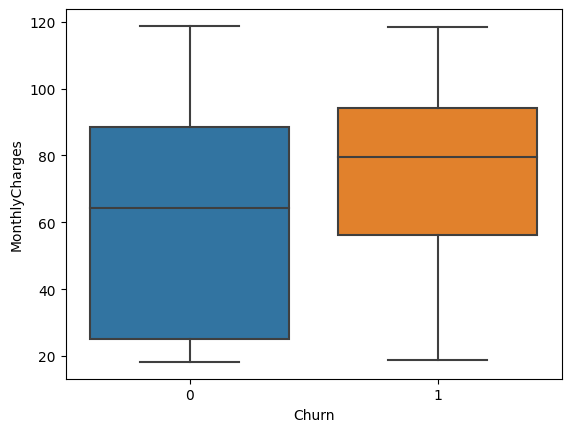

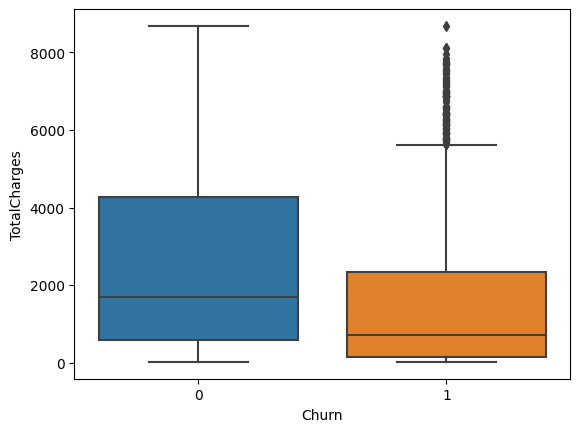

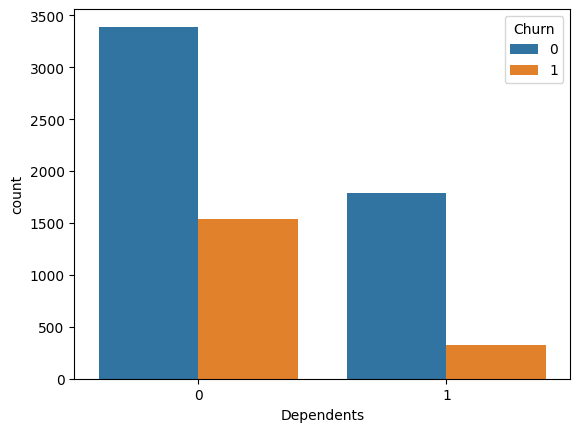

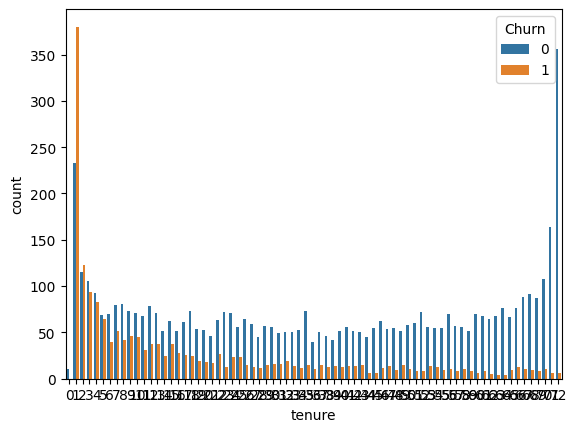

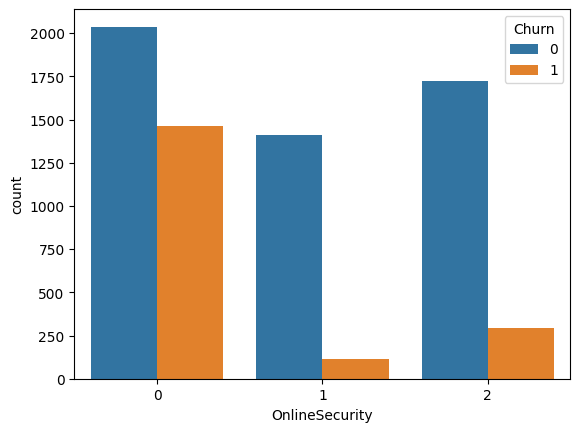

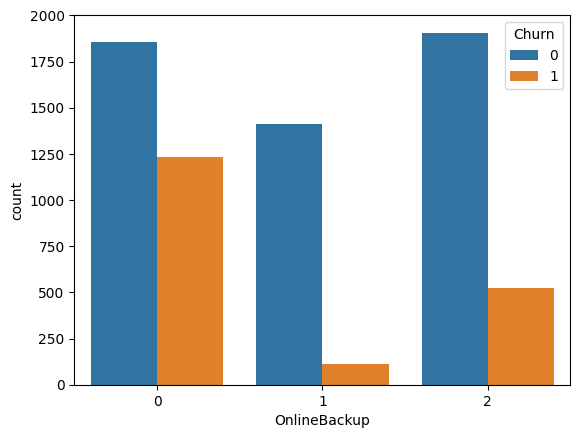

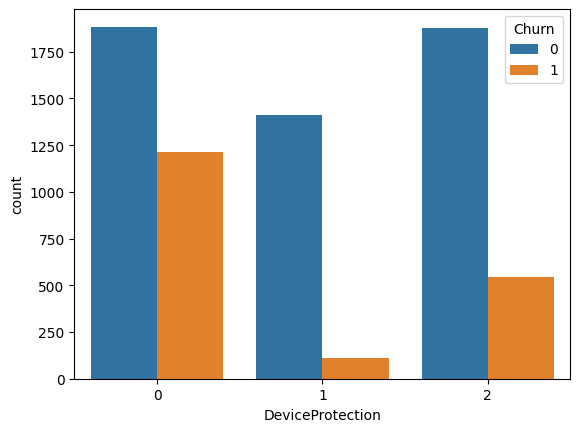

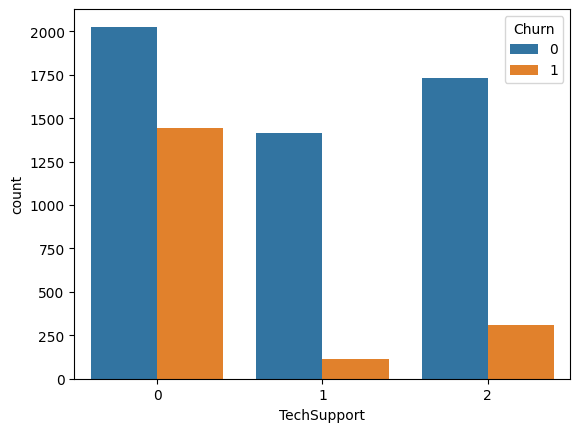

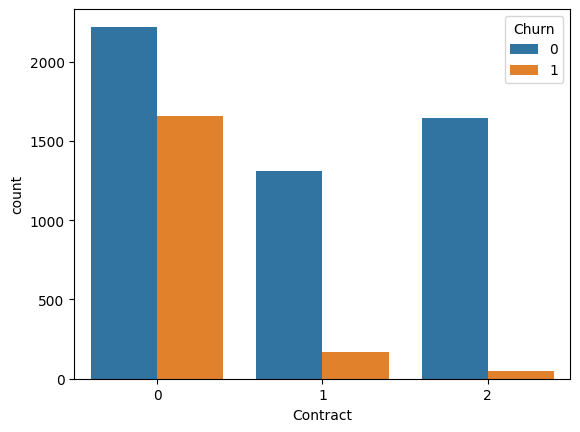

In [ ]:
df = df.copy()

sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.show()
print('\n')

sns.boxplot(x='Churn', y='TotalCharges', data=df)
plt.show()
print('\n')

for i in range(0,7):
  sns.countplot(x=df.columns[i], hue='Churn', data=df)
  plt.show()
  print('\n')


# Determining X and y variables

In [12]:
y = df['Churn']
X = df.drop('Churn', axis=1)

# Scaling dependent variable

In [13]:
scaler = StandardScaler().fit(X.copy())
X=pd.DataFrame(scaler.transform(X.copy()), columns=X.columns)

In [ ]:
X.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,TotalCharges
0,-0.654012,-1.277445,-0.918838,1.242550,-1.027910,-0.925262,-0.828207,0.829798,-1.160323,-0.994971
1,-0.654012,0.066327,1.407321,-1.029919,1.245111,-0.925262,0.371271,-1.205113,-0.259629,-0.173876
2,-0.654012,-1.236724,1.407321,1.242550,-1.027910,-0.925262,-0.828207,0.829798,-0.362660,-0.960399
3,-0.654012,0.514251,1.407321,-1.029919,1.245111,1.396299,0.371271,-1.205113,-0.746535,-0.195400
4,-0.654012,-1.236724,-0.918838,-1.029919,-1.027910,-0.925262,-0.828207,0.829798,0.197365,-0.941193


# Saving the scaler as a pickle file

In [14]:
filename = '/content/drive/My Drive/Colab Notebooks/Introduction_To_AI/Assignment3_ChurnPrediction/x_scaler.pkl'
pickle.dump(scaler, open(filename, 'wb'))

# Multi-layer perceptron using Functional API

In [ ]:
def create_model(dropout_rate=0.0, optimizer=Adam(learning_rate=0.001), loss=binary_crossentropy, metrics=['accuracy']):
    # Define the input layer
    input_layer = Input(shape=(X.shape[1],))

    # Define the hidden layers
    hidden_layer1 = Dense(64, activation='relu')(input_layer)
    hidden_layer2 = Dense(32, activation='relu')(hidden_layer1)
    hidden_layer3 = Dense(8, activation='relu')(hidden_layer2)

    # Define the output layer
    output_layer = Dense(1, activation='sigmoid')(hidden_layer3)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model with an appropriate optimizer, loss function, and metrics
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

# Cross-validation using Hold-Out Method

In [15]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Graph of raw model

In [ ]:
model = create_model()
history = model.fit(Xtrain, Ytrain, epochs=10, batch_size=30, validation_data=(Xtest, Ytest))

Epoch 1/10
188/188 [==============================] - 3s 7ms/step - loss: 0.6331 - accuracy: 0.6747 - val_loss: 0.4553 - val_accuracy: 0.7899
Epoch 2/10
188/188 [==============================] - 1s 6ms/step - loss: 0.4334 - accuracy: 0.7914 - val_loss: 0.4340 - val_accuracy: 0.7857
Epoch 3/10
188/188 [==============================] - 1s 5ms/step - loss: 0.4249 - accuracy: 0.7993 - val_loss: 0.4310 - val_accuracy: 0.7928
Epoch 4/10
188/188 [==============================] - 1s 7ms/step - loss: 0.4202 - accuracy: 0.7994 - val_loss: 0.4304 - val_accuracy: 0.7913
Epoch 5/10
188/188 [==============================] - 2s 9ms/step - loss: 0.4201 - accuracy: 0.7969 - val_loss: 0.4293 - val_accuracy: 0.7885
Epoch 6/10
188/188 [==============================] - 2s 9ms/step - loss: 0.4173 - accuracy: 0.8003 - val_loss: 0.4287 - val_accuracy: 0.7899
Epoch 7/10
188/188 [==============================] - 2s 9ms/step - loss: 0.4172 - accuracy: 0.8037 - val_loss: 0.4282 - val_accuracy: 0.7878
Epoch 

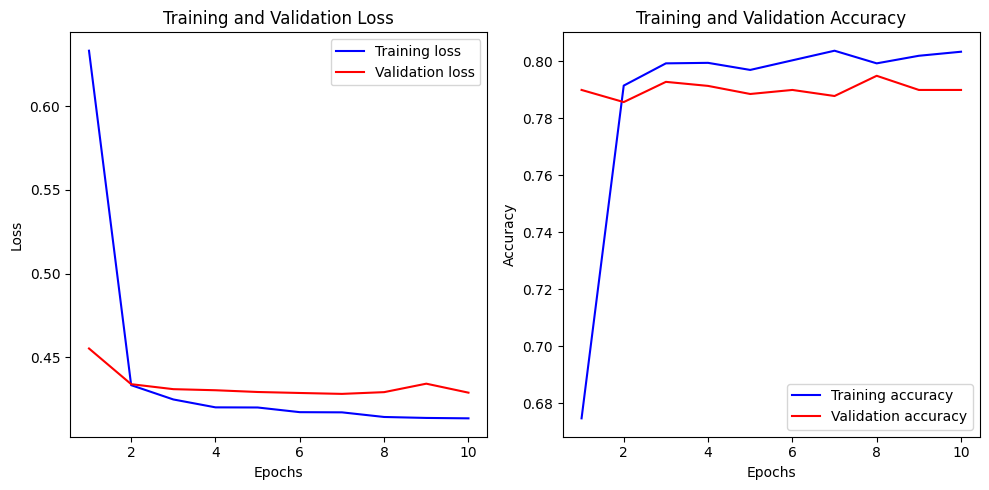

In [ ]:
# Plotting training and validation loss across epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy across epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# KerasClassifier wrapper

In [ ]:

# Wrap the Keras model in a scikit-learn estimator
keras_estimator = KerasClassifier(build_fn=create_model,
                                  epochs=10,
                                  batch_size=30,
                                  dropout_rate=0.0,
                                  validation_split=0.1,
                                  optimizer=Adam(learning_rate=0.001),
                                  loss=binary_crossentropy,
                                  metrics=['accuracy']
                                )




# GRID SEARCH

In [ ]:
# GRID SEARCH
param_grid = {
    'batch_size': [10, 20, 30],
    'epochs': [10, 20, 30],
    'dropout_rate': [0.1, 0.2, 0.3],
    'validation_split': [0.1, 0.2]
}

grid_DL = GridSearchCV(estimator=keras_estimator, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
history = grid_DL.fit(Xtrain, Ytrain, verbose=2)

print("Best: %f using %s" % (grid_DL.best_score_, grid_DL.best_params_))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
406/406 - 4s - loss: 0.4572 - accuracy: 0.7680 - val_loss: 0.4161 - val_accuracy: 0.7982 - 4s/epoch - 9ms/step
Epoch 2/10
406/406 - 2s - loss: 0.4356 - accuracy: 0.7867 - val_loss: 0.4100 - val_accuracy: 0.8071 - 2s/epoch - 5ms/step
Epoch 3/10
406/406 - 2s - loss: 0.4327 - accuracy: 0.7894 - val_loss: 0.4028 - val_accuracy: 0.8093 - 2s/epoch - 6ms/step
Epoch 4/10
406/406 - 3s - loss: 0.4299 - accuracy: 0.7912 - val_loss: 0.4020 - val_accuracy: 0.8027 - 3s/epoch - 6ms/step
Epoch 5/10
406/406 - 4s - loss: 0.4276 - accuracy: 0.7899 - val_loss: 0.4111 - val_accuracy: 0.8071 - 4s/epoch - 9ms/step
Epoch 6/10
406/406 - 3s - loss: 0.4258 - accuracy: 0.7946 - val_loss: 0.4048 - val_accuracy: 0.8137 - 3s/epoch - 8ms/step
Epoch 7/10
406/406 - 3s - loss: 0.4240 - accuracy: 0.7973 - val_loss: 0.4016 - val_accuracy: 0.8137 - 3s/epoch - 6ms/step
Epoch 8/10
406/406 - 2s - loss: 0.4223 - accuracy: 0.7936 - val_loss: 0.3974 - val_accuracy: 0.8204 - 2s/epoch - 6ms/step
Epoch 9/10
406/406 - 1s 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4600 - accuracy: 0.7680 - val_loss: 0.4145 - val_accuracy: 0.7938 - 2s/epoch - 5ms/step
Epoch 2/10
406/406 - 2s - loss: 0.4376 - accuracy: 0.7877 - val_loss: 0.4038 - val_accuracy: 0.8115 - 2s/epoch - 4ms/step
Epoch 3/10
406/406 - 2s - loss: 0.4269 - accuracy: 0.7909 - val_loss: 0.4100 - val_accuracy: 0.8093 - 2s/epoch - 4ms/step
Epoch 4/10
406/406 - 2s - loss: 0.4236 - accuracy: 0.7917 - val_loss: 0.4006 - val_accuracy: 0.8049 - 2s/epoch - 4ms/step
Epoch 5/10
406/406 - 2s - loss: 0.4214 - accuracy: 0.7927 - val_loss: 0.3994 - val_accuracy: 0.8204 - 2s/epoch - 4ms/step
Epoch 6/10
406/406 - 1s - loss: 0.4192 - accuracy: 0.7959 - val_loss: 0.3975 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 7/10
406/406 - 1s - loss: 0.4164 - accuracy: 0.7981 - val_loss: 0.3970 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 8/10
406/406 - 1s - loss: 0.4133 - accuracy: 0.7983 - val_loss: 0.4020 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 9/10
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4505 - accuracy: 0.7786 - val_loss: 0.4094 - val_accuracy: 0.7960 - 2s/epoch - 5ms/step
Epoch 2/10
406/406 - 1s - loss: 0.4289 - accuracy: 0.7939 - val_loss: 0.4058 - val_accuracy: 0.8093 - 1s/epoch - 4ms/step
Epoch 3/10
406/406 - 2s - loss: 0.4249 - accuracy: 0.7981 - val_loss: 0.4062 - val_accuracy: 0.8137 - 2s/epoch - 5ms/step
Epoch 4/10
406/406 - 2s - loss: 0.4230 - accuracy: 0.7988 - val_loss: 0.4009 - val_accuracy: 0.8160 - 2s/epoch - 5ms/step
Epoch 5/10
406/406 - 2s - loss: 0.4211 - accuracy: 0.7988 - val_loss: 0.4048 - val_accuracy: 0.8115 - 2s/epoch - 4ms/step
Epoch 6/10
406/406 - 1s - loss: 0.4183 - accuracy: 0.8018 - val_loss: 0.4029 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 7/10
406/406 - 1s - loss: 0.4175 - accuracy: 0.8037 - val_loss: 0.3966 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 8/10
406/406 - 1s - loss: 0.4150 - accuracy: 0.8035 - val_loss: 0.3957 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 9/10
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4442 - accuracy: 0.7823 - val_loss: 0.4128 - val_accuracy: 0.8004 - 2s/epoch - 5ms/step
Epoch 2/10
406/406 - 1s - loss: 0.4302 - accuracy: 0.7909 - val_loss: 0.4119 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 3/10
406/406 - 2s - loss: 0.4239 - accuracy: 0.7966 - val_loss: 0.4144 - val_accuracy: 0.8027 - 2s/epoch - 4ms/step
Epoch 4/10
406/406 - 2s - loss: 0.4213 - accuracy: 0.8008 - val_loss: 0.4097 - val_accuracy: 0.8093 - 2s/epoch - 4ms/step
Epoch 5/10
406/406 - 2s - loss: 0.4168 - accuracy: 0.7996 - val_loss: 0.4160 - val_accuracy: 0.8093 - 2s/epoch - 4ms/step
Epoch 6/10
406/406 - 2s - loss: 0.4177 - accuracy: 0.7976 - val_loss: 0.4061 - val_accuracy: 0.8115 - 2s/epoch - 4ms/step
Epoch 7/10
406/406 - 1s - loss: 0.4164 - accuracy: 0.8003 - val_loss: 0.4097 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 8/10
406/406 - 1s - loss: 0.4139 - accuracy: 0.8042 - val_loss: 0.4111 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 9/10
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4535 - accuracy: 0.7747 - val_loss: 0.4308 - val_accuracy: 0.7894 - 2s/epoch - 5ms/step
Epoch 2/10
406/406 - 1s - loss: 0.4325 - accuracy: 0.7991 - val_loss: 0.4129 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 3/10
406/406 - 1s - loss: 0.4301 - accuracy: 0.7937 - val_loss: 0.4150 - val_accuracy: 0.8071 - 1s/epoch - 4ms/step
Epoch 4/10
406/406 - 2s - loss: 0.4285 - accuracy: 0.7979 - val_loss: 0.4189 - val_accuracy: 0.7938 - 2s/epoch - 4ms/step
Epoch 5/10
406/406 - 2s - loss: 0.4248 - accuracy: 0.7971 - val_loss: 0.4167 - val_accuracy: 0.7982 - 2s/epoch - 4ms/step
Epoch 6/10
406/406 - 2s - loss: 0.4223 - accuracy: 0.8013 - val_loss: 0.4070 - val_accuracy: 0.8115 - 2s/epoch - 5ms/step
Epoch 7/10
406/406 - 1s - loss: 0.4209 - accuracy: 0.8033 - val_loss: 0.4143 - val_accuracy: 0.7982 - 1s/epoch - 4ms/step
Epoch 8/10
406/406 - 1s - loss: 0.4195 - accuracy: 0.8013 - val_loss: 0.4136 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 9/10
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4593 - accuracy: 0.7675 - val_loss: 0.4196 - val_accuracy: 0.7949 - 2s/epoch - 5ms/step
Epoch 2/10
361/361 - 1s - loss: 0.4400 - accuracy: 0.7872 - val_loss: 0.4211 - val_accuracy: 0.7882 - 1s/epoch - 3ms/step
Epoch 3/10
361/361 - 1s - loss: 0.4362 - accuracy: 0.7861 - val_loss: 0.4119 - val_accuracy: 0.7993 - 1s/epoch - 3ms/step
Epoch 4/10
361/361 - 2s - loss: 0.4332 - accuracy: 0.7889 - val_loss: 0.4164 - val_accuracy: 0.8115 - 2s/epoch - 4ms/step
Epoch 5/10
361/361 - 2s - loss: 0.4300 - accuracy: 0.7892 - val_loss: 0.4223 - val_accuracy: 0.7860 - 2s/epoch - 5ms/step
Epoch 6/10
361/361 - 2s - loss: 0.4276 - accuracy: 0.7928 - val_loss: 0.4078 - val_accuracy: 0.8038 - 2s/epoch - 5ms/step
Epoch 7/10
361/361 - 2s - loss: 0.4266 - accuracy: 0.7942 - val_loss: 0.4086 - val_accuracy: 0.8016 - 2s/epoch - 5ms/step
Epoch 8/10
361/361 - 1s - loss: 0.4249 - accuracy: 0.7939 - val_loss: 0.4090 - val_accuracy: 0.7993 - 1s/epoch - 3ms/step
Epoch 9/10
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 5s - loss: 0.4515 - accuracy: 0.7792 - val_loss: 0.4205 - val_accuracy: 0.7916 - 5s/epoch - 13ms/step
Epoch 2/10
361/361 - 2s - loss: 0.4353 - accuracy: 0.7850 - val_loss: 0.4217 - val_accuracy: 0.7849 - 2s/epoch - 4ms/step
Epoch 3/10
361/361 - 1s - loss: 0.4304 - accuracy: 0.7917 - val_loss: 0.4169 - val_accuracy: 0.8038 - 1s/epoch - 4ms/step
Epoch 4/10
361/361 - 1s - loss: 0.4272 - accuracy: 0.7933 - val_loss: 0.4158 - val_accuracy: 0.8071 - 1s/epoch - 4ms/step
Epoch 5/10
361/361 - 1s - loss: 0.4243 - accuracy: 0.7906 - val_loss: 0.4147 - val_accuracy: 0.8071 - 1s/epoch - 4ms/step
Epoch 6/10
361/361 - 1s - loss: 0.4226 - accuracy: 0.7939 - val_loss: 0.4163 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 7/10
361/361 - 1s - loss: 0.4194 - accuracy: 0.7950 - val_loss: 0.4137 - val_accuracy: 0.7971 - 1s/epoch - 3ms/step
Epoch 8/10
361/361 - 1s - loss: 0.4177 - accuracy: 0.7956 - val_loss: 0.4153 - val_accuracy: 0.7993 - 1s/epoch - 3ms/step
Epoch 9/10
361/361 - 1s - loss: 0.

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 3s - loss: 0.4644 - accuracy: 0.7578 - val_loss: 0.4265 - val_accuracy: 0.7938 - 3s/epoch - 9ms/step
Epoch 2/10
361/361 - 2s - loss: 0.4433 - accuracy: 0.7911 - val_loss: 0.4216 - val_accuracy: 0.8016 - 2s/epoch - 5ms/step
Epoch 3/10
361/361 - 1s - loss: 0.4389 - accuracy: 0.7961 - val_loss: 0.4209 - val_accuracy: 0.8016 - 1s/epoch - 3ms/step
Epoch 4/10
361/361 - 1s - loss: 0.4354 - accuracy: 0.7975 - val_loss: 0.4202 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 5/10
361/361 - 1s - loss: 0.4328 - accuracy: 0.7986 - val_loss: 0.4157 - val_accuracy: 0.8016 - 1s/epoch - 3ms/step
Epoch 6/10
361/361 - 1s - loss: 0.4261 - accuracy: 0.8025 - val_loss: 0.4135 - val_accuracy: 0.7971 - 1s/epoch - 3ms/step
Epoch 7/10
361/361 - 1s - loss: 0.4219 - accuracy: 0.8036 - val_loss: 0.4132 - val_accuracy: 0.8016 - 1s/epoch - 3ms/step
Epoch 8/10
361/361 - 2s - loss: 0.4210 - accuracy: 0.8028 - val_loss: 0.4105 - val_accuracy: 0.8038 - 2s/epoch - 5ms/step
Epoch 9/10
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4516 - accuracy: 0.7781 - val_loss: 0.4169 - val_accuracy: 0.7993 - 2s/epoch - 5ms/step
Epoch 2/10
361/361 - 1s - loss: 0.4312 - accuracy: 0.7922 - val_loss: 0.4175 - val_accuracy: 0.8060 - 1s/epoch - 4ms/step
Epoch 3/10
361/361 - 1s - loss: 0.4260 - accuracy: 0.7936 - val_loss: 0.4149 - val_accuracy: 0.7982 - 1s/epoch - 4ms/step
Epoch 4/10
361/361 - 1s - loss: 0.4218 - accuracy: 0.7997 - val_loss: 0.4176 - val_accuracy: 0.7993 - 1s/epoch - 4ms/step
Epoch 5/10
361/361 - 1s - loss: 0.4185 - accuracy: 0.7981 - val_loss: 0.4131 - val_accuracy: 0.8038 - 1s/epoch - 4ms/step
Epoch 6/10
361/361 - 2s - loss: 0.4170 - accuracy: 0.8036 - val_loss: 0.4152 - val_accuracy: 0.7971 - 2s/epoch - 5ms/step
Epoch 7/10
361/361 - 2s - loss: 0.4163 - accuracy: 0.8033 - val_loss: 0.4170 - val_accuracy: 0.8115 - 2s/epoch - 5ms/step
Epoch 8/10
361/361 - 2s - loss: 0.4144 - accuracy: 0.8044 - val_loss: 0.4127 - val_accuracy: 0.8082 - 2s/epoch - 5ms/step
Epoch 9/10
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4537 - accuracy: 0.7815 - val_loss: 0.4462 - val_accuracy: 0.7794 - 2s/epoch - 6ms/step
Epoch 2/10
361/361 - 1s - loss: 0.4336 - accuracy: 0.7906 - val_loss: 0.4441 - val_accuracy: 0.7838 - 1s/epoch - 3ms/step
Epoch 3/10
361/361 - 1s - loss: 0.4290 - accuracy: 0.7917 - val_loss: 0.4348 - val_accuracy: 0.7871 - 1s/epoch - 3ms/step
Epoch 4/10
361/361 - 1s - loss: 0.4253 - accuracy: 0.7945 - val_loss: 0.4435 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 5/10
361/361 - 1s - loss: 0.4248 - accuracy: 0.8045 - val_loss: 0.4325 - val_accuracy: 0.7882 - 1s/epoch - 4ms/step
Epoch 6/10
361/361 - 2s - loss: 0.4230 - accuracy: 0.8048 - val_loss: 0.4323 - val_accuracy: 0.7871 - 2s/epoch - 5ms/step
Epoch 7/10
361/361 - 2s - loss: 0.4200 - accuracy: 0.8020 - val_loss: 0.4302 - val_accuracy: 0.7949 - 2s/epoch - 5ms/step
Epoch 8/10
361/361 - 2s - loss: 0.4199 - accuracy: 0.8028 - val_loss: 0.4328 - val_accuracy: 0.7871 - 2s/epoch - 5ms/step
Epoch 9/10
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4559 - accuracy: 0.7697 - val_loss: 0.4206 - val_accuracy: 0.7849 - 2s/epoch - 5ms/step
Epoch 2/20
406/406 - 1s - loss: 0.4381 - accuracy: 0.7877 - val_loss: 0.4141 - val_accuracy: 0.7960 - 1s/epoch - 3ms/step
Epoch 3/20
406/406 - 1s - loss: 0.4334 - accuracy: 0.7875 - val_loss: 0.4123 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 4/20
406/406 - 1s - loss: 0.4314 - accuracy: 0.7929 - val_loss: 0.4065 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 5/20
406/406 - 1s - loss: 0.4289 - accuracy: 0.7882 - val_loss: 0.4110 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 6/20
406/406 - 1s - loss: 0.4279 - accuracy: 0.7959 - val_loss: 0.4069 - val_accuracy: 0.8137 - 1s/epoch - 4ms/step
Epoch 7/20
406/406 - 2s - loss: 0.4252 - accuracy: 0.7939 - val_loss: 0.4030 - val_accuracy: 0.8248 - 2s/epoch - 4ms/step
Epoch 8/20
406/406 - 2s - loss: 0.4246 - accuracy: 0.7902 - val_loss: 0.4029 - val_accuracy: 0.8160 - 2s/epoch - 4ms/step
Epoch 9/20
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4478 - accuracy: 0.7806 - val_loss: 0.4204 - val_accuracy: 0.7982 - 2s/epoch - 5ms/step
Epoch 2/20
406/406 - 1s - loss: 0.4312 - accuracy: 0.7892 - val_loss: 0.4066 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 3/20
406/406 - 1s - loss: 0.4261 - accuracy: 0.7912 - val_loss: 0.4016 - val_accuracy: 0.8182 - 1s/epoch - 3ms/step
Epoch 4/20
406/406 - 1s - loss: 0.4230 - accuracy: 0.7931 - val_loss: 0.3991 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 5/20
406/406 - 1s - loss: 0.4207 - accuracy: 0.7964 - val_loss: 0.3985 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 6/20
406/406 - 1s - loss: 0.4187 - accuracy: 0.7954 - val_loss: 0.4017 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 7/20
406/406 - 1s - loss: 0.4170 - accuracy: 0.7986 - val_loss: 0.3940 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 8/20
406/406 - 2s - loss: 0.4141 - accuracy: 0.8015 - val_loss: 0.3930 - val_accuracy: 0.8071 - 2s/epoch - 4ms/step
Epoch 9/20
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 3s - loss: 0.4467 - accuracy: 0.7791 - val_loss: 0.4113 - val_accuracy: 0.8071 - 3s/epoch - 7ms/step
Epoch 2/20
406/406 - 2s - loss: 0.4302 - accuracy: 0.7944 - val_loss: 0.4203 - val_accuracy: 0.8115 - 2s/epoch - 4ms/step
Epoch 3/20
406/406 - 1s - loss: 0.4260 - accuracy: 0.8008 - val_loss: 0.4008 - val_accuracy: 0.8204 - 1s/epoch - 4ms/step
Epoch 4/20
406/406 - 1s - loss: 0.4242 - accuracy: 0.7964 - val_loss: 0.4006 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 5/20
406/406 - 1s - loss: 0.4224 - accuracy: 0.8000 - val_loss: 0.4032 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 6/20
406/406 - 1s - loss: 0.4211 - accuracy: 0.8023 - val_loss: 0.4040 - val_accuracy: 0.8204 - 1s/epoch - 3ms/step
Epoch 7/20
406/406 - 1s - loss: 0.4186 - accuracy: 0.8042 - val_loss: 0.3990 - val_accuracy: 0.8204 - 1s/epoch - 3ms/step
Epoch 8/20
406/406 - 1s - loss: 0.4178 - accuracy: 0.8023 - val_loss: 0.4026 - val_accuracy: 0.8248 - 1s/epoch - 3ms/step
Epoch 9/20
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4503 - accuracy: 0.7761 - val_loss: 0.4132 - val_accuracy: 0.8071 - 2s/epoch - 5ms/step
Epoch 2/20
406/406 - 1s - loss: 0.4301 - accuracy: 0.7862 - val_loss: 0.4135 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 3/20
406/406 - 2s - loss: 0.4249 - accuracy: 0.7949 - val_loss: 0.4090 - val_accuracy: 0.8115 - 2s/epoch - 4ms/step
Epoch 4/20
406/406 - 2s - loss: 0.4199 - accuracy: 0.8025 - val_loss: 0.4105 - val_accuracy: 0.8160 - 2s/epoch - 4ms/step
Epoch 5/20
406/406 - 2s - loss: 0.4181 - accuracy: 0.7983 - val_loss: 0.4083 - val_accuracy: 0.8182 - 2s/epoch - 4ms/step
Epoch 6/20
406/406 - 2s - loss: 0.4157 - accuracy: 0.7991 - val_loss: 0.4102 - val_accuracy: 0.8160 - 2s/epoch - 4ms/step
Epoch 7/20
406/406 - 1s - loss: 0.4127 - accuracy: 0.8020 - val_loss: 0.4068 - val_accuracy: 0.8182 - 1s/epoch - 3ms/step
Epoch 8/20
406/406 - 1s - loss: 0.4117 - accuracy: 0.8028 - val_loss: 0.3985 - val_accuracy: 0.8248 - 1s/epoch - 3ms/step
Epoch 9/20
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4587 - accuracy: 0.7720 - val_loss: 0.4170 - val_accuracy: 0.8071 - 2s/epoch - 5ms/step
Epoch 2/20
406/406 - 1s - loss: 0.4353 - accuracy: 0.7878 - val_loss: 0.4142 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 3/20
406/406 - 1s - loss: 0.4318 - accuracy: 0.7949 - val_loss: 0.4133 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 4/20
406/406 - 1s - loss: 0.4282 - accuracy: 0.7912 - val_loss: 0.4109 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 5/20
406/406 - 1s - loss: 0.4262 - accuracy: 0.7979 - val_loss: 0.4125 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 6/20
406/406 - 1s - loss: 0.4238 - accuracy: 0.8011 - val_loss: 0.4082 - val_accuracy: 0.8115 - 1s/epoch - 4ms/step
Epoch 7/20
406/406 - 2s - loss: 0.4219 - accuracy: 0.8033 - val_loss: 0.4091 - val_accuracy: 0.8182 - 2s/epoch - 4ms/step
Epoch 8/20
406/406 - 2s - loss: 0.4203 - accuracy: 0.8063 - val_loss: 0.4178 - val_accuracy: 0.7960 - 2s/epoch - 5ms/step
Epoch 9/20
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4609 - accuracy: 0.7659 - val_loss: 0.4199 - val_accuracy: 0.7993 - 2s/epoch - 5ms/step
Epoch 2/20
361/361 - 1s - loss: 0.4397 - accuracy: 0.7834 - val_loss: 0.4150 - val_accuracy: 0.7982 - 1s/epoch - 4ms/step
Epoch 3/20
361/361 - 1s - loss: 0.4356 - accuracy: 0.7881 - val_loss: 0.4112 - val_accuracy: 0.8038 - 1s/epoch - 4ms/step
Epoch 4/20
361/361 - 1s - loss: 0.4334 - accuracy: 0.7903 - val_loss: 0.4116 - val_accuracy: 0.8027 - 1s/epoch - 4ms/step
Epoch 5/20
361/361 - 1s - loss: 0.4321 - accuracy: 0.7872 - val_loss: 0.4091 - val_accuracy: 0.8004 - 1s/epoch - 4ms/step
Epoch 6/20
361/361 - 1s - loss: 0.4309 - accuracy: 0.7917 - val_loss: 0.4101 - val_accuracy: 0.8016 - 1s/epoch - 3ms/step
Epoch 7/20
361/361 - 1s - loss: 0.4292 - accuracy: 0.7892 - val_loss: 0.4110 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 8/20
361/361 - 2s - loss: 0.4266 - accuracy: 0.7903 - val_loss: 0.4095 - val_accuracy: 0.8060 - 2s/epoch - 5ms/step
Epoch 9/20
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 3s - loss: 0.4514 - accuracy: 0.7767 - val_loss: 0.4209 - val_accuracy: 0.7916 - 3s/epoch - 8ms/step
Epoch 2/20
361/361 - 2s - loss: 0.4341 - accuracy: 0.7895 - val_loss: 0.4123 - val_accuracy: 0.7982 - 2s/epoch - 5ms/step
Epoch 3/20
361/361 - 1s - loss: 0.4282 - accuracy: 0.7914 - val_loss: 0.4143 - val_accuracy: 0.7916 - 1s/epoch - 4ms/step
Epoch 4/20
361/361 - 1s - loss: 0.4240 - accuracy: 0.7920 - val_loss: 0.4128 - val_accuracy: 0.8016 - 1s/epoch - 4ms/step
Epoch 5/20
361/361 - 1s - loss: 0.4233 - accuracy: 0.7936 - val_loss: 0.4080 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 6/20
361/361 - 1s - loss: 0.4200 - accuracy: 0.7950 - val_loss: 0.4141 - val_accuracy: 0.7949 - 1s/epoch - 4ms/step
Epoch 7/20
361/361 - 1s - loss: 0.4199 - accuracy: 0.7961 - val_loss: 0.4095 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 8/20
361/361 - 1s - loss: 0.4170 - accuracy: 0.7939 - val_loss: 0.4113 - val_accuracy: 0.7960 - 1s/epoch - 3ms/step
Epoch 9/20
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4514 - accuracy: 0.7775 - val_loss: 0.4196 - val_accuracy: 0.7949 - 2s/epoch - 6ms/step
Epoch 2/20
361/361 - 2s - loss: 0.4323 - accuracy: 0.7967 - val_loss: 0.4187 - val_accuracy: 0.7960 - 2s/epoch - 5ms/step
Epoch 3/20
361/361 - 2s - loss: 0.4273 - accuracy: 0.7989 - val_loss: 0.4123 - val_accuracy: 0.8016 - 2s/epoch - 5ms/step
Epoch 4/20
361/361 - 2s - loss: 0.4227 - accuracy: 0.8017 - val_loss: 0.4133 - val_accuracy: 0.8038 - 2s/epoch - 5ms/step
Epoch 5/20
361/361 - 1s - loss: 0.4205 - accuracy: 0.8039 - val_loss: 0.4153 - val_accuracy: 0.7905 - 1s/epoch - 4ms/step
Epoch 6/20
361/361 - 1s - loss: 0.4185 - accuracy: 0.8028 - val_loss: 0.4161 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 7/20
361/361 - 1s - loss: 0.4149 - accuracy: 0.8075 - val_loss: 0.4162 - val_accuracy: 0.8016 - 1s/epoch - 3ms/step
Epoch 8/20
361/361 - 1s - loss: 0.4144 - accuracy: 0.8025 - val_loss: 0.4113 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 9/20
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4486 - accuracy: 0.7770 - val_loss: 0.4158 - val_accuracy: 0.8049 - 2s/epoch - 6ms/step
Epoch 2/20
361/361 - 1s - loss: 0.4292 - accuracy: 0.7911 - val_loss: 0.4131 - val_accuracy: 0.8060 - 1s/epoch - 3ms/step
Epoch 3/20
361/361 - 1s - loss: 0.4252 - accuracy: 0.7972 - val_loss: 0.4119 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 4/20
361/361 - 1s - loss: 0.4228 - accuracy: 0.7989 - val_loss: 0.4185 - val_accuracy: 0.8016 - 1s/epoch - 3ms/step
Epoch 5/20
361/361 - 2s - loss: 0.4210 - accuracy: 0.8022 - val_loss: 0.4114 - val_accuracy: 0.8115 - 2s/epoch - 4ms/step
Epoch 6/20
361/361 - 2s - loss: 0.4195 - accuracy: 0.8033 - val_loss: 0.4088 - val_accuracy: 0.8093 - 2s/epoch - 5ms/step
Epoch 7/20
361/361 - 2s - loss: 0.4166 - accuracy: 0.8031 - val_loss: 0.4117 - val_accuracy: 0.8093 - 2s/epoch - 5ms/step
Epoch 8/20
361/361 - 2s - loss: 0.4146 - accuracy: 0.8097 - val_loss: 0.4097 - val_accuracy: 0.8049 - 2s/epoch - 5ms/step
Epoch 9/20
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4572 - accuracy: 0.7740 - val_loss: 0.4477 - val_accuracy: 0.7749 - 2s/epoch - 6ms/step
Epoch 2/20
361/361 - 1s - loss: 0.4347 - accuracy: 0.7903 - val_loss: 0.4322 - val_accuracy: 0.7927 - 1s/epoch - 3ms/step
Epoch 3/20
361/361 - 1s - loss: 0.4301 - accuracy: 0.7923 - val_loss: 0.4310 - val_accuracy: 0.7993 - 1s/epoch - 3ms/step
Epoch 4/20
361/361 - 1s - loss: 0.4268 - accuracy: 0.7965 - val_loss: 0.4300 - val_accuracy: 0.7927 - 1s/epoch - 3ms/step
Epoch 5/20
361/361 - 1s - loss: 0.4239 - accuracy: 0.7984 - val_loss: 0.4316 - val_accuracy: 0.7772 - 1s/epoch - 4ms/step
Epoch 6/20
361/361 - 1s - loss: 0.4211 - accuracy: 0.7992 - val_loss: 0.4307 - val_accuracy: 0.7849 - 1s/epoch - 4ms/step
Epoch 7/20
361/361 - 1s - loss: 0.4187 - accuracy: 0.8042 - val_loss: 0.4283 - val_accuracy: 0.7971 - 1s/epoch - 4ms/step
Epoch 8/20
361/361 - 1s - loss: 0.4171 - accuracy: 0.8017 - val_loss: 0.4385 - val_accuracy: 0.7882 - 1s/epoch - 4ms/step
Epoch 9/20
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 3s - loss: 0.4539 - accuracy: 0.7781 - val_loss: 0.4141 - val_accuracy: 0.7938 - 3s/epoch - 7ms/step
Epoch 2/30
406/406 - 2s - loss: 0.4389 - accuracy: 0.7865 - val_loss: 0.4097 - val_accuracy: 0.8115 - 2s/epoch - 5ms/step
Epoch 3/30
406/406 - 1s - loss: 0.4336 - accuracy: 0.7890 - val_loss: 0.4042 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 4/30
406/406 - 1s - loss: 0.4328 - accuracy: 0.7887 - val_loss: 0.4040 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 5/30
406/406 - 1s - loss: 0.4304 - accuracy: 0.7941 - val_loss: 0.4033 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 6/30
406/406 - 1s - loss: 0.4280 - accuracy: 0.7902 - val_loss: 0.4037 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 7/30
406/406 - 1s - loss: 0.4277 - accuracy: 0.7909 - val_loss: 0.4099 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 8/30
406/406 - 1s - loss: 0.4251 - accuracy: 0.7968 - val_loss: 0.4076 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 9/30
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4494 - accuracy: 0.7811 - val_loss: 0.4132 - val_accuracy: 0.8071 - 2s/epoch - 5ms/step
Epoch 2/30
406/406 - 1s - loss: 0.4304 - accuracy: 0.7890 - val_loss: 0.4064 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 3/30
406/406 - 2s - loss: 0.4262 - accuracy: 0.7941 - val_loss: 0.4115 - val_accuracy: 0.8027 - 2s/epoch - 4ms/step
Epoch 4/30
406/406 - 2s - loss: 0.4231 - accuracy: 0.7892 - val_loss: 0.4093 - val_accuracy: 0.8204 - 2s/epoch - 4ms/step
Epoch 5/30
406/406 - 2s - loss: 0.4217 - accuracy: 0.7922 - val_loss: 0.4120 - val_accuracy: 0.8160 - 2s/epoch - 5ms/step
Epoch 6/30
406/406 - 1s - loss: 0.4196 - accuracy: 0.7966 - val_loss: 0.4100 - val_accuracy: 0.8226 - 1s/epoch - 3ms/step
Epoch 7/30
406/406 - 1s - loss: 0.4161 - accuracy: 0.7959 - val_loss: 0.4026 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 8/30
406/406 - 1s - loss: 0.4146 - accuracy: 0.7941 - val_loss: 0.4018 - val_accuracy: 0.8160 - 1s/epoch - 3ms/step
Epoch 9/30
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4517 - accuracy: 0.7774 - val_loss: 0.4128 - val_accuracy: 0.8115 - 2s/epoch - 5ms/step
Epoch 2/30
406/406 - 1s - loss: 0.4291 - accuracy: 0.7951 - val_loss: 0.4090 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 3/30
406/406 - 1s - loss: 0.4246 - accuracy: 0.7968 - val_loss: 0.4017 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 4/30
406/406 - 1s - loss: 0.4229 - accuracy: 0.7998 - val_loss: 0.3979 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 5/30
406/406 - 2s - loss: 0.4207 - accuracy: 0.7981 - val_loss: 0.4086 - val_accuracy: 0.8027 - 2s/epoch - 4ms/step
Epoch 6/30
406/406 - 2s - loss: 0.4183 - accuracy: 0.8028 - val_loss: 0.4020 - val_accuracy: 0.8093 - 2s/epoch - 4ms/step
Epoch 7/30
406/406 - 2s - loss: 0.4182 - accuracy: 0.8013 - val_loss: 0.3995 - val_accuracy: 0.8115 - 2s/epoch - 4ms/step
Epoch 8/30
406/406 - 2s - loss: 0.4157 - accuracy: 0.8047 - val_loss: 0.3982 - val_accuracy: 0.8137 - 2s/epoch - 4ms/step
Epoch 9/30
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 3s - loss: 0.4533 - accuracy: 0.7742 - val_loss: 0.4112 - val_accuracy: 0.8093 - 3s/epoch - 7ms/step
Epoch 2/30
406/406 - 2s - loss: 0.4289 - accuracy: 0.7917 - val_loss: 0.4124 - val_accuracy: 0.8027 - 2s/epoch - 4ms/step
Epoch 3/30
406/406 - 2s - loss: 0.4258 - accuracy: 0.7964 - val_loss: 0.4076 - val_accuracy: 0.8071 - 2s/epoch - 4ms/step
Epoch 4/30
406/406 - 1s - loss: 0.4225 - accuracy: 0.7983 - val_loss: 0.4090 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 5/30
406/406 - 1s - loss: 0.4209 - accuracy: 0.7983 - val_loss: 0.4057 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 6/30
406/406 - 1s - loss: 0.4192 - accuracy: 0.7993 - val_loss: 0.4073 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 7/30
406/406 - 1s - loss: 0.4187 - accuracy: 0.8045 - val_loss: 0.4068 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 8/30
406/406 - 1s - loss: 0.4170 - accuracy: 0.8033 - val_loss: 0.4076 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 9/30
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4584 - accuracy: 0.7759 - val_loss: 0.4161 - val_accuracy: 0.8071 - 2s/epoch - 6ms/step
Epoch 2/30
406/406 - 1s - loss: 0.4372 - accuracy: 0.7902 - val_loss: 0.4264 - val_accuracy: 0.7960 - 1s/epoch - 3ms/step
Epoch 3/30
406/406 - 2s - loss: 0.4327 - accuracy: 0.7927 - val_loss: 0.4222 - val_accuracy: 0.8071 - 2s/epoch - 4ms/step
Epoch 4/30
406/406 - 2s - loss: 0.4295 - accuracy: 0.7927 - val_loss: 0.4247 - val_accuracy: 0.8071 - 2s/epoch - 5ms/step
Epoch 5/30
406/406 - 2s - loss: 0.4260 - accuracy: 0.7999 - val_loss: 0.4120 - val_accuracy: 0.8093 - 2s/epoch - 4ms/step
Epoch 6/30
406/406 - 1s - loss: 0.4247 - accuracy: 0.7981 - val_loss: 0.4121 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 7/30
406/406 - 1s - loss: 0.4223 - accuracy: 0.7959 - val_loss: 0.4182 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 8/30
406/406 - 1s - loss: 0.4212 - accuracy: 0.8018 - val_loss: 0.4091 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 9/30
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4590 - accuracy: 0.7742 - val_loss: 0.4212 - val_accuracy: 0.7927 - 2s/epoch - 6ms/step
Epoch 2/30
361/361 - 1s - loss: 0.4412 - accuracy: 0.7811 - val_loss: 0.4144 - val_accuracy: 0.7905 - 1s/epoch - 3ms/step
Epoch 3/30
361/361 - 1s - loss: 0.4359 - accuracy: 0.7853 - val_loss: 0.4147 - val_accuracy: 0.7949 - 1s/epoch - 3ms/step
Epoch 4/30
361/361 - 1s - loss: 0.4349 - accuracy: 0.7864 - val_loss: 0.4148 - val_accuracy: 0.7960 - 1s/epoch - 3ms/step
Epoch 5/30
361/361 - 1s - loss: 0.4293 - accuracy: 0.7886 - val_loss: 0.4161 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 6/30
361/361 - 1s - loss: 0.4293 - accuracy: 0.7936 - val_loss: 0.4109 - val_accuracy: 0.8082 - 1s/epoch - 4ms/step
Epoch 7/30
361/361 - 1s - loss: 0.4254 - accuracy: 0.7953 - val_loss: 0.4134 - val_accuracy: 0.8082 - 1s/epoch - 4ms/step
Epoch 8/30
361/361 - 1s - loss: 0.4247 - accuracy: 0.7914 - val_loss: 0.4097 - val_accuracy: 0.8160 - 1s/epoch - 4ms/step
Epoch 9/30
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4515 - accuracy: 0.7775 - val_loss: 0.4294 - val_accuracy: 0.7960 - 2s/epoch - 5ms/step
Epoch 2/30
361/361 - 2s - loss: 0.4325 - accuracy: 0.7867 - val_loss: 0.4202 - val_accuracy: 0.7860 - 2s/epoch - 5ms/step
Epoch 3/30
361/361 - 2s - loss: 0.4276 - accuracy: 0.7889 - val_loss: 0.4168 - val_accuracy: 0.7982 - 2s/epoch - 5ms/step
Epoch 4/30
361/361 - 2s - loss: 0.4228 - accuracy: 0.7925 - val_loss: 0.4150 - val_accuracy: 0.8038 - 2s/epoch - 5ms/step
Epoch 5/30
361/361 - 1s - loss: 0.4222 - accuracy: 0.7914 - val_loss: 0.4146 - val_accuracy: 0.8027 - 1s/epoch - 4ms/step
Epoch 6/30
361/361 - 1s - loss: 0.4191 - accuracy: 0.7903 - val_loss: 0.4143 - val_accuracy: 0.7993 - 1s/epoch - 3ms/step
Epoch 7/30
361/361 - 1s - loss: 0.4168 - accuracy: 0.7953 - val_loss: 0.4155 - val_accuracy: 0.7971 - 1s/epoch - 3ms/step
Epoch 8/30
361/361 - 1s - loss: 0.4148 - accuracy: 0.7994 - val_loss: 0.4119 - val_accuracy: 0.7971 - 1s/epoch - 3ms/step
Epoch 9/30
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4540 - accuracy: 0.7784 - val_loss: 0.4340 - val_accuracy: 0.7838 - 2s/epoch - 5ms/step
Epoch 2/30
361/361 - 1s - loss: 0.4304 - accuracy: 0.7964 - val_loss: 0.4349 - val_accuracy: 0.7783 - 1s/epoch - 3ms/step
Epoch 3/30
361/361 - 1s - loss: 0.4276 - accuracy: 0.7992 - val_loss: 0.4119 - val_accuracy: 0.8016 - 1s/epoch - 3ms/step
Epoch 4/30
361/361 - 1s - loss: 0.4218 - accuracy: 0.8014 - val_loss: 0.4198 - val_accuracy: 0.7905 - 1s/epoch - 3ms/step
Epoch 5/30
361/361 - 1s - loss: 0.4207 - accuracy: 0.8000 - val_loss: 0.4152 - val_accuracy: 0.7982 - 1s/epoch - 4ms/step
Epoch 6/30
361/361 - 1s - loss: 0.4186 - accuracy: 0.8047 - val_loss: 0.4197 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 7/30
361/361 - 1s - loss: 0.4171 - accuracy: 0.8047 - val_loss: 0.4163 - val_accuracy: 0.7949 - 1s/epoch - 3ms/step
Epoch 8/30
361/361 - 2s - loss: 0.4144 - accuracy: 0.8108 - val_loss: 0.4145 - val_accuracy: 0.8016 - 2s/epoch - 5ms/step
Epoch 9/30
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 3s - loss: 0.4532 - accuracy: 0.7820 - val_loss: 0.4206 - val_accuracy: 0.7938 - 3s/epoch - 7ms/step
Epoch 2/30
361/361 - 2s - loss: 0.4311 - accuracy: 0.7922 - val_loss: 0.4180 - val_accuracy: 0.7916 - 2s/epoch - 5ms/step
Epoch 3/30
361/361 - 1s - loss: 0.4258 - accuracy: 0.7936 - val_loss: 0.4117 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 4/30
361/361 - 1s - loss: 0.4234 - accuracy: 0.7953 - val_loss: 0.4115 - val_accuracy: 0.8016 - 1s/epoch - 3ms/step
Epoch 5/30
361/361 - 1s - loss: 0.4211 - accuracy: 0.7994 - val_loss: 0.4120 - val_accuracy: 0.8104 - 1s/epoch - 3ms/step
Epoch 6/30
361/361 - 1s - loss: 0.4192 - accuracy: 0.7989 - val_loss: 0.4141 - val_accuracy: 0.8016 - 1s/epoch - 4ms/step
Epoch 7/30
361/361 - 1s - loss: 0.4166 - accuracy: 0.8022 - val_loss: 0.4105 - val_accuracy: 0.8149 - 1s/epoch - 4ms/step
Epoch 8/30
361/361 - 1s - loss: 0.4149 - accuracy: 0.8017 - val_loss: 0.4115 - val_accuracy: 0.8104 - 1s/epoch - 4ms/step
Epoch 9/30
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4528 - accuracy: 0.7804 - val_loss: 0.4392 - val_accuracy: 0.7761 - 2s/epoch - 5ms/step
Epoch 2/30
361/361 - 2s - loss: 0.4342 - accuracy: 0.7923 - val_loss: 0.4463 - val_accuracy: 0.7838 - 2s/epoch - 4ms/step
Epoch 3/30
361/361 - 2s - loss: 0.4287 - accuracy: 0.7917 - val_loss: 0.4289 - val_accuracy: 0.7949 - 2s/epoch - 5ms/step
Epoch 4/30
361/361 - 2s - loss: 0.4254 - accuracy: 0.7970 - val_loss: 0.4295 - val_accuracy: 0.8027 - 2s/epoch - 5ms/step
Epoch 5/30
361/361 - 2s - loss: 0.4227 - accuracy: 0.7989 - val_loss: 0.4323 - val_accuracy: 0.7894 - 2s/epoch - 5ms/step
Epoch 6/30
361/361 - 1s - loss: 0.4217 - accuracy: 0.8014 - val_loss: 0.4285 - val_accuracy: 0.7927 - 1s/epoch - 4ms/step
Epoch 7/30
361/361 - 1s - loss: 0.4197 - accuracy: 0.8070 - val_loss: 0.4310 - val_accuracy: 0.7860 - 1s/epoch - 4ms/step
Epoch 8/30
361/361 - 1s - loss: 0.4179 - accuracy: 0.8050 - val_loss: 0.4288 - val_accuracy: 0.7938 - 1s/epoch - 4ms/step
Epoch 9/30
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4636 - accuracy: 0.7705 - val_loss: 0.4197 - val_accuracy: 0.7916 - 2s/epoch - 5ms/step
Epoch 2/10
406/406 - 1s - loss: 0.4466 - accuracy: 0.7882 - val_loss: 0.4111 - val_accuracy: 0.7938 - 1s/epoch - 3ms/step
Epoch 3/10
406/406 - 1s - loss: 0.4369 - accuracy: 0.7865 - val_loss: 0.4110 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 4/10
406/406 - 1s - loss: 0.4338 - accuracy: 0.7885 - val_loss: 0.4127 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 5/10
406/406 - 2s - loss: 0.4298 - accuracy: 0.7917 - val_loss: 0.4035 - val_accuracy: 0.7938 - 2s/epoch - 4ms/step
Epoch 6/10
406/406 - 2s - loss: 0.4285 - accuracy: 0.7954 - val_loss: 0.4049 - val_accuracy: 0.8004 - 2s/epoch - 5ms/step
Epoch 7/10
406/406 - 2s - loss: 0.4252 - accuracy: 0.7929 - val_loss: 0.4096 - val_accuracy: 0.8115 - 2s/epoch - 5ms/step
Epoch 8/10
406/406 - 2s - loss: 0.4241 - accuracy: 0.7907 - val_loss: 0.4052 - val_accuracy: 0.8160 - 2s/epoch - 4ms/step
Epoch 9/10
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4557 - accuracy: 0.7732 - val_loss: 0.4135 - val_accuracy: 0.8049 - 2s/epoch - 5ms/step
Epoch 2/10
406/406 - 1s - loss: 0.4298 - accuracy: 0.7917 - val_loss: 0.4162 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 3/10
406/406 - 1s - loss: 0.4271 - accuracy: 0.7907 - val_loss: 0.4041 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 4/10
406/406 - 1s - loss: 0.4222 - accuracy: 0.7941 - val_loss: 0.3965 - val_accuracy: 0.8226 - 1s/epoch - 3ms/step
Epoch 5/10
406/406 - 1s - loss: 0.4195 - accuracy: 0.7961 - val_loss: 0.4000 - val_accuracy: 0.8137 - 1s/epoch - 4ms/step
Epoch 6/10
406/406 - 2s - loss: 0.4167 - accuracy: 0.7968 - val_loss: 0.3989 - val_accuracy: 0.8093 - 2s/epoch - 4ms/step
Epoch 7/10
406/406 - 2s - loss: 0.4125 - accuracy: 0.8010 - val_loss: 0.4141 - val_accuracy: 0.8004 - 2s/epoch - 4ms/step
Epoch 8/10
406/406 - 2s - loss: 0.4133 - accuracy: 0.8045 - val_loss: 0.4023 - val_accuracy: 0.8137 - 2s/epoch - 4ms/step
Epoch 9/10
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4560 - accuracy: 0.7749 - val_loss: 0.4075 - val_accuracy: 0.8093 - 2s/epoch - 5ms/step
Epoch 2/10
406/406 - 1s - loss: 0.4293 - accuracy: 0.7909 - val_loss: 0.4066 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 3/10
406/406 - 1s - loss: 0.4271 - accuracy: 0.7973 - val_loss: 0.4029 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 4/10
406/406 - 1s - loss: 0.4243 - accuracy: 0.7964 - val_loss: 0.3999 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 5/10
406/406 - 1s - loss: 0.4221 - accuracy: 0.8005 - val_loss: 0.4046 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 6/10
406/406 - 2s - loss: 0.4206 - accuracy: 0.8030 - val_loss: 0.4057 - val_accuracy: 0.8137 - 2s/epoch - 4ms/step
Epoch 7/10
406/406 - 2s - loss: 0.4197 - accuracy: 0.8025 - val_loss: 0.4030 - val_accuracy: 0.8182 - 2s/epoch - 4ms/step
Epoch 8/10
406/406 - 2s - loss: 0.4184 - accuracy: 0.8008 - val_loss: 0.4011 - val_accuracy: 0.8137 - 2s/epoch - 4ms/step
Epoch 9/10
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4459 - accuracy: 0.7821 - val_loss: 0.4234 - val_accuracy: 0.8027 - 2s/epoch - 5ms/step
Epoch 2/10
406/406 - 1s - loss: 0.4282 - accuracy: 0.7912 - val_loss: 0.4121 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 3/10
406/406 - 1s - loss: 0.4222 - accuracy: 0.7971 - val_loss: 0.4036 - val_accuracy: 0.8204 - 1s/epoch - 3ms/step
Epoch 4/10
406/406 - 1s - loss: 0.4197 - accuracy: 0.8003 - val_loss: 0.4037 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 5/10
406/406 - 1s - loss: 0.4183 - accuracy: 0.8013 - val_loss: 0.4026 - val_accuracy: 0.8226 - 1s/epoch - 3ms/step
Epoch 6/10
406/406 - 1s - loss: 0.4151 - accuracy: 0.8033 - val_loss: 0.4079 - val_accuracy: 0.8182 - 1s/epoch - 3ms/step
Epoch 7/10
406/406 - 2s - loss: 0.4136 - accuracy: 0.8060 - val_loss: 0.4053 - val_accuracy: 0.8137 - 2s/epoch - 4ms/step
Epoch 8/10
406/406 - 2s - loss: 0.4118 - accuracy: 0.7996 - val_loss: 0.3960 - val_accuracy: 0.8226 - 2s/epoch - 4ms/step
Epoch 9/10
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4530 - accuracy: 0.7789 - val_loss: 0.4120 - val_accuracy: 0.8049 - 2s/epoch - 5ms/step
Epoch 2/10
406/406 - 1s - loss: 0.4351 - accuracy: 0.7910 - val_loss: 0.4150 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 3/10
406/406 - 1s - loss: 0.4289 - accuracy: 0.7925 - val_loss: 0.4178 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 4/10
406/406 - 1s - loss: 0.4262 - accuracy: 0.7989 - val_loss: 0.4141 - val_accuracy: 0.7960 - 1s/epoch - 3ms/step
Epoch 5/10
406/406 - 1s - loss: 0.4235 - accuracy: 0.7999 - val_loss: 0.4069 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 6/10
406/406 - 1s - loss: 0.4202 - accuracy: 0.8035 - val_loss: 0.4081 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 7/10
406/406 - 2s - loss: 0.4176 - accuracy: 0.8016 - val_loss: 0.4083 - val_accuracy: 0.8004 - 2s/epoch - 4ms/step
Epoch 8/10
406/406 - 2s - loss: 0.4168 - accuracy: 0.8040 - val_loss: 0.4146 - val_accuracy: 0.7982 - 2s/epoch - 4ms/step
Epoch 9/10
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4612 - accuracy: 0.7742 - val_loss: 0.4184 - val_accuracy: 0.7938 - 2s/epoch - 6ms/step
Epoch 2/10
361/361 - 1s - loss: 0.4410 - accuracy: 0.7828 - val_loss: 0.4174 - val_accuracy: 0.7927 - 1s/epoch - 3ms/step
Epoch 3/10
361/361 - 2s - loss: 0.4343 - accuracy: 0.7920 - val_loss: 0.4195 - val_accuracy: 0.7927 - 2s/epoch - 5ms/step
Epoch 4/10
361/361 - 2s - loss: 0.4322 - accuracy: 0.7917 - val_loss: 0.4170 - val_accuracy: 0.7916 - 2s/epoch - 5ms/step
Epoch 5/10
361/361 - 2s - loss: 0.4303 - accuracy: 0.7889 - val_loss: 0.4133 - val_accuracy: 0.8027 - 2s/epoch - 5ms/step
Epoch 6/10
361/361 - 2s - loss: 0.4279 - accuracy: 0.7878 - val_loss: 0.4159 - val_accuracy: 0.8038 - 2s/epoch - 5ms/step
Epoch 7/10
361/361 - 1s - loss: 0.4251 - accuracy: 0.7964 - val_loss: 0.4133 - val_accuracy: 0.7993 - 1s/epoch - 4ms/step
Epoch 8/10
361/361 - 1s - loss: 0.4241 - accuracy: 0.7897 - val_loss: 0.4128 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 9/10
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4614 - accuracy: 0.7612 - val_loss: 0.4286 - val_accuracy: 0.7960 - 2s/epoch - 5ms/step
Epoch 2/10
361/361 - 1s - loss: 0.4421 - accuracy: 0.7817 - val_loss: 0.4263 - val_accuracy: 0.7761 - 1s/epoch - 4ms/step
Epoch 3/10
361/361 - 1s - loss: 0.4357 - accuracy: 0.7881 - val_loss: 0.4232 - val_accuracy: 0.8027 - 1s/epoch - 4ms/step
Epoch 4/10
361/361 - 2s - loss: 0.4346 - accuracy: 0.7936 - val_loss: 0.4208 - val_accuracy: 0.7971 - 2s/epoch - 5ms/step
Epoch 5/10
361/361 - 2s - loss: 0.4305 - accuracy: 0.7900 - val_loss: 0.4209 - val_accuracy: 0.7982 - 2s/epoch - 5ms/step
Epoch 6/10
361/361 - 2s - loss: 0.4277 - accuracy: 0.7956 - val_loss: 0.4178 - val_accuracy: 0.8027 - 2s/epoch - 5ms/step
Epoch 7/10
361/361 - 1s - loss: 0.4250 - accuracy: 0.7936 - val_loss: 0.4145 - val_accuracy: 0.8115 - 1s/epoch - 4ms/step
Epoch 8/10
361/361 - 1s - loss: 0.4181 - accuracy: 0.7967 - val_loss: 0.4139 - val_accuracy: 0.8082 - 1s/epoch - 3ms/step
Epoch 9/10
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 3s - loss: 0.4533 - accuracy: 0.7759 - val_loss: 0.4175 - val_accuracy: 0.7949 - 3s/epoch - 7ms/step
Epoch 2/10
361/361 - 2s - loss: 0.4310 - accuracy: 0.7947 - val_loss: 0.4237 - val_accuracy: 0.7882 - 2s/epoch - 5ms/step
Epoch 3/10
361/361 - 1s - loss: 0.4257 - accuracy: 0.8000 - val_loss: 0.4104 - val_accuracy: 0.8049 - 1s/epoch - 4ms/step
Epoch 4/10
361/361 - 1s - loss: 0.4233 - accuracy: 0.8019 - val_loss: 0.4124 - val_accuracy: 0.8027 - 1s/epoch - 4ms/step
Epoch 5/10
361/361 - 1s - loss: 0.4201 - accuracy: 0.8033 - val_loss: 0.4137 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 6/10
361/361 - 1s - loss: 0.4167 - accuracy: 0.8022 - val_loss: 0.4167 - val_accuracy: 0.8027 - 1s/epoch - 4ms/step
Epoch 7/10
361/361 - 1s - loss: 0.4160 - accuracy: 0.8089 - val_loss: 0.4187 - val_accuracy: 0.7894 - 1s/epoch - 3ms/step
Epoch 8/10
361/361 - 1s - loss: 0.4120 - accuracy: 0.8033 - val_loss: 0.4151 - val_accuracy: 0.7916 - 1s/epoch - 4ms/step
Epoch 9/10
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4492 - accuracy: 0.7809 - val_loss: 0.4193 - val_accuracy: 0.8049 - 2s/epoch - 6ms/step
Epoch 2/10
361/361 - 1s - loss: 0.4296 - accuracy: 0.7964 - val_loss: 0.4194 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 3/10
361/361 - 1s - loss: 0.4259 - accuracy: 0.7969 - val_loss: 0.4195 - val_accuracy: 0.7971 - 1s/epoch - 4ms/step
Epoch 4/10
361/361 - 1s - loss: 0.4222 - accuracy: 0.7967 - val_loss: 0.4137 - val_accuracy: 0.7971 - 1s/epoch - 3ms/step
Epoch 5/10
361/361 - 1s - loss: 0.4198 - accuracy: 0.7992 - val_loss: 0.4191 - val_accuracy: 0.7971 - 1s/epoch - 4ms/step
Epoch 6/10
361/361 - 2s - loss: 0.4175 - accuracy: 0.8069 - val_loss: 0.4135 - val_accuracy: 0.8071 - 2s/epoch - 5ms/step
Epoch 7/10
361/361 - 2s - loss: 0.4157 - accuracy: 0.8055 - val_loss: 0.4139 - val_accuracy: 0.8071 - 2s/epoch - 5ms/step
Epoch 8/10
361/361 - 2s - loss: 0.4140 - accuracy: 0.8053 - val_loss: 0.4142 - val_accuracy: 0.8093 - 2s/epoch - 5ms/step
Epoch 9/10
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4556 - accuracy: 0.7718 - val_loss: 0.4289 - val_accuracy: 0.7938 - 2s/epoch - 5ms/step
Epoch 2/10
361/361 - 2s - loss: 0.4340 - accuracy: 0.7903 - val_loss: 0.4270 - val_accuracy: 0.7993 - 2s/epoch - 5ms/step
Epoch 3/10
361/361 - 2s - loss: 0.4294 - accuracy: 0.7965 - val_loss: 0.4349 - val_accuracy: 0.7838 - 2s/epoch - 5ms/step
Epoch 4/10
361/361 - 2s - loss: 0.4261 - accuracy: 0.8003 - val_loss: 0.4231 - val_accuracy: 0.7982 - 2s/epoch - 5ms/step
Epoch 5/10
361/361 - 2s - loss: 0.4230 - accuracy: 0.7992 - val_loss: 0.4293 - val_accuracy: 0.7927 - 2s/epoch - 4ms/step
Epoch 6/10
361/361 - 1s - loss: 0.4212 - accuracy: 0.7984 - val_loss: 0.4363 - val_accuracy: 0.7838 - 1s/epoch - 4ms/step
Epoch 7/10
361/361 - 1s - loss: 0.4195 - accuracy: 0.8048 - val_loss: 0.4332 - val_accuracy: 0.7894 - 1s/epoch - 4ms/step
Epoch 8/10
361/361 - 1s - loss: 0.4163 - accuracy: 0.8031 - val_loss: 0.4320 - val_accuracy: 0.7938 - 1s/epoch - 3ms/step
Epoch 9/10
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4646 - accuracy: 0.7525 - val_loss: 0.4091 - val_accuracy: 0.8071 - 2s/epoch - 5ms/step
Epoch 2/20
406/406 - 2s - loss: 0.4388 - accuracy: 0.7867 - val_loss: 0.4156 - val_accuracy: 0.7938 - 2s/epoch - 4ms/step
Epoch 3/20
406/406 - 2s - loss: 0.4346 - accuracy: 0.7862 - val_loss: 0.4123 - val_accuracy: 0.8027 - 2s/epoch - 4ms/step
Epoch 4/20
406/406 - 2s - loss: 0.4315 - accuracy: 0.7875 - val_loss: 0.4087 - val_accuracy: 0.8093 - 2s/epoch - 4ms/step
Epoch 5/20
406/406 - 2s - loss: 0.4295 - accuracy: 0.7924 - val_loss: 0.4058 - val_accuracy: 0.8160 - 2s/epoch - 4ms/step
Epoch 6/20
406/406 - 1s - loss: 0.4269 - accuracy: 0.7959 - val_loss: 0.4057 - val_accuracy: 0.8204 - 1s/epoch - 3ms/step
Epoch 7/20
406/406 - 1s - loss: 0.4272 - accuracy: 0.7946 - val_loss: 0.4093 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 8/20
406/406 - 1s - loss: 0.4250 - accuracy: 0.7917 - val_loss: 0.4049 - val_accuracy: 0.8204 - 1s/epoch - 3ms/step
Epoch 9/20
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4544 - accuracy: 0.7732 - val_loss: 0.4131 - val_accuracy: 0.7982 - 2s/epoch - 5ms/step
Epoch 2/20
406/406 - 1s - loss: 0.4385 - accuracy: 0.7894 - val_loss: 0.4143 - val_accuracy: 0.7938 - 1s/epoch - 3ms/step
Epoch 3/20
406/406 - 1s - loss: 0.4354 - accuracy: 0.7914 - val_loss: 0.4076 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 4/20
406/406 - 1s - loss: 0.4298 - accuracy: 0.7934 - val_loss: 0.4146 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 5/20
406/406 - 1s - loss: 0.4274 - accuracy: 0.7964 - val_loss: 0.4101 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 6/20
406/406 - 2s - loss: 0.4257 - accuracy: 0.7944 - val_loss: 0.4096 - val_accuracy: 0.8115 - 2s/epoch - 4ms/step
Epoch 7/20
406/406 - 2s - loss: 0.4230 - accuracy: 0.7991 - val_loss: 0.4041 - val_accuracy: 0.8093 - 2s/epoch - 4ms/step
Epoch 8/20
406/406 - 2s - loss: 0.4205 - accuracy: 0.7993 - val_loss: 0.4049 - val_accuracy: 0.8071 - 2s/epoch - 5ms/step
Epoch 9/20
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 3s - loss: 0.4541 - accuracy: 0.7776 - val_loss: 0.4081 - val_accuracy: 0.8115 - 3s/epoch - 7ms/step
Epoch 2/20
406/406 - 1s - loss: 0.4308 - accuracy: 0.7919 - val_loss: 0.4111 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 3/20
406/406 - 1s - loss: 0.4257 - accuracy: 0.7983 - val_loss: 0.4032 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 4/20
406/406 - 1s - loss: 0.4225 - accuracy: 0.8013 - val_loss: 0.4063 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 5/20
406/406 - 1s - loss: 0.4197 - accuracy: 0.8062 - val_loss: 0.4026 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 6/20
406/406 - 1s - loss: 0.4185 - accuracy: 0.8047 - val_loss: 0.3980 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 7/20
406/406 - 1s - loss: 0.4148 - accuracy: 0.8035 - val_loss: 0.4018 - val_accuracy: 0.8182 - 1s/epoch - 3ms/step
Epoch 8/20
406/406 - 1s - loss: 0.4138 - accuracy: 0.8089 - val_loss: 0.4002 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 9/20
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 3s - loss: 0.4509 - accuracy: 0.7771 - val_loss: 0.4113 - val_accuracy: 0.7960 - 3s/epoch - 9ms/step
Epoch 2/20
406/406 - 2s - loss: 0.4276 - accuracy: 0.7949 - val_loss: 0.4095 - val_accuracy: 0.8071 - 2s/epoch - 5ms/step
Epoch 3/20
406/406 - 1s - loss: 0.4234 - accuracy: 0.7964 - val_loss: 0.4108 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 4/20
406/406 - 1s - loss: 0.4208 - accuracy: 0.8005 - val_loss: 0.4088 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 5/20
406/406 - 1s - loss: 0.4192 - accuracy: 0.8020 - val_loss: 0.4073 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 6/20
406/406 - 1s - loss: 0.4172 - accuracy: 0.8000 - val_loss: 0.4055 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 7/20
406/406 - 1s - loss: 0.4149 - accuracy: 0.8028 - val_loss: 0.4079 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 8/20
406/406 - 1s - loss: 0.4149 - accuracy: 0.8025 - val_loss: 0.4075 - val_accuracy: 0.8160 - 1s/epoch - 3ms/step
Epoch 9/20
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 3s - loss: 0.4548 - accuracy: 0.7722 - val_loss: 0.4106 - val_accuracy: 0.8093 - 3s/epoch - 7ms/step
Epoch 2/20
406/406 - 2s - loss: 0.4331 - accuracy: 0.7939 - val_loss: 0.4195 - val_accuracy: 0.7982 - 2s/epoch - 4ms/step
Epoch 3/20
406/406 - 2s - loss: 0.4301 - accuracy: 0.7897 - val_loss: 0.4096 - val_accuracy: 0.8115 - 2s/epoch - 4ms/step
Epoch 4/20
406/406 - 1s - loss: 0.4261 - accuracy: 0.7954 - val_loss: 0.4198 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 5/20
406/406 - 1s - loss: 0.4245 - accuracy: 0.7962 - val_loss: 0.4144 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 6/20
406/406 - 1s - loss: 0.4234 - accuracy: 0.7964 - val_loss: 0.4112 - val_accuracy: 0.8160 - 1s/epoch - 3ms/step
Epoch 7/20
406/406 - 1s - loss: 0.4209 - accuracy: 0.7996 - val_loss: 0.4191 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 8/20
406/406 - 1s - loss: 0.4182 - accuracy: 0.7989 - val_loss: 0.4274 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 9/20
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4576 - accuracy: 0.7770 - val_loss: 0.4138 - val_accuracy: 0.7927 - 2s/epoch - 5ms/step
Epoch 2/20
361/361 - 2s - loss: 0.4400 - accuracy: 0.7839 - val_loss: 0.4149 - val_accuracy: 0.8071 - 2s/epoch - 5ms/step
Epoch 3/20
361/361 - 2s - loss: 0.4355 - accuracy: 0.7859 - val_loss: 0.4160 - val_accuracy: 0.7993 - 2s/epoch - 5ms/step
Epoch 4/20
361/361 - 2s - loss: 0.4308 - accuracy: 0.7897 - val_loss: 0.4171 - val_accuracy: 0.8038 - 2s/epoch - 5ms/step
Epoch 5/20
361/361 - 2s - loss: 0.4296 - accuracy: 0.7872 - val_loss: 0.4109 - val_accuracy: 0.8004 - 2s/epoch - 5ms/step
Epoch 6/20
361/361 - 1s - loss: 0.4260 - accuracy: 0.7928 - val_loss: 0.4162 - val_accuracy: 0.8126 - 1s/epoch - 4ms/step
Epoch 7/20
361/361 - 1s - loss: 0.4261 - accuracy: 0.7931 - val_loss: 0.4108 - val_accuracy: 0.8104 - 1s/epoch - 3ms/step
Epoch 8/20
361/361 - 1s - loss: 0.4234 - accuracy: 0.7920 - val_loss: 0.4202 - val_accuracy: 0.8093 - 1s/epoch - 4ms/step
Epoch 9/20
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4540 - accuracy: 0.7736 - val_loss: 0.4205 - val_accuracy: 0.7927 - 2s/epoch - 6ms/step
Epoch 2/20
361/361 - 1s - loss: 0.4328 - accuracy: 0.7853 - val_loss: 0.4169 - val_accuracy: 0.7993 - 1s/epoch - 4ms/step
Epoch 3/20
361/361 - 2s - loss: 0.4284 - accuracy: 0.7953 - val_loss: 0.4136 - val_accuracy: 0.7982 - 2s/epoch - 4ms/step
Epoch 4/20
361/361 - 2s - loss: 0.4252 - accuracy: 0.7928 - val_loss: 0.4099 - val_accuracy: 0.8027 - 2s/epoch - 5ms/step
Epoch 5/20
361/361 - 2s - loss: 0.4214 - accuracy: 0.7914 - val_loss: 0.4166 - val_accuracy: 0.7916 - 2s/epoch - 5ms/step
Epoch 6/20
361/361 - 2s - loss: 0.4185 - accuracy: 0.7942 - val_loss: 0.4116 - val_accuracy: 0.8060 - 2s/epoch - 5ms/step
Epoch 7/20
361/361 - 1s - loss: 0.4177 - accuracy: 0.7931 - val_loss: 0.4128 - val_accuracy: 0.7960 - 1s/epoch - 4ms/step
Epoch 8/20
361/361 - 1s - loss: 0.4145 - accuracy: 0.7950 - val_loss: 0.4133 - val_accuracy: 0.7971 - 1s/epoch - 3ms/step
Epoch 9/20
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4565 - accuracy: 0.7764 - val_loss: 0.4229 - val_accuracy: 0.7949 - 2s/epoch - 5ms/step
Epoch 2/20
361/361 - 1s - loss: 0.4324 - accuracy: 0.7920 - val_loss: 0.4164 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 3/20
361/361 - 1s - loss: 0.4263 - accuracy: 0.8036 - val_loss: 0.4171 - val_accuracy: 0.7960 - 1s/epoch - 4ms/step
Epoch 4/20
361/361 - 1s - loss: 0.4226 - accuracy: 0.7992 - val_loss: 0.4133 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 5/20
361/361 - 2s - loss: 0.4222 - accuracy: 0.7978 - val_loss: 0.4127 - val_accuracy: 0.7982 - 2s/epoch - 5ms/step
Epoch 6/20
361/361 - 2s - loss: 0.4186 - accuracy: 0.8078 - val_loss: 0.4125 - val_accuracy: 0.7982 - 2s/epoch - 5ms/step
Epoch 7/20
361/361 - 2s - loss: 0.4168 - accuracy: 0.8044 - val_loss: 0.4127 - val_accuracy: 0.7993 - 2s/epoch - 5ms/step
Epoch 8/20
361/361 - 2s - loss: 0.4149 - accuracy: 0.8111 - val_loss: 0.4108 - val_accuracy: 0.7960 - 2s/epoch - 5ms/step
Epoch 9/20
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4512 - accuracy: 0.7698 - val_loss: 0.4209 - val_accuracy: 0.7927 - 2s/epoch - 5ms/step
Epoch 2/20
361/361 - 1s - loss: 0.4296 - accuracy: 0.7903 - val_loss: 0.4144 - val_accuracy: 0.7949 - 1s/epoch - 3ms/step
Epoch 3/20
361/361 - 1s - loss: 0.4261 - accuracy: 0.7972 - val_loss: 0.4138 - val_accuracy: 0.7905 - 1s/epoch - 3ms/step
Epoch 4/20
361/361 - 1s - loss: 0.4228 - accuracy: 0.7961 - val_loss: 0.4175 - val_accuracy: 0.7949 - 1s/epoch - 4ms/step
Epoch 5/20
361/361 - 1s - loss: 0.4201 - accuracy: 0.8019 - val_loss: 0.4127 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 6/20
361/361 - 1s - loss: 0.4167 - accuracy: 0.8028 - val_loss: 0.4169 - val_accuracy: 0.7982 - 1s/epoch - 4ms/step
Epoch 7/20
361/361 - 2s - loss: 0.4155 - accuracy: 0.8039 - val_loss: 0.4132 - val_accuracy: 0.8016 - 2s/epoch - 5ms/step
Epoch 8/20
361/361 - 2s - loss: 0.4136 - accuracy: 0.8050 - val_loss: 0.4132 - val_accuracy: 0.8004 - 2s/epoch - 5ms/step
Epoch 9/20
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4578 - accuracy: 0.7790 - val_loss: 0.4562 - val_accuracy: 0.7627 - 2s/epoch - 6ms/step
Epoch 2/20
361/361 - 1s - loss: 0.4356 - accuracy: 0.7892 - val_loss: 0.4338 - val_accuracy: 0.7882 - 1s/epoch - 4ms/step
Epoch 3/20
361/361 - 1s - loss: 0.4308 - accuracy: 0.7940 - val_loss: 0.4270 - val_accuracy: 0.7960 - 1s/epoch - 4ms/step
Epoch 4/20
361/361 - 1s - loss: 0.4270 - accuracy: 0.7995 - val_loss: 0.4239 - val_accuracy: 0.7971 - 1s/epoch - 3ms/step
Epoch 5/20
361/361 - 1s - loss: 0.4242 - accuracy: 0.7998 - val_loss: 0.4231 - val_accuracy: 0.8060 - 1s/epoch - 3ms/step
Epoch 6/20
361/361 - 1s - loss: 0.4232 - accuracy: 0.7992 - val_loss: 0.4300 - val_accuracy: 0.7938 - 1s/epoch - 3ms/step
Epoch 7/20
361/361 - 1s - loss: 0.4208 - accuracy: 0.8003 - val_loss: 0.4342 - val_accuracy: 0.7894 - 1s/epoch - 3ms/step
Epoch 8/20
361/361 - 2s - loss: 0.4184 - accuracy: 0.8001 - val_loss: 0.4272 - val_accuracy: 0.7894 - 2s/epoch - 4ms/step
Epoch 9/20
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 3s - loss: 0.4609 - accuracy: 0.7678 - val_loss: 0.4230 - val_accuracy: 0.7938 - 3s/epoch - 7ms/step
Epoch 2/30
406/406 - 1s - loss: 0.4382 - accuracy: 0.7845 - val_loss: 0.4185 - val_accuracy: 0.7960 - 1s/epoch - 3ms/step
Epoch 3/30
406/406 - 1s - loss: 0.4338 - accuracy: 0.7890 - val_loss: 0.4066 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 4/30
406/406 - 1s - loss: 0.4305 - accuracy: 0.7914 - val_loss: 0.4084 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 5/30
406/406 - 1s - loss: 0.4319 - accuracy: 0.7909 - val_loss: 0.4058 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 6/30
406/406 - 1s - loss: 0.4289 - accuracy: 0.7934 - val_loss: 0.4042 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 7/30
406/406 - 1s - loss: 0.4281 - accuracy: 0.7904 - val_loss: 0.4039 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 8/30
406/406 - 1s - loss: 0.4265 - accuracy: 0.7946 - val_loss: 0.4024 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 9/30
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4486 - accuracy: 0.7798 - val_loss: 0.4116 - val_accuracy: 0.7938 - 2s/epoch - 5ms/step
Epoch 2/30
406/406 - 2s - loss: 0.4302 - accuracy: 0.7917 - val_loss: 0.4083 - val_accuracy: 0.8049 - 2s/epoch - 4ms/step
Epoch 3/30
406/406 - 2s - loss: 0.4243 - accuracy: 0.7961 - val_loss: 0.4077 - val_accuracy: 0.8137 - 2s/epoch - 4ms/step
Epoch 4/30
406/406 - 2s - loss: 0.4220 - accuracy: 0.7959 - val_loss: 0.4014 - val_accuracy: 0.8093 - 2s/epoch - 4ms/step
Epoch 5/30
406/406 - 1s - loss: 0.4190 - accuracy: 0.7966 - val_loss: 0.3970 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 6/30
406/406 - 1s - loss: 0.4171 - accuracy: 0.8000 - val_loss: 0.4048 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 7/30
406/406 - 1s - loss: 0.4152 - accuracy: 0.8008 - val_loss: 0.4137 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 8/30
406/406 - 1s - loss: 0.4137 - accuracy: 0.8047 - val_loss: 0.4031 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 9/30
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4493 - accuracy: 0.7843 - val_loss: 0.4129 - val_accuracy: 0.8093 - 2s/epoch - 5ms/step
Epoch 2/30
406/406 - 1s - loss: 0.4308 - accuracy: 0.7959 - val_loss: 0.4043 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 3/30
406/406 - 2s - loss: 0.4242 - accuracy: 0.7944 - val_loss: 0.4023 - val_accuracy: 0.8093 - 2s/epoch - 4ms/step
Epoch 4/30
406/406 - 2s - loss: 0.4225 - accuracy: 0.7968 - val_loss: 0.4065 - val_accuracy: 0.8071 - 2s/epoch - 4ms/step
Epoch 5/30
406/406 - 2s - loss: 0.4196 - accuracy: 0.8055 - val_loss: 0.4044 - val_accuracy: 0.8137 - 2s/epoch - 4ms/step
Epoch 6/30
406/406 - 1s - loss: 0.4163 - accuracy: 0.8013 - val_loss: 0.4037 - val_accuracy: 0.8182 - 1s/epoch - 3ms/step
Epoch 7/30
406/406 - 1s - loss: 0.4154 - accuracy: 0.8055 - val_loss: 0.3982 - val_accuracy: 0.8226 - 1s/epoch - 3ms/step
Epoch 8/30
406/406 - 1s - loss: 0.4127 - accuracy: 0.8065 - val_loss: 0.4026 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 9/30
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4526 - accuracy: 0.7793 - val_loss: 0.4215 - val_accuracy: 0.8027 - 2s/epoch - 5ms/step
Epoch 2/30
406/406 - 1s - loss: 0.4272 - accuracy: 0.7936 - val_loss: 0.4297 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 3/30
406/406 - 1s - loss: 0.4244 - accuracy: 0.7941 - val_loss: 0.4106 - val_accuracy: 0.8182 - 1s/epoch - 3ms/step
Epoch 4/30
406/406 - 2s - loss: 0.4218 - accuracy: 0.7966 - val_loss: 0.4106 - val_accuracy: 0.8004 - 2s/epoch - 4ms/step
Epoch 5/30
406/406 - 2s - loss: 0.4188 - accuracy: 0.8015 - val_loss: 0.4071 - val_accuracy: 0.8160 - 2s/epoch - 4ms/step
Epoch 6/30
406/406 - 2s - loss: 0.4178 - accuracy: 0.8033 - val_loss: 0.4054 - val_accuracy: 0.8004 - 2s/epoch - 4ms/step
Epoch 7/30
406/406 - 1s - loss: 0.4156 - accuracy: 0.8037 - val_loss: 0.4037 - val_accuracy: 0.8226 - 1s/epoch - 3ms/step
Epoch 8/30
406/406 - 1s - loss: 0.4141 - accuracy: 0.8055 - val_loss: 0.3992 - val_accuracy: 0.8160 - 1s/epoch - 3ms/step
Epoch 9/30
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4541 - accuracy: 0.7796 - val_loss: 0.4114 - val_accuracy: 0.8160 - 2s/epoch - 5ms/step
Epoch 2/30
406/406 - 1s - loss: 0.4346 - accuracy: 0.7897 - val_loss: 0.4145 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 3/30
406/406 - 1s - loss: 0.4308 - accuracy: 0.7964 - val_loss: 0.4187 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 4/30
406/406 - 1s - loss: 0.4280 - accuracy: 0.7957 - val_loss: 0.4095 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 5/30
406/406 - 2s - loss: 0.4268 - accuracy: 0.7949 - val_loss: 0.4211 - val_accuracy: 0.8027 - 2s/epoch - 4ms/step
Epoch 6/30
406/406 - 2s - loss: 0.4253 - accuracy: 0.7991 - val_loss: 0.4195 - val_accuracy: 0.7960 - 2s/epoch - 4ms/step
Epoch 7/30
406/406 - 2s - loss: 0.4225 - accuracy: 0.8023 - val_loss: 0.4136 - val_accuracy: 0.7960 - 2s/epoch - 4ms/step
Epoch 8/30
406/406 - 1s - loss: 0.4201 - accuracy: 0.8018 - val_loss: 0.4078 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 9/30
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4655 - accuracy: 0.7664 - val_loss: 0.4264 - val_accuracy: 0.7849 - 2s/epoch - 5ms/step
Epoch 2/30
361/361 - 1s - loss: 0.4496 - accuracy: 0.7820 - val_loss: 0.4210 - val_accuracy: 0.7927 - 1s/epoch - 4ms/step
Epoch 3/30
361/361 - 1s - loss: 0.4416 - accuracy: 0.7853 - val_loss: 0.4133 - val_accuracy: 0.7905 - 1s/epoch - 3ms/step
Epoch 4/30
361/361 - 1s - loss: 0.4349 - accuracy: 0.7847 - val_loss: 0.4189 - val_accuracy: 0.7982 - 1s/epoch - 4ms/step
Epoch 5/30
361/361 - 1s - loss: 0.4317 - accuracy: 0.7881 - val_loss: 0.4192 - val_accuracy: 0.7882 - 1s/epoch - 3ms/step
Epoch 6/30
361/361 - 2s - loss: 0.4302 - accuracy: 0.7914 - val_loss: 0.4087 - val_accuracy: 0.8049 - 2s/epoch - 4ms/step
Epoch 7/30
361/361 - 2s - loss: 0.4273 - accuracy: 0.7900 - val_loss: 0.4118 - val_accuracy: 0.8016 - 2s/epoch - 5ms/step
Epoch 8/30
361/361 - 2s - loss: 0.4252 - accuracy: 0.7920 - val_loss: 0.4145 - val_accuracy: 0.8049 - 2s/epoch - 5ms/step
Epoch 9/30
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4546 - accuracy: 0.7759 - val_loss: 0.4227 - val_accuracy: 0.7938 - 2s/epoch - 5ms/step
Epoch 2/30
361/361 - 1s - loss: 0.4311 - accuracy: 0.7856 - val_loss: 0.4149 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 3/30
361/361 - 1s - loss: 0.4252 - accuracy: 0.7956 - val_loss: 0.4116 - val_accuracy: 0.8004 - 1s/epoch - 4ms/step
Epoch 4/30
361/361 - 1s - loss: 0.4222 - accuracy: 0.7928 - val_loss: 0.4105 - val_accuracy: 0.8071 - 1s/epoch - 4ms/step
Epoch 5/30
361/361 - 1s - loss: 0.4194 - accuracy: 0.7936 - val_loss: 0.4121 - val_accuracy: 0.8093 - 1s/epoch - 4ms/step
Epoch 6/30
361/361 - 1s - loss: 0.4156 - accuracy: 0.7975 - val_loss: 0.4099 - val_accuracy: 0.8060 - 1s/epoch - 4ms/step
Epoch 7/30
361/361 - 2s - loss: 0.4135 - accuracy: 0.7986 - val_loss: 0.4102 - val_accuracy: 0.8104 - 2s/epoch - 5ms/step
Epoch 8/30
361/361 - 2s - loss: 0.4115 - accuracy: 0.7981 - val_loss: 0.4122 - val_accuracy: 0.8049 - 2s/epoch - 5ms/step
Epoch 9/30
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4535 - accuracy: 0.7770 - val_loss: 0.4164 - val_accuracy: 0.8049 - 2s/epoch - 5ms/step
Epoch 2/30
361/361 - 1s - loss: 0.4320 - accuracy: 0.7939 - val_loss: 0.4137 - val_accuracy: 0.7916 - 1s/epoch - 3ms/step
Epoch 3/30
361/361 - 1s - loss: 0.4260 - accuracy: 0.8008 - val_loss: 0.4131 - val_accuracy: 0.8004 - 1s/epoch - 4ms/step
Epoch 4/30
361/361 - 1s - loss: 0.4243 - accuracy: 0.8025 - val_loss: 0.4135 - val_accuracy: 0.7971 - 1s/epoch - 3ms/step
Epoch 5/30
361/361 - 1s - loss: 0.4204 - accuracy: 0.8039 - val_loss: 0.4138 - val_accuracy: 0.7971 - 1s/epoch - 4ms/step
Epoch 6/30
361/361 - 1s - loss: 0.4185 - accuracy: 0.8067 - val_loss: 0.4120 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 7/30
361/361 - 1s - loss: 0.4176 - accuracy: 0.8055 - val_loss: 0.4113 - val_accuracy: 0.7971 - 1s/epoch - 4ms/step
Epoch 8/30
361/361 - 2s - loss: 0.4150 - accuracy: 0.8105 - val_loss: 0.4132 - val_accuracy: 0.8038 - 2s/epoch - 5ms/step
Epoch 9/30
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4495 - accuracy: 0.7861 - val_loss: 0.4290 - val_accuracy: 0.7927 - 2s/epoch - 6ms/step
Epoch 2/30
361/361 - 1s - loss: 0.4309 - accuracy: 0.7886 - val_loss: 0.4176 - val_accuracy: 0.8038 - 1s/epoch - 4ms/step
Epoch 3/30
361/361 - 1s - loss: 0.4255 - accuracy: 0.7925 - val_loss: 0.4164 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 4/30
361/361 - 1s - loss: 0.4215 - accuracy: 0.7942 - val_loss: 0.4142 - val_accuracy: 0.8071 - 1s/epoch - 4ms/step
Epoch 5/30
361/361 - 1s - loss: 0.4189 - accuracy: 0.8017 - val_loss: 0.4119 - val_accuracy: 0.8126 - 1s/epoch - 3ms/step
Epoch 6/30
361/361 - 1s - loss: 0.4156 - accuracy: 0.8014 - val_loss: 0.4137 - val_accuracy: 0.8027 - 1s/epoch - 4ms/step
Epoch 7/30
361/361 - 1s - loss: 0.4151 - accuracy: 0.8025 - val_loss: 0.4148 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 8/30
361/361 - 1s - loss: 0.4138 - accuracy: 0.8022 - val_loss: 0.4131 - val_accuracy: 0.8082 - 1s/epoch - 4ms/step
Epoch 9/30
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4583 - accuracy: 0.7787 - val_loss: 0.4350 - val_accuracy: 0.7916 - 2s/epoch - 6ms/step
Epoch 2/30
361/361 - 1s - loss: 0.4346 - accuracy: 0.7892 - val_loss: 0.4463 - val_accuracy: 0.7683 - 1s/epoch - 4ms/step
Epoch 3/30
361/361 - 1s - loss: 0.4298 - accuracy: 0.7951 - val_loss: 0.4327 - val_accuracy: 0.7949 - 1s/epoch - 3ms/step
Epoch 4/30
361/361 - 1s - loss: 0.4275 - accuracy: 0.7989 - val_loss: 0.4336 - val_accuracy: 0.7827 - 1s/epoch - 4ms/step
Epoch 5/30
361/361 - 1s - loss: 0.4249 - accuracy: 0.7987 - val_loss: 0.4333 - val_accuracy: 0.7927 - 1s/epoch - 4ms/step
Epoch 6/30
361/361 - 1s - loss: 0.4214 - accuracy: 0.8026 - val_loss: 0.4326 - val_accuracy: 0.7938 - 1s/epoch - 4ms/step
Epoch 7/30
361/361 - 1s - loss: 0.4189 - accuracy: 0.8031 - val_loss: 0.4333 - val_accuracy: 0.7860 - 1s/epoch - 4ms/step
Epoch 8/30
361/361 - 2s - loss: 0.4185 - accuracy: 0.8050 - val_loss: 0.4246 - val_accuracy: 0.7938 - 2s/epoch - 4ms/step
Epoch 9/30
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 3s - loss: 0.4678 - accuracy: 0.7576 - val_loss: 0.4164 - val_accuracy: 0.8049 - 3s/epoch - 6ms/step
Epoch 2/10
406/406 - 1s - loss: 0.4488 - accuracy: 0.7825 - val_loss: 0.4129 - val_accuracy: 0.7916 - 1s/epoch - 3ms/step
Epoch 3/10
406/406 - 1s - loss: 0.4435 - accuracy: 0.7855 - val_loss: 0.4148 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 4/10
406/406 - 1s - loss: 0.4390 - accuracy: 0.7909 - val_loss: 0.4104 - val_accuracy: 0.7894 - 1s/epoch - 3ms/step
Epoch 5/10
406/406 - 1s - loss: 0.4384 - accuracy: 0.7875 - val_loss: 0.4104 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 6/10
406/406 - 1s - loss: 0.4356 - accuracy: 0.7919 - val_loss: 0.4104 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 7/10
406/406 - 1s - loss: 0.4346 - accuracy: 0.7907 - val_loss: 0.4073 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 8/10
406/406 - 1s - loss: 0.4328 - accuracy: 0.7941 - val_loss: 0.4101 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 9/10
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4483 - accuracy: 0.7781 - val_loss: 0.4166 - val_accuracy: 0.8004 - 2s/epoch - 6ms/step
Epoch 2/10
406/406 - 1s - loss: 0.4284 - accuracy: 0.7882 - val_loss: 0.4090 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 3/10
406/406 - 1s - loss: 0.4241 - accuracy: 0.7897 - val_loss: 0.4034 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 4/10
406/406 - 1s - loss: 0.4202 - accuracy: 0.7922 - val_loss: 0.3986 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 5/10
406/406 - 1s - loss: 0.4203 - accuracy: 0.7966 - val_loss: 0.4047 - val_accuracy: 0.8226 - 1s/epoch - 3ms/step
Epoch 6/10
406/406 - 1s - loss: 0.4169 - accuracy: 0.7964 - val_loss: 0.4148 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 7/10
406/406 - 1s - loss: 0.4159 - accuracy: 0.7927 - val_loss: 0.4087 - val_accuracy: 0.8248 - 1s/epoch - 3ms/step
Epoch 8/10
406/406 - 2s - loss: 0.4158 - accuracy: 0.7988 - val_loss: 0.4093 - val_accuracy: 0.8248 - 2s/epoch - 4ms/step
Epoch 9/10
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4501 - accuracy: 0.7840 - val_loss: 0.4120 - val_accuracy: 0.8093 - 2s/epoch - 5ms/step
Epoch 2/10
406/406 - 1s - loss: 0.4288 - accuracy: 0.7954 - val_loss: 0.4027 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 3/10
406/406 - 1s - loss: 0.4239 - accuracy: 0.7993 - val_loss: 0.4085 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 4/10
406/406 - 1s - loss: 0.4218 - accuracy: 0.7981 - val_loss: 0.4113 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 5/10
406/406 - 1s - loss: 0.4195 - accuracy: 0.8028 - val_loss: 0.4035 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 6/10
406/406 - 1s - loss: 0.4174 - accuracy: 0.8018 - val_loss: 0.4032 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 7/10
406/406 - 1s - loss: 0.4141 - accuracy: 0.8107 - val_loss: 0.4128 - val_accuracy: 0.8204 - 1s/epoch - 3ms/step
Epoch 8/10
406/406 - 2s - loss: 0.4130 - accuracy: 0.8067 - val_loss: 0.4073 - val_accuracy: 0.8049 - 2s/epoch - 4ms/step
Epoch 9/10
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4458 - accuracy: 0.7806 - val_loss: 0.4183 - val_accuracy: 0.8049 - 2s/epoch - 5ms/step
Epoch 2/10
406/406 - 1s - loss: 0.4283 - accuracy: 0.7924 - val_loss: 0.4206 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 3/10
406/406 - 1s - loss: 0.4250 - accuracy: 0.7978 - val_loss: 0.4069 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 4/10
406/406 - 1s - loss: 0.4225 - accuracy: 0.7959 - val_loss: 0.4073 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 5/10
406/406 - 1s - loss: 0.4194 - accuracy: 0.8005 - val_loss: 0.4062 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 6/10
406/406 - 1s - loss: 0.4176 - accuracy: 0.8020 - val_loss: 0.4069 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 7/10
406/406 - 1s - loss: 0.4134 - accuracy: 0.8033 - val_loss: 0.4037 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 8/10
406/406 - 2s - loss: 0.4146 - accuracy: 0.8037 - val_loss: 0.4058 - val_accuracy: 0.8027 - 2s/epoch - 4ms/step
Epoch 9/10
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4579 - accuracy: 0.7713 - val_loss: 0.4268 - val_accuracy: 0.7871 - 2s/epoch - 5ms/step
Epoch 2/10
406/406 - 1s - loss: 0.4363 - accuracy: 0.7878 - val_loss: 0.4220 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 3/10
406/406 - 2s - loss: 0.4310 - accuracy: 0.7954 - val_loss: 0.4291 - val_accuracy: 0.7827 - 2s/epoch - 4ms/step
Epoch 4/10
406/406 - 2s - loss: 0.4295 - accuracy: 0.7910 - val_loss: 0.4157 - val_accuracy: 0.8004 - 2s/epoch - 4ms/step
Epoch 5/10
406/406 - 2s - loss: 0.4267 - accuracy: 0.7966 - val_loss: 0.4101 - val_accuracy: 0.8027 - 2s/epoch - 4ms/step
Epoch 6/10
406/406 - 1s - loss: 0.4244 - accuracy: 0.7966 - val_loss: 0.4114 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 7/10
406/406 - 1s - loss: 0.4206 - accuracy: 0.7986 - val_loss: 0.4147 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 8/10
406/406 - 1s - loss: 0.4187 - accuracy: 0.8003 - val_loss: 0.4167 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 9/10
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
361/361 - 2s - loss: 0.4609 - accuracy: 0.7728 - val_loss: 0.4187 - val_accuracy: 0.7960 - 2s/epoch - 5ms/step
Epoch 2/10
361/361 - 2s - loss: 0.4409 - accuracy: 0.7817 - val_loss: 0.4139 - val_accuracy: 0.7971 - 2s/epoch - 4ms/step
Epoch 3/10
361/361 - 2s - loss: 0.4373 - accuracy: 0.7861 - val_loss: 0.4137 - val_accuracy: 0.7982 - 2s/epoch - 5ms/step
Epoch 4/10
361/361 - 2s - loss: 0.4350 - accuracy: 0.7922 - val_loss: 0.4171 - val_accuracy: 0.8049 - 2s/epoch - 5ms/step
Epoch 5/10
361/361 - 1s - loss: 0.4315 - accuracy: 0.7895 - val_loss: 0.4095 - val_accuracy: 0.8104 - 1s/epoch - 4ms/step
Epoch 6/10
361/361 - 1s - loss: 0.4307 - accuracy: 0.7897 - val_loss: 0.4098 - val_accuracy: 0.8126 - 1s/epoch - 3ms/step
Epoch 7/10
361/361 - 1s - loss: 0.4283 - accuracy: 0.7914 - val_loss: 0.4129 - val_accuracy: 0.8082 - 1s/epoch - 3ms/step
Epoch 8/10
361/361 - 1s - loss: 0.4274 - accuracy: 0.7964 - val_loss: 0.4152 - val_accuracy: 0.8049 - 1s/epoch - 4ms/step
Epoch 9/10
361/361 - 1s 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4616 - accuracy: 0.7617 - val_loss: 0.4207 - val_accuracy: 0.7894 - 2s/epoch - 5ms/step
Epoch 2/10
361/361 - 1s - loss: 0.4326 - accuracy: 0.7878 - val_loss: 0.4147 - val_accuracy: 0.8016 - 1s/epoch - 3ms/step
Epoch 3/10
361/361 - 1s - loss: 0.4291 - accuracy: 0.7872 - val_loss: 0.4146 - val_accuracy: 0.7993 - 1s/epoch - 3ms/step
Epoch 4/10
361/361 - 1s - loss: 0.4236 - accuracy: 0.7917 - val_loss: 0.4163 - val_accuracy: 0.8049 - 1s/epoch - 4ms/step
Epoch 5/10
361/361 - 1s - loss: 0.4197 - accuracy: 0.7972 - val_loss: 0.4203 - val_accuracy: 0.7993 - 1s/epoch - 3ms/step
Epoch 6/10
361/361 - 1s - loss: 0.4193 - accuracy: 0.7961 - val_loss: 0.4115 - val_accuracy: 0.8027 - 1s/epoch - 4ms/step
Epoch 7/10
361/361 - 2s - loss: 0.4148 - accuracy: 0.8000 - val_loss: 0.4095 - val_accuracy: 0.8027 - 2s/epoch - 5ms/step
Epoch 8/10
361/361 - 2s - loss: 0.4129 - accuracy: 0.8003 - val_loss: 0.4119 - val_accuracy: 0.8082 - 2s/epoch - 5ms/step
Epoch 9/10
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4612 - accuracy: 0.7573 - val_loss: 0.4240 - val_accuracy: 0.7982 - 2s/epoch - 5ms/step
Epoch 2/10
361/361 - 2s - loss: 0.4344 - accuracy: 0.7903 - val_loss: 0.4198 - val_accuracy: 0.8027 - 2s/epoch - 5ms/step
Epoch 3/10
361/361 - 2s - loss: 0.4294 - accuracy: 0.8008 - val_loss: 0.4172 - val_accuracy: 0.8038 - 2s/epoch - 5ms/step
Epoch 4/10
361/361 - 2s - loss: 0.4256 - accuracy: 0.8000 - val_loss: 0.4141 - val_accuracy: 0.8016 - 2s/epoch - 5ms/step
Epoch 5/10
361/361 - 1s - loss: 0.4225 - accuracy: 0.8044 - val_loss: 0.4139 - val_accuracy: 0.8027 - 1s/epoch - 4ms/step
Epoch 6/10
361/361 - 1s - loss: 0.4202 - accuracy: 0.8055 - val_loss: 0.4167 - val_accuracy: 0.7916 - 1s/epoch - 3ms/step
Epoch 7/10
361/361 - 1s - loss: 0.4197 - accuracy: 0.8000 - val_loss: 0.4145 - val_accuracy: 0.8016 - 1s/epoch - 4ms/step
Epoch 8/10
361/361 - 1s - loss: 0.4163 - accuracy: 0.8036 - val_loss: 0.4143 - val_accuracy: 0.8104 - 1s/epoch - 4ms/step
Epoch 9/10
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4500 - accuracy: 0.7775 - val_loss: 0.4259 - val_accuracy: 0.7960 - 2s/epoch - 6ms/step
Epoch 2/10
361/361 - 2s - loss: 0.4297 - accuracy: 0.7947 - val_loss: 0.4113 - val_accuracy: 0.8060 - 2s/epoch - 5ms/step
Epoch 3/10
361/361 - 2s - loss: 0.4258 - accuracy: 0.7986 - val_loss: 0.4110 - val_accuracy: 0.8038 - 2s/epoch - 5ms/step
Epoch 4/10
361/361 - 2s - loss: 0.4234 - accuracy: 0.7925 - val_loss: 0.4132 - val_accuracy: 0.7982 - 2s/epoch - 4ms/step
Epoch 5/10
361/361 - 1s - loss: 0.4215 - accuracy: 0.8000 - val_loss: 0.4098 - val_accuracy: 0.7971 - 1s/epoch - 3ms/step
Epoch 6/10
361/361 - 1s - loss: 0.4201 - accuracy: 0.8003 - val_loss: 0.4080 - val_accuracy: 0.8071 - 1s/epoch - 4ms/step
Epoch 7/10
361/361 - 1s - loss: 0.4176 - accuracy: 0.8008 - val_loss: 0.4185 - val_accuracy: 0.7927 - 1s/epoch - 3ms/step
Epoch 8/10
361/361 - 1s - loss: 0.4159 - accuracy: 0.8058 - val_loss: 0.4056 - val_accuracy: 0.8082 - 1s/epoch - 3ms/step
Epoch 9/10
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4547 - accuracy: 0.7715 - val_loss: 0.4357 - val_accuracy: 0.7738 - 2s/epoch - 6ms/step
Epoch 2/10
361/361 - 2s - loss: 0.4337 - accuracy: 0.7903 - val_loss: 0.4267 - val_accuracy: 0.8016 - 2s/epoch - 5ms/step
Epoch 3/10
361/361 - 2s - loss: 0.4291 - accuracy: 0.7956 - val_loss: 0.4261 - val_accuracy: 0.7993 - 2s/epoch - 5ms/step
Epoch 4/10
361/361 - 1s - loss: 0.4285 - accuracy: 0.7931 - val_loss: 0.4245 - val_accuracy: 0.7960 - 1s/epoch - 4ms/step
Epoch 5/10
361/361 - 1s - loss: 0.4245 - accuracy: 0.8037 - val_loss: 0.4289 - val_accuracy: 0.7938 - 1s/epoch - 3ms/step
Epoch 6/10
361/361 - 1s - loss: 0.4234 - accuracy: 0.8006 - val_loss: 0.4226 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 7/10
361/361 - 1s - loss: 0.4216 - accuracy: 0.7995 - val_loss: 0.4368 - val_accuracy: 0.7927 - 1s/epoch - 3ms/step
Epoch 8/10
361/361 - 1s - loss: 0.4208 - accuracy: 0.8048 - val_loss: 0.4337 - val_accuracy: 0.7949 - 1s/epoch - 3ms/step
Epoch 9/10
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4594 - accuracy: 0.7670 - val_loss: 0.4118 - val_accuracy: 0.7805 - 2s/epoch - 5ms/step
Epoch 2/20
406/406 - 1s - loss: 0.4388 - accuracy: 0.7880 - val_loss: 0.4136 - val_accuracy: 0.7938 - 1s/epoch - 3ms/step
Epoch 3/20
406/406 - 1s - loss: 0.4329 - accuracy: 0.7887 - val_loss: 0.4159 - val_accuracy: 0.7960 - 1s/epoch - 3ms/step
Epoch 4/20
406/406 - 1s - loss: 0.4308 - accuracy: 0.7919 - val_loss: 0.4097 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 5/20
406/406 - 1s - loss: 0.4272 - accuracy: 0.7929 - val_loss: 0.4085 - val_accuracy: 0.8160 - 1s/epoch - 3ms/step
Epoch 6/20
406/406 - 1s - loss: 0.4253 - accuracy: 0.7907 - val_loss: 0.4079 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 7/20
406/406 - 2s - loss: 0.4231 - accuracy: 0.7897 - val_loss: 0.4057 - val_accuracy: 0.8071 - 2s/epoch - 4ms/step
Epoch 8/20
406/406 - 2s - loss: 0.4223 - accuracy: 0.7931 - val_loss: 0.4066 - val_accuracy: 0.8049 - 2s/epoch - 5ms/step
Epoch 9/20
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4537 - accuracy: 0.7712 - val_loss: 0.4138 - val_accuracy: 0.8004 - 2s/epoch - 5ms/step
Epoch 2/20
406/406 - 1s - loss: 0.4334 - accuracy: 0.7867 - val_loss: 0.4057 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 3/20
406/406 - 1s - loss: 0.4291 - accuracy: 0.7892 - val_loss: 0.4058 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 4/20
406/406 - 1s - loss: 0.4213 - accuracy: 0.7971 - val_loss: 0.4045 - val_accuracy: 0.8182 - 1s/epoch - 3ms/step
Epoch 5/20
406/406 - 1s - loss: 0.4218 - accuracy: 0.7929 - val_loss: 0.3993 - val_accuracy: 0.8248 - 1s/epoch - 3ms/step
Epoch 6/20
406/406 - 1s - loss: 0.4175 - accuracy: 0.7993 - val_loss: 0.3995 - val_accuracy: 0.8226 - 1s/epoch - 3ms/step
Epoch 7/20
406/406 - 2s - loss: 0.4160 - accuracy: 0.7966 - val_loss: 0.4005 - val_accuracy: 0.8248 - 2s/epoch - 4ms/step
Epoch 8/20
406/406 - 2s - loss: 0.4146 - accuracy: 0.7976 - val_loss: 0.4082 - val_accuracy: 0.8182 - 2s/epoch - 5ms/step
Epoch 9/20
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4524 - accuracy: 0.7756 - val_loss: 0.4158 - val_accuracy: 0.7849 - 2s/epoch - 5ms/step
Epoch 2/20
406/406 - 1s - loss: 0.4318 - accuracy: 0.7951 - val_loss: 0.4175 - val_accuracy: 0.7938 - 1s/epoch - 3ms/step
Epoch 3/20
406/406 - 1s - loss: 0.4267 - accuracy: 0.7993 - val_loss: 0.4140 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 4/20
406/406 - 1s - loss: 0.4240 - accuracy: 0.7964 - val_loss: 0.4065 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 5/20
406/406 - 1s - loss: 0.4217 - accuracy: 0.8003 - val_loss: 0.4057 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 6/20
406/406 - 1s - loss: 0.4187 - accuracy: 0.7971 - val_loss: 0.4127 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 7/20
406/406 - 1s - loss: 0.4174 - accuracy: 0.8052 - val_loss: 0.4007 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 8/20
406/406 - 2s - loss: 0.4143 - accuracy: 0.8082 - val_loss: 0.4032 - val_accuracy: 0.8093 - 2s/epoch - 4ms/step
Epoch 9/20
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4484 - accuracy: 0.7833 - val_loss: 0.4131 - val_accuracy: 0.8049 - 2s/epoch - 5ms/step
Epoch 2/20
406/406 - 1s - loss: 0.4298 - accuracy: 0.7914 - val_loss: 0.4071 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 3/20
406/406 - 2s - loss: 0.4227 - accuracy: 0.7966 - val_loss: 0.4142 - val_accuracy: 0.8115 - 2s/epoch - 4ms/step
Epoch 4/20
406/406 - 1s - loss: 0.4217 - accuracy: 0.7964 - val_loss: 0.4196 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 5/20
406/406 - 1s - loss: 0.4174 - accuracy: 0.8015 - val_loss: 0.4133 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 6/20
406/406 - 2s - loss: 0.4168 - accuracy: 0.7971 - val_loss: 0.4047 - val_accuracy: 0.8160 - 2s/epoch - 4ms/step
Epoch 7/20
406/406 - 2s - loss: 0.4148 - accuracy: 0.7968 - val_loss: 0.4098 - val_accuracy: 0.8071 - 2s/epoch - 6ms/step
Epoch 8/20
406/406 - 2s - loss: 0.4122 - accuracy: 0.8060 - val_loss: 0.4054 - val_accuracy: 0.8204 - 2s/epoch - 5ms/step
Epoch 9/20
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4553 - accuracy: 0.7774 - val_loss: 0.4116 - val_accuracy: 0.8293 - 2s/epoch - 6ms/step
Epoch 2/20
406/406 - 2s - loss: 0.4347 - accuracy: 0.7939 - val_loss: 0.4138 - val_accuracy: 0.8093 - 2s/epoch - 4ms/step
Epoch 3/20
406/406 - 1s - loss: 0.4311 - accuracy: 0.7902 - val_loss: 0.4131 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 4/20
406/406 - 2s - loss: 0.4281 - accuracy: 0.7959 - val_loss: 0.4119 - val_accuracy: 0.7982 - 2s/epoch - 5ms/step
Epoch 5/20
406/406 - 2s - loss: 0.4244 - accuracy: 0.7994 - val_loss: 0.4186 - val_accuracy: 0.8027 - 2s/epoch - 5ms/step
Epoch 6/20
406/406 - 2s - loss: 0.4229 - accuracy: 0.8001 - val_loss: 0.4165 - val_accuracy: 0.7982 - 2s/epoch - 4ms/step
Epoch 7/20
406/406 - 1s - loss: 0.4209 - accuracy: 0.8031 - val_loss: 0.4101 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 8/20
406/406 - 1s - loss: 0.4178 - accuracy: 0.8038 - val_loss: 0.4173 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 9/20
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4631 - accuracy: 0.7712 - val_loss: 0.4172 - val_accuracy: 0.7982 - 2s/epoch - 6ms/step
Epoch 2/20
361/361 - 1s - loss: 0.4401 - accuracy: 0.7861 - val_loss: 0.4190 - val_accuracy: 0.8004 - 1s/epoch - 4ms/step
Epoch 3/20
361/361 - 1s - loss: 0.4370 - accuracy: 0.7853 - val_loss: 0.4162 - val_accuracy: 0.7927 - 1s/epoch - 4ms/step
Epoch 4/20
361/361 - 1s - loss: 0.4334 - accuracy: 0.7906 - val_loss: 0.4164 - val_accuracy: 0.7905 - 1s/epoch - 3ms/step
Epoch 5/20
361/361 - 2s - loss: 0.4315 - accuracy: 0.7870 - val_loss: 0.4195 - val_accuracy: 0.7905 - 2s/epoch - 5ms/step
Epoch 6/20
361/361 - 2s - loss: 0.4308 - accuracy: 0.7922 - val_loss: 0.4130 - val_accuracy: 0.8004 - 2s/epoch - 5ms/step
Epoch 7/20
361/361 - 2s - loss: 0.4277 - accuracy: 0.7895 - val_loss: 0.4131 - val_accuracy: 0.8027 - 2s/epoch - 5ms/step
Epoch 8/20
361/361 - 1s - loss: 0.4274 - accuracy: 0.7911 - val_loss: 0.4111 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 9/20
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4556 - accuracy: 0.7709 - val_loss: 0.4203 - val_accuracy: 0.7971 - 2s/epoch - 5ms/step
Epoch 2/20
361/361 - 1s - loss: 0.4324 - accuracy: 0.7847 - val_loss: 0.4162 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 3/20
361/361 - 1s - loss: 0.4278 - accuracy: 0.7942 - val_loss: 0.4115 - val_accuracy: 0.8049 - 1s/epoch - 4ms/step
Epoch 4/20
361/361 - 1s - loss: 0.4272 - accuracy: 0.7911 - val_loss: 0.4104 - val_accuracy: 0.8004 - 1s/epoch - 4ms/step
Epoch 5/20
361/361 - 1s - loss: 0.4217 - accuracy: 0.7906 - val_loss: 0.4103 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 6/20
361/361 - 2s - loss: 0.4201 - accuracy: 0.7939 - val_loss: 0.4125 - val_accuracy: 0.8027 - 2s/epoch - 5ms/step
Epoch 7/20
361/361 - 2s - loss: 0.4190 - accuracy: 0.7983 - val_loss: 0.4130 - val_accuracy: 0.8027 - 2s/epoch - 5ms/step
Epoch 8/20
361/361 - 2s - loss: 0.4161 - accuracy: 0.7978 - val_loss: 0.4136 - val_accuracy: 0.8016 - 2s/epoch - 4ms/step
Epoch 9/20
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4590 - accuracy: 0.7750 - val_loss: 0.4330 - val_accuracy: 0.7982 - 2s/epoch - 5ms/step
Epoch 2/20
361/361 - 1s - loss: 0.4429 - accuracy: 0.7911 - val_loss: 0.4247 - val_accuracy: 0.7927 - 1s/epoch - 3ms/step
Epoch 3/20
361/361 - 1s - loss: 0.4379 - accuracy: 0.8008 - val_loss: 0.4233 - val_accuracy: 0.7894 - 1s/epoch - 4ms/step
Epoch 4/20
361/361 - 1s - loss: 0.4338 - accuracy: 0.7983 - val_loss: 0.4204 - val_accuracy: 0.8004 - 1s/epoch - 4ms/step
Epoch 5/20
361/361 - 1s - loss: 0.4332 - accuracy: 0.8025 - val_loss: 0.4183 - val_accuracy: 0.7982 - 1s/epoch - 4ms/step
Epoch 6/20
361/361 - 1s - loss: 0.4304 - accuracy: 0.7986 - val_loss: 0.4175 - val_accuracy: 0.7971 - 1s/epoch - 4ms/step
Epoch 7/20
361/361 - 2s - loss: 0.4269 - accuracy: 0.8072 - val_loss: 0.4175 - val_accuracy: 0.8038 - 2s/epoch - 5ms/step
Epoch 8/20
361/361 - 2s - loss: 0.4255 - accuracy: 0.8017 - val_loss: 0.4172 - val_accuracy: 0.7982 - 2s/epoch - 6ms/step
Epoch 9/20
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4552 - accuracy: 0.7706 - val_loss: 0.4243 - val_accuracy: 0.7927 - 2s/epoch - 5ms/step
Epoch 2/20
361/361 - 1s - loss: 0.4288 - accuracy: 0.7942 - val_loss: 0.4177 - val_accuracy: 0.7927 - 1s/epoch - 3ms/step
Epoch 3/20
361/361 - 1s - loss: 0.4264 - accuracy: 0.7964 - val_loss: 0.4142 - val_accuracy: 0.7960 - 1s/epoch - 3ms/step
Epoch 4/20
361/361 - 1s - loss: 0.4233 - accuracy: 0.7992 - val_loss: 0.4142 - val_accuracy: 0.8082 - 1s/epoch - 3ms/step
Epoch 5/20
361/361 - 1s - loss: 0.4210 - accuracy: 0.8022 - val_loss: 0.4103 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 6/20
361/361 - 1s - loss: 0.4178 - accuracy: 0.8019 - val_loss: 0.4097 - val_accuracy: 0.8104 - 1s/epoch - 4ms/step
Epoch 7/20
361/361 - 2s - loss: 0.4177 - accuracy: 0.8028 - val_loss: 0.4098 - val_accuracy: 0.8104 - 2s/epoch - 4ms/step
Epoch 8/20
361/361 - 2s - loss: 0.4149 - accuracy: 0.8047 - val_loss: 0.4105 - val_accuracy: 0.8027 - 2s/epoch - 5ms/step
Epoch 9/20
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4609 - accuracy: 0.7712 - val_loss: 0.4304 - val_accuracy: 0.7871 - 2s/epoch - 5ms/step
Epoch 2/20
361/361 - 1s - loss: 0.4357 - accuracy: 0.7898 - val_loss: 0.4259 - val_accuracy: 0.7938 - 1s/epoch - 3ms/step
Epoch 3/20
361/361 - 1s - loss: 0.4307 - accuracy: 0.7953 - val_loss: 0.4346 - val_accuracy: 0.7882 - 1s/epoch - 4ms/step
Epoch 4/20
361/361 - 1s - loss: 0.4278 - accuracy: 0.7942 - val_loss: 0.4311 - val_accuracy: 0.7949 - 1s/epoch - 3ms/step
Epoch 5/20
361/361 - 1s - loss: 0.4276 - accuracy: 0.7992 - val_loss: 0.4312 - val_accuracy: 0.7916 - 1s/epoch - 4ms/step
Epoch 6/20
361/361 - 1s - loss: 0.4250 - accuracy: 0.7981 - val_loss: 0.4277 - val_accuracy: 0.7949 - 1s/epoch - 4ms/step
Epoch 7/20
361/361 - 2s - loss: 0.4225 - accuracy: 0.8031 - val_loss: 0.4285 - val_accuracy: 0.7982 - 2s/epoch - 4ms/step
Epoch 8/20
361/361 - 2s - loss: 0.4211 - accuracy: 0.8034 - val_loss: 0.4217 - val_accuracy: 0.8038 - 2s/epoch - 5ms/step
Epoch 9/20
361/361 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4616 - accuracy: 0.7574 - val_loss: 0.4103 - val_accuracy: 0.7960 - 2s/epoch - 5ms/step
Epoch 2/30
406/406 - 1s - loss: 0.4400 - accuracy: 0.7811 - val_loss: 0.4135 - val_accuracy: 0.7982 - 1s/epoch - 3ms/step
Epoch 3/30
406/406 - 1s - loss: 0.4352 - accuracy: 0.7870 - val_loss: 0.4092 - val_accuracy: 0.8071 - 1s/epoch - 4ms/step
Epoch 4/30
406/406 - 1s - loss: 0.4311 - accuracy: 0.7912 - val_loss: 0.4079 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 5/30
406/406 - 1s - loss: 0.4292 - accuracy: 0.7927 - val_loss: 0.4001 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 6/30
406/406 - 1s - loss: 0.4281 - accuracy: 0.7922 - val_loss: 0.4028 - val_accuracy: 0.8182 - 1s/epoch - 3ms/step
Epoch 7/30
406/406 - 1s - loss: 0.4260 - accuracy: 0.7961 - val_loss: 0.4019 - val_accuracy: 0.8160 - 1s/epoch - 4ms/step
Epoch 8/30
406/406 - 2s - loss: 0.4253 - accuracy: 0.7956 - val_loss: 0.4049 - val_accuracy: 0.8137 - 2s/epoch - 5ms/step
Epoch 9/30
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 2s - loss: 0.4534 - accuracy: 0.7774 - val_loss: 0.4115 - val_accuracy: 0.8004 - 2s/epoch - 6ms/step
Epoch 2/30
406/406 - 1s - loss: 0.4306 - accuracy: 0.7899 - val_loss: 0.4130 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 3/30
406/406 - 1s - loss: 0.4282 - accuracy: 0.7919 - val_loss: 0.4087 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 4/30
406/406 - 1s - loss: 0.4251 - accuracy: 0.7941 - val_loss: 0.4010 - val_accuracy: 0.8115 - 1s/epoch - 3ms/step
Epoch 5/30
406/406 - 1s - loss: 0.4229 - accuracy: 0.7934 - val_loss: 0.3982 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 6/30
406/406 - 1s - loss: 0.4198 - accuracy: 0.7922 - val_loss: 0.4043 - val_accuracy: 0.8160 - 1s/epoch - 3ms/step
Epoch 7/30
406/406 - 1s - loss: 0.4179 - accuracy: 0.7961 - val_loss: 0.4016 - val_accuracy: 0.8248 - 1s/epoch - 3ms/step
Epoch 8/30
406/406 - 2s - loss: 0.4175 - accuracy: 0.7964 - val_loss: 0.4038 - val_accuracy: 0.8137 - 2s/epoch - 4ms/step
Epoch 9/30
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 3s - loss: 0.4469 - accuracy: 0.7850 - val_loss: 0.4109 - val_accuracy: 0.8027 - 3s/epoch - 7ms/step
Epoch 2/30
406/406 - 1s - loss: 0.4289 - accuracy: 0.7936 - val_loss: 0.4037 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 3/30
406/406 - 1s - loss: 0.4251 - accuracy: 0.7993 - val_loss: 0.4011 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 4/30
406/406 - 1s - loss: 0.4230 - accuracy: 0.7998 - val_loss: 0.4075 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 5/30
406/406 - 1s - loss: 0.4210 - accuracy: 0.7993 - val_loss: 0.3984 - val_accuracy: 0.8182 - 1s/epoch - 3ms/step
Epoch 6/30
406/406 - 1s - loss: 0.4187 - accuracy: 0.8047 - val_loss: 0.4011 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 7/30
406/406 - 1s - loss: 0.4171 - accuracy: 0.8052 - val_loss: 0.4017 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 8/30
406/406 - 1s - loss: 0.4169 - accuracy: 0.8057 - val_loss: 0.3989 - val_accuracy: 0.8204 - 1s/epoch - 3ms/step
Epoch 9/30
406/406 - 2s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 3s - loss: 0.4462 - accuracy: 0.7880 - val_loss: 0.4131 - val_accuracy: 0.8027 - 3s/epoch - 7ms/step
Epoch 2/30
406/406 - 2s - loss: 0.4278 - accuracy: 0.7946 - val_loss: 0.4119 - val_accuracy: 0.8093 - 2s/epoch - 4ms/step
Epoch 3/30
406/406 - 1s - loss: 0.4231 - accuracy: 0.7978 - val_loss: 0.4072 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 4/30
406/406 - 1s - loss: 0.4187 - accuracy: 0.7998 - val_loss: 0.4086 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 5/30
406/406 - 1s - loss: 0.4171 - accuracy: 0.8057 - val_loss: 0.4017 - val_accuracy: 0.8093 - 1s/epoch - 3ms/step
Epoch 6/30
406/406 - 1s - loss: 0.4164 - accuracy: 0.8060 - val_loss: 0.4062 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 7/30
406/406 - 1s - loss: 0.4126 - accuracy: 0.8065 - val_loss: 0.4053 - val_accuracy: 0.8182 - 1s/epoch - 3ms/step
Epoch 8/30
406/406 - 1s - loss: 0.4117 - accuracy: 0.8099 - val_loss: 0.4077 - val_accuracy: 0.8137 - 1s/epoch - 3ms/step
Epoch 9/30
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


406/406 - 3s - loss: 0.4544 - accuracy: 0.7782 - val_loss: 0.4169 - val_accuracy: 0.7938 - 3s/epoch - 6ms/step
Epoch 2/30
406/406 - 2s - loss: 0.4344 - accuracy: 0.7915 - val_loss: 0.4217 - val_accuracy: 0.7916 - 2s/epoch - 4ms/step
Epoch 3/30
406/406 - 1s - loss: 0.4295 - accuracy: 0.7939 - val_loss: 0.4143 - val_accuracy: 0.7938 - 1s/epoch - 3ms/step
Epoch 4/30
406/406 - 1s - loss: 0.4256 - accuracy: 0.7957 - val_loss: 0.4102 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 5/30
406/406 - 1s - loss: 0.4233 - accuracy: 0.7996 - val_loss: 0.4241 - val_accuracy: 0.7916 - 1s/epoch - 3ms/step
Epoch 6/30
406/406 - 1s - loss: 0.4217 - accuracy: 0.8008 - val_loss: 0.4167 - val_accuracy: 0.8004 - 1s/epoch - 3ms/step
Epoch 7/30
406/406 - 1s - loss: 0.4183 - accuracy: 0.8013 - val_loss: 0.4071 - val_accuracy: 0.8071 - 1s/epoch - 3ms/step
Epoch 8/30
406/406 - 1s - loss: 0.4174 - accuracy: 0.8085 - val_loss: 0.4158 - val_accuracy: 0.7849 - 1s/epoch - 3ms/step
Epoch 9/30
406/406 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4731 - accuracy: 0.7714 - val_loss: 0.4193 - val_accuracy: 0.7960 - 2s/epoch - 6ms/step
Epoch 2/30
361/361 - 2s - loss: 0.4393 - accuracy: 0.7850 - val_loss: 0.4143 - val_accuracy: 0.8016 - 2s/epoch - 5ms/step
Epoch 3/30
361/361 - 2s - loss: 0.4368 - accuracy: 0.7836 - val_loss: 0.4175 - val_accuracy: 0.7982 - 2s/epoch - 5ms/step
Epoch 4/30
361/361 - 1s - loss: 0.4348 - accuracy: 0.7872 - val_loss: 0.4178 - val_accuracy: 0.7938 - 1s/epoch - 4ms/step
Epoch 5/30
361/361 - 1s - loss: 0.4340 - accuracy: 0.7892 - val_loss: 0.4130 - val_accuracy: 0.8038 - 1s/epoch - 3ms/step
Epoch 6/30
361/361 - 1s - loss: 0.4316 - accuracy: 0.7895 - val_loss: 0.4093 - val_accuracy: 0.8060 - 1s/epoch - 4ms/step
Epoch 7/30
361/361 - 1s - loss: 0.4290 - accuracy: 0.7897 - val_loss: 0.4141 - val_accuracy: 0.8016 - 1s/epoch - 3ms/step
Epoch 8/30
361/361 - 1s - loss: 0.4276 - accuracy: 0.7908 - val_loss: 0.4109 - val_accuracy: 0.7993 - 1s/epoch - 3ms/step
Epoch 9/30
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4582 - accuracy: 0.7581 - val_loss: 0.4278 - val_accuracy: 0.7905 - 2s/epoch - 6ms/step
Epoch 2/30
361/361 - 1s - loss: 0.4350 - accuracy: 0.7853 - val_loss: 0.4119 - val_accuracy: 0.7971 - 1s/epoch - 4ms/step
Epoch 3/30
361/361 - 2s - loss: 0.4293 - accuracy: 0.7922 - val_loss: 0.4131 - val_accuracy: 0.7993 - 2s/epoch - 5ms/step
Epoch 4/30
361/361 - 2s - loss: 0.4265 - accuracy: 0.7961 - val_loss: 0.4123 - val_accuracy: 0.7982 - 2s/epoch - 5ms/step
Epoch 5/30
361/361 - 2s - loss: 0.4241 - accuracy: 0.7931 - val_loss: 0.4078 - val_accuracy: 0.8016 - 2s/epoch - 5ms/step
Epoch 6/30
361/361 - 1s - loss: 0.4212 - accuracy: 0.7964 - val_loss: 0.4097 - val_accuracy: 0.8049 - 1s/epoch - 3ms/step
Epoch 7/30
361/361 - 1s - loss: 0.4198 - accuracy: 0.7994 - val_loss: 0.4095 - val_accuracy: 0.7993 - 1s/epoch - 4ms/step
Epoch 8/30
361/361 - 1s - loss: 0.4185 - accuracy: 0.8014 - val_loss: 0.4089 - val_accuracy: 0.8038 - 1s/epoch - 4ms/step
Epoch 9/30
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4555 - accuracy: 0.7761 - val_loss: 0.4151 - val_accuracy: 0.7949 - 2s/epoch - 5ms/step
Epoch 2/30
361/361 - 1s - loss: 0.4339 - accuracy: 0.7870 - val_loss: 0.4161 - val_accuracy: 0.7927 - 1s/epoch - 3ms/step
Epoch 3/30
361/361 - 1s - loss: 0.4266 - accuracy: 0.7981 - val_loss: 0.4150 - val_accuracy: 0.8071 - 1s/epoch - 4ms/step
Epoch 4/30
361/361 - 2s - loss: 0.4244 - accuracy: 0.7986 - val_loss: 0.4099 - val_accuracy: 0.7993 - 2s/epoch - 5ms/step
Epoch 5/30
361/361 - 2s - loss: 0.4216 - accuracy: 0.8031 - val_loss: 0.4070 - val_accuracy: 0.7982 - 2s/epoch - 5ms/step
Epoch 6/30
361/361 - 1s - loss: 0.4188 - accuracy: 0.7992 - val_loss: 0.4078 - val_accuracy: 0.8038 - 1s/epoch - 4ms/step
Epoch 7/30
361/361 - 1s - loss: 0.4161 - accuracy: 0.8061 - val_loss: 0.4094 - val_accuracy: 0.8016 - 1s/epoch - 3ms/step
Epoch 8/30
361/361 - 1s - loss: 0.4153 - accuracy: 0.8047 - val_loss: 0.4101 - val_accuracy: 0.7971 - 1s/epoch - 3ms/step
Epoch 9/30
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 3s - loss: 0.4502 - accuracy: 0.7820 - val_loss: 0.4215 - val_accuracy: 0.7960 - 3s/epoch - 8ms/step
Epoch 2/30
361/361 - 1s - loss: 0.4302 - accuracy: 0.7911 - val_loss: 0.4228 - val_accuracy: 0.8027 - 1s/epoch - 4ms/step
Epoch 3/30
361/361 - 1s - loss: 0.4272 - accuracy: 0.7922 - val_loss: 0.4168 - val_accuracy: 0.8082 - 1s/epoch - 4ms/step
Epoch 4/30
361/361 - 2s - loss: 0.4234 - accuracy: 0.7947 - val_loss: 0.4179 - val_accuracy: 0.7938 - 2s/epoch - 5ms/step
Epoch 5/30
361/361 - 2s - loss: 0.4203 - accuracy: 0.7975 - val_loss: 0.4165 - val_accuracy: 0.8027 - 2s/epoch - 5ms/step
Epoch 6/30
361/361 - 2s - loss: 0.4192 - accuracy: 0.7978 - val_loss: 0.4174 - val_accuracy: 0.8082 - 2s/epoch - 5ms/step
Epoch 7/30
361/361 - 1s - loss: 0.4170 - accuracy: 0.8003 - val_loss: 0.4149 - val_accuracy: 0.8004 - 1s/epoch - 4ms/step
Epoch 8/30
361/361 - 1s - loss: 0.4132 - accuracy: 0.8011 - val_loss: 0.4160 - val_accuracy: 0.8027 - 1s/epoch - 3ms/step
Epoch 9/30
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


361/361 - 2s - loss: 0.4562 - accuracy: 0.7765 - val_loss: 0.4442 - val_accuracy: 0.7783 - 2s/epoch - 5ms/step
Epoch 2/30
361/361 - 1s - loss: 0.4342 - accuracy: 0.7931 - val_loss: 0.4578 - val_accuracy: 0.7627 - 1s/epoch - 4ms/step
Epoch 3/30
361/361 - 1s - loss: 0.4312 - accuracy: 0.7909 - val_loss: 0.4424 - val_accuracy: 0.7749 - 1s/epoch - 4ms/step
Epoch 4/30
361/361 - 2s - loss: 0.4284 - accuracy: 0.7923 - val_loss: 0.4305 - val_accuracy: 0.7894 - 2s/epoch - 5ms/step
Epoch 5/30
361/361 - 2s - loss: 0.4269 - accuracy: 0.7956 - val_loss: 0.4295 - val_accuracy: 0.7949 - 2s/epoch - 5ms/step
Epoch 6/30
361/361 - 2s - loss: 0.4247 - accuracy: 0.7931 - val_loss: 0.4439 - val_accuracy: 0.7761 - 2s/epoch - 5ms/step
Epoch 7/30
361/361 - 1s - loss: 0.4212 - accuracy: 0.7987 - val_loss: 0.4300 - val_accuracy: 0.7838 - 1s/epoch - 4ms/step
Epoch 8/30
361/361 - 1s - loss: 0.4218 - accuracy: 0.8026 - val_loss: 0.4304 - val_accuracy: 0.7860 - 1s/epoch - 4ms/step
Epoch 9/30
361/361 - 1s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4605 - accuracy: 0.7724 - val_loss: 0.4130 - val_accuracy: 0.8049 - 1s/epoch - 7ms/step
Epoch 2/10
203/203 - 1s - loss: 0.4379 - accuracy: 0.7835 - val_loss: 0.4165 - val_accuracy: 0.8004 - 671ms/epoch - 3ms/step
Epoch 3/10
203/203 - 1s - loss: 0.4347 - accuracy: 0.7912 - val_loss: 0.4049 - val_accuracy: 0.8004 - 684ms/epoch - 3ms/step
Epoch 4/10
203/203 - 1s - loss: 0.4326 - accuracy: 0.7912 - val_loss: 0.4054 - val_accuracy: 0.8071 - 667ms/epoch - 3ms/step
Epoch 5/10
203/203 - 1s - loss: 0.4294 - accuracy: 0.7909 - val_loss: 0.4046 - val_accuracy: 0.8137 - 660ms/epoch - 3ms/step
Epoch 6/10
203/203 - 1s - loss: 0.4298 - accuracy: 0.7897 - val_loss: 0.4048 - val_accuracy: 0.8071 - 655ms/epoch - 3ms/step
Epoch 7/10
203/203 - 1s - loss: 0.4277 - accuracy: 0.7934 - val_loss: 0.4000 - val_accuracy: 0.8160 - 633ms/epoch - 3ms/step
Epoch 8/10
203/203 - 1s - loss: 0.4266 - accuracy: 0.7954 - val_loss: 0.3978 - val_accuracy: 0.8071 - 971ms/epoch - 5ms/step
Epoch 9/10
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4631 - accuracy: 0.7616 - val_loss: 0.4148 - val_accuracy: 0.7938 - 1s/epoch - 6ms/step
Epoch 2/10
203/203 - 1s - loss: 0.4337 - accuracy: 0.7860 - val_loss: 0.4089 - val_accuracy: 0.7982 - 678ms/epoch - 3ms/step
Epoch 3/10
203/203 - 1s - loss: 0.4272 - accuracy: 0.7934 - val_loss: 0.4028 - val_accuracy: 0.8182 - 671ms/epoch - 3ms/step
Epoch 4/10
203/203 - 1s - loss: 0.4254 - accuracy: 0.7912 - val_loss: 0.4001 - val_accuracy: 0.8226 - 631ms/epoch - 3ms/step
Epoch 5/10
203/203 - 1s - loss: 0.4217 - accuracy: 0.7939 - val_loss: 0.4001 - val_accuracy: 0.8226 - 652ms/epoch - 3ms/step
Epoch 6/10
203/203 - 1s - loss: 0.4204 - accuracy: 0.7964 - val_loss: 0.4040 - val_accuracy: 0.8137 - 651ms/epoch - 3ms/step
Epoch 7/10
203/203 - 1s - loss: 0.4172 - accuracy: 0.7981 - val_loss: 0.4034 - val_accuracy: 0.8271 - 636ms/epoch - 3ms/step
Epoch 8/10
203/203 - 1s - loss: 0.4160 - accuracy: 0.8010 - val_loss: 0.4011 - val_accuracy: 0.8093 - 647ms/epoch - 3ms/step
Epoch 9/10
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 2s - loss: 0.4533 - accuracy: 0.7796 - val_loss: 0.4162 - val_accuracy: 0.8004 - 2s/epoch - 8ms/step
Epoch 2/10
203/203 - 1s - loss: 0.4310 - accuracy: 0.7966 - val_loss: 0.4095 - val_accuracy: 0.8071 - 975ms/epoch - 5ms/step
Epoch 3/10
203/203 - 1s - loss: 0.4258 - accuracy: 0.7956 - val_loss: 0.4099 - val_accuracy: 0.8071 - 918ms/epoch - 5ms/step
Epoch 4/10
203/203 - 1s - loss: 0.4237 - accuracy: 0.7971 - val_loss: 0.3980 - val_accuracy: 0.8226 - 931ms/epoch - 5ms/step
Epoch 5/10
203/203 - 1s - loss: 0.4208 - accuracy: 0.8025 - val_loss: 0.4035 - val_accuracy: 0.8093 - 954ms/epoch - 5ms/step
Epoch 6/10
203/203 - 1s - loss: 0.4189 - accuracy: 0.8033 - val_loss: 0.4013 - val_accuracy: 0.8160 - 634ms/epoch - 3ms/step
Epoch 7/10
203/203 - 1s - loss: 0.4190 - accuracy: 0.8005 - val_loss: 0.3989 - val_accuracy: 0.8160 - 682ms/epoch - 3ms/step
Epoch 8/10
203/203 - 1s - loss: 0.4169 - accuracy: 0.7988 - val_loss: 0.3966 - val_accuracy: 0.8204 - 701ms/epoch - 3ms/step
Epoch 9/10
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4575 - accuracy: 0.7756 - val_loss: 0.4141 - val_accuracy: 0.7894 - 1s/epoch - 6ms/step
Epoch 2/10
203/203 - 1s - loss: 0.4302 - accuracy: 0.7904 - val_loss: 0.4166 - val_accuracy: 0.8004 - 620ms/epoch - 3ms/step
Epoch 3/10
203/203 - 1s - loss: 0.4256 - accuracy: 0.7954 - val_loss: 0.4125 - val_accuracy: 0.8049 - 658ms/epoch - 3ms/step
Epoch 4/10
203/203 - 1s - loss: 0.4233 - accuracy: 0.7936 - val_loss: 0.4110 - val_accuracy: 0.8093 - 651ms/epoch - 3ms/step
Epoch 5/10
203/203 - 1s - loss: 0.4205 - accuracy: 0.7981 - val_loss: 0.4208 - val_accuracy: 0.8004 - 641ms/epoch - 3ms/step
Epoch 6/10
203/203 - 1s - loss: 0.4185 - accuracy: 0.7983 - val_loss: 0.4121 - val_accuracy: 0.8027 - 813ms/epoch - 4ms/step
Epoch 7/10
203/203 - 1s - loss: 0.4186 - accuracy: 0.7976 - val_loss: 0.4145 - val_accuracy: 0.8049 - 892ms/epoch - 4ms/step
Epoch 8/10
203/203 - 1s - loss: 0.4163 - accuracy: 0.8015 - val_loss: 0.4055 - val_accuracy: 0.8049 - 1s/epoch - 5ms/step
Epoch 9/10
203/20

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4533 - accuracy: 0.7759 - val_loss: 0.4211 - val_accuracy: 0.8027 - 1s/epoch - 6ms/step
Epoch 2/10
203/203 - 1s - loss: 0.4347 - accuracy: 0.7890 - val_loss: 0.4131 - val_accuracy: 0.8027 - 635ms/epoch - 3ms/step
Epoch 3/10
203/203 - 1s - loss: 0.4310 - accuracy: 0.7966 - val_loss: 0.4091 - val_accuracy: 0.8071 - 663ms/epoch - 3ms/step
Epoch 4/10
203/203 - 1s - loss: 0.4270 - accuracy: 0.7930 - val_loss: 0.4114 - val_accuracy: 0.8093 - 661ms/epoch - 3ms/step
Epoch 5/10
203/203 - 1s - loss: 0.4255 - accuracy: 0.7971 - val_loss: 0.4132 - val_accuracy: 0.8115 - 648ms/epoch - 3ms/step
Epoch 6/10
203/203 - 1s - loss: 0.4235 - accuracy: 0.7989 - val_loss: 0.4147 - val_accuracy: 0.8093 - 649ms/epoch - 3ms/step
Epoch 7/10
203/203 - 1s - loss: 0.4201 - accuracy: 0.7981 - val_loss: 0.4143 - val_accuracy: 0.7982 - 662ms/epoch - 3ms/step
Epoch 8/10
203/203 - 1s - loss: 0.4205 - accuracy: 0.8011 - val_loss: 0.4160 - val_accuracy: 0.8049 - 655ms/epoch - 3ms/step
Epoch 9/10
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4692 - accuracy: 0.7673 - val_loss: 0.4216 - val_accuracy: 0.8049 - 1s/epoch - 7ms/step
Epoch 2/10
181/181 - 1s - loss: 0.4397 - accuracy: 0.7864 - val_loss: 0.4153 - val_accuracy: 0.8060 - 673ms/epoch - 4ms/step
Epoch 3/10
181/181 - 1s - loss: 0.4350 - accuracy: 0.7861 - val_loss: 0.4135 - val_accuracy: 0.8115 - 1s/epoch - 6ms/step
Epoch 4/10
181/181 - 1s - loss: 0.4331 - accuracy: 0.7881 - val_loss: 0.4124 - val_accuracy: 0.8093 - 1s/epoch - 6ms/step
Epoch 5/10
181/181 - 1s - loss: 0.4297 - accuracy: 0.7875 - val_loss: 0.4167 - val_accuracy: 0.8049 - 1s/epoch - 6ms/step
Epoch 6/10
181/181 - 1s - loss: 0.4295 - accuracy: 0.7881 - val_loss: 0.4111 - val_accuracy: 0.8016 - 872ms/epoch - 5ms/step
Epoch 7/10
181/181 - 1s - loss: 0.4263 - accuracy: 0.7878 - val_loss: 0.4099 - val_accuracy: 0.8104 - 857ms/epoch - 5ms/step
Epoch 8/10
181/181 - 1s - loss: 0.4246 - accuracy: 0.7931 - val_loss: 0.4086 - val_accuracy: 0.8049 - 681ms/epoch - 4ms/step
Epoch 9/10
181/181 - 1s

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4593 - accuracy: 0.7745 - val_loss: 0.4196 - val_accuracy: 0.7938 - 1s/epoch - 7ms/step
Epoch 2/10
181/181 - 1s - loss: 0.4338 - accuracy: 0.7892 - val_loss: 0.4155 - val_accuracy: 0.7982 - 680ms/epoch - 4ms/step
Epoch 3/10
181/181 - 1s - loss: 0.4274 - accuracy: 0.7925 - val_loss: 0.4157 - val_accuracy: 0.7960 - 617ms/epoch - 3ms/step
Epoch 4/10
181/181 - 1s - loss: 0.4228 - accuracy: 0.7928 - val_loss: 0.4151 - val_accuracy: 0.7993 - 621ms/epoch - 3ms/step
Epoch 5/10
181/181 - 1s - loss: 0.4215 - accuracy: 0.7953 - val_loss: 0.4128 - val_accuracy: 0.7982 - 613ms/epoch - 3ms/step
Epoch 6/10
181/181 - 1s - loss: 0.4173 - accuracy: 0.7972 - val_loss: 0.4182 - val_accuracy: 0.7927 - 618ms/epoch - 3ms/step
Epoch 7/10
181/181 - 1s - loss: 0.4164 - accuracy: 0.7956 - val_loss: 0.4152 - val_accuracy: 0.7993 - 662ms/epoch - 4ms/step
Epoch 8/10
181/181 - 1s - loss: 0.4159 - accuracy: 0.7989 - val_loss: 0.4111 - val_accuracy: 0.8027 - 780ms/epoch - 4ms/step
Epoch 9/10
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4574 - accuracy: 0.7778 - val_loss: 0.4177 - val_accuracy: 0.7916 - 1s/epoch - 7ms/step
Epoch 2/10
181/181 - 1s - loss: 0.4321 - accuracy: 0.7956 - val_loss: 0.4208 - val_accuracy: 0.7971 - 669ms/epoch - 4ms/step
Epoch 3/10
181/181 - 1s - loss: 0.4279 - accuracy: 0.7983 - val_loss: 0.4139 - val_accuracy: 0.8093 - 637ms/epoch - 4ms/step
Epoch 4/10
181/181 - 1s - loss: 0.4248 - accuracy: 0.8017 - val_loss: 0.4122 - val_accuracy: 0.8004 - 605ms/epoch - 3ms/step
Epoch 5/10
181/181 - 1s - loss: 0.4219 - accuracy: 0.8072 - val_loss: 0.4147 - val_accuracy: 0.8060 - 609ms/epoch - 3ms/step
Epoch 6/10
181/181 - 1s - loss: 0.4195 - accuracy: 0.8055 - val_loss: 0.4146 - val_accuracy: 0.7882 - 642ms/epoch - 4ms/step
Epoch 7/10
181/181 - 1s - loss: 0.4169 - accuracy: 0.8083 - val_loss: 0.4153 - val_accuracy: 0.7938 - 642ms/epoch - 4ms/step
Epoch 8/10
181/181 - 1s - loss: 0.4138 - accuracy: 0.8069 - val_loss: 0.4221 - val_accuracy: 0.8016 - 686ms/epoch - 4ms/step
Epoch 9/10
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4516 - accuracy: 0.7731 - val_loss: 0.4187 - val_accuracy: 0.7960 - 1s/epoch - 8ms/step
Epoch 2/10
181/181 - 1s - loss: 0.4293 - accuracy: 0.7911 - val_loss: 0.4126 - val_accuracy: 0.8104 - 891ms/epoch - 5ms/step
Epoch 3/10
181/181 - 1s - loss: 0.4235 - accuracy: 0.7972 - val_loss: 0.4146 - val_accuracy: 0.7949 - 888ms/epoch - 5ms/step
Epoch 4/10
181/181 - 1s - loss: 0.4204 - accuracy: 0.7972 - val_loss: 0.4171 - val_accuracy: 0.7960 - 911ms/epoch - 5ms/step
Epoch 5/10
181/181 - 1s - loss: 0.4198 - accuracy: 0.8022 - val_loss: 0.4090 - val_accuracy: 0.8027 - 881ms/epoch - 5ms/step
Epoch 6/10
181/181 - 1s - loss: 0.4163 - accuracy: 0.8028 - val_loss: 0.4073 - val_accuracy: 0.8038 - 852ms/epoch - 5ms/step
Epoch 7/10
181/181 - 1s - loss: 0.4147 - accuracy: 0.8025 - val_loss: 0.4073 - val_accuracy: 0.8027 - 633ms/epoch - 3ms/step
Epoch 8/10
181/181 - 1s - loss: 0.4122 - accuracy: 0.8036 - val_loss: 0.4128 - val_accuracy: 0.8038 - 639ms/epoch - 4ms/step
Epoch 9/10
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4560 - accuracy: 0.7784 - val_loss: 0.4396 - val_accuracy: 0.7882 - 1s/epoch - 7ms/step
Epoch 2/10
181/181 - 1s - loss: 0.4361 - accuracy: 0.7903 - val_loss: 0.4285 - val_accuracy: 0.7905 - 668ms/epoch - 4ms/step
Epoch 3/10
181/181 - 1s - loss: 0.4283 - accuracy: 0.8006 - val_loss: 0.4205 - val_accuracy: 0.8027 - 675ms/epoch - 4ms/step
Epoch 4/10
181/181 - 1s - loss: 0.4241 - accuracy: 0.8017 - val_loss: 0.4427 - val_accuracy: 0.7761 - 630ms/epoch - 3ms/step
Epoch 5/10
181/181 - 1s - loss: 0.4241 - accuracy: 0.8023 - val_loss: 0.4207 - val_accuracy: 0.7938 - 644ms/epoch - 4ms/step
Epoch 6/10
181/181 - 1s - loss: 0.4205 - accuracy: 0.8031 - val_loss: 0.4258 - val_accuracy: 0.7882 - 670ms/epoch - 4ms/step
Epoch 7/10
181/181 - 1s - loss: 0.4187 - accuracy: 0.8045 - val_loss: 0.4359 - val_accuracy: 0.7894 - 628ms/epoch - 3ms/step
Epoch 8/10
181/181 - 1s - loss: 0.4171 - accuracy: 0.8120 - val_loss: 0.4340 - val_accuracy: 0.7894 - 624ms/epoch - 3ms/step
Epoch 9/10
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 2s - loss: 0.4575 - accuracy: 0.7737 - val_loss: 0.4136 - val_accuracy: 0.7960 - 2s/epoch - 9ms/step
Epoch 2/20
203/203 - 1s - loss: 0.4391 - accuracy: 0.7813 - val_loss: 0.4161 - val_accuracy: 0.7960 - 897ms/epoch - 4ms/step
Epoch 3/20
203/203 - 1s - loss: 0.4334 - accuracy: 0.7865 - val_loss: 0.4088 - val_accuracy: 0.8115 - 861ms/epoch - 4ms/step
Epoch 4/20
203/203 - 1s - loss: 0.4321 - accuracy: 0.7882 - val_loss: 0.4106 - val_accuracy: 0.8071 - 692ms/epoch - 3ms/step
Epoch 5/20
203/203 - 1s - loss: 0.4306 - accuracy: 0.7853 - val_loss: 0.4073 - val_accuracy: 0.8071 - 669ms/epoch - 3ms/step
Epoch 6/20
203/203 - 1s - loss: 0.4279 - accuracy: 0.7936 - val_loss: 0.4098 - val_accuracy: 0.8071 - 653ms/epoch - 3ms/step
Epoch 7/20
203/203 - 1s - loss: 0.4257 - accuracy: 0.7929 - val_loss: 0.4036 - val_accuracy: 0.8226 - 669ms/epoch - 3ms/step
Epoch 8/20
203/203 - 1s - loss: 0.4265 - accuracy: 0.7897 - val_loss: 0.4036 - val_accuracy: 0.8182 - 636ms/epoch - 3ms/step
Epoch 9/20
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4535 - accuracy: 0.7719 - val_loss: 0.4022 - val_accuracy: 0.8049 - 1s/epoch - 6ms/step
Epoch 2/20
203/203 - 1s - loss: 0.4314 - accuracy: 0.7857 - val_loss: 0.4044 - val_accuracy: 0.8093 - 630ms/epoch - 3ms/step
Epoch 3/20
203/203 - 1s - loss: 0.4239 - accuracy: 0.7917 - val_loss: 0.4046 - val_accuracy: 0.8071 - 636ms/epoch - 3ms/step
Epoch 4/20
203/203 - 1s - loss: 0.4217 - accuracy: 0.7951 - val_loss: 0.3998 - val_accuracy: 0.8137 - 641ms/epoch - 3ms/step
Epoch 5/20
203/203 - 1s - loss: 0.4193 - accuracy: 0.7919 - val_loss: 0.4019 - val_accuracy: 0.8248 - 639ms/epoch - 3ms/step
Epoch 6/20
203/203 - 1s - loss: 0.4170 - accuracy: 0.8000 - val_loss: 0.3984 - val_accuracy: 0.8182 - 667ms/epoch - 3ms/step
Epoch 7/20
203/203 - 1s - loss: 0.4143 - accuracy: 0.7973 - val_loss: 0.4025 - val_accuracy: 0.8115 - 655ms/epoch - 3ms/step
Epoch 8/20
203/203 - 1s - loss: 0.4146 - accuracy: 0.7978 - val_loss: 0.3985 - val_accuracy: 0.8226 - 838ms/epoch - 4ms/step
Epoch 9/20
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4619 - accuracy: 0.7754 - val_loss: 0.4241 - val_accuracy: 0.8004 - 1s/epoch - 6ms/step
Epoch 2/20
203/203 - 1s - loss: 0.4323 - accuracy: 0.7907 - val_loss: 0.4020 - val_accuracy: 0.8071 - 623ms/epoch - 3ms/step
Epoch 3/20
203/203 - 1s - loss: 0.4251 - accuracy: 0.7936 - val_loss: 0.4048 - val_accuracy: 0.8093 - 640ms/epoch - 3ms/step
Epoch 4/20
203/203 - 1s - loss: 0.4224 - accuracy: 0.7998 - val_loss: 0.3996 - val_accuracy: 0.8115 - 650ms/epoch - 3ms/step
Epoch 5/20
203/203 - 1s - loss: 0.4198 - accuracy: 0.7978 - val_loss: 0.4114 - val_accuracy: 0.7982 - 658ms/epoch - 3ms/step
Epoch 6/20
203/203 - 1s - loss: 0.4178 - accuracy: 0.7988 - val_loss: 0.4023 - val_accuracy: 0.8137 - 634ms/epoch - 3ms/step
Epoch 7/20
203/203 - 1s - loss: 0.4151 - accuracy: 0.8025 - val_loss: 0.4044 - val_accuracy: 0.7982 - 814ms/epoch - 4ms/step
Epoch 8/20
203/203 - 1s - loss: 0.4137 - accuracy: 0.8037 - val_loss: 0.4034 - val_accuracy: 0.8071 - 895ms/epoch - 4ms/step
Epoch 9/20
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4459 - accuracy: 0.7747 - val_loss: 0.4102 - val_accuracy: 0.8137 - 1s/epoch - 6ms/step
Epoch 2/20
203/203 - 1s - loss: 0.4260 - accuracy: 0.7961 - val_loss: 0.4183 - val_accuracy: 0.8093 - 646ms/epoch - 3ms/step
Epoch 3/20
203/203 - 1s - loss: 0.4224 - accuracy: 0.7991 - val_loss: 0.4033 - val_accuracy: 0.8137 - 656ms/epoch - 3ms/step
Epoch 4/20
203/203 - 1s - loss: 0.4210 - accuracy: 0.7993 - val_loss: 0.4088 - val_accuracy: 0.8049 - 666ms/epoch - 3ms/step
Epoch 5/20
203/203 - 1s - loss: 0.4164 - accuracy: 0.8042 - val_loss: 0.3972 - val_accuracy: 0.8115 - 653ms/epoch - 3ms/step
Epoch 6/20
203/203 - 1s - loss: 0.4149 - accuracy: 0.8008 - val_loss: 0.3980 - val_accuracy: 0.8248 - 970ms/epoch - 5ms/step
Epoch 7/20
203/203 - 1s - loss: 0.4142 - accuracy: 0.8035 - val_loss: 0.3997 - val_accuracy: 0.8182 - 923ms/epoch - 5ms/step
Epoch 8/20
203/203 - 1s - loss: 0.4117 - accuracy: 0.8060 - val_loss: 0.4013 - val_accuracy: 0.8137 - 882ms/epoch - 4ms/step
Epoch 9/20
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4712 - accuracy: 0.7663 - val_loss: 0.4103 - val_accuracy: 0.8071 - 1s/epoch - 6ms/step
Epoch 2/20
203/203 - 1s - loss: 0.4343 - accuracy: 0.7883 - val_loss: 0.4164 - val_accuracy: 0.8093 - 638ms/epoch - 3ms/step
Epoch 3/20
203/203 - 1s - loss: 0.4294 - accuracy: 0.7952 - val_loss: 0.4119 - val_accuracy: 0.8071 - 647ms/epoch - 3ms/step
Epoch 4/20
203/203 - 1s - loss: 0.4259 - accuracy: 0.7994 - val_loss: 0.4106 - val_accuracy: 0.8049 - 650ms/epoch - 3ms/step
Epoch 5/20
203/203 - 1s - loss: 0.4236 - accuracy: 0.7994 - val_loss: 0.4203 - val_accuracy: 0.8049 - 1s/epoch - 5ms/step
Epoch 6/20
203/203 - 1s - loss: 0.4215 - accuracy: 0.7971 - val_loss: 0.4156 - val_accuracy: 0.7938 - 988ms/epoch - 5ms/step
Epoch 7/20
203/203 - 1s - loss: 0.4179 - accuracy: 0.8016 - val_loss: 0.4096 - val_accuracy: 0.8027 - 969ms/epoch - 5ms/step
Epoch 8/20
203/203 - 1s - loss: 0.4173 - accuracy: 0.8008 - val_loss: 0.4172 - val_accuracy: 0.7960 - 902ms/epoch - 4ms/step
Epoch 9/20
203/20

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4622 - accuracy: 0.7720 - val_loss: 0.4226 - val_accuracy: 0.7916 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.4399 - accuracy: 0.7828 - val_loss: 0.4157 - val_accuracy: 0.8004 - 677ms/epoch - 4ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4344 - accuracy: 0.7872 - val_loss: 0.4155 - val_accuracy: 0.7960 - 664ms/epoch - 4ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4316 - accuracy: 0.7886 - val_loss: 0.4178 - val_accuracy: 0.8038 - 607ms/epoch - 3ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4310 - accuracy: 0.7881 - val_loss: 0.4158 - val_accuracy: 0.8060 - 617ms/epoch - 3ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4286 - accuracy: 0.7903 - val_loss: 0.4110 - val_accuracy: 0.8016 - 622ms/epoch - 3ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4266 - accuracy: 0.7903 - val_loss: 0.4130 - val_accuracy: 0.8071 - 612ms/epoch - 3ms/step
Epoch 8/20
181/181 - 1s - loss: 0.4255 - accuracy: 0.7917 - val_loss: 0.4132 - val_accuracy: 0.8038 - 620ms/epoch - 3ms/step
Epoch 9/20
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4615 - accuracy: 0.7714 - val_loss: 0.4217 - val_accuracy: 0.7971 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.4335 - accuracy: 0.7864 - val_loss: 0.4162 - val_accuracy: 0.7860 - 615ms/epoch - 3ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4286 - accuracy: 0.7906 - val_loss: 0.4171 - val_accuracy: 0.7838 - 625ms/epoch - 3ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4231 - accuracy: 0.7961 - val_loss: 0.4142 - val_accuracy: 0.8060 - 618ms/epoch - 3ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4204 - accuracy: 0.7956 - val_loss: 0.4121 - val_accuracy: 0.7960 - 616ms/epoch - 3ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4184 - accuracy: 0.7983 - val_loss: 0.4126 - val_accuracy: 0.7982 - 593ms/epoch - 3ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4153 - accuracy: 0.7997 - val_loss: 0.4103 - val_accuracy: 0.7960 - 631ms/epoch - 3ms/step
Epoch 8/20
181/181 - 1s - loss: 0.4159 - accuracy: 0.7981 - val_loss: 0.4115 - val_accuracy: 0.7982 - 634ms/epoch - 4ms/step
Epoch 9/20
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4541 - accuracy: 0.7864 - val_loss: 0.4214 - val_accuracy: 0.7894 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.4325 - accuracy: 0.8000 - val_loss: 0.4173 - val_accuracy: 0.7894 - 616ms/epoch - 3ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4278 - accuracy: 0.8006 - val_loss: 0.4136 - val_accuracy: 0.7882 - 643ms/epoch - 4ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4250 - accuracy: 0.8006 - val_loss: 0.4160 - val_accuracy: 0.7971 - 709ms/epoch - 4ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4221 - accuracy: 0.8003 - val_loss: 0.4185 - val_accuracy: 0.7838 - 913ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4211 - accuracy: 0.8033 - val_loss: 0.4111 - val_accuracy: 0.7960 - 893ms/epoch - 5ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4189 - accuracy: 0.8008 - val_loss: 0.4141 - val_accuracy: 0.7960 - 897ms/epoch - 5ms/step
Epoch 8/20
181/181 - 1s - loss: 0.4178 - accuracy: 0.8031 - val_loss: 0.4131 - val_accuracy: 0.8038 - 900ms/epoch - 5ms/step
Epoch 9/20
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4556 - accuracy: 0.7798 - val_loss: 0.4179 - val_accuracy: 0.8038 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.4300 - accuracy: 0.7942 - val_loss: 0.4126 - val_accuracy: 0.8082 - 689ms/epoch - 4ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4252 - accuracy: 0.7972 - val_loss: 0.4141 - val_accuracy: 0.8027 - 827ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4227 - accuracy: 0.7953 - val_loss: 0.4109 - val_accuracy: 0.8071 - 871ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4193 - accuracy: 0.7994 - val_loss: 0.4140 - val_accuracy: 0.8038 - 859ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4179 - accuracy: 0.8044 - val_loss: 0.4095 - val_accuracy: 0.8071 - 894ms/epoch - 5ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4166 - accuracy: 0.8044 - val_loss: 0.4098 - val_accuracy: 0.8004 - 868ms/epoch - 5ms/step
Epoch 8/20
181/181 - 1s - loss: 0.4149 - accuracy: 0.8097 - val_loss: 0.4121 - val_accuracy: 0.7993 - 900ms/epoch - 5ms/step
Epoch 9/20
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4592 - accuracy: 0.7768 - val_loss: 0.4431 - val_accuracy: 0.7672 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.4374 - accuracy: 0.7840 - val_loss: 0.4331 - val_accuracy: 0.7882 - 615ms/epoch - 3ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4321 - accuracy: 0.7934 - val_loss: 0.4346 - val_accuracy: 0.7916 - 662ms/epoch - 4ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4290 - accuracy: 0.7934 - val_loss: 0.4292 - val_accuracy: 0.7905 - 630ms/epoch - 3ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4265 - accuracy: 0.7951 - val_loss: 0.4277 - val_accuracy: 0.7960 - 602ms/epoch - 3ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4242 - accuracy: 0.7973 - val_loss: 0.4287 - val_accuracy: 0.7927 - 622ms/epoch - 3ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4224 - accuracy: 0.8001 - val_loss: 0.4416 - val_accuracy: 0.7860 - 611ms/epoch - 3ms/step
Epoch 8/20
181/181 - 1s - loss: 0.4217 - accuracy: 0.7981 - val_loss: 0.4289 - val_accuracy: 0.7916 - 604ms/epoch - 3ms/step
Epoch 9/20
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4635 - accuracy: 0.7697 - val_loss: 0.4186 - val_accuracy: 0.7938 - 1s/epoch - 6ms/step
Epoch 2/30
203/203 - 1s - loss: 0.4472 - accuracy: 0.7853 - val_loss: 0.4189 - val_accuracy: 0.8027 - 662ms/epoch - 3ms/step
Epoch 3/30
203/203 - 1s - loss: 0.4428 - accuracy: 0.7860 - val_loss: 0.4116 - val_accuracy: 0.8049 - 653ms/epoch - 3ms/step
Epoch 4/30
203/203 - 1s - loss: 0.4377 - accuracy: 0.7890 - val_loss: 0.4135 - val_accuracy: 0.8027 - 644ms/epoch - 3ms/step
Epoch 5/30
203/203 - 1s - loss: 0.4352 - accuracy: 0.7885 - val_loss: 0.4093 - val_accuracy: 0.7982 - 652ms/epoch - 3ms/step
Epoch 6/30
203/203 - 1s - loss: 0.4327 - accuracy: 0.7934 - val_loss: 0.4096 - val_accuracy: 0.7938 - 640ms/epoch - 3ms/step
Epoch 7/30
203/203 - 1s - loss: 0.4280 - accuracy: 0.7912 - val_loss: 0.4152 - val_accuracy: 0.8071 - 656ms/epoch - 3ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4271 - accuracy: 0.7951 - val_loss: 0.4096 - val_accuracy: 0.8115 - 630ms/epoch - 3ms/step
Epoch 9/30
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4553 - accuracy: 0.7734 - val_loss: 0.4106 - val_accuracy: 0.8027 - 1s/epoch - 7ms/step
Epoch 2/30
203/203 - 1s - loss: 0.4321 - accuracy: 0.7877 - val_loss: 0.4114 - val_accuracy: 0.8093 - 935ms/epoch - 5ms/step
Epoch 3/30
203/203 - 1s - loss: 0.4272 - accuracy: 0.7902 - val_loss: 0.4071 - val_accuracy: 0.8115 - 951ms/epoch - 5ms/step
Epoch 4/30
203/203 - 1s - loss: 0.4249 - accuracy: 0.7919 - val_loss: 0.4067 - val_accuracy: 0.8137 - 918ms/epoch - 5ms/step
Epoch 5/30
203/203 - 1s - loss: 0.4215 - accuracy: 0.7897 - val_loss: 0.4111 - val_accuracy: 0.8071 - 922ms/epoch - 5ms/step
Epoch 6/30
203/203 - 1s - loss: 0.4208 - accuracy: 0.7961 - val_loss: 0.4076 - val_accuracy: 0.8160 - 891ms/epoch - 4ms/step
Epoch 7/30
203/203 - 1s - loss: 0.4192 - accuracy: 0.7959 - val_loss: 0.4071 - val_accuracy: 0.8204 - 682ms/epoch - 3ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4185 - accuracy: 0.7971 - val_loss: 0.4030 - val_accuracy: 0.8160 - 620ms/epoch - 3ms/step
Epoch 9/30
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4608 - accuracy: 0.7705 - val_loss: 0.4109 - val_accuracy: 0.7982 - 1s/epoch - 6ms/step
Epoch 2/30
203/203 - 1s - loss: 0.4279 - accuracy: 0.7991 - val_loss: 0.4049 - val_accuracy: 0.8071 - 625ms/epoch - 3ms/step
Epoch 3/30
203/203 - 1s - loss: 0.4236 - accuracy: 0.7993 - val_loss: 0.4089 - val_accuracy: 0.7982 - 906ms/epoch - 4ms/step
Epoch 4/30
203/203 - 1s - loss: 0.4213 - accuracy: 0.8003 - val_loss: 0.4023 - val_accuracy: 0.8071 - 881ms/epoch - 4ms/step
Epoch 5/30
203/203 - 1s - loss: 0.4203 - accuracy: 0.8040 - val_loss: 0.3999 - val_accuracy: 0.8160 - 898ms/epoch - 4ms/step
Epoch 6/30
203/203 - 1s - loss: 0.4182 - accuracy: 0.8023 - val_loss: 0.4007 - val_accuracy: 0.8160 - 899ms/epoch - 4ms/step
Epoch 7/30
203/203 - 1s - loss: 0.4161 - accuracy: 0.8055 - val_loss: 0.3996 - val_accuracy: 0.8160 - 876ms/epoch - 4ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4140 - accuracy: 0.8089 - val_loss: 0.4020 - val_accuracy: 0.8137 - 801ms/epoch - 4ms/step
Epoch 9/30
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4509 - accuracy: 0.7759 - val_loss: 0.4202 - val_accuracy: 0.8027 - 1s/epoch - 6ms/step
Epoch 2/30
203/203 - 1s - loss: 0.4287 - accuracy: 0.7917 - val_loss: 0.4113 - val_accuracy: 0.8027 - 658ms/epoch - 3ms/step
Epoch 3/30
203/203 - 1s - loss: 0.4222 - accuracy: 0.7976 - val_loss: 0.4098 - val_accuracy: 0.8093 - 651ms/epoch - 3ms/step
Epoch 4/30
203/203 - 1s - loss: 0.4215 - accuracy: 0.7983 - val_loss: 0.4038 - val_accuracy: 0.8182 - 616ms/epoch - 3ms/step
Epoch 5/30
203/203 - 1s - loss: 0.4178 - accuracy: 0.8015 - val_loss: 0.4071 - val_accuracy: 0.8049 - 628ms/epoch - 3ms/step
Epoch 6/30
203/203 - 1s - loss: 0.4170 - accuracy: 0.8023 - val_loss: 0.4009 - val_accuracy: 0.8160 - 614ms/epoch - 3ms/step
Epoch 7/30
203/203 - 1s - loss: 0.4131 - accuracy: 0.8040 - val_loss: 0.4047 - val_accuracy: 0.8137 - 623ms/epoch - 3ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4133 - accuracy: 0.8074 - val_loss: 0.4016 - val_accuracy: 0.8137 - 632ms/epoch - 3ms/step
Epoch 9/30
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4578 - accuracy: 0.7764 - val_loss: 0.4126 - val_accuracy: 0.8093 - 1s/epoch - 6ms/step
Epoch 2/30
203/203 - 1s - loss: 0.4346 - accuracy: 0.7962 - val_loss: 0.4170 - val_accuracy: 0.8049 - 639ms/epoch - 3ms/step
Epoch 3/30
203/203 - 1s - loss: 0.4297 - accuracy: 0.7947 - val_loss: 0.4101 - val_accuracy: 0.8137 - 622ms/epoch - 3ms/step
Epoch 4/30
203/203 - 1s - loss: 0.4270 - accuracy: 0.7979 - val_loss: 0.4092 - val_accuracy: 0.8182 - 628ms/epoch - 3ms/step
Epoch 5/30
203/203 - 1s - loss: 0.4250 - accuracy: 0.7952 - val_loss: 0.4132 - val_accuracy: 0.7982 - 641ms/epoch - 3ms/step
Epoch 6/30
203/203 - 1s - loss: 0.4237 - accuracy: 0.8006 - val_loss: 0.4081 - val_accuracy: 0.8093 - 641ms/epoch - 3ms/step
Epoch 7/30
203/203 - 1s - loss: 0.4223 - accuracy: 0.7981 - val_loss: 0.4210 - val_accuracy: 0.7960 - 650ms/epoch - 3ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4195 - accuracy: 0.7991 - val_loss: 0.4112 - val_accuracy: 0.8049 - 657ms/epoch - 3ms/step
Epoch 9/30
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 3s - loss: 0.4668 - accuracy: 0.7695 - val_loss: 0.4210 - val_accuracy: 0.7894 - 3s/epoch - 17ms/step
Epoch 2/30
181/181 - 1s - loss: 0.4416 - accuracy: 0.7897 - val_loss: 0.4167 - val_accuracy: 0.7949 - 922ms/epoch - 5ms/step
Epoch 3/30
181/181 - 1s - loss: 0.4351 - accuracy: 0.7847 - val_loss: 0.4127 - val_accuracy: 0.7982 - 795ms/epoch - 4ms/step
Epoch 4/30
181/181 - 1s - loss: 0.4318 - accuracy: 0.7870 - val_loss: 0.4139 - val_accuracy: 0.8004 - 657ms/epoch - 4ms/step
Epoch 5/30
181/181 - 1s - loss: 0.4293 - accuracy: 0.7897 - val_loss: 0.4110 - val_accuracy: 0.8060 - 696ms/epoch - 4ms/step
Epoch 6/30
181/181 - 1s - loss: 0.4292 - accuracy: 0.7892 - val_loss: 0.4102 - val_accuracy: 0.8038 - 636ms/epoch - 4ms/step
Epoch 7/30
181/181 - 1s - loss: 0.4256 - accuracy: 0.7936 - val_loss: 0.4050 - val_accuracy: 0.8093 - 662ms/epoch - 4ms/step
Epoch 8/30
181/181 - 1s - loss: 0.4250 - accuracy: 0.7922 - val_loss: 0.4065 - val_accuracy: 0.8149 - 649ms/epoch - 4ms/step
Epoch 9/30
18

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4602 - accuracy: 0.7678 - val_loss: 0.4171 - val_accuracy: 0.7971 - 1s/epoch - 7ms/step
Epoch 2/30
181/181 - 1s - loss: 0.4341 - accuracy: 0.7817 - val_loss: 0.4185 - val_accuracy: 0.7927 - 685ms/epoch - 4ms/step
Epoch 3/30
181/181 - 1s - loss: 0.4280 - accuracy: 0.7906 - val_loss: 0.4092 - val_accuracy: 0.8049 - 609ms/epoch - 3ms/step
Epoch 4/30
181/181 - 1s - loss: 0.4240 - accuracy: 0.7922 - val_loss: 0.4109 - val_accuracy: 0.7949 - 633ms/epoch - 3ms/step
Epoch 5/30
181/181 - 1s - loss: 0.4232 - accuracy: 0.7936 - val_loss: 0.4102 - val_accuracy: 0.7949 - 634ms/epoch - 4ms/step
Epoch 6/30
181/181 - 1s - loss: 0.4189 - accuracy: 0.7947 - val_loss: 0.4079 - val_accuracy: 0.8060 - 1s/epoch - 6ms/step
Epoch 7/30
181/181 - 1s - loss: 0.4173 - accuracy: 0.7975 - val_loss: 0.4139 - val_accuracy: 0.8004 - 1s/epoch - 6ms/step
Epoch 8/30
181/181 - 1s - loss: 0.4160 - accuracy: 0.7972 - val_loss: 0.4105 - val_accuracy: 0.8004 - 928ms/epoch - 5ms/step
Epoch 9/30
181/181 -

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4541 - accuracy: 0.7800 - val_loss: 0.4191 - val_accuracy: 0.7916 - 1s/epoch - 7ms/step
Epoch 2/30
181/181 - 1s - loss: 0.4317 - accuracy: 0.7961 - val_loss: 0.4171 - val_accuracy: 0.7871 - 679ms/epoch - 4ms/step
Epoch 3/30
181/181 - 1s - loss: 0.4283 - accuracy: 0.7997 - val_loss: 0.4230 - val_accuracy: 0.7949 - 642ms/epoch - 4ms/step
Epoch 4/30
181/181 - 1s - loss: 0.4240 - accuracy: 0.8006 - val_loss: 0.4132 - val_accuracy: 0.8016 - 691ms/epoch - 4ms/step
Epoch 5/30
181/181 - 1s - loss: 0.4215 - accuracy: 0.8003 - val_loss: 0.4119 - val_accuracy: 0.8071 - 672ms/epoch - 4ms/step
Epoch 6/30
181/181 - 1s - loss: 0.4200 - accuracy: 0.8044 - val_loss: 0.4117 - val_accuracy: 0.8004 - 689ms/epoch - 4ms/step
Epoch 7/30
181/181 - 1s - loss: 0.4168 - accuracy: 0.8058 - val_loss: 0.4172 - val_accuracy: 0.7960 - 966ms/epoch - 5ms/step
Epoch 8/30
181/181 - 1s - loss: 0.4172 - accuracy: 0.8031 - val_loss: 0.4135 - val_accuracy: 0.7971 - 925ms/epoch - 5ms/step
Epoch 9/30
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4519 - accuracy: 0.7817 - val_loss: 0.4226 - val_accuracy: 0.7949 - 1s/epoch - 7ms/step
Epoch 2/30
181/181 - 1s - loss: 0.4303 - accuracy: 0.7950 - val_loss: 0.4135 - val_accuracy: 0.8004 - 620ms/epoch - 3ms/step
Epoch 3/30
181/181 - 1s - loss: 0.4243 - accuracy: 0.7942 - val_loss: 0.4116 - val_accuracy: 0.8049 - 629ms/epoch - 3ms/step
Epoch 4/30
181/181 - 1s - loss: 0.4219 - accuracy: 0.8008 - val_loss: 0.4118 - val_accuracy: 0.8016 - 676ms/epoch - 4ms/step
Epoch 5/30
181/181 - 1s - loss: 0.4192 - accuracy: 0.7986 - val_loss: 0.4138 - val_accuracy: 0.8104 - 729ms/epoch - 4ms/step
Epoch 6/30
181/181 - 1s - loss: 0.4180 - accuracy: 0.7994 - val_loss: 0.4104 - val_accuracy: 0.8071 - 668ms/epoch - 4ms/step
Epoch 7/30
181/181 - 1s - loss: 0.4147 - accuracy: 0.8006 - val_loss: 0.4125 - val_accuracy: 0.7993 - 937ms/epoch - 5ms/step
Epoch 8/30
181/181 - 1s - loss: 0.4146 - accuracy: 0.8014 - val_loss: 0.4143 - val_accuracy: 0.7971 - 917ms/epoch - 5ms/step
Epoch 9/30
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4574 - accuracy: 0.7773 - val_loss: 0.4406 - val_accuracy: 0.7761 - 1s/epoch - 8ms/step
Epoch 2/30
181/181 - 1s - loss: 0.4341 - accuracy: 0.7934 - val_loss: 0.4425 - val_accuracy: 0.7805 - 634ms/epoch - 4ms/step
Epoch 3/30
181/181 - 1s - loss: 0.4301 - accuracy: 0.7953 - val_loss: 0.4370 - val_accuracy: 0.7871 - 693ms/epoch - 4ms/step
Epoch 4/30
181/181 - 1s - loss: 0.4249 - accuracy: 0.7959 - val_loss: 0.4278 - val_accuracy: 0.8004 - 649ms/epoch - 4ms/step
Epoch 5/30
181/181 - 1s - loss: 0.4231 - accuracy: 0.7995 - val_loss: 0.4337 - val_accuracy: 0.7916 - 642ms/epoch - 4ms/step
Epoch 6/30
181/181 - 1s - loss: 0.4217 - accuracy: 0.7984 - val_loss: 0.4384 - val_accuracy: 0.7849 - 655ms/epoch - 4ms/step
Epoch 7/30
181/181 - 1s - loss: 0.4179 - accuracy: 0.8042 - val_loss: 0.4372 - val_accuracy: 0.7849 - 799ms/epoch - 4ms/step
Epoch 8/30
181/181 - 1s - loss: 0.4172 - accuracy: 0.8017 - val_loss: 0.4327 - val_accuracy: 0.7805 - 962ms/epoch - 5ms/step
Epoch 9/30
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4534 - accuracy: 0.7779 - val_loss: 0.4102 - val_accuracy: 0.8027 - 1s/epoch - 6ms/step
Epoch 2/10
203/203 - 1s - loss: 0.4372 - accuracy: 0.7877 - val_loss: 0.4043 - val_accuracy: 0.8027 - 659ms/epoch - 3ms/step
Epoch 3/10
203/203 - 1s - loss: 0.4315 - accuracy: 0.7894 - val_loss: 0.4047 - val_accuracy: 0.8093 - 671ms/epoch - 3ms/step
Epoch 4/10
203/203 - 1s - loss: 0.4279 - accuracy: 0.7882 - val_loss: 0.4098 - val_accuracy: 0.8049 - 628ms/epoch - 3ms/step
Epoch 5/10
203/203 - 1s - loss: 0.4260 - accuracy: 0.7931 - val_loss: 0.4090 - val_accuracy: 0.8137 - 637ms/epoch - 3ms/step
Epoch 6/10
203/203 - 1s - loss: 0.4238 - accuracy: 0.7922 - val_loss: 0.4027 - val_accuracy: 0.8182 - 628ms/epoch - 3ms/step
Epoch 7/10
203/203 - 1s - loss: 0.4223 - accuracy: 0.7899 - val_loss: 0.4012 - val_accuracy: 0.8160 - 646ms/epoch - 3ms/step
Epoch 8/10
203/203 - 1s - loss: 0.4217 - accuracy: 0.7959 - val_loss: 0.4075 - val_accuracy: 0.8115 - 821ms/epoch - 4ms/step
Epoch 9/10
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 2s - loss: 0.4529 - accuracy: 0.7756 - val_loss: 0.4056 - val_accuracy: 0.8049 - 2s/epoch - 10ms/step
Epoch 2/10
203/203 - 1s - loss: 0.4299 - accuracy: 0.7941 - val_loss: 0.3998 - val_accuracy: 0.8137 - 648ms/epoch - 3ms/step
Epoch 3/10
203/203 - 1s - loss: 0.4260 - accuracy: 0.7912 - val_loss: 0.4073 - val_accuracy: 0.8160 - 652ms/epoch - 3ms/step
Epoch 4/10
203/203 - 1s - loss: 0.4225 - accuracy: 0.7936 - val_loss: 0.3961 - val_accuracy: 0.8093 - 684ms/epoch - 3ms/step
Epoch 5/10
203/203 - 1s - loss: 0.4176 - accuracy: 0.7981 - val_loss: 0.4036 - val_accuracy: 0.8115 - 659ms/epoch - 3ms/step
Epoch 6/10
203/203 - 1s - loss: 0.4139 - accuracy: 0.8062 - val_loss: 0.3925 - val_accuracy: 0.8204 - 674ms/epoch - 3ms/step
Epoch 7/10
203/203 - 1s - loss: 0.4143 - accuracy: 0.7998 - val_loss: 0.4006 - val_accuracy: 0.8204 - 654ms/epoch - 3ms/step
Epoch 8/10
203/203 - 1s - loss: 0.4129 - accuracy: 0.8020 - val_loss: 0.3944 - val_accuracy: 0.8115 - 655ms/epoch - 3ms/step
Epoch 9/10
20

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4575 - accuracy: 0.7754 - val_loss: 0.4149 - val_accuracy: 0.7960 - 1s/epoch - 6ms/step
Epoch 2/10
203/203 - 1s - loss: 0.4317 - accuracy: 0.7917 - val_loss: 0.3998 - val_accuracy: 0.8204 - 650ms/epoch - 3ms/step
Epoch 3/10
203/203 - 1s - loss: 0.4273 - accuracy: 0.7954 - val_loss: 0.3984 - val_accuracy: 0.8182 - 660ms/epoch - 3ms/step
Epoch 4/10
203/203 - 1s - loss: 0.4230 - accuracy: 0.7968 - val_loss: 0.4055 - val_accuracy: 0.8182 - 661ms/epoch - 3ms/step
Epoch 5/10
203/203 - 1s - loss: 0.4216 - accuracy: 0.7996 - val_loss: 0.3985 - val_accuracy: 0.8160 - 876ms/epoch - 4ms/step
Epoch 6/10
203/203 - 1s - loss: 0.4200 - accuracy: 0.8020 - val_loss: 0.3993 - val_accuracy: 0.8226 - 959ms/epoch - 5ms/step
Epoch 7/10
203/203 - 1s - loss: 0.4179 - accuracy: 0.8070 - val_loss: 0.3984 - val_accuracy: 0.8137 - 996ms/epoch - 5ms/step
Epoch 8/10
203/203 - 1s - loss: 0.4163 - accuracy: 0.8010 - val_loss: 0.3968 - val_accuracy: 0.8182 - 993ms/epoch - 5ms/step
Epoch 9/10
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4571 - accuracy: 0.7714 - val_loss: 0.4252 - val_accuracy: 0.8049 - 1s/epoch - 6ms/step
Epoch 2/10
203/203 - 1s - loss: 0.4303 - accuracy: 0.7899 - val_loss: 0.4103 - val_accuracy: 0.8160 - 639ms/epoch - 3ms/step
Epoch 3/10
203/203 - 1s - loss: 0.4241 - accuracy: 0.7961 - val_loss: 0.4060 - val_accuracy: 0.8137 - 660ms/epoch - 3ms/step
Epoch 4/10
203/203 - 1s - loss: 0.4206 - accuracy: 0.7993 - val_loss: 0.4037 - val_accuracy: 0.8115 - 654ms/epoch - 3ms/step
Epoch 5/10
203/203 - 1s - loss: 0.4189 - accuracy: 0.8033 - val_loss: 0.4057 - val_accuracy: 0.8137 - 670ms/epoch - 3ms/step
Epoch 6/10
203/203 - 1s - loss: 0.4155 - accuracy: 0.8057 - val_loss: 0.4044 - val_accuracy: 0.8093 - 713ms/epoch - 4ms/step
Epoch 7/10
203/203 - 1s - loss: 0.4143 - accuracy: 0.8065 - val_loss: 0.3995 - val_accuracy: 0.8137 - 681ms/epoch - 3ms/step
Epoch 8/10
203/203 - 1s - loss: 0.4119 - accuracy: 0.8092 - val_loss: 0.4005 - val_accuracy: 0.8226 - 664ms/epoch - 3ms/step
Epoch 9/10
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4591 - accuracy: 0.7725 - val_loss: 0.4245 - val_accuracy: 0.7982 - 1s/epoch - 6ms/step
Epoch 2/10
203/203 - 1s - loss: 0.4373 - accuracy: 0.7873 - val_loss: 0.4175 - val_accuracy: 0.8027 - 939ms/epoch - 5ms/step
Epoch 3/10
203/203 - 1s - loss: 0.4324 - accuracy: 0.7902 - val_loss: 0.4216 - val_accuracy: 0.8027 - 1s/epoch - 5ms/step
Epoch 4/10
203/203 - 1s - loss: 0.4292 - accuracy: 0.7986 - val_loss: 0.4196 - val_accuracy: 0.8027 - 1s/epoch - 5ms/step
Epoch 5/10
203/203 - 1s - loss: 0.4251 - accuracy: 0.7947 - val_loss: 0.4284 - val_accuracy: 0.7960 - 927ms/epoch - 5ms/step
Epoch 6/10
203/203 - 1s - loss: 0.4249 - accuracy: 0.7957 - val_loss: 0.4175 - val_accuracy: 0.8049 - 951ms/epoch - 5ms/step
Epoch 7/10
203/203 - 1s - loss: 0.4213 - accuracy: 0.8018 - val_loss: 0.4258 - val_accuracy: 0.7849 - 667ms/epoch - 3ms/step
Epoch 8/10
203/203 - 1s - loss: 0.4195 - accuracy: 0.8043 - val_loss: 0.4389 - val_accuracy: 0.7849 - 643ms/epoch - 3ms/step
Epoch 9/10
203/203 -

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 2s - loss: 0.4736 - accuracy: 0.7626 - val_loss: 0.4303 - val_accuracy: 0.7827 - 2s/epoch - 9ms/step
Epoch 2/10
181/181 - 1s - loss: 0.4392 - accuracy: 0.7870 - val_loss: 0.4150 - val_accuracy: 0.8016 - 640ms/epoch - 4ms/step
Epoch 3/10
181/181 - 1s - loss: 0.4366 - accuracy: 0.7850 - val_loss: 0.4144 - val_accuracy: 0.8049 - 637ms/epoch - 4ms/step
Epoch 4/10
181/181 - 1s - loss: 0.4342 - accuracy: 0.7839 - val_loss: 0.4100 - val_accuracy: 0.8004 - 610ms/epoch - 3ms/step
Epoch 5/10
181/181 - 1s - loss: 0.4318 - accuracy: 0.7895 - val_loss: 0.4105 - val_accuracy: 0.8027 - 665ms/epoch - 4ms/step
Epoch 6/10
181/181 - 1s - loss: 0.4303 - accuracy: 0.7950 - val_loss: 0.4104 - val_accuracy: 0.7993 - 680ms/epoch - 4ms/step
Epoch 7/10
181/181 - 1s - loss: 0.4286 - accuracy: 0.7900 - val_loss: 0.4103 - val_accuracy: 0.8104 - 633ms/epoch - 3ms/step
Epoch 8/10
181/181 - 1s - loss: 0.4284 - accuracy: 0.7895 - val_loss: 0.4083 - val_accuracy: 0.8126 - 629ms/epoch - 3ms/step
Epoch 9/10
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4618 - accuracy: 0.7589 - val_loss: 0.4321 - val_accuracy: 0.7838 - 1s/epoch - 7ms/step
Epoch 2/10
181/181 - 1s - loss: 0.4430 - accuracy: 0.7859 - val_loss: 0.4280 - val_accuracy: 0.7860 - 613ms/epoch - 3ms/step
Epoch 3/10
181/181 - 1s - loss: 0.4379 - accuracy: 0.7842 - val_loss: 0.4209 - val_accuracy: 0.7960 - 614ms/epoch - 3ms/step
Epoch 4/10
181/181 - 1s - loss: 0.4345 - accuracy: 0.7859 - val_loss: 0.4268 - val_accuracy: 0.7838 - 592ms/epoch - 3ms/step
Epoch 5/10
181/181 - 1s - loss: 0.4317 - accuracy: 0.7925 - val_loss: 0.4248 - val_accuracy: 0.7949 - 675ms/epoch - 4ms/step
Epoch 6/10
181/181 - 1s - loss: 0.4286 - accuracy: 0.7939 - val_loss: 0.4187 - val_accuracy: 0.8004 - 681ms/epoch - 4ms/step
Epoch 7/10
181/181 - 1s - loss: 0.4226 - accuracy: 0.7920 - val_loss: 0.4098 - val_accuracy: 0.8016 - 637ms/epoch - 4ms/step
Epoch 8/10
181/181 - 1s - loss: 0.4195 - accuracy: 0.7942 - val_loss: 0.4105 - val_accuracy: 0.8016 - 632ms/epoch - 3ms/step
Epoch 9/10
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 2s - loss: 0.4679 - accuracy: 0.7709 - val_loss: 0.4188 - val_accuracy: 0.7993 - 2s/epoch - 10ms/step
Epoch 2/10
181/181 - 1s - loss: 0.4296 - accuracy: 0.7964 - val_loss: 0.4225 - val_accuracy: 0.7838 - 624ms/epoch - 3ms/step
Epoch 3/10
181/181 - 1s - loss: 0.4261 - accuracy: 0.8019 - val_loss: 0.4119 - val_accuracy: 0.8027 - 620ms/epoch - 3ms/step
Epoch 4/10
181/181 - 1s - loss: 0.4247 - accuracy: 0.7933 - val_loss: 0.4145 - val_accuracy: 0.8049 - 618ms/epoch - 3ms/step
Epoch 5/10
181/181 - 1s - loss: 0.4224 - accuracy: 0.7983 - val_loss: 0.4138 - val_accuracy: 0.8049 - 621ms/epoch - 3ms/step
Epoch 6/10
181/181 - 1s - loss: 0.4202 - accuracy: 0.8022 - val_loss: 0.4113 - val_accuracy: 0.8027 - 662ms/epoch - 4ms/step
Epoch 7/10
181/181 - 1s - loss: 0.4180 - accuracy: 0.8033 - val_loss: 0.4136 - val_accuracy: 0.7993 - 657ms/epoch - 4ms/step
Epoch 8/10
181/181 - 1s - loss: 0.4189 - accuracy: 0.8006 - val_loss: 0.4127 - val_accuracy: 0.8016 - 650ms/epoch - 4ms/step
Epoch 9/10
18

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 2s - loss: 0.4566 - accuracy: 0.7778 - val_loss: 0.4184 - val_accuracy: 0.7916 - 2s/epoch - 11ms/step
Epoch 2/10
181/181 - 1s - loss: 0.4288 - accuracy: 0.7886 - val_loss: 0.4130 - val_accuracy: 0.8004 - 943ms/epoch - 5ms/step
Epoch 3/10
181/181 - 1s - loss: 0.4243 - accuracy: 0.7953 - val_loss: 0.4095 - val_accuracy: 0.8049 - 895ms/epoch - 5ms/step
Epoch 4/10
181/181 - 1s - loss: 0.4211 - accuracy: 0.7986 - val_loss: 0.4106 - val_accuracy: 0.8049 - 899ms/epoch - 5ms/step
Epoch 5/10
181/181 - 1s - loss: 0.4183 - accuracy: 0.8017 - val_loss: 0.4087 - val_accuracy: 0.8060 - 712ms/epoch - 4ms/step
Epoch 6/10
181/181 - 1s - loss: 0.4158 - accuracy: 0.8017 - val_loss: 0.4105 - val_accuracy: 0.8082 - 681ms/epoch - 4ms/step
Epoch 7/10
181/181 - 1s - loss: 0.4145 - accuracy: 0.8064 - val_loss: 0.4098 - val_accuracy: 0.8149 - 619ms/epoch - 3ms/step
Epoch 8/10
181/181 - 1s - loss: 0.4138 - accuracy: 0.8028 - val_loss: 0.4090 - val_accuracy: 0.8060 - 617ms/epoch - 3ms/step
Epoch 9/10
18

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4624 - accuracy: 0.7648 - val_loss: 0.4401 - val_accuracy: 0.7805 - 1s/epoch - 7ms/step
Epoch 2/10
181/181 - 1s - loss: 0.4357 - accuracy: 0.7898 - val_loss: 0.4398 - val_accuracy: 0.7849 - 624ms/epoch - 3ms/step
Epoch 3/10
181/181 - 1s - loss: 0.4328 - accuracy: 0.7945 - val_loss: 0.4265 - val_accuracy: 0.7993 - 666ms/epoch - 4ms/step
Epoch 4/10
181/181 - 1s - loss: 0.4281 - accuracy: 0.7931 - val_loss: 0.4310 - val_accuracy: 0.7849 - 659ms/epoch - 4ms/step
Epoch 5/10
181/181 - 1s - loss: 0.4273 - accuracy: 0.7956 - val_loss: 0.4277 - val_accuracy: 0.7927 - 895ms/epoch - 5ms/step
Epoch 6/10
181/181 - 1s - loss: 0.4243 - accuracy: 0.7962 - val_loss: 0.4274 - val_accuracy: 0.8016 - 908ms/epoch - 5ms/step
Epoch 7/10
181/181 - 1s - loss: 0.4225 - accuracy: 0.7998 - val_loss: 0.4317 - val_accuracy: 0.7949 - 887ms/epoch - 5ms/step
Epoch 8/10
181/181 - 1s - loss: 0.4191 - accuracy: 0.8039 - val_loss: 0.4298 - val_accuracy: 0.7960 - 919ms/epoch - 5ms/step
Epoch 9/10
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4588 - accuracy: 0.7734 - val_loss: 0.4116 - val_accuracy: 0.8027 - 1s/epoch - 6ms/step
Epoch 2/20
203/203 - 1s - loss: 0.4364 - accuracy: 0.7872 - val_loss: 0.4126 - val_accuracy: 0.8049 - 641ms/epoch - 3ms/step
Epoch 3/20
203/203 - 1s - loss: 0.4330 - accuracy: 0.7902 - val_loss: 0.4087 - val_accuracy: 0.8093 - 680ms/epoch - 3ms/step
Epoch 4/20
203/203 - 1s - loss: 0.4301 - accuracy: 0.7949 - val_loss: 0.4032 - val_accuracy: 0.8093 - 663ms/epoch - 3ms/step
Epoch 5/20
203/203 - 1s - loss: 0.4283 - accuracy: 0.7927 - val_loss: 0.4083 - val_accuracy: 0.8115 - 654ms/epoch - 3ms/step
Epoch 6/20
203/203 - 1s - loss: 0.4254 - accuracy: 0.7929 - val_loss: 0.4101 - val_accuracy: 0.8049 - 650ms/epoch - 3ms/step
Epoch 7/20
203/203 - 1s - loss: 0.4250 - accuracy: 0.7966 - val_loss: 0.4097 - val_accuracy: 0.8049 - 652ms/epoch - 3ms/step
Epoch 8/20
203/203 - 1s - loss: 0.4234 - accuracy: 0.7961 - val_loss: 0.4033 - val_accuracy: 0.8004 - 679ms/epoch - 3ms/step
Epoch 9/20
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4500 - accuracy: 0.7759 - val_loss: 0.4148 - val_accuracy: 0.7982 - 1s/epoch - 6ms/step
Epoch 2/20
203/203 - 1s - loss: 0.4301 - accuracy: 0.7944 - val_loss: 0.4126 - val_accuracy: 0.8027 - 647ms/epoch - 3ms/step
Epoch 3/20
203/203 - 1s - loss: 0.4248 - accuracy: 0.7917 - val_loss: 0.4022 - val_accuracy: 0.8027 - 634ms/epoch - 3ms/step
Epoch 4/20
203/203 - 1s - loss: 0.4228 - accuracy: 0.7924 - val_loss: 0.4059 - val_accuracy: 0.8049 - 808ms/epoch - 4ms/step
Epoch 5/20
203/203 - 1s - loss: 0.4208 - accuracy: 0.7954 - val_loss: 0.4015 - val_accuracy: 0.8027 - 893ms/epoch - 4ms/step
Epoch 6/20
203/203 - 1s - loss: 0.4177 - accuracy: 0.7971 - val_loss: 0.4010 - val_accuracy: 0.8027 - 951ms/epoch - 5ms/step
Epoch 7/20
203/203 - 1s - loss: 0.4149 - accuracy: 0.7959 - val_loss: 0.4042 - val_accuracy: 0.8027 - 981ms/epoch - 5ms/step
Epoch 8/20
203/203 - 1s - loss: 0.4144 - accuracy: 0.7944 - val_loss: 0.4022 - val_accuracy: 0.8093 - 898ms/epoch - 4ms/step
Epoch 9/20
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4637 - accuracy: 0.7631 - val_loss: 0.4085 - val_accuracy: 0.8027 - 1s/epoch - 6ms/step
Epoch 2/20
203/203 - 1s - loss: 0.4338 - accuracy: 0.7909 - val_loss: 0.4118 - val_accuracy: 0.8027 - 636ms/epoch - 3ms/step
Epoch 3/20
203/203 - 1s - loss: 0.4292 - accuracy: 0.7956 - val_loss: 0.4099 - val_accuracy: 0.8093 - 650ms/epoch - 3ms/step
Epoch 4/20
203/203 - 1s - loss: 0.4239 - accuracy: 0.8020 - val_loss: 0.4058 - val_accuracy: 0.8182 - 643ms/epoch - 3ms/step
Epoch 5/20
203/203 - 1s - loss: 0.4210 - accuracy: 0.8018 - val_loss: 0.4153 - val_accuracy: 0.8115 - 642ms/epoch - 3ms/step
Epoch 6/20
203/203 - 1s - loss: 0.4186 - accuracy: 0.8005 - val_loss: 0.4041 - val_accuracy: 0.8204 - 667ms/epoch - 3ms/step
Epoch 7/20
203/203 - 1s - loss: 0.4174 - accuracy: 0.8030 - val_loss: 0.4069 - val_accuracy: 0.8204 - 642ms/epoch - 3ms/step
Epoch 8/20
203/203 - 1s - loss: 0.4146 - accuracy: 0.8082 - val_loss: 0.4085 - val_accuracy: 0.8137 - 638ms/epoch - 3ms/step
Epoch 9/20
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4525 - accuracy: 0.7729 - val_loss: 0.4253 - val_accuracy: 0.8027 - 1s/epoch - 6ms/step
Epoch 2/20
203/203 - 1s - loss: 0.4280 - accuracy: 0.7914 - val_loss: 0.4105 - val_accuracy: 0.8027 - 657ms/epoch - 3ms/step
Epoch 3/20
203/203 - 1s - loss: 0.4222 - accuracy: 0.7939 - val_loss: 0.4225 - val_accuracy: 0.8137 - 652ms/epoch - 3ms/step
Epoch 4/20
203/203 - 1s - loss: 0.4207 - accuracy: 0.7996 - val_loss: 0.4107 - val_accuracy: 0.8137 - 665ms/epoch - 3ms/step
Epoch 5/20
203/203 - 1s - loss: 0.4188 - accuracy: 0.7983 - val_loss: 0.4072 - val_accuracy: 0.8093 - 659ms/epoch - 3ms/step
Epoch 6/20
203/203 - 1s - loss: 0.4159 - accuracy: 0.8028 - val_loss: 0.4028 - val_accuracy: 0.8071 - 652ms/epoch - 3ms/step
Epoch 7/20
203/203 - 1s - loss: 0.4158 - accuracy: 0.7991 - val_loss: 0.4063 - val_accuracy: 0.8204 - 647ms/epoch - 3ms/step
Epoch 8/20
203/203 - 1s - loss: 0.4136 - accuracy: 0.7991 - val_loss: 0.4058 - val_accuracy: 0.8226 - 690ms/epoch - 3ms/step
Epoch 9/20
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4645 - accuracy: 0.7656 - val_loss: 0.4299 - val_accuracy: 0.8071 - 1s/epoch - 6ms/step
Epoch 2/20
203/203 - 1s - loss: 0.4474 - accuracy: 0.7846 - val_loss: 0.4171 - val_accuracy: 0.8071 - 631ms/epoch - 3ms/step
Epoch 3/20
203/203 - 1s - loss: 0.4413 - accuracy: 0.7907 - val_loss: 0.4185 - val_accuracy: 0.8115 - 1s/epoch - 5ms/step
Epoch 4/20
203/203 - 1s - loss: 0.4396 - accuracy: 0.7932 - val_loss: 0.4215 - val_accuracy: 0.8004 - 976ms/epoch - 5ms/step
Epoch 5/20
203/203 - 1s - loss: 0.4364 - accuracy: 0.7942 - val_loss: 0.4167 - val_accuracy: 0.8049 - 896ms/epoch - 4ms/step
Epoch 6/20
203/203 - 1s - loss: 0.4331 - accuracy: 0.7957 - val_loss: 0.4161 - val_accuracy: 0.8093 - 914ms/epoch - 5ms/step
Epoch 7/20
203/203 - 1s - loss: 0.4300 - accuracy: 0.7981 - val_loss: 0.4268 - val_accuracy: 0.7960 - 939ms/epoch - 5ms/step
Epoch 8/20
203/203 - 1s - loss: 0.4297 - accuracy: 0.7976 - val_loss: 0.4189 - val_accuracy: 0.8071 - 714ms/epoch - 4ms/step
Epoch 9/20
203/20

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 2s - loss: 0.4700 - accuracy: 0.7642 - val_loss: 0.4185 - val_accuracy: 0.8027 - 2s/epoch - 9ms/step
Epoch 2/20
181/181 - 1s - loss: 0.4411 - accuracy: 0.7806 - val_loss: 0.4159 - val_accuracy: 0.8060 - 887ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4369 - accuracy: 0.7842 - val_loss: 0.4156 - val_accuracy: 0.7993 - 841ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4336 - accuracy: 0.7889 - val_loss: 0.4139 - val_accuracy: 0.7993 - 931ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4314 - accuracy: 0.7870 - val_loss: 0.4103 - val_accuracy: 0.8049 - 895ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4300 - accuracy: 0.7883 - val_loss: 0.4099 - val_accuracy: 0.8004 - 851ms/epoch - 5ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4281 - accuracy: 0.7906 - val_loss: 0.4086 - val_accuracy: 0.8093 - 668ms/epoch - 4ms/step
Epoch 8/20
181/181 - 1s - loss: 0.4264 - accuracy: 0.7911 - val_loss: 0.4124 - val_accuracy: 0.8027 - 670ms/epoch - 4ms/step
Epoch 9/20
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 2s - loss: 0.4659 - accuracy: 0.7698 - val_loss: 0.4161 - val_accuracy: 0.7894 - 2s/epoch - 10ms/step
Epoch 2/20
181/181 - 1s - loss: 0.4322 - accuracy: 0.7845 - val_loss: 0.4136 - val_accuracy: 0.7949 - 887ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4255 - accuracy: 0.7939 - val_loss: 0.4134 - val_accuracy: 0.8038 - 888ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4232 - accuracy: 0.7953 - val_loss: 0.4160 - val_accuracy: 0.8004 - 839ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4197 - accuracy: 0.7969 - val_loss: 0.4086 - val_accuracy: 0.8004 - 897ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4179 - accuracy: 0.7978 - val_loss: 0.4119 - val_accuracy: 0.7949 - 614ms/epoch - 3ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4162 - accuracy: 0.7981 - val_loss: 0.4121 - val_accuracy: 0.8004 - 623ms/epoch - 3ms/step
Epoch 8/20
181/181 - 1s - loss: 0.4141 - accuracy: 0.8000 - val_loss: 0.4102 - val_accuracy: 0.8126 - 664ms/epoch - 4ms/step
Epoch 9/20
18

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 2s - loss: 0.4593 - accuracy: 0.7750 - val_loss: 0.4202 - val_accuracy: 0.7927 - 2s/epoch - 10ms/step
Epoch 2/20
181/181 - 1s - loss: 0.4318 - accuracy: 0.7939 - val_loss: 0.4164 - val_accuracy: 0.7993 - 900ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4269 - accuracy: 0.8008 - val_loss: 0.4135 - val_accuracy: 0.8071 - 924ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4249 - accuracy: 0.7981 - val_loss: 0.4139 - val_accuracy: 0.7960 - 877ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4216 - accuracy: 0.8050 - val_loss: 0.4115 - val_accuracy: 0.8038 - 609ms/epoch - 3ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4198 - accuracy: 0.8025 - val_loss: 0.4116 - val_accuracy: 0.8104 - 666ms/epoch - 4ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4177 - accuracy: 0.8061 - val_loss: 0.4115 - val_accuracy: 0.8004 - 628ms/epoch - 3ms/step
Epoch 8/20
181/181 - 1s - loss: 0.4152 - accuracy: 0.8069 - val_loss: 0.4095 - val_accuracy: 0.8004 - 633ms/epoch - 3ms/step
Epoch 9/20
18

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4512 - accuracy: 0.7759 - val_loss: 0.4349 - val_accuracy: 0.7838 - 1s/epoch - 8ms/step
Epoch 2/20
181/181 - 1s - loss: 0.4321 - accuracy: 0.7942 - val_loss: 0.4243 - val_accuracy: 0.7916 - 595ms/epoch - 3ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4277 - accuracy: 0.7928 - val_loss: 0.4225 - val_accuracy: 0.7949 - 626ms/epoch - 3ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4247 - accuracy: 0.7961 - val_loss: 0.4166 - val_accuracy: 0.8060 - 602ms/epoch - 3ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4224 - accuracy: 0.7967 - val_loss: 0.4157 - val_accuracy: 0.8093 - 625ms/epoch - 3ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4199 - accuracy: 0.7920 - val_loss: 0.4137 - val_accuracy: 0.8060 - 651ms/epoch - 4ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4197 - accuracy: 0.8006 - val_loss: 0.4172 - val_accuracy: 0.7993 - 643ms/epoch - 4ms/step
Epoch 8/20
181/181 - 1s - loss: 0.4171 - accuracy: 0.7992 - val_loss: 0.4154 - val_accuracy: 0.8016 - 666ms/epoch - 4ms/step
Epoch 9/20
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 2s - loss: 0.4584 - accuracy: 0.7696 - val_loss: 0.4382 - val_accuracy: 0.7805 - 2s/epoch - 10ms/step
Epoch 2/20
181/181 - 1s - loss: 0.4350 - accuracy: 0.7901 - val_loss: 0.4296 - val_accuracy: 0.7882 - 920ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4294 - accuracy: 0.7959 - val_loss: 0.4300 - val_accuracy: 0.7916 - 853ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4262 - accuracy: 0.7937 - val_loss: 0.4263 - val_accuracy: 0.8004 - 786ms/epoch - 4ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4234 - accuracy: 0.7978 - val_loss: 0.4280 - val_accuracy: 0.7949 - 626ms/epoch - 3ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4212 - accuracy: 0.8014 - val_loss: 0.4294 - val_accuracy: 0.7927 - 677ms/epoch - 4ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4188 - accuracy: 0.8067 - val_loss: 0.4475 - val_accuracy: 0.7761 - 609ms/epoch - 3ms/step
Epoch 8/20
181/181 - 1s - loss: 0.4187 - accuracy: 0.8009 - val_loss: 0.4305 - val_accuracy: 0.7827 - 629ms/epoch - 3ms/step
Epoch 9/20
18

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 2s - loss: 0.4604 - accuracy: 0.7700 - val_loss: 0.4129 - val_accuracy: 0.8004 - 2s/epoch - 9ms/step
Epoch 2/30
203/203 - 1s - loss: 0.4367 - accuracy: 0.7885 - val_loss: 0.4105 - val_accuracy: 0.7960 - 880ms/epoch - 4ms/step
Epoch 3/30
203/203 - 1s - loss: 0.4325 - accuracy: 0.7922 - val_loss: 0.4095 - val_accuracy: 0.8004 - 620ms/epoch - 3ms/step
Epoch 4/30
203/203 - 1s - loss: 0.4297 - accuracy: 0.7907 - val_loss: 0.4029 - val_accuracy: 0.8137 - 618ms/epoch - 3ms/step
Epoch 5/30
203/203 - 1s - loss: 0.4286 - accuracy: 0.7917 - val_loss: 0.4045 - val_accuracy: 0.8004 - 623ms/epoch - 3ms/step
Epoch 6/30
203/203 - 1s - loss: 0.4262 - accuracy: 0.7899 - val_loss: 0.4032 - val_accuracy: 0.8049 - 665ms/epoch - 3ms/step
Epoch 7/30
203/203 - 1s - loss: 0.4234 - accuracy: 0.7936 - val_loss: 0.4053 - val_accuracy: 0.7938 - 652ms/epoch - 3ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4223 - accuracy: 0.7976 - val_loss: 0.3981 - val_accuracy: 0.8182 - 622ms/epoch - 3ms/step
Epoch 9/30
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 2s - loss: 0.4551 - accuracy: 0.7729 - val_loss: 0.4082 - val_accuracy: 0.8071 - 2s/epoch - 9ms/step
Epoch 2/30
203/203 - 1s - loss: 0.4319 - accuracy: 0.7904 - val_loss: 0.4110 - val_accuracy: 0.8071 - 830ms/epoch - 4ms/step
Epoch 3/30
203/203 - 1s - loss: 0.4239 - accuracy: 0.7892 - val_loss: 0.4013 - val_accuracy: 0.8093 - 628ms/epoch - 3ms/step
Epoch 4/30
203/203 - 1s - loss: 0.4206 - accuracy: 0.7936 - val_loss: 0.4005 - val_accuracy: 0.8093 - 654ms/epoch - 3ms/step
Epoch 5/30
203/203 - 1s - loss: 0.4181 - accuracy: 0.7966 - val_loss: 0.4003 - val_accuracy: 0.8071 - 661ms/epoch - 3ms/step
Epoch 6/30
203/203 - 1s - loss: 0.4157 - accuracy: 0.7971 - val_loss: 0.3978 - val_accuracy: 0.8115 - 606ms/epoch - 3ms/step
Epoch 7/30
203/203 - 1s - loss: 0.4122 - accuracy: 0.8055 - val_loss: 0.3990 - val_accuracy: 0.8271 - 641ms/epoch - 3ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4115 - accuracy: 0.8042 - val_loss: 0.4030 - val_accuracy: 0.8248 - 650ms/epoch - 3ms/step
Epoch 9/30
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 2s - loss: 0.4573 - accuracy: 0.7821 - val_loss: 0.4139 - val_accuracy: 0.8027 - 2s/epoch - 9ms/step
Epoch 2/30
203/203 - 1s - loss: 0.4299 - accuracy: 0.7966 - val_loss: 0.4107 - val_accuracy: 0.8004 - 822ms/epoch - 4ms/step
Epoch 3/30
203/203 - 1s - loss: 0.4252 - accuracy: 0.7964 - val_loss: 0.4105 - val_accuracy: 0.8027 - 642ms/epoch - 3ms/step
Epoch 4/30
203/203 - 1s - loss: 0.4217 - accuracy: 0.7996 - val_loss: 0.4072 - val_accuracy: 0.8160 - 653ms/epoch - 3ms/step
Epoch 5/30
203/203 - 1s - loss: 0.4205 - accuracy: 0.8025 - val_loss: 0.4111 - val_accuracy: 0.8027 - 660ms/epoch - 3ms/step
Epoch 6/30
203/203 - 1s - loss: 0.4188 - accuracy: 0.8052 - val_loss: 0.4001 - val_accuracy: 0.8160 - 633ms/epoch - 3ms/step
Epoch 7/30
203/203 - 1s - loss: 0.4170 - accuracy: 0.7993 - val_loss: 0.4061 - val_accuracy: 0.8049 - 650ms/epoch - 3ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4150 - accuracy: 0.8033 - val_loss: 0.4059 - val_accuracy: 0.8071 - 649ms/epoch - 3ms/step
Epoch 9/30
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4518 - accuracy: 0.7744 - val_loss: 0.4182 - val_accuracy: 0.8182 - 1s/epoch - 6ms/step
Epoch 2/30
203/203 - 1s - loss: 0.4309 - accuracy: 0.7929 - val_loss: 0.4074 - val_accuracy: 0.8093 - 635ms/epoch - 3ms/step
Epoch 3/30
203/203 - 1s - loss: 0.4250 - accuracy: 0.7986 - val_loss: 0.4096 - val_accuracy: 0.8049 - 648ms/epoch - 3ms/step
Epoch 4/30
203/203 - 1s - loss: 0.4222 - accuracy: 0.7949 - val_loss: 0.4064 - val_accuracy: 0.8004 - 641ms/epoch - 3ms/step
Epoch 5/30
203/203 - 1s - loss: 0.4195 - accuracy: 0.8000 - val_loss: 0.4058 - val_accuracy: 0.8071 - 631ms/epoch - 3ms/step
Epoch 6/30
203/203 - 1s - loss: 0.4171 - accuracy: 0.7973 - val_loss: 0.4042 - val_accuracy: 0.8049 - 861ms/epoch - 4ms/step
Epoch 7/30
203/203 - 1s - loss: 0.4173 - accuracy: 0.7998 - val_loss: 0.4028 - val_accuracy: 0.8049 - 986ms/epoch - 5ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4142 - accuracy: 0.8000 - val_loss: 0.4030 - val_accuracy: 0.8115 - 902ms/epoch - 4ms/step
Epoch 9/30
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4549 - accuracy: 0.7754 - val_loss: 0.4223 - val_accuracy: 0.7938 - 1s/epoch - 6ms/step
Epoch 2/30
203/203 - 1s - loss: 0.4354 - accuracy: 0.7851 - val_loss: 0.4280 - val_accuracy: 0.7871 - 631ms/epoch - 3ms/step
Epoch 3/30
203/203 - 1s - loss: 0.4323 - accuracy: 0.7910 - val_loss: 0.4170 - val_accuracy: 0.8027 - 622ms/epoch - 3ms/step
Epoch 4/30
203/203 - 1s - loss: 0.4282 - accuracy: 0.7964 - val_loss: 0.4169 - val_accuracy: 0.8027 - 606ms/epoch - 3ms/step
Epoch 5/30
203/203 - 1s - loss: 0.4266 - accuracy: 0.7957 - val_loss: 0.4273 - val_accuracy: 0.7960 - 639ms/epoch - 3ms/step
Epoch 6/30
203/203 - 1s - loss: 0.4261 - accuracy: 0.7979 - val_loss: 0.4184 - val_accuracy: 0.8049 - 621ms/epoch - 3ms/step
Epoch 7/30
203/203 - 1s - loss: 0.4226 - accuracy: 0.7994 - val_loss: 0.4209 - val_accuracy: 0.8071 - 854ms/epoch - 4ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4212 - accuracy: 0.8011 - val_loss: 0.4102 - val_accuracy: 0.7982 - 883ms/epoch - 4ms/step
Epoch 9/30
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4589 - accuracy: 0.7775 - val_loss: 0.4190 - val_accuracy: 0.7960 - 1s/epoch - 7ms/step
Epoch 2/30
181/181 - 1s - loss: 0.4391 - accuracy: 0.7881 - val_loss: 0.4162 - val_accuracy: 0.7949 - 615ms/epoch - 3ms/step
Epoch 3/30
181/181 - 1s - loss: 0.4358 - accuracy: 0.7822 - val_loss: 0.4133 - val_accuracy: 0.8049 - 677ms/epoch - 4ms/step
Epoch 4/30
181/181 - 1s - loss: 0.4329 - accuracy: 0.7872 - val_loss: 0.4130 - val_accuracy: 0.8049 - 608ms/epoch - 3ms/step
Epoch 5/30
181/181 - 1s - loss: 0.4292 - accuracy: 0.7886 - val_loss: 0.4097 - val_accuracy: 0.8093 - 689ms/epoch - 4ms/step
Epoch 6/30
181/181 - 1s - loss: 0.4279 - accuracy: 0.7872 - val_loss: 0.4120 - val_accuracy: 0.8060 - 683ms/epoch - 4ms/step
Epoch 7/30
181/181 - 1s - loss: 0.4258 - accuracy: 0.7878 - val_loss: 0.4101 - val_accuracy: 0.8149 - 895ms/epoch - 5ms/step
Epoch 8/30
181/181 - 1s - loss: 0.4236 - accuracy: 0.7939 - val_loss: 0.4138 - val_accuracy: 0.7960 - 884ms/epoch - 5ms/step
Epoch 9/30
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 3s - loss: 0.4535 - accuracy: 0.7664 - val_loss: 0.4197 - val_accuracy: 0.7838 - 3s/epoch - 14ms/step
Epoch 2/30
181/181 - 1s - loss: 0.4330 - accuracy: 0.7897 - val_loss: 0.4154 - val_accuracy: 0.8004 - 654ms/epoch - 4ms/step
Epoch 3/30
181/181 - 1s - loss: 0.4290 - accuracy: 0.7906 - val_loss: 0.4214 - val_accuracy: 0.7960 - 628ms/epoch - 3ms/step
Epoch 4/30
181/181 - 1s - loss: 0.4238 - accuracy: 0.7917 - val_loss: 0.4132 - val_accuracy: 0.7993 - 633ms/epoch - 3ms/step
Epoch 5/30
181/181 - 1s - loss: 0.4229 - accuracy: 0.7933 - val_loss: 0.4106 - val_accuracy: 0.7993 - 825ms/epoch - 5ms/step
Epoch 6/30
181/181 - 1s - loss: 0.4203 - accuracy: 0.7958 - val_loss: 0.4100 - val_accuracy: 0.8016 - 902ms/epoch - 5ms/step
Epoch 7/30
181/181 - 1s - loss: 0.4172 - accuracy: 0.7992 - val_loss: 0.4095 - val_accuracy: 0.8038 - 920ms/epoch - 5ms/step
Epoch 8/30
181/181 - 1s - loss: 0.4158 - accuracy: 0.7992 - val_loss: 0.4082 - val_accuracy: 0.8027 - 944ms/epoch - 5ms/step
Epoch 9/30
18

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4609 - accuracy: 0.7675 - val_loss: 0.4235 - val_accuracy: 0.7938 - 1s/epoch - 7ms/step
Epoch 2/30
181/181 - 1s - loss: 0.4312 - accuracy: 0.7983 - val_loss: 0.4181 - val_accuracy: 0.8060 - 637ms/epoch - 4ms/step
Epoch 3/30
181/181 - 1s - loss: 0.4284 - accuracy: 0.7989 - val_loss: 0.4166 - val_accuracy: 0.7982 - 622ms/epoch - 3ms/step
Epoch 4/30
181/181 - 1s - loss: 0.4225 - accuracy: 0.8000 - val_loss: 0.4143 - val_accuracy: 0.7982 - 626ms/epoch - 3ms/step
Epoch 5/30
181/181 - 1s - loss: 0.4199 - accuracy: 0.8067 - val_loss: 0.4166 - val_accuracy: 0.7971 - 629ms/epoch - 3ms/step
Epoch 6/30
181/181 - 1s - loss: 0.4188 - accuracy: 0.8044 - val_loss: 0.4132 - val_accuracy: 0.8027 - 684ms/epoch - 4ms/step
Epoch 7/30
181/181 - 1s - loss: 0.4163 - accuracy: 0.8080 - val_loss: 0.4127 - val_accuracy: 0.8049 - 697ms/epoch - 4ms/step
Epoch 8/30
181/181 - 1s - loss: 0.4144 - accuracy: 0.8064 - val_loss: 0.4150 - val_accuracy: 0.7993 - 632ms/epoch - 3ms/step
Epoch 9/30
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4506 - accuracy: 0.7778 - val_loss: 0.4219 - val_accuracy: 0.8115 - 1s/epoch - 8ms/step
Epoch 2/30
181/181 - 1s - loss: 0.4314 - accuracy: 0.7908 - val_loss: 0.4119 - val_accuracy: 0.8038 - 906ms/epoch - 5ms/step
Epoch 3/30
181/181 - 1s - loss: 0.4257 - accuracy: 0.7931 - val_loss: 0.4136 - val_accuracy: 0.8126 - 888ms/epoch - 5ms/step
Epoch 4/30
181/181 - 1s - loss: 0.4225 - accuracy: 0.7975 - val_loss: 0.4157 - val_accuracy: 0.7960 - 901ms/epoch - 5ms/step
Epoch 5/30
181/181 - 1s - loss: 0.4208 - accuracy: 0.7989 - val_loss: 0.4120 - val_accuracy: 0.8115 - 912ms/epoch - 5ms/step
Epoch 6/30
181/181 - 1s - loss: 0.4175 - accuracy: 0.7997 - val_loss: 0.4092 - val_accuracy: 0.8137 - 906ms/epoch - 5ms/step
Epoch 7/30
181/181 - 1s - loss: 0.4172 - accuracy: 0.8003 - val_loss: 0.4102 - val_accuracy: 0.8093 - 710ms/epoch - 4ms/step
Epoch 8/30
181/181 - 1s - loss: 0.4150 - accuracy: 0.8028 - val_loss: 0.4129 - val_accuracy: 0.7960 - 698ms/epoch - 4ms/step
Epoch 9/30
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4633 - accuracy: 0.7643 - val_loss: 0.4305 - val_accuracy: 0.7916 - 1s/epoch - 7ms/step
Epoch 2/30
181/181 - 1s - loss: 0.4350 - accuracy: 0.7870 - val_loss: 0.4389 - val_accuracy: 0.7816 - 691ms/epoch - 4ms/step
Epoch 3/30
181/181 - 1s - loss: 0.4311 - accuracy: 0.7965 - val_loss: 0.4277 - val_accuracy: 0.7894 - 679ms/epoch - 4ms/step
Epoch 4/30
181/181 - 1s - loss: 0.4268 - accuracy: 0.7967 - val_loss: 0.4449 - val_accuracy: 0.7783 - 633ms/epoch - 3ms/step
Epoch 5/30
181/181 - 1s - loss: 0.4241 - accuracy: 0.8017 - val_loss: 0.4484 - val_accuracy: 0.7727 - 621ms/epoch - 3ms/step
Epoch 6/30
181/181 - 1s - loss: 0.4211 - accuracy: 0.8031 - val_loss: 0.4393 - val_accuracy: 0.7805 - 631ms/epoch - 3ms/step
Epoch 7/30
181/181 - 1s - loss: 0.4179 - accuracy: 0.8056 - val_loss: 0.4464 - val_accuracy: 0.7783 - 657ms/epoch - 4ms/step
Epoch 8/30
181/181 - 1s - loss: 0.4181 - accuracy: 0.8045 - val_loss: 0.4361 - val_accuracy: 0.7805 - 682ms/epoch - 4ms/step
Epoch 9/30
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4598 - accuracy: 0.7751 - val_loss: 0.4120 - val_accuracy: 0.8115 - 1s/epoch - 6ms/step
Epoch 2/10
203/203 - 1s - loss: 0.4375 - accuracy: 0.7870 - val_loss: 0.4125 - val_accuracy: 0.8071 - 657ms/epoch - 3ms/step
Epoch 3/10
203/203 - 1s - loss: 0.4323 - accuracy: 0.7909 - val_loss: 0.4091 - val_accuracy: 0.8093 - 662ms/epoch - 3ms/step
Epoch 4/10
203/203 - 1s - loss: 0.4294 - accuracy: 0.7922 - val_loss: 0.4071 - val_accuracy: 0.8071 - 658ms/epoch - 3ms/step
Epoch 5/10
203/203 - 1s - loss: 0.4267 - accuracy: 0.7914 - val_loss: 0.4030 - val_accuracy: 0.8027 - 667ms/epoch - 3ms/step
Epoch 6/10
203/203 - 1s - loss: 0.4258 - accuracy: 0.7949 - val_loss: 0.4102 - val_accuracy: 0.8049 - 666ms/epoch - 3ms/step
Epoch 7/10
203/203 - 1s - loss: 0.4248 - accuracy: 0.7927 - val_loss: 0.4039 - val_accuracy: 0.8182 - 670ms/epoch - 3ms/step
Epoch 8/10
203/203 - 1s - loss: 0.4230 - accuracy: 0.7946 - val_loss: 0.4047 - val_accuracy: 0.8137 - 767ms/epoch - 4ms/step
Epoch 9/10
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4576 - accuracy: 0.7734 - val_loss: 0.4074 - val_accuracy: 0.8071 - 1s/epoch - 6ms/step
Epoch 2/10
203/203 - 1s - loss: 0.4328 - accuracy: 0.7872 - val_loss: 0.4048 - val_accuracy: 0.7827 - 656ms/epoch - 3ms/step
Epoch 3/10
203/203 - 1s - loss: 0.4277 - accuracy: 0.7875 - val_loss: 0.4080 - val_accuracy: 0.8071 - 640ms/epoch - 3ms/step
Epoch 4/10
203/203 - 1s - loss: 0.4253 - accuracy: 0.7865 - val_loss: 0.4065 - val_accuracy: 0.8071 - 652ms/epoch - 3ms/step
Epoch 5/10
203/203 - 1s - loss: 0.4212 - accuracy: 0.7912 - val_loss: 0.4079 - val_accuracy: 0.8226 - 651ms/epoch - 3ms/step
Epoch 6/10
203/203 - 1s - loss: 0.4195 - accuracy: 0.7929 - val_loss: 0.4004 - val_accuracy: 0.8226 - 638ms/epoch - 3ms/step
Epoch 7/10
203/203 - 1s - loss: 0.4151 - accuracy: 0.7944 - val_loss: 0.3999 - val_accuracy: 0.8226 - 672ms/epoch - 3ms/step
Epoch 8/10
203/203 - 1s - loss: 0.4140 - accuracy: 0.7959 - val_loss: 0.4048 - val_accuracy: 0.8093 - 698ms/epoch - 3ms/step
Epoch 9/10
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 2s - loss: 0.4563 - accuracy: 0.7722 - val_loss: 0.4046 - val_accuracy: 0.8049 - 2s/epoch - 7ms/step
Epoch 2/10
203/203 - 1s - loss: 0.4297 - accuracy: 0.7904 - val_loss: 0.4116 - val_accuracy: 0.8093 - 635ms/epoch - 3ms/step
Epoch 3/10
203/203 - 1s - loss: 0.4263 - accuracy: 0.7959 - val_loss: 0.4043 - val_accuracy: 0.8049 - 666ms/epoch - 3ms/step
Epoch 4/10
203/203 - 1s - loss: 0.4223 - accuracy: 0.8005 - val_loss: 0.4001 - val_accuracy: 0.8115 - 844ms/epoch - 4ms/step
Epoch 5/10
203/203 - 1s - loss: 0.4210 - accuracy: 0.7991 - val_loss: 0.4064 - val_accuracy: 0.8049 - 646ms/epoch - 3ms/step
Epoch 6/10
203/203 - 1s - loss: 0.4192 - accuracy: 0.8008 - val_loss: 0.3998 - val_accuracy: 0.8137 - 628ms/epoch - 3ms/step
Epoch 7/10
203/203 - 1s - loss: 0.4168 - accuracy: 0.8005 - val_loss: 0.4008 - val_accuracy: 0.8093 - 665ms/epoch - 3ms/step
Epoch 8/10
203/203 - 1s - loss: 0.4138 - accuracy: 0.8030 - val_loss: 0.3984 - val_accuracy: 0.8115 - 641ms/epoch - 3ms/step
Epoch 9/10
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4577 - accuracy: 0.7562 - val_loss: 0.4117 - val_accuracy: 0.8137 - 1s/epoch - 6ms/step
Epoch 2/10
203/203 - 1s - loss: 0.4394 - accuracy: 0.7924 - val_loss: 0.4145 - val_accuracy: 0.8137 - 642ms/epoch - 3ms/step
Epoch 3/10
203/203 - 1s - loss: 0.4328 - accuracy: 0.7981 - val_loss: 0.4052 - val_accuracy: 0.8027 - 639ms/epoch - 3ms/step
Epoch 4/10
203/203 - 1s - loss: 0.4286 - accuracy: 0.8028 - val_loss: 0.4079 - val_accuracy: 0.8071 - 1s/epoch - 5ms/step
Epoch 5/10
203/203 - 1s - loss: 0.4276 - accuracy: 0.7983 - val_loss: 0.4062 - val_accuracy: 0.8049 - 966ms/epoch - 5ms/step
Epoch 6/10
203/203 - 1s - loss: 0.4243 - accuracy: 0.8042 - val_loss: 0.4064 - val_accuracy: 0.8049 - 998ms/epoch - 5ms/step
Epoch 7/10
203/203 - 1s - loss: 0.4210 - accuracy: 0.8042 - val_loss: 0.4001 - val_accuracy: 0.8137 - 1s/epoch - 5ms/step
Epoch 8/10
203/203 - 1s - loss: 0.4199 - accuracy: 0.8037 - val_loss: 0.4107 - val_accuracy: 0.8004 - 880ms/epoch - 4ms/step
Epoch 9/10
203/203 -

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4528 - accuracy: 0.7791 - val_loss: 0.4123 - val_accuracy: 0.8071 - 1s/epoch - 7ms/step
Epoch 2/10
203/203 - 1s - loss: 0.4360 - accuracy: 0.7915 - val_loss: 0.4089 - val_accuracy: 0.8137 - 674ms/epoch - 3ms/step
Epoch 3/10
203/203 - 1s - loss: 0.4289 - accuracy: 0.7989 - val_loss: 0.4076 - val_accuracy: 0.8137 - 642ms/epoch - 3ms/step
Epoch 4/10
203/203 - 1s - loss: 0.4253 - accuracy: 0.7999 - val_loss: 0.4078 - val_accuracy: 0.8049 - 646ms/epoch - 3ms/step
Epoch 5/10
203/203 - 1s - loss: 0.4223 - accuracy: 0.7959 - val_loss: 0.4103 - val_accuracy: 0.8093 - 638ms/epoch - 3ms/step
Epoch 6/10
203/203 - 1s - loss: 0.4206 - accuracy: 0.8013 - val_loss: 0.4196 - val_accuracy: 0.8071 - 624ms/epoch - 3ms/step
Epoch 7/10
203/203 - 1s - loss: 0.4183 - accuracy: 0.8028 - val_loss: 0.4124 - val_accuracy: 0.8115 - 643ms/epoch - 3ms/step
Epoch 8/10
203/203 - 1s - loss: 0.4154 - accuracy: 0.8035 - val_loss: 0.4071 - val_accuracy: 0.8182 - 670ms/epoch - 3ms/step
Epoch 9/10
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4692 - accuracy: 0.7606 - val_loss: 0.4177 - val_accuracy: 0.7905 - 1s/epoch - 7ms/step
Epoch 2/10
181/181 - 1s - loss: 0.4405 - accuracy: 0.7820 - val_loss: 0.4186 - val_accuracy: 0.7938 - 628ms/epoch - 3ms/step
Epoch 3/10
181/181 - 1s - loss: 0.4371 - accuracy: 0.7822 - val_loss: 0.4144 - val_accuracy: 0.7927 - 663ms/epoch - 4ms/step
Epoch 4/10
181/181 - 1s - loss: 0.4355 - accuracy: 0.7845 - val_loss: 0.4106 - val_accuracy: 0.8126 - 634ms/epoch - 4ms/step
Epoch 5/10
181/181 - 1s - loss: 0.4319 - accuracy: 0.7856 - val_loss: 0.4137 - val_accuracy: 0.8016 - 673ms/epoch - 4ms/step
Epoch 6/10
181/181 - 1s - loss: 0.4317 - accuracy: 0.7911 - val_loss: 0.4094 - val_accuracy: 0.8126 - 670ms/epoch - 4ms/step
Epoch 7/10
181/181 - 1s - loss: 0.4283 - accuracy: 0.7881 - val_loss: 0.4096 - val_accuracy: 0.8016 - 642ms/epoch - 4ms/step
Epoch 8/10
181/181 - 1s - loss: 0.4271 - accuracy: 0.7925 - val_loss: 0.4044 - val_accuracy: 0.8149 - 643ms/epoch - 4ms/step
Epoch 9/10
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 2s - loss: 0.4626 - accuracy: 0.7656 - val_loss: 0.4189 - val_accuracy: 0.7827 - 2s/epoch - 10ms/step
Epoch 2/10
181/181 - 1s - loss: 0.4328 - accuracy: 0.7897 - val_loss: 0.4142 - val_accuracy: 0.7882 - 925ms/epoch - 5ms/step
Epoch 3/10
181/181 - 1s - loss: 0.4266 - accuracy: 0.7895 - val_loss: 0.4186 - val_accuracy: 0.7971 - 746ms/epoch - 4ms/step
Epoch 4/10
181/181 - 1s - loss: 0.4235 - accuracy: 0.7939 - val_loss: 0.4158 - val_accuracy: 0.7960 - 648ms/epoch - 4ms/step
Epoch 5/10
181/181 - 1s - loss: 0.4189 - accuracy: 0.7997 - val_loss: 0.4109 - val_accuracy: 0.7938 - 620ms/epoch - 3ms/step
Epoch 6/10
181/181 - 1s - loss: 0.4167 - accuracy: 0.8019 - val_loss: 0.4109 - val_accuracy: 0.7971 - 661ms/epoch - 4ms/step
Epoch 7/10
181/181 - 1s - loss: 0.4165 - accuracy: 0.7956 - val_loss: 0.4100 - val_accuracy: 0.7927 - 686ms/epoch - 4ms/step
Epoch 8/10
181/181 - 1s - loss: 0.4138 - accuracy: 0.8053 - val_loss: 0.4078 - val_accuracy: 0.8016 - 630ms/epoch - 3ms/step
Epoch 9/10
18

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4624 - accuracy: 0.7781 - val_loss: 0.4186 - val_accuracy: 0.7927 - 1s/epoch - 7ms/step
Epoch 2/10
181/181 - 1s - loss: 0.4331 - accuracy: 0.7889 - val_loss: 0.4131 - val_accuracy: 0.7993 - 626ms/epoch - 3ms/step
Epoch 3/10
181/181 - 1s - loss: 0.4276 - accuracy: 0.7997 - val_loss: 0.4187 - val_accuracy: 0.7982 - 626ms/epoch - 3ms/step
Epoch 4/10
181/181 - 1s - loss: 0.4245 - accuracy: 0.8000 - val_loss: 0.4138 - val_accuracy: 0.7938 - 625ms/epoch - 3ms/step
Epoch 5/10
181/181 - 1s - loss: 0.4215 - accuracy: 0.8028 - val_loss: 0.4123 - val_accuracy: 0.7938 - 636ms/epoch - 4ms/step
Epoch 6/10
181/181 - 1s - loss: 0.4211 - accuracy: 0.8033 - val_loss: 0.4120 - val_accuracy: 0.8016 - 676ms/epoch - 4ms/step
Epoch 7/10
181/181 - 1s - loss: 0.4180 - accuracy: 0.8072 - val_loss: 0.4142 - val_accuracy: 0.7960 - 936ms/epoch - 5ms/step
Epoch 8/10
181/181 - 1s - loss: 0.4170 - accuracy: 0.8019 - val_loss: 0.4164 - val_accuracy: 0.7894 - 886ms/epoch - 5ms/step
Epoch 9/10
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4535 - accuracy: 0.7775 - val_loss: 0.4285 - val_accuracy: 0.7916 - 1s/epoch - 8ms/step
Epoch 2/10
181/181 - 1s - loss: 0.4301 - accuracy: 0.7917 - val_loss: 0.4152 - val_accuracy: 0.8038 - 681ms/epoch - 4ms/step
Epoch 3/10
181/181 - 1s - loss: 0.4259 - accuracy: 0.7967 - val_loss: 0.4139 - val_accuracy: 0.8027 - 678ms/epoch - 4ms/step
Epoch 4/10
181/181 - 1s - loss: 0.4202 - accuracy: 0.7997 - val_loss: 0.4093 - val_accuracy: 0.8004 - 624ms/epoch - 3ms/step
Epoch 5/10
181/181 - 1s - loss: 0.4179 - accuracy: 0.7983 - val_loss: 0.4132 - val_accuracy: 0.8016 - 629ms/epoch - 3ms/step
Epoch 6/10
181/181 - 1s - loss: 0.4154 - accuracy: 0.8036 - val_loss: 0.4160 - val_accuracy: 0.8004 - 626ms/epoch - 3ms/step
Epoch 7/10
181/181 - 1s - loss: 0.4134 - accuracy: 0.8039 - val_loss: 0.4140 - val_accuracy: 0.8060 - 672ms/epoch - 4ms/step
Epoch 8/10
181/181 - 1s - loss: 0.4109 - accuracy: 0.8053 - val_loss: 0.4127 - val_accuracy: 0.8071 - 682ms/epoch - 4ms/step
Epoch 9/10
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 2s - loss: 0.4710 - accuracy: 0.7615 - val_loss: 0.4317 - val_accuracy: 0.7971 - 2s/epoch - 10ms/step
Epoch 2/10
181/181 - 1s - loss: 0.4345 - accuracy: 0.7903 - val_loss: 0.4399 - val_accuracy: 0.7838 - 883ms/epoch - 5ms/step
Epoch 3/10
181/181 - 1s - loss: 0.4287 - accuracy: 0.7945 - val_loss: 0.4381 - val_accuracy: 0.7938 - 866ms/epoch - 5ms/step
Epoch 4/10
181/181 - 1s - loss: 0.4283 - accuracy: 0.7915 - val_loss: 0.4324 - val_accuracy: 0.7927 - 689ms/epoch - 4ms/step
Epoch 5/10
181/181 - 1s - loss: 0.4243 - accuracy: 0.7965 - val_loss: 0.4363 - val_accuracy: 0.7882 - 640ms/epoch - 4ms/step
Epoch 6/10
181/181 - 1s - loss: 0.4230 - accuracy: 0.7978 - val_loss: 0.4343 - val_accuracy: 0.7938 - 629ms/epoch - 3ms/step
Epoch 7/10
181/181 - 1s - loss: 0.4208 - accuracy: 0.8026 - val_loss: 0.4339 - val_accuracy: 0.7927 - 653ms/epoch - 4ms/step
Epoch 8/10
181/181 - 1s - loss: 0.4182 - accuracy: 0.8039 - val_loss: 0.4376 - val_accuracy: 0.7860 - 645ms/epoch - 4ms/step
Epoch 9/10
18

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4597 - accuracy: 0.7719 - val_loss: 0.4127 - val_accuracy: 0.7938 - 1s/epoch - 6ms/step
Epoch 2/20
203/203 - 1s - loss: 0.4368 - accuracy: 0.7919 - val_loss: 0.4032 - val_accuracy: 0.8004 - 636ms/epoch - 3ms/step
Epoch 3/20
203/203 - 1s - loss: 0.4344 - accuracy: 0.7880 - val_loss: 0.4094 - val_accuracy: 0.8027 - 879ms/epoch - 4ms/step
Epoch 4/20
203/203 - 1s - loss: 0.4311 - accuracy: 0.7897 - val_loss: 0.4072 - val_accuracy: 0.8004 - 967ms/epoch - 5ms/step
Epoch 5/20
203/203 - 1s - loss: 0.4293 - accuracy: 0.7934 - val_loss: 0.4052 - val_accuracy: 0.8071 - 968ms/epoch - 5ms/step
Epoch 6/20
203/203 - 1s - loss: 0.4272 - accuracy: 0.7924 - val_loss: 0.4076 - val_accuracy: 0.8049 - 912ms/epoch - 4ms/step
Epoch 7/20
203/203 - 1s - loss: 0.4261 - accuracy: 0.7951 - val_loss: 0.4083 - val_accuracy: 0.8093 - 900ms/epoch - 4ms/step
Epoch 8/20
203/203 - 1s - loss: 0.4246 - accuracy: 0.7956 - val_loss: 0.4011 - val_accuracy: 0.8182 - 756ms/epoch - 4ms/step
Epoch 9/20
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4517 - accuracy: 0.7791 - val_loss: 0.4042 - val_accuracy: 0.8226 - 1s/epoch - 6ms/step
Epoch 2/20
203/203 - 1s - loss: 0.4333 - accuracy: 0.7845 - val_loss: 0.4145 - val_accuracy: 0.8071 - 935ms/epoch - 5ms/step
Epoch 3/20
203/203 - 1s - loss: 0.4270 - accuracy: 0.7890 - val_loss: 0.4050 - val_accuracy: 0.8049 - 920ms/epoch - 5ms/step
Epoch 4/20
203/203 - 1s - loss: 0.4238 - accuracy: 0.7939 - val_loss: 0.4060 - val_accuracy: 0.8160 - 936ms/epoch - 5ms/step
Epoch 5/20
203/203 - 1s - loss: 0.4206 - accuracy: 0.7892 - val_loss: 0.3982 - val_accuracy: 0.8204 - 990ms/epoch - 5ms/step
Epoch 6/20
203/203 - 1s - loss: 0.4186 - accuracy: 0.7936 - val_loss: 0.4019 - val_accuracy: 0.8115 - 977ms/epoch - 5ms/step
Epoch 7/20
203/203 - 1s - loss: 0.4161 - accuracy: 0.7941 - val_loss: 0.4057 - val_accuracy: 0.8093 - 689ms/epoch - 3ms/step
Epoch 8/20
203/203 - 1s - loss: 0.4154 - accuracy: 0.7986 - val_loss: 0.3988 - val_accuracy: 0.8271 - 643ms/epoch - 3ms/step
Epoch 9/20
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4545 - accuracy: 0.7774 - val_loss: 0.4045 - val_accuracy: 0.7960 - 1s/epoch - 6ms/step
Epoch 2/20
203/203 - 1s - loss: 0.4336 - accuracy: 0.7899 - val_loss: 0.4048 - val_accuracy: 0.8027 - 647ms/epoch - 3ms/step
Epoch 3/20
203/203 - 1s - loss: 0.4264 - accuracy: 0.7944 - val_loss: 0.4054 - val_accuracy: 0.8093 - 646ms/epoch - 3ms/step
Epoch 4/20
203/203 - 1s - loss: 0.4237 - accuracy: 0.7956 - val_loss: 0.3988 - val_accuracy: 0.8137 - 628ms/epoch - 3ms/step
Epoch 5/20
203/203 - 1s - loss: 0.4218 - accuracy: 0.8015 - val_loss: 0.3988 - val_accuracy: 0.8137 - 644ms/epoch - 3ms/step
Epoch 6/20
203/203 - 1s - loss: 0.4194 - accuracy: 0.8015 - val_loss: 0.4045 - val_accuracy: 0.8049 - 637ms/epoch - 3ms/step
Epoch 7/20
203/203 - 1s - loss: 0.4184 - accuracy: 0.8010 - val_loss: 0.3992 - val_accuracy: 0.8093 - 645ms/epoch - 3ms/step
Epoch 8/20
203/203 - 1s - loss: 0.4162 - accuracy: 0.8047 - val_loss: 0.4023 - val_accuracy: 0.8137 - 641ms/epoch - 3ms/step
Epoch 9/20
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4510 - accuracy: 0.7771 - val_loss: 0.4191 - val_accuracy: 0.8027 - 1s/epoch - 7ms/step
Epoch 2/20
203/203 - 1s - loss: 0.4290 - accuracy: 0.7917 - val_loss: 0.4215 - val_accuracy: 0.8027 - 881ms/epoch - 4ms/step
Epoch 3/20
203/203 - 1s - loss: 0.4248 - accuracy: 0.7951 - val_loss: 0.4129 - val_accuracy: 0.8093 - 896ms/epoch - 4ms/step
Epoch 4/20
203/203 - 1s - loss: 0.4210 - accuracy: 0.7988 - val_loss: 0.4107 - val_accuracy: 0.8115 - 927ms/epoch - 5ms/step
Epoch 5/20
203/203 - 1s - loss: 0.4185 - accuracy: 0.8008 - val_loss: 0.4071 - val_accuracy: 0.8137 - 883ms/epoch - 4ms/step
Epoch 6/20
203/203 - 1s - loss: 0.4167 - accuracy: 0.8047 - val_loss: 0.4102 - val_accuracy: 0.8093 - 893ms/epoch - 4ms/step
Epoch 7/20
203/203 - 1s - loss: 0.4154 - accuracy: 0.8030 - val_loss: 0.4100 - val_accuracy: 0.8049 - 631ms/epoch - 3ms/step
Epoch 8/20
203/203 - 1s - loss: 0.4133 - accuracy: 0.8020 - val_loss: 0.4087 - val_accuracy: 0.8137 - 650ms/epoch - 3ms/step
Epoch 9/20
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 2s - loss: 0.4564 - accuracy: 0.7725 - val_loss: 0.4209 - val_accuracy: 0.7938 - 2s/epoch - 9ms/step
Epoch 2/20
203/203 - 1s - loss: 0.4349 - accuracy: 0.7920 - val_loss: 0.4324 - val_accuracy: 0.7982 - 978ms/epoch - 5ms/step
Epoch 3/20
203/203 - 1s - loss: 0.4296 - accuracy: 0.7907 - val_loss: 0.4253 - val_accuracy: 0.8004 - 931ms/epoch - 5ms/step
Epoch 4/20
203/203 - 1s - loss: 0.4259 - accuracy: 0.7912 - val_loss: 0.4104 - val_accuracy: 0.8071 - 962ms/epoch - 5ms/step
Epoch 5/20
203/203 - 1s - loss: 0.4254 - accuracy: 0.7954 - val_loss: 0.4218 - val_accuracy: 0.7916 - 714ms/epoch - 4ms/step
Epoch 6/20
203/203 - 1s - loss: 0.4214 - accuracy: 0.8026 - val_loss: 0.4103 - val_accuracy: 0.8115 - 650ms/epoch - 3ms/step
Epoch 7/20
203/203 - 1s - loss: 0.4203 - accuracy: 0.8021 - val_loss: 0.4186 - val_accuracy: 0.7982 - 620ms/epoch - 3ms/step
Epoch 8/20
203/203 - 1s - loss: 0.4182 - accuracy: 0.8023 - val_loss: 0.4210 - val_accuracy: 0.7938 - 636ms/epoch - 3ms/step
Epoch 9/20
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4616 - accuracy: 0.7786 - val_loss: 0.4171 - val_accuracy: 0.7960 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.4393 - accuracy: 0.7859 - val_loss: 0.4155 - val_accuracy: 0.7993 - 622ms/epoch - 3ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4358 - accuracy: 0.7859 - val_loss: 0.4154 - val_accuracy: 0.8027 - 621ms/epoch - 3ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4324 - accuracy: 0.7895 - val_loss: 0.4131 - val_accuracy: 0.8060 - 623ms/epoch - 3ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4293 - accuracy: 0.7892 - val_loss: 0.4139 - val_accuracy: 0.7982 - 614ms/epoch - 3ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4271 - accuracy: 0.7928 - val_loss: 0.4126 - val_accuracy: 0.8071 - 622ms/epoch - 3ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4262 - accuracy: 0.7942 - val_loss: 0.4090 - val_accuracy: 0.8137 - 612ms/epoch - 3ms/step
Epoch 8/20
181/181 - 1s - loss: 0.4238 - accuracy: 0.7958 - val_loss: 0.4099 - val_accuracy: 0.8082 - 633ms/epoch - 3ms/step
Epoch 9/20
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4556 - accuracy: 0.7745 - val_loss: 0.4245 - val_accuracy: 0.7827 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.4340 - accuracy: 0.7861 - val_loss: 0.4166 - val_accuracy: 0.8004 - 624ms/epoch - 3ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4275 - accuracy: 0.7906 - val_loss: 0.4176 - val_accuracy: 0.7971 - 616ms/epoch - 3ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4247 - accuracy: 0.7920 - val_loss: 0.4167 - val_accuracy: 0.7960 - 613ms/epoch - 3ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4207 - accuracy: 0.7958 - val_loss: 0.4149 - val_accuracy: 0.7993 - 600ms/epoch - 3ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4199 - accuracy: 0.7978 - val_loss: 0.4140 - val_accuracy: 0.8004 - 609ms/epoch - 3ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4170 - accuracy: 0.7961 - val_loss: 0.4129 - val_accuracy: 0.7905 - 609ms/epoch - 3ms/step
Epoch 8/20
181/181 - 1s - loss: 0.4145 - accuracy: 0.7953 - val_loss: 0.4129 - val_accuracy: 0.7882 - 592ms/epoch - 3ms/step
Epoch 9/20
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4591 - accuracy: 0.7714 - val_loss: 0.4218 - val_accuracy: 0.7894 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.4334 - accuracy: 0.7931 - val_loss: 0.4233 - val_accuracy: 0.7871 - 611ms/epoch - 3ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4275 - accuracy: 0.7969 - val_loss: 0.4130 - val_accuracy: 0.7938 - 678ms/epoch - 4ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4249 - accuracy: 0.7992 - val_loss: 0.4124 - val_accuracy: 0.7971 - 685ms/epoch - 4ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4215 - accuracy: 0.8008 - val_loss: 0.4166 - val_accuracy: 0.8027 - 660ms/epoch - 4ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4199 - accuracy: 0.8000 - val_loss: 0.4161 - val_accuracy: 0.7905 - 602ms/epoch - 3ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4169 - accuracy: 0.8086 - val_loss: 0.4131 - val_accuracy: 0.7993 - 689ms/epoch - 4ms/step
Epoch 8/20
181/181 - 1s - loss: 0.4153 - accuracy: 0.8058 - val_loss: 0.4136 - val_accuracy: 0.8004 - 607ms/epoch - 3ms/step
Epoch 9/20
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4632 - accuracy: 0.7759 - val_loss: 0.4174 - val_accuracy: 0.7927 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.4295 - accuracy: 0.7881 - val_loss: 0.4171 - val_accuracy: 0.7993 - 612ms/epoch - 3ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4268 - accuracy: 0.7972 - val_loss: 0.4132 - val_accuracy: 0.8071 - 608ms/epoch - 3ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4220 - accuracy: 0.7953 - val_loss: 0.4102 - val_accuracy: 0.8027 - 613ms/epoch - 3ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4194 - accuracy: 0.8017 - val_loss: 0.4103 - val_accuracy: 0.8160 - 608ms/epoch - 3ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4200 - accuracy: 0.8008 - val_loss: 0.4113 - val_accuracy: 0.7993 - 620ms/epoch - 3ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4166 - accuracy: 0.8042 - val_loss: 0.4089 - val_accuracy: 0.8115 - 664ms/epoch - 4ms/step
Epoch 8/20
181/181 - 1s - loss: 0.4153 - accuracy: 0.8036 - val_loss: 0.4080 - val_accuracy: 0.8149 - 685ms/epoch - 4ms/step
Epoch 9/20
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4566 - accuracy: 0.7776 - val_loss: 0.4497 - val_accuracy: 0.7650 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.4340 - accuracy: 0.7926 - val_loss: 0.4292 - val_accuracy: 0.7949 - 599ms/epoch - 3ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4293 - accuracy: 0.7956 - val_loss: 0.4301 - val_accuracy: 0.7882 - 607ms/epoch - 3ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4263 - accuracy: 0.7970 - val_loss: 0.4334 - val_accuracy: 0.7927 - 608ms/epoch - 3ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4240 - accuracy: 0.7962 - val_loss: 0.4275 - val_accuracy: 0.7916 - 656ms/epoch - 4ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4233 - accuracy: 0.7956 - val_loss: 0.4360 - val_accuracy: 0.7849 - 604ms/epoch - 3ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4214 - accuracy: 0.8012 - val_loss: 0.4269 - val_accuracy: 0.7905 - 620ms/epoch - 3ms/step
Epoch 8/20
181/181 - 1s - loss: 0.4182 - accuracy: 0.7987 - val_loss: 0.4313 - val_accuracy: 0.7849 - 807ms/epoch - 4ms/step
Epoch 9/20
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 2s - loss: 0.4588 - accuracy: 0.7759 - val_loss: 0.4175 - val_accuracy: 0.7938 - 2s/epoch - 9ms/step
Epoch 2/30
203/203 - 1s - loss: 0.4375 - accuracy: 0.7816 - val_loss: 0.4118 - val_accuracy: 0.8049 - 888ms/epoch - 4ms/step
Epoch 3/30
203/203 - 1s - loss: 0.4310 - accuracy: 0.7904 - val_loss: 0.4049 - val_accuracy: 0.8093 - 686ms/epoch - 3ms/step
Epoch 4/30
203/203 - 1s - loss: 0.4293 - accuracy: 0.7890 - val_loss: 0.4045 - val_accuracy: 0.8004 - 647ms/epoch - 3ms/step
Epoch 5/30
203/203 - 1s - loss: 0.4276 - accuracy: 0.7897 - val_loss: 0.4038 - val_accuracy: 0.8093 - 650ms/epoch - 3ms/step
Epoch 6/30
203/203 - 1s - loss: 0.4245 - accuracy: 0.7887 - val_loss: 0.4027 - val_accuracy: 0.8115 - 642ms/epoch - 3ms/step
Epoch 7/30
203/203 - 1s - loss: 0.4239 - accuracy: 0.7917 - val_loss: 0.3968 - val_accuracy: 0.8137 - 623ms/epoch - 3ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4213 - accuracy: 0.7946 - val_loss: 0.4059 - val_accuracy: 0.8093 - 632ms/epoch - 3ms/step
Epoch 9/30
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 2s - loss: 0.4627 - accuracy: 0.7522 - val_loss: 0.4148 - val_accuracy: 0.7938 - 2s/epoch - 9ms/step
Epoch 2/30
203/203 - 1s - loss: 0.4422 - accuracy: 0.7870 - val_loss: 0.4177 - val_accuracy: 0.7916 - 928ms/epoch - 5ms/step
Epoch 3/30
203/203 - 1s - loss: 0.4377 - accuracy: 0.7857 - val_loss: 0.4138 - val_accuracy: 0.7960 - 643ms/epoch - 3ms/step
Epoch 4/30
203/203 - 1s - loss: 0.4345 - accuracy: 0.7922 - val_loss: 0.4124 - val_accuracy: 0.7982 - 657ms/epoch - 3ms/step
Epoch 5/30
203/203 - 1s - loss: 0.4327 - accuracy: 0.7936 - val_loss: 0.4114 - val_accuracy: 0.8093 - 632ms/epoch - 3ms/step
Epoch 6/30
203/203 - 1s - loss: 0.4298 - accuracy: 0.7934 - val_loss: 0.4079 - val_accuracy: 0.8004 - 637ms/epoch - 3ms/step
Epoch 7/30
203/203 - 1s - loss: 0.4279 - accuracy: 0.7961 - val_loss: 0.4092 - val_accuracy: 0.8027 - 640ms/epoch - 3ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4261 - accuracy: 0.7976 - val_loss: 0.4052 - val_accuracy: 0.8115 - 653ms/epoch - 3ms/step
Epoch 9/30
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 2s - loss: 0.4539 - accuracy: 0.7759 - val_loss: 0.4136 - val_accuracy: 0.7982 - 2s/epoch - 9ms/step
Epoch 2/30
203/203 - 1s - loss: 0.4300 - accuracy: 0.7907 - val_loss: 0.4017 - val_accuracy: 0.8049 - 834ms/epoch - 4ms/step
Epoch 3/30
203/203 - 1s - loss: 0.4247 - accuracy: 0.7941 - val_loss: 0.4019 - val_accuracy: 0.8027 - 616ms/epoch - 3ms/step
Epoch 4/30
203/203 - 1s - loss: 0.4231 - accuracy: 0.7966 - val_loss: 0.4049 - val_accuracy: 0.8093 - 644ms/epoch - 3ms/step
Epoch 5/30
203/203 - 1s - loss: 0.4212 - accuracy: 0.8008 - val_loss: 0.4030 - val_accuracy: 0.8137 - 617ms/epoch - 3ms/step
Epoch 6/30
203/203 - 1s - loss: 0.4195 - accuracy: 0.8035 - val_loss: 0.4060 - val_accuracy: 0.8071 - 644ms/epoch - 3ms/step
Epoch 7/30
203/203 - 1s - loss: 0.4175 - accuracy: 0.8023 - val_loss: 0.4036 - val_accuracy: 0.8093 - 644ms/epoch - 3ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4142 - accuracy: 0.8037 - val_loss: 0.4017 - val_accuracy: 0.8115 - 680ms/epoch - 3ms/step
Epoch 9/30
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4460 - accuracy: 0.7857 - val_loss: 0.4234 - val_accuracy: 0.8004 - 1s/epoch - 6ms/step
Epoch 2/30
203/203 - 1s - loss: 0.4287 - accuracy: 0.7922 - val_loss: 0.4098 - val_accuracy: 0.8027 - 625ms/epoch - 3ms/step
Epoch 3/30
203/203 - 1s - loss: 0.4228 - accuracy: 0.7951 - val_loss: 0.4154 - val_accuracy: 0.8004 - 649ms/epoch - 3ms/step
Epoch 4/30
203/203 - 1s - loss: 0.4219 - accuracy: 0.7998 - val_loss: 0.4067 - val_accuracy: 0.7982 - 634ms/epoch - 3ms/step
Epoch 5/30
203/203 - 1s - loss: 0.4190 - accuracy: 0.7993 - val_loss: 0.4068 - val_accuracy: 0.8027 - 647ms/epoch - 3ms/step
Epoch 6/30
203/203 - 1s - loss: 0.4166 - accuracy: 0.8000 - val_loss: 0.4058 - val_accuracy: 0.8027 - 761ms/epoch - 4ms/step
Epoch 7/30
203/203 - 1s - loss: 0.4164 - accuracy: 0.8015 - val_loss: 0.4031 - val_accuracy: 0.8049 - 901ms/epoch - 4ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4123 - accuracy: 0.8092 - val_loss: 0.4059 - val_accuracy: 0.8071 - 848ms/epoch - 4ms/step
Epoch 9/30
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


203/203 - 1s - loss: 0.4621 - accuracy: 0.7769 - val_loss: 0.4270 - val_accuracy: 0.7827 - 1s/epoch - 6ms/step
Epoch 2/30
203/203 - 1s - loss: 0.4371 - accuracy: 0.7883 - val_loss: 0.4226 - val_accuracy: 0.7938 - 666ms/epoch - 3ms/step
Epoch 3/30
203/203 - 1s - loss: 0.4314 - accuracy: 0.7907 - val_loss: 0.4153 - val_accuracy: 0.8115 - 653ms/epoch - 3ms/step
Epoch 4/30
203/203 - 1s - loss: 0.4282 - accuracy: 0.7930 - val_loss: 0.4151 - val_accuracy: 0.8049 - 621ms/epoch - 3ms/step
Epoch 5/30
203/203 - 1s - loss: 0.4254 - accuracy: 0.7969 - val_loss: 0.4195 - val_accuracy: 0.7982 - 648ms/epoch - 3ms/step
Epoch 6/30
203/203 - 1s - loss: 0.4231 - accuracy: 0.7966 - val_loss: 0.4175 - val_accuracy: 0.8071 - 640ms/epoch - 3ms/step
Epoch 7/30
203/203 - 1s - loss: 0.4225 - accuracy: 0.8008 - val_loss: 0.4205 - val_accuracy: 0.8049 - 886ms/epoch - 4ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4202 - accuracy: 0.7999 - val_loss: 0.4207 - val_accuracy: 0.8071 - 965ms/epoch - 5ms/step
Epoch 9/30
203

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 2s - loss: 0.4737 - accuracy: 0.7623 - val_loss: 0.4215 - val_accuracy: 0.7982 - 2s/epoch - 9ms/step
Epoch 2/30
181/181 - 1s - loss: 0.4416 - accuracy: 0.7820 - val_loss: 0.4151 - val_accuracy: 0.8004 - 622ms/epoch - 3ms/step
Epoch 3/30
181/181 - 1s - loss: 0.4374 - accuracy: 0.7839 - val_loss: 0.4124 - val_accuracy: 0.8016 - 656ms/epoch - 4ms/step
Epoch 4/30
181/181 - 1s - loss: 0.4345 - accuracy: 0.7867 - val_loss: 0.4114 - val_accuracy: 0.8104 - 666ms/epoch - 4ms/step
Epoch 5/30
181/181 - 1s - loss: 0.4317 - accuracy: 0.7911 - val_loss: 0.4128 - val_accuracy: 0.8071 - 679ms/epoch - 4ms/step
Epoch 6/30
181/181 - 1s - loss: 0.4286 - accuracy: 0.7917 - val_loss: 0.4078 - val_accuracy: 0.8093 - 660ms/epoch - 4ms/step
Epoch 7/30
181/181 - 1s - loss: 0.4285 - accuracy: 0.7903 - val_loss: 0.4096 - val_accuracy: 0.8115 - 620ms/epoch - 3ms/step
Epoch 8/30
181/181 - 1s - loss: 0.4262 - accuracy: 0.7942 - val_loss: 0.4097 - val_accuracy: 0.8126 - 655ms/epoch - 4ms/step
Epoch 9/30
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4523 - accuracy: 0.7736 - val_loss: 0.4199 - val_accuracy: 0.7894 - 1s/epoch - 7ms/step
Epoch 2/30
181/181 - 1s - loss: 0.4313 - accuracy: 0.7889 - val_loss: 0.4186 - val_accuracy: 0.7938 - 595ms/epoch - 3ms/step
Epoch 3/30
181/181 - 1s - loss: 0.4272 - accuracy: 0.7947 - val_loss: 0.4119 - val_accuracy: 0.8027 - 670ms/epoch - 4ms/step
Epoch 4/30
181/181 - 1s - loss: 0.4225 - accuracy: 0.7956 - val_loss: 0.4089 - val_accuracy: 0.8038 - 667ms/epoch - 4ms/step
Epoch 5/30
181/181 - 1s - loss: 0.4198 - accuracy: 0.7983 - val_loss: 0.4102 - val_accuracy: 0.8027 - 764ms/epoch - 4ms/step
Epoch 6/30
181/181 - 1s - loss: 0.4168 - accuracy: 0.7989 - val_loss: 0.4081 - val_accuracy: 0.8038 - 898ms/epoch - 5ms/step
Epoch 7/30
181/181 - 1s - loss: 0.4145 - accuracy: 0.7978 - val_loss: 0.4050 - val_accuracy: 0.8060 - 909ms/epoch - 5ms/step
Epoch 8/30
181/181 - 1s - loss: 0.4131 - accuracy: 0.8053 - val_loss: 0.4087 - val_accuracy: 0.8060 - 903ms/epoch - 5ms/step
Epoch 9/30
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4560 - accuracy: 0.7859 - val_loss: 0.4221 - val_accuracy: 0.7927 - 1s/epoch - 8ms/step
Epoch 2/30
181/181 - 1s - loss: 0.4292 - accuracy: 0.8000 - val_loss: 0.4189 - val_accuracy: 0.8004 - 661ms/epoch - 4ms/step
Epoch 3/30
181/181 - 1s - loss: 0.4257 - accuracy: 0.8031 - val_loss: 0.4170 - val_accuracy: 0.7949 - 602ms/epoch - 3ms/step
Epoch 4/30
181/181 - 1s - loss: 0.4244 - accuracy: 0.8025 - val_loss: 0.4141 - val_accuracy: 0.7960 - 625ms/epoch - 3ms/step
Epoch 5/30
181/181 - 1s - loss: 0.4196 - accuracy: 0.8036 - val_loss: 0.4186 - val_accuracy: 0.7927 - 646ms/epoch - 4ms/step
Epoch 6/30
181/181 - 1s - loss: 0.4175 - accuracy: 0.8039 - val_loss: 0.4176 - val_accuracy: 0.7871 - 656ms/epoch - 4ms/step
Epoch 7/30
181/181 - 1s - loss: 0.4161 - accuracy: 0.8078 - val_loss: 0.4123 - val_accuracy: 0.8049 - 611ms/epoch - 3ms/step
Epoch 8/30
181/181 - 1s - loss: 0.4143 - accuracy: 0.8086 - val_loss: 0.4133 - val_accuracy: 0.7971 - 580ms/epoch - 3ms/step
Epoch 9/30
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4476 - accuracy: 0.7814 - val_loss: 0.4247 - val_accuracy: 0.7882 - 1s/epoch - 7ms/step
Epoch 2/30
181/181 - 1s - loss: 0.4277 - accuracy: 0.7903 - val_loss: 0.4185 - val_accuracy: 0.7993 - 674ms/epoch - 4ms/step
Epoch 3/30
181/181 - 1s - loss: 0.4239 - accuracy: 0.7972 - val_loss: 0.4156 - val_accuracy: 0.8027 - 683ms/epoch - 4ms/step
Epoch 4/30
181/181 - 1s - loss: 0.4202 - accuracy: 0.7986 - val_loss: 0.4172 - val_accuracy: 0.8104 - 688ms/epoch - 4ms/step
Epoch 5/30
181/181 - 1s - loss: 0.4175 - accuracy: 0.8028 - val_loss: 0.4155 - val_accuracy: 0.7982 - 666ms/epoch - 4ms/step
Epoch 6/30
181/181 - 1s - loss: 0.4163 - accuracy: 0.8008 - val_loss: 0.4132 - val_accuracy: 0.8060 - 670ms/epoch - 4ms/step
Epoch 7/30
181/181 - 1s - loss: 0.4141 - accuracy: 0.8061 - val_loss: 0.4184 - val_accuracy: 0.8126 - 676ms/epoch - 4ms/step
Epoch 8/30
181/181 - 1s - loss: 0.4129 - accuracy: 0.8053 - val_loss: 0.4129 - val_accuracy: 0.8071 - 633ms/epoch - 3ms/step
Epoch 9/30
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


181/181 - 1s - loss: 0.4562 - accuracy: 0.7776 - val_loss: 0.4518 - val_accuracy: 0.7749 - 1s/epoch - 7ms/step
Epoch 2/30
181/181 - 1s - loss: 0.4354 - accuracy: 0.7851 - val_loss: 0.4310 - val_accuracy: 0.7949 - 617ms/epoch - 3ms/step
Epoch 3/30
181/181 - 1s - loss: 0.4302 - accuracy: 0.7934 - val_loss: 0.4387 - val_accuracy: 0.7805 - 802ms/epoch - 4ms/step
Epoch 4/30
181/181 - 1s - loss: 0.4274 - accuracy: 0.7959 - val_loss: 0.4427 - val_accuracy: 0.7761 - 869ms/epoch - 5ms/step
Epoch 5/30
181/181 - 1s - loss: 0.4240 - accuracy: 0.7984 - val_loss: 0.4347 - val_accuracy: 0.7816 - 865ms/epoch - 5ms/step
Epoch 6/30
181/181 - 1s - loss: 0.4231 - accuracy: 0.7928 - val_loss: 0.4251 - val_accuracy: 0.7949 - 885ms/epoch - 5ms/step
Epoch 7/30
181/181 - 1s - loss: 0.4197 - accuracy: 0.8003 - val_loss: 0.4464 - val_accuracy: 0.7772 - 875ms/epoch - 5ms/step
Epoch 8/30
181/181 - 1s - loss: 0.4169 - accuracy: 0.8023 - val_loss: 0.4277 - val_accuracy: 0.7949 - 857ms/epoch - 5ms/step
Epoch 9/30
181

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 2s - loss: 0.4678 - accuracy: 0.7702 - val_loss: 0.4193 - val_accuracy: 0.8071 - 2s/epoch - 18ms/step
Epoch 2/10
136/136 - 0s - loss: 0.4387 - accuracy: 0.7855 - val_loss: 0.4126 - val_accuracy: 0.7960 - 450ms/epoch - 3ms/step
Epoch 3/10
136/136 - 1s - loss: 0.4342 - accuracy: 0.7823 - val_loss: 0.4052 - val_accuracy: 0.8049 - 614ms/epoch - 5ms/step
Epoch 4/10
136/136 - 1s - loss: 0.4317 - accuracy: 0.7887 - val_loss: 0.4028 - val_accuracy: 0.8093 - 671ms/epoch - 5ms/step
Epoch 5/10
136/136 - 1s - loss: 0.4291 - accuracy: 0.7838 - val_loss: 0.4024 - val_accuracy: 0.8137 - 685ms/epoch - 5ms/step
Epoch 6/10
136/136 - 1s - loss: 0.4277 - accuracy: 0.7909 - val_loss: 0.4036 - val_accuracy: 0.8115 - 648ms/epoch - 5ms/step
Epoch 7/10
136/136 - 1s - loss: 0.4261 - accuracy: 0.7939 - val_loss: 0.4032 - val_accuracy: 0.8182 - 695ms/epoch - 5ms/step
Epoch 8/10
136/136 - 1s - loss: 0.4258 - accuracy: 0.7917 - val_loss: 0.4038 - val_accuracy: 0.8160 - 655ms/epoch - 5ms/step
Epoch 9/10
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4514 - accuracy: 0.7771 - val_loss: 0.4220 - val_accuracy: 0.7938 - 1s/epoch - 9ms/step
Epoch 2/10
136/136 - 0s - loss: 0.4318 - accuracy: 0.7899 - val_loss: 0.4052 - val_accuracy: 0.8049 - 463ms/epoch - 3ms/step
Epoch 3/10
136/136 - 0s - loss: 0.4278 - accuracy: 0.7907 - val_loss: 0.4023 - val_accuracy: 0.8093 - 451ms/epoch - 3ms/step
Epoch 4/10
136/136 - 0s - loss: 0.4241 - accuracy: 0.7976 - val_loss: 0.4044 - val_accuracy: 0.8093 - 465ms/epoch - 3ms/step
Epoch 5/10
136/136 - 0s - loss: 0.4239 - accuracy: 0.7922 - val_loss: 0.3990 - val_accuracy: 0.8204 - 453ms/epoch - 3ms/step
Epoch 6/10
136/136 - 0s - loss: 0.4210 - accuracy: 0.7924 - val_loss: 0.3984 - val_accuracy: 0.8160 - 460ms/epoch - 3ms/step
Epoch 7/10
136/136 - 0s - loss: 0.4198 - accuracy: 0.7904 - val_loss: 0.3994 - val_accuracy: 0.8160 - 473ms/epoch - 3ms/step
Epoch 8/10
136/136 - 0s - loss: 0.4176 - accuracy: 0.7976 - val_loss: 0.3999 - val_accuracy: 0.8271 - 462ms/epoch - 3ms/step
Epoch 9/10
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4469 - accuracy: 0.7813 - val_loss: 0.4086 - val_accuracy: 0.8049 - 1s/epoch - 8ms/step
Epoch 2/10
136/136 - 0s - loss: 0.4305 - accuracy: 0.7951 - val_loss: 0.4034 - val_accuracy: 0.8004 - 438ms/epoch - 3ms/step
Epoch 3/10
136/136 - 0s - loss: 0.4234 - accuracy: 0.8013 - val_loss: 0.4103 - val_accuracy: 0.7938 - 464ms/epoch - 3ms/step
Epoch 4/10
136/136 - 0s - loss: 0.4229 - accuracy: 0.7986 - val_loss: 0.3978 - val_accuracy: 0.8071 - 459ms/epoch - 3ms/step
Epoch 5/10
136/136 - 0s - loss: 0.4183 - accuracy: 0.8037 - val_loss: 0.3978 - val_accuracy: 0.8182 - 442ms/epoch - 3ms/step
Epoch 6/10
136/136 - 0s - loss: 0.4161 - accuracy: 0.8062 - val_loss: 0.3979 - val_accuracy: 0.8160 - 435ms/epoch - 3ms/step
Epoch 7/10
136/136 - 1s - loss: 0.4143 - accuracy: 0.8035 - val_loss: 0.3965 - val_accuracy: 0.8160 - 590ms/epoch - 4ms/step
Epoch 8/10
136/136 - 1s - loss: 0.4125 - accuracy: 0.8079 - val_loss: 0.3943 - val_accuracy: 0.8137 - 636ms/epoch - 5ms/step
Epoch 9/10
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 2s - loss: 0.4545 - accuracy: 0.7771 - val_loss: 0.4206 - val_accuracy: 0.7982 - 2s/epoch - 12ms/step
Epoch 2/10
136/136 - 1s - loss: 0.4293 - accuracy: 0.7917 - val_loss: 0.4109 - val_accuracy: 0.8071 - 645ms/epoch - 5ms/step
Epoch 3/10
136/136 - 0s - loss: 0.4230 - accuracy: 0.7971 - val_loss: 0.4078 - val_accuracy: 0.8115 - 482ms/epoch - 4ms/step
Epoch 4/10
136/136 - 0s - loss: 0.4201 - accuracy: 0.7964 - val_loss: 0.4024 - val_accuracy: 0.8093 - 445ms/epoch - 3ms/step
Epoch 5/10
136/136 - 0s - loss: 0.4187 - accuracy: 0.8015 - val_loss: 0.4042 - val_accuracy: 0.8115 - 442ms/epoch - 3ms/step
Epoch 6/10
136/136 - 0s - loss: 0.4164 - accuracy: 0.7983 - val_loss: 0.3973 - val_accuracy: 0.8115 - 453ms/epoch - 3ms/step
Epoch 7/10
136/136 - 1s - loss: 0.4142 - accuracy: 0.8013 - val_loss: 0.4020 - val_accuracy: 0.8182 - 510ms/epoch - 4ms/step
Epoch 8/10
136/136 - 0s - loss: 0.4133 - accuracy: 0.8018 - val_loss: 0.4088 - val_accuracy: 0.8027 - 443ms/epoch - 3ms/step
Epoch 9/10
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4637 - accuracy: 0.7722 - val_loss: 0.4338 - val_accuracy: 0.7827 - 1s/epoch - 9ms/step
Epoch 2/10
136/136 - 1s - loss: 0.4376 - accuracy: 0.7880 - val_loss: 0.4226 - val_accuracy: 0.7982 - 654ms/epoch - 5ms/step
Epoch 3/10
136/136 - 1s - loss: 0.4308 - accuracy: 0.7964 - val_loss: 0.4126 - val_accuracy: 0.8071 - 642ms/epoch - 5ms/step
Epoch 4/10
136/136 - 1s - loss: 0.4278 - accuracy: 0.7962 - val_loss: 0.4124 - val_accuracy: 0.8049 - 624ms/epoch - 5ms/step
Epoch 5/10
136/136 - 1s - loss: 0.4267 - accuracy: 0.7999 - val_loss: 0.4128 - val_accuracy: 0.8115 - 654ms/epoch - 5ms/step
Epoch 6/10
136/136 - 1s - loss: 0.4243 - accuracy: 0.7976 - val_loss: 0.4107 - val_accuracy: 0.8071 - 653ms/epoch - 5ms/step
Epoch 7/10
136/136 - 1s - loss: 0.4230 - accuracy: 0.7969 - val_loss: 0.4118 - val_accuracy: 0.8115 - 648ms/epoch - 5ms/step
Epoch 8/10
136/136 - 1s - loss: 0.4220 - accuracy: 0.7989 - val_loss: 0.4119 - val_accuracy: 0.8115 - 672ms/epoch - 5ms/step
Epoch 9/10
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4704 - accuracy: 0.7684 - val_loss: 0.4197 - val_accuracy: 0.7960 - 1s/epoch - 9ms/step
Epoch 2/10
121/121 - 0s - loss: 0.4397 - accuracy: 0.7822 - val_loss: 0.4183 - val_accuracy: 0.7993 - 439ms/epoch - 4ms/step
Epoch 3/10
121/121 - 0s - loss: 0.4355 - accuracy: 0.7817 - val_loss: 0.4152 - val_accuracy: 0.7938 - 438ms/epoch - 4ms/step
Epoch 4/10
121/121 - 0s - loss: 0.4331 - accuracy: 0.7864 - val_loss: 0.4138 - val_accuracy: 0.8038 - 450ms/epoch - 4ms/step
Epoch 5/10
121/121 - 0s - loss: 0.4309 - accuracy: 0.7878 - val_loss: 0.4136 - val_accuracy: 0.7927 - 435ms/epoch - 4ms/step
Epoch 6/10
121/121 - 0s - loss: 0.4289 - accuracy: 0.7892 - val_loss: 0.4105 - val_accuracy: 0.8049 - 449ms/epoch - 4ms/step
Epoch 7/10
121/121 - 0s - loss: 0.4264 - accuracy: 0.7906 - val_loss: 0.4131 - val_accuracy: 0.8060 - 434ms/epoch - 4ms/step
Epoch 8/10
121/121 - 0s - loss: 0.4260 - accuracy: 0.7889 - val_loss: 0.4121 - val_accuracy: 0.8060 - 426ms/epoch - 4ms/step
Epoch 9/10
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 2s - loss: 0.4665 - accuracy: 0.7612 - val_loss: 0.4235 - val_accuracy: 0.7860 - 2s/epoch - 13ms/step
Epoch 2/10
121/121 - 1s - loss: 0.4345 - accuracy: 0.7856 - val_loss: 0.4148 - val_accuracy: 0.8004 - 612ms/epoch - 5ms/step
Epoch 3/10
121/121 - 1s - loss: 0.4290 - accuracy: 0.7889 - val_loss: 0.4167 - val_accuracy: 0.8004 - 655ms/epoch - 5ms/step
Epoch 4/10
121/121 - 1s - loss: 0.4254 - accuracy: 0.7889 - val_loss: 0.4096 - val_accuracy: 0.8027 - 648ms/epoch - 5ms/step
Epoch 5/10
121/121 - 1s - loss: 0.4234 - accuracy: 0.7906 - val_loss: 0.4130 - val_accuracy: 0.8060 - 512ms/epoch - 4ms/step
Epoch 6/10
121/121 - 0s - loss: 0.4209 - accuracy: 0.7936 - val_loss: 0.4083 - val_accuracy: 0.8126 - 439ms/epoch - 4ms/step
Epoch 7/10
121/121 - 0s - loss: 0.4187 - accuracy: 0.7969 - val_loss: 0.4114 - val_accuracy: 0.7993 - 442ms/epoch - 4ms/step
Epoch 8/10
121/121 - 0s - loss: 0.4167 - accuracy: 0.7994 - val_loss: 0.4089 - val_accuracy: 0.8004 - 471ms/epoch - 4ms/step
Epoch 9/10
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4764 - accuracy: 0.7717 - val_loss: 0.4223 - val_accuracy: 0.8038 - 1s/epoch - 9ms/step
Epoch 2/10
121/121 - 1s - loss: 0.4329 - accuracy: 0.7964 - val_loss: 0.4160 - val_accuracy: 0.7927 - 528ms/epoch - 4ms/step
Epoch 3/10
121/121 - 0s - loss: 0.4279 - accuracy: 0.7997 - val_loss: 0.4136 - val_accuracy: 0.8016 - 458ms/epoch - 4ms/step
Epoch 4/10
121/121 - 0s - loss: 0.4234 - accuracy: 0.8006 - val_loss: 0.4118 - val_accuracy: 0.8027 - 427ms/epoch - 4ms/step
Epoch 5/10
121/121 - 0s - loss: 0.4211 - accuracy: 0.8069 - val_loss: 0.4104 - val_accuracy: 0.8093 - 439ms/epoch - 4ms/step
Epoch 6/10
121/121 - 0s - loss: 0.4189 - accuracy: 0.8019 - val_loss: 0.4122 - val_accuracy: 0.8027 - 425ms/epoch - 4ms/step
Epoch 7/10
121/121 - 0s - loss: 0.4175 - accuracy: 0.8069 - val_loss: 0.4128 - val_accuracy: 0.8004 - 427ms/epoch - 4ms/step
Epoch 8/10
121/121 - 1s - loss: 0.4163 - accuracy: 0.8105 - val_loss: 0.4130 - val_accuracy: 0.7993 - 502ms/epoch - 4ms/step
Epoch 9/10
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4620 - accuracy: 0.7639 - val_loss: 0.4224 - val_accuracy: 0.7871 - 1s/epoch - 11ms/step
Epoch 2/10
121/121 - 1s - loss: 0.4306 - accuracy: 0.7883 - val_loss: 0.4181 - val_accuracy: 0.7894 - 680ms/epoch - 6ms/step
Epoch 3/10
121/121 - 1s - loss: 0.4277 - accuracy: 0.7920 - val_loss: 0.4193 - val_accuracy: 0.7971 - 651ms/epoch - 5ms/step
Epoch 4/10
121/121 - 1s - loss: 0.4242 - accuracy: 0.7925 - val_loss: 0.4143 - val_accuracy: 0.8027 - 608ms/epoch - 5ms/step
Epoch 5/10
121/121 - 1s - loss: 0.4213 - accuracy: 0.7997 - val_loss: 0.4135 - val_accuracy: 0.8082 - 655ms/epoch - 5ms/step
Epoch 6/10
121/121 - 1s - loss: 0.4205 - accuracy: 0.7975 - val_loss: 0.4103 - val_accuracy: 0.8060 - 686ms/epoch - 6ms/step
Epoch 7/10
121/121 - 1s - loss: 0.4170 - accuracy: 0.8028 - val_loss: 0.4111 - val_accuracy: 0.8104 - 604ms/epoch - 5ms/step
Epoch 8/10
121/121 - 1s - loss: 0.4158 - accuracy: 0.8050 - val_loss: 0.4110 - val_accuracy: 0.8049 - 571ms/epoch - 5ms/step
Epoch 9/10
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4640 - accuracy: 0.7723 - val_loss: 0.4455 - val_accuracy: 0.7683 - 1s/epoch - 9ms/step
Epoch 2/10
121/121 - 0s - loss: 0.4397 - accuracy: 0.7837 - val_loss: 0.4349 - val_accuracy: 0.7860 - 457ms/epoch - 4ms/step
Epoch 3/10
121/121 - 0s - loss: 0.4316 - accuracy: 0.7934 - val_loss: 0.4322 - val_accuracy: 0.7927 - 435ms/epoch - 4ms/step
Epoch 4/10
121/121 - 0s - loss: 0.4295 - accuracy: 0.7951 - val_loss: 0.4392 - val_accuracy: 0.7849 - 439ms/epoch - 4ms/step
Epoch 5/10
121/121 - 0s - loss: 0.4257 - accuracy: 0.7995 - val_loss: 0.4271 - val_accuracy: 0.7905 - 424ms/epoch - 4ms/step
Epoch 6/10
121/121 - 0s - loss: 0.4235 - accuracy: 0.8045 - val_loss: 0.4374 - val_accuracy: 0.7783 - 436ms/epoch - 4ms/step
Epoch 7/10
121/121 - 1s - loss: 0.4207 - accuracy: 0.8026 - val_loss: 0.4363 - val_accuracy: 0.7816 - 524ms/epoch - 4ms/step
Epoch 8/10
121/121 - 1s - loss: 0.4176 - accuracy: 0.8045 - val_loss: 0.4269 - val_accuracy: 0.7938 - 510ms/epoch - 4ms/step
Epoch 9/10
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 2s - loss: 0.4658 - accuracy: 0.7685 - val_loss: 0.4169 - val_accuracy: 0.7982 - 2s/epoch - 12ms/step
Epoch 2/20
136/136 - 1s - loss: 0.4360 - accuracy: 0.7880 - val_loss: 0.4113 - val_accuracy: 0.8027 - 652ms/epoch - 5ms/step
Epoch 3/20
136/136 - 1s - loss: 0.4323 - accuracy: 0.7909 - val_loss: 0.4189 - val_accuracy: 0.8049 - 644ms/epoch - 5ms/step
Epoch 4/20
136/136 - 1s - loss: 0.4311 - accuracy: 0.7904 - val_loss: 0.4114 - val_accuracy: 0.8004 - 618ms/epoch - 5ms/step
Epoch 5/20
136/136 - 0s - loss: 0.4281 - accuracy: 0.7909 - val_loss: 0.4052 - val_accuracy: 0.8137 - 453ms/epoch - 3ms/step
Epoch 6/20
136/136 - 0s - loss: 0.4255 - accuracy: 0.7902 - val_loss: 0.4063 - val_accuracy: 0.8137 - 438ms/epoch - 3ms/step
Epoch 7/20
136/136 - 0s - loss: 0.4245 - accuracy: 0.7951 - val_loss: 0.4105 - val_accuracy: 0.8115 - 459ms/epoch - 3ms/step
Epoch 8/20
136/136 - 0s - loss: 0.4248 - accuracy: 0.7909 - val_loss: 0.4041 - val_accuracy: 0.8093 - 432ms/epoch - 3ms/step
Epoch 9/20
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4596 - accuracy: 0.7707 - val_loss: 0.4129 - val_accuracy: 0.8204 - 1s/epoch - 8ms/step
Epoch 2/20
136/136 - 0s - loss: 0.4310 - accuracy: 0.7880 - val_loss: 0.4017 - val_accuracy: 0.8115 - 467ms/epoch - 3ms/step
Epoch 3/20
136/136 - 0s - loss: 0.4249 - accuracy: 0.7894 - val_loss: 0.4054 - val_accuracy: 0.8093 - 475ms/epoch - 3ms/step
Epoch 4/20
136/136 - 1s - loss: 0.4225 - accuracy: 0.7959 - val_loss: 0.4009 - val_accuracy: 0.8137 - 624ms/epoch - 5ms/step
Epoch 5/20
136/136 - 1s - loss: 0.4203 - accuracy: 0.7917 - val_loss: 0.4042 - val_accuracy: 0.8182 - 644ms/epoch - 5ms/step
Epoch 6/20
136/136 - 1s - loss: 0.4182 - accuracy: 0.7939 - val_loss: 0.4015 - val_accuracy: 0.8027 - 650ms/epoch - 5ms/step
Epoch 7/20
136/136 - 1s - loss: 0.4161 - accuracy: 0.7991 - val_loss: 0.4052 - val_accuracy: 0.8027 - 608ms/epoch - 4ms/step
Epoch 8/20
136/136 - 1s - loss: 0.4137 - accuracy: 0.7983 - val_loss: 0.4009 - val_accuracy: 0.8226 - 646ms/epoch - 5ms/step
Epoch 9/20
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4698 - accuracy: 0.7436 - val_loss: 0.4223 - val_accuracy: 0.7960 - 1s/epoch - 8ms/step
Epoch 2/20
136/136 - 0s - loss: 0.4434 - accuracy: 0.7877 - val_loss: 0.4170 - val_accuracy: 0.8137 - 483ms/epoch - 4ms/step
Epoch 3/20
136/136 - 0s - loss: 0.4377 - accuracy: 0.7954 - val_loss: 0.4181 - val_accuracy: 0.8004 - 461ms/epoch - 3ms/step
Epoch 4/20
136/136 - 0s - loss: 0.4303 - accuracy: 0.7976 - val_loss: 0.4154 - val_accuracy: 0.7916 - 446ms/epoch - 3ms/step
Epoch 5/20
136/136 - 1s - loss: 0.4250 - accuracy: 0.7949 - val_loss: 0.4061 - val_accuracy: 0.8093 - 505ms/epoch - 4ms/step
Epoch 6/20
136/136 - 0s - loss: 0.4211 - accuracy: 0.7993 - val_loss: 0.4128 - val_accuracy: 0.8027 - 441ms/epoch - 3ms/step
Epoch 7/20
136/136 - 0s - loss: 0.4203 - accuracy: 0.8023 - val_loss: 0.4050 - val_accuracy: 0.8093 - 482ms/epoch - 4ms/step
Epoch 8/20
136/136 - 0s - loss: 0.4168 - accuracy: 0.8042 - val_loss: 0.4036 - val_accuracy: 0.8071 - 443ms/epoch - 3ms/step
Epoch 9/20
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 2s - loss: 0.4487 - accuracy: 0.7808 - val_loss: 0.4216 - val_accuracy: 0.8049 - 2s/epoch - 13ms/step
Epoch 2/20
136/136 - 1s - loss: 0.4299 - accuracy: 0.7941 - val_loss: 0.4064 - val_accuracy: 0.8115 - 669ms/epoch - 5ms/step
Epoch 3/20
136/136 - 0s - loss: 0.4229 - accuracy: 0.7981 - val_loss: 0.4119 - val_accuracy: 0.8115 - 467ms/epoch - 3ms/step
Epoch 4/20
136/136 - 0s - loss: 0.4198 - accuracy: 0.7983 - val_loss: 0.4051 - val_accuracy: 0.8182 - 485ms/epoch - 4ms/step
Epoch 5/20
136/136 - 0s - loss: 0.4175 - accuracy: 0.8020 - val_loss: 0.4015 - val_accuracy: 0.8226 - 460ms/epoch - 3ms/step
Epoch 6/20
136/136 - 0s - loss: 0.4149 - accuracy: 0.7998 - val_loss: 0.3990 - val_accuracy: 0.8226 - 454ms/epoch - 3ms/step
Epoch 7/20
136/136 - 0s - loss: 0.4133 - accuracy: 0.8037 - val_loss: 0.4012 - val_accuracy: 0.8182 - 476ms/epoch - 3ms/step
Epoch 8/20
136/136 - 0s - loss: 0.4110 - accuracy: 0.8055 - val_loss: 0.4046 - val_accuracy: 0.8027 - 436ms/epoch - 3ms/step
Epoch 9/20
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4580 - accuracy: 0.7772 - val_loss: 0.4259 - val_accuracy: 0.7938 - 1s/epoch - 8ms/step
Epoch 2/20
136/136 - 1s - loss: 0.4353 - accuracy: 0.7883 - val_loss: 0.4200 - val_accuracy: 0.8137 - 714ms/epoch - 5ms/step
Epoch 3/20
136/136 - 1s - loss: 0.4318 - accuracy: 0.7917 - val_loss: 0.4255 - val_accuracy: 0.8071 - 633ms/epoch - 5ms/step
Epoch 4/20
136/136 - 1s - loss: 0.4297 - accuracy: 0.7944 - val_loss: 0.4163 - val_accuracy: 0.8027 - 654ms/epoch - 5ms/step
Epoch 5/20
136/136 - 1s - loss: 0.4268 - accuracy: 0.7981 - val_loss: 0.4207 - val_accuracy: 0.8027 - 627ms/epoch - 5ms/step
Epoch 6/20
136/136 - 1s - loss: 0.4255 - accuracy: 0.7952 - val_loss: 0.4140 - val_accuracy: 0.8093 - 644ms/epoch - 5ms/step
Epoch 7/20
136/136 - 1s - loss: 0.4235 - accuracy: 0.7974 - val_loss: 0.4108 - val_accuracy: 0.8049 - 660ms/epoch - 5ms/step
Epoch 8/20
136/136 - 1s - loss: 0.4225 - accuracy: 0.8001 - val_loss: 0.4155 - val_accuracy: 0.8027 - 647ms/epoch - 5ms/step
Epoch 9/20
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4660 - accuracy: 0.7664 - val_loss: 0.4165 - val_accuracy: 0.7949 - 1s/epoch - 10ms/step
Epoch 2/20
121/121 - 0s - loss: 0.4396 - accuracy: 0.7870 - val_loss: 0.4187 - val_accuracy: 0.7927 - 432ms/epoch - 4ms/step
Epoch 3/20
121/121 - 0s - loss: 0.4352 - accuracy: 0.7897 - val_loss: 0.4124 - val_accuracy: 0.8004 - 458ms/epoch - 4ms/step
Epoch 4/20
121/121 - 0s - loss: 0.4338 - accuracy: 0.7911 - val_loss: 0.4152 - val_accuracy: 0.8027 - 442ms/epoch - 4ms/step
Epoch 5/20
121/121 - 0s - loss: 0.4300 - accuracy: 0.7908 - val_loss: 0.4109 - val_accuracy: 0.8027 - 442ms/epoch - 4ms/step
Epoch 6/20
121/121 - 0s - loss: 0.4291 - accuracy: 0.7925 - val_loss: 0.4107 - val_accuracy: 0.8082 - 431ms/epoch - 4ms/step
Epoch 7/20
121/121 - 0s - loss: 0.4287 - accuracy: 0.7939 - val_loss: 0.4136 - val_accuracy: 0.8093 - 438ms/epoch - 4ms/step
Epoch 8/20
121/121 - 0s - loss: 0.4258 - accuracy: 0.7914 - val_loss: 0.4111 - val_accuracy: 0.8104 - 437ms/epoch - 4ms/step
Epoch 9/20
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4717 - accuracy: 0.7628 - val_loss: 0.4245 - val_accuracy: 0.7871 - 1s/epoch - 10ms/step
Epoch 2/20
121/121 - 1s - loss: 0.4365 - accuracy: 0.7822 - val_loss: 0.4166 - val_accuracy: 0.7982 - 621ms/epoch - 5ms/step
Epoch 3/20
121/121 - 1s - loss: 0.4271 - accuracy: 0.7892 - val_loss: 0.4165 - val_accuracy: 0.7960 - 651ms/epoch - 5ms/step
Epoch 4/20
121/121 - 1s - loss: 0.4251 - accuracy: 0.7920 - val_loss: 0.4097 - val_accuracy: 0.7916 - 622ms/epoch - 5ms/step
Epoch 5/20
121/121 - 1s - loss: 0.4220 - accuracy: 0.7964 - val_loss: 0.4161 - val_accuracy: 0.7982 - 677ms/epoch - 6ms/step
Epoch 6/20
121/121 - 1s - loss: 0.4211 - accuracy: 0.7928 - val_loss: 0.4091 - val_accuracy: 0.7982 - 670ms/epoch - 6ms/step
Epoch 7/20
121/121 - 1s - loss: 0.4184 - accuracy: 0.7994 - val_loss: 0.4086 - val_accuracy: 0.7993 - 677ms/epoch - 6ms/step
Epoch 8/20
121/121 - 1s - loss: 0.4151 - accuracy: 0.7997 - val_loss: 0.4163 - val_accuracy: 0.8016 - 519ms/epoch - 4ms/step
Epoch 9/20
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4564 - accuracy: 0.7836 - val_loss: 0.4289 - val_accuracy: 0.7927 - 1s/epoch - 9ms/step
Epoch 2/20
121/121 - 0s - loss: 0.4315 - accuracy: 0.7992 - val_loss: 0.4153 - val_accuracy: 0.7916 - 448ms/epoch - 4ms/step
Epoch 3/20
121/121 - 1s - loss: 0.4257 - accuracy: 0.8042 - val_loss: 0.4153 - val_accuracy: 0.7894 - 510ms/epoch - 4ms/step
Epoch 4/20
121/121 - 1s - loss: 0.4239 - accuracy: 0.8006 - val_loss: 0.4140 - val_accuracy: 0.7905 - 528ms/epoch - 4ms/step
Epoch 5/20
121/121 - 0s - loss: 0.4198 - accuracy: 0.8044 - val_loss: 0.4126 - val_accuracy: 0.7993 - 435ms/epoch - 4ms/step
Epoch 6/20
121/121 - 0s - loss: 0.4180 - accuracy: 0.8064 - val_loss: 0.4131 - val_accuracy: 0.8016 - 424ms/epoch - 4ms/step
Epoch 7/20
121/121 - 0s - loss: 0.4137 - accuracy: 0.8100 - val_loss: 0.4216 - val_accuracy: 0.7927 - 424ms/epoch - 4ms/step
Epoch 8/20
121/121 - 0s - loss: 0.4128 - accuracy: 0.8069 - val_loss: 0.4152 - val_accuracy: 0.8004 - 434ms/epoch - 4ms/step
Epoch 9/20
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4605 - accuracy: 0.7670 - val_loss: 0.4163 - val_accuracy: 0.8004 - 1s/epoch - 12ms/step
Epoch 2/20
121/121 - 1s - loss: 0.4295 - accuracy: 0.7889 - val_loss: 0.4156 - val_accuracy: 0.7971 - 611ms/epoch - 5ms/step
Epoch 3/20
121/121 - 1s - loss: 0.4240 - accuracy: 0.7950 - val_loss: 0.4102 - val_accuracy: 0.8093 - 667ms/epoch - 6ms/step
Epoch 4/20
121/121 - 1s - loss: 0.4208 - accuracy: 0.7978 - val_loss: 0.4092 - val_accuracy: 0.8104 - 934ms/epoch - 8ms/step
Epoch 5/20
121/121 - 1s - loss: 0.4185 - accuracy: 0.8025 - val_loss: 0.4104 - val_accuracy: 0.8049 - 666ms/epoch - 6ms/step
Epoch 6/20
121/121 - 1s - loss: 0.4170 - accuracy: 0.8044 - val_loss: 0.4114 - val_accuracy: 0.8016 - 647ms/epoch - 5ms/step
Epoch 7/20
121/121 - 1s - loss: 0.4154 - accuracy: 0.8003 - val_loss: 0.4075 - val_accuracy: 0.8126 - 611ms/epoch - 5ms/step
Epoch 8/20
121/121 - 1s - loss: 0.4154 - accuracy: 0.8025 - val_loss: 0.4068 - val_accuracy: 0.8104 - 519ms/epoch - 4ms/step
Epoch 9/20
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4898 - accuracy: 0.7124 - val_loss: 0.4393 - val_accuracy: 0.7661 - 1s/epoch - 9ms/step
Epoch 2/20
121/121 - 1s - loss: 0.4496 - accuracy: 0.7634 - val_loss: 0.4389 - val_accuracy: 0.7827 - 507ms/epoch - 4ms/step
Epoch 3/20
121/121 - 0s - loss: 0.4448 - accuracy: 0.7887 - val_loss: 0.4369 - val_accuracy: 0.7882 - 434ms/epoch - 4ms/step
Epoch 4/20
121/121 - 0s - loss: 0.4407 - accuracy: 0.7965 - val_loss: 0.4375 - val_accuracy: 0.7894 - 421ms/epoch - 3ms/step
Epoch 5/20
121/121 - 0s - loss: 0.4384 - accuracy: 0.7962 - val_loss: 0.4360 - val_accuracy: 0.7860 - 425ms/epoch - 4ms/step
Epoch 6/20
121/121 - 0s - loss: 0.4361 - accuracy: 0.7965 - val_loss: 0.4381 - val_accuracy: 0.7849 - 412ms/epoch - 3ms/step
Epoch 7/20
121/121 - 1s - loss: 0.4343 - accuracy: 0.7967 - val_loss: 0.4346 - val_accuracy: 0.7916 - 631ms/epoch - 5ms/step
Epoch 8/20
121/121 - 1s - loss: 0.4327 - accuracy: 0.8006 - val_loss: 0.4348 - val_accuracy: 0.7849 - 649ms/epoch - 5ms/step
Epoch 9/20
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4658 - accuracy: 0.7687 - val_loss: 0.4191 - val_accuracy: 0.7982 - 1s/epoch - 8ms/step
Epoch 2/30
136/136 - 0s - loss: 0.4374 - accuracy: 0.7912 - val_loss: 0.4086 - val_accuracy: 0.7938 - 445ms/epoch - 3ms/step
Epoch 3/30
136/136 - 0s - loss: 0.4325 - accuracy: 0.7885 - val_loss: 0.4084 - val_accuracy: 0.8093 - 441ms/epoch - 3ms/step
Epoch 4/30
136/136 - 0s - loss: 0.4300 - accuracy: 0.7922 - val_loss: 0.4085 - val_accuracy: 0.8115 - 443ms/epoch - 3ms/step
Epoch 5/30
136/136 - 0s - loss: 0.4272 - accuracy: 0.7956 - val_loss: 0.4032 - val_accuracy: 0.8115 - 462ms/epoch - 3ms/step
Epoch 6/30
136/136 - 0s - loss: 0.4278 - accuracy: 0.7902 - val_loss: 0.4041 - val_accuracy: 0.8204 - 461ms/epoch - 3ms/step
Epoch 7/30
136/136 - 0s - loss: 0.4247 - accuracy: 0.7944 - val_loss: 0.4036 - val_accuracy: 0.8160 - 452ms/epoch - 3ms/step
Epoch 8/30
136/136 - 0s - loss: 0.4227 - accuracy: 0.7978 - val_loss: 0.4042 - val_accuracy: 0.8137 - 464ms/epoch - 3ms/step
Epoch 9/30
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4618 - accuracy: 0.7554 - val_loss: 0.4215 - val_accuracy: 0.7849 - 1s/epoch - 8ms/step
Epoch 2/30
136/136 - 0s - loss: 0.4436 - accuracy: 0.7811 - val_loss: 0.4140 - val_accuracy: 0.7938 - 431ms/epoch - 3ms/step
Epoch 3/30
136/136 - 0s - loss: 0.4380 - accuracy: 0.7892 - val_loss: 0.4156 - val_accuracy: 0.8049 - 460ms/epoch - 3ms/step
Epoch 4/30
136/136 - 0s - loss: 0.4343 - accuracy: 0.7909 - val_loss: 0.4098 - val_accuracy: 0.8027 - 443ms/epoch - 3ms/step
Epoch 5/30
136/136 - 0s - loss: 0.4319 - accuracy: 0.7904 - val_loss: 0.4086 - val_accuracy: 0.7982 - 454ms/epoch - 3ms/step
Epoch 6/30
136/136 - 0s - loss: 0.4307 - accuracy: 0.7936 - val_loss: 0.4086 - val_accuracy: 0.8093 - 437ms/epoch - 3ms/step
Epoch 7/30
136/136 - 0s - loss: 0.4280 - accuracy: 0.7941 - val_loss: 0.4074 - val_accuracy: 0.8115 - 442ms/epoch - 3ms/step
Epoch 8/30
136/136 - 0s - loss: 0.4263 - accuracy: 0.7944 - val_loss: 0.4143 - val_accuracy: 0.8049 - 431ms/epoch - 3ms/step
Epoch 9/30
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4642 - accuracy: 0.7663 - val_loss: 0.4177 - val_accuracy: 0.8115 - 1s/epoch - 8ms/step
Epoch 2/30
136/136 - 0s - loss: 0.4353 - accuracy: 0.7904 - val_loss: 0.4172 - val_accuracy: 0.7982 - 452ms/epoch - 3ms/step
Epoch 3/30
136/136 - 0s - loss: 0.4286 - accuracy: 0.7996 - val_loss: 0.4079 - val_accuracy: 0.8137 - 437ms/epoch - 3ms/step
Epoch 4/30
136/136 - 1s - loss: 0.4239 - accuracy: 0.7981 - val_loss: 0.4116 - val_accuracy: 0.8049 - 504ms/epoch - 4ms/step
Epoch 5/30
136/136 - 0s - loss: 0.4200 - accuracy: 0.7986 - val_loss: 0.4064 - val_accuracy: 0.8182 - 471ms/epoch - 3ms/step
Epoch 6/30
136/136 - 0s - loss: 0.4179 - accuracy: 0.8025 - val_loss: 0.4132 - val_accuracy: 0.8049 - 497ms/epoch - 4ms/step
Epoch 7/30
136/136 - 0s - loss: 0.4166 - accuracy: 0.8025 - val_loss: 0.4102 - val_accuracy: 0.8004 - 428ms/epoch - 3ms/step
Epoch 8/30
136/136 - 1s - loss: 0.4142 - accuracy: 0.8050 - val_loss: 0.4103 - val_accuracy: 0.8137 - 507ms/epoch - 4ms/step
Epoch 9/30
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 2s - loss: 0.4565 - accuracy: 0.7811 - val_loss: 0.4078 - val_accuracy: 0.8071 - 2s/epoch - 12ms/step
Epoch 2/30
136/136 - 1s - loss: 0.4305 - accuracy: 0.7902 - val_loss: 0.4105 - val_accuracy: 0.8115 - 518ms/epoch - 4ms/step
Epoch 3/30
136/136 - 0s - loss: 0.4269 - accuracy: 0.7919 - val_loss: 0.4116 - val_accuracy: 0.8071 - 457ms/epoch - 3ms/step
Epoch 4/30
136/136 - 0s - loss: 0.4225 - accuracy: 0.7946 - val_loss: 0.4042 - val_accuracy: 0.8160 - 472ms/epoch - 3ms/step
Epoch 5/30
136/136 - 0s - loss: 0.4196 - accuracy: 0.7981 - val_loss: 0.4070 - val_accuracy: 0.8049 - 459ms/epoch - 3ms/step
Epoch 6/30
136/136 - 0s - loss: 0.4177 - accuracy: 0.8025 - val_loss: 0.4020 - val_accuracy: 0.8182 - 465ms/epoch - 3ms/step
Epoch 7/30
136/136 - 0s - loss: 0.4169 - accuracy: 0.7978 - val_loss: 0.4032 - val_accuracy: 0.8160 - 439ms/epoch - 3ms/step
Epoch 8/30
136/136 - 0s - loss: 0.4144 - accuracy: 0.8035 - val_loss: 0.4065 - val_accuracy: 0.8004 - 431ms/epoch - 3ms/step
Epoch 9/30
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4605 - accuracy: 0.7764 - val_loss: 0.4112 - val_accuracy: 0.8115 - 1s/epoch - 8ms/step
Epoch 2/30
136/136 - 0s - loss: 0.4342 - accuracy: 0.7895 - val_loss: 0.4144 - val_accuracy: 0.8160 - 470ms/epoch - 3ms/step
Epoch 3/30
136/136 - 0s - loss: 0.4303 - accuracy: 0.7915 - val_loss: 0.4110 - val_accuracy: 0.8182 - 464ms/epoch - 3ms/step
Epoch 4/30
136/136 - 0s - loss: 0.4262 - accuracy: 0.7959 - val_loss: 0.4092 - val_accuracy: 0.8049 - 463ms/epoch - 3ms/step
Epoch 5/30
136/136 - 0s - loss: 0.4248 - accuracy: 0.7966 - val_loss: 0.4106 - val_accuracy: 0.8137 - 456ms/epoch - 3ms/step
Epoch 6/30
136/136 - 0s - loss: 0.4240 - accuracy: 0.7981 - val_loss: 0.4113 - val_accuracy: 0.8093 - 424ms/epoch - 3ms/step
Epoch 7/30
136/136 - 0s - loss: 0.4212 - accuracy: 0.8003 - val_loss: 0.4140 - val_accuracy: 0.8115 - 437ms/epoch - 3ms/step
Epoch 8/30
136/136 - 0s - loss: 0.4200 - accuracy: 0.8021 - val_loss: 0.4107 - val_accuracy: 0.8027 - 466ms/epoch - 3ms/step
Epoch 9/30
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4682 - accuracy: 0.7626 - val_loss: 0.4203 - val_accuracy: 0.7949 - 1s/epoch - 8ms/step
Epoch 2/30
121/121 - 0s - loss: 0.4406 - accuracy: 0.7861 - val_loss: 0.4172 - val_accuracy: 0.7960 - 420ms/epoch - 3ms/step
Epoch 3/30
121/121 - 0s - loss: 0.4371 - accuracy: 0.7842 - val_loss: 0.4165 - val_accuracy: 0.7960 - 425ms/epoch - 4ms/step
Epoch 4/30
121/121 - 0s - loss: 0.4332 - accuracy: 0.7917 - val_loss: 0.4149 - val_accuracy: 0.7993 - 454ms/epoch - 4ms/step
Epoch 5/30
121/121 - 1s - loss: 0.4302 - accuracy: 0.7917 - val_loss: 0.4119 - val_accuracy: 0.7916 - 512ms/epoch - 4ms/step
Epoch 6/30
121/121 - 0s - loss: 0.4288 - accuracy: 0.7900 - val_loss: 0.4119 - val_accuracy: 0.7927 - 420ms/epoch - 3ms/step
Epoch 7/30
121/121 - 1s - loss: 0.4281 - accuracy: 0.7895 - val_loss: 0.4082 - val_accuracy: 0.8027 - 579ms/epoch - 5ms/step
Epoch 8/30
121/121 - 1s - loss: 0.4267 - accuracy: 0.7931 - val_loss: 0.4097 - val_accuracy: 0.8049 - 623ms/epoch - 5ms/step
Epoch 9/30
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4630 - accuracy: 0.7648 - val_loss: 0.4216 - val_accuracy: 0.8004 - 1s/epoch - 9ms/step
Epoch 2/30
121/121 - 1s - loss: 0.4345 - accuracy: 0.7817 - val_loss: 0.4202 - val_accuracy: 0.7960 - 521ms/epoch - 4ms/step
Epoch 3/30
121/121 - 0s - loss: 0.4274 - accuracy: 0.7920 - val_loss: 0.4170 - val_accuracy: 0.8004 - 435ms/epoch - 4ms/step
Epoch 4/30
121/121 - 1s - loss: 0.4264 - accuracy: 0.7906 - val_loss: 0.4134 - val_accuracy: 0.7993 - 566ms/epoch - 5ms/step
Epoch 5/30
121/121 - 1s - loss: 0.4215 - accuracy: 0.7933 - val_loss: 0.4110 - val_accuracy: 0.8016 - 666ms/epoch - 6ms/step
Epoch 6/30
121/121 - 1s - loss: 0.4205 - accuracy: 0.7925 - val_loss: 0.4102 - val_accuracy: 0.8038 - 611ms/epoch - 5ms/step
Epoch 7/30
121/121 - 1s - loss: 0.4187 - accuracy: 0.7950 - val_loss: 0.4110 - val_accuracy: 0.8004 - 597ms/epoch - 5ms/step
Epoch 8/30
121/121 - 1s - loss: 0.4178 - accuracy: 0.7925 - val_loss: 0.4115 - val_accuracy: 0.7960 - 670ms/epoch - 6ms/step
Epoch 9/30
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4623 - accuracy: 0.7648 - val_loss: 0.4178 - val_accuracy: 0.7916 - 1s/epoch - 11ms/step
Epoch 2/30
121/121 - 1s - loss: 0.4301 - accuracy: 0.7956 - val_loss: 0.4159 - val_accuracy: 0.7993 - 682ms/epoch - 6ms/step
Epoch 3/30
121/121 - 1s - loss: 0.4264 - accuracy: 0.8047 - val_loss: 0.4165 - val_accuracy: 0.7882 - 690ms/epoch - 6ms/step
Epoch 4/30
121/121 - 1s - loss: 0.4226 - accuracy: 0.8025 - val_loss: 0.4146 - val_accuracy: 0.7927 - 654ms/epoch - 5ms/step
Epoch 5/30
121/121 - 1s - loss: 0.4203 - accuracy: 0.8033 - val_loss: 0.4103 - val_accuracy: 0.8027 - 610ms/epoch - 5ms/step
Epoch 6/30
121/121 - 1s - loss: 0.4159 - accuracy: 0.8067 - val_loss: 0.4145 - val_accuracy: 0.8060 - 652ms/epoch - 5ms/step
Epoch 7/30
121/121 - 1s - loss: 0.4137 - accuracy: 0.8086 - val_loss: 0.4102 - val_accuracy: 0.7982 - 701ms/epoch - 6ms/step
Epoch 8/30
121/121 - 1s - loss: 0.4123 - accuracy: 0.8058 - val_loss: 0.4176 - val_accuracy: 0.7982 - 592ms/epoch - 5ms/step
Epoch 9/30
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 2s - loss: 0.4617 - accuracy: 0.7667 - val_loss: 0.4298 - val_accuracy: 0.8016 - 2s/epoch - 13ms/step
Epoch 2/30
121/121 - 1s - loss: 0.4303 - accuracy: 0.7925 - val_loss: 0.4214 - val_accuracy: 0.8149 - 678ms/epoch - 6ms/step
Epoch 3/30
121/121 - 1s - loss: 0.4259 - accuracy: 0.7967 - val_loss: 0.4158 - val_accuracy: 0.8071 - 660ms/epoch - 5ms/step
Epoch 4/30
121/121 - 1s - loss: 0.4216 - accuracy: 0.8044 - val_loss: 0.4130 - val_accuracy: 0.8038 - 635ms/epoch - 5ms/step
Epoch 5/30
121/121 - 0s - loss: 0.4182 - accuracy: 0.8006 - val_loss: 0.4116 - val_accuracy: 0.8071 - 442ms/epoch - 4ms/step
Epoch 6/30
121/121 - 0s - loss: 0.4157 - accuracy: 0.8028 - val_loss: 0.4192 - val_accuracy: 0.8082 - 450ms/epoch - 4ms/step
Epoch 7/30
121/121 - 1s - loss: 0.4150 - accuracy: 0.8069 - val_loss: 0.4165 - val_accuracy: 0.8082 - 515ms/epoch - 4ms/step
Epoch 8/30
121/121 - 0s - loss: 0.4140 - accuracy: 0.8025 - val_loss: 0.4118 - val_accuracy: 0.8104 - 416ms/epoch - 3ms/step
Epoch 9/30
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4719 - accuracy: 0.7537 - val_loss: 0.4451 - val_accuracy: 0.7783 - 1s/epoch - 9ms/step
Epoch 2/30
121/121 - 0s - loss: 0.4461 - accuracy: 0.7895 - val_loss: 0.4341 - val_accuracy: 0.7860 - 433ms/epoch - 4ms/step
Epoch 3/30
121/121 - 0s - loss: 0.4404 - accuracy: 0.7945 - val_loss: 0.4335 - val_accuracy: 0.7871 - 433ms/epoch - 4ms/step
Epoch 4/30
121/121 - 1s - loss: 0.4367 - accuracy: 0.7940 - val_loss: 0.4443 - val_accuracy: 0.7683 - 514ms/epoch - 4ms/step
Epoch 5/30
121/121 - 0s - loss: 0.4344 - accuracy: 0.7973 - val_loss: 0.4347 - val_accuracy: 0.7838 - 434ms/epoch - 4ms/step
Epoch 6/30
121/121 - 0s - loss: 0.4310 - accuracy: 0.7956 - val_loss: 0.4356 - val_accuracy: 0.7871 - 422ms/epoch - 3ms/step
Epoch 7/30
121/121 - 0s - loss: 0.4299 - accuracy: 0.7978 - val_loss: 0.4322 - val_accuracy: 0.7882 - 419ms/epoch - 3ms/step
Epoch 8/30
121/121 - 0s - loss: 0.4276 - accuracy: 0.7992 - val_loss: 0.4458 - val_accuracy: 0.7661 - 434ms/epoch - 4ms/step
Epoch 9/30
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4617 - accuracy: 0.7724 - val_loss: 0.4176 - val_accuracy: 0.8004 - 1s/epoch - 8ms/step
Epoch 2/10
136/136 - 0s - loss: 0.4394 - accuracy: 0.7845 - val_loss: 0.4132 - val_accuracy: 0.8093 - 475ms/epoch - 3ms/step
Epoch 3/10
136/136 - 0s - loss: 0.4325 - accuracy: 0.7927 - val_loss: 0.3975 - val_accuracy: 0.8160 - 479ms/epoch - 4ms/step
Epoch 4/10
136/136 - 0s - loss: 0.4299 - accuracy: 0.7887 - val_loss: 0.4039 - val_accuracy: 0.8182 - 478ms/epoch - 4ms/step
Epoch 5/10
136/136 - 0s - loss: 0.4270 - accuracy: 0.7914 - val_loss: 0.4032 - val_accuracy: 0.8137 - 484ms/epoch - 4ms/step
Epoch 6/10
136/136 - 0s - loss: 0.4258 - accuracy: 0.7954 - val_loss: 0.4009 - val_accuracy: 0.8160 - 471ms/epoch - 3ms/step
Epoch 7/10
136/136 - 0s - loss: 0.4244 - accuracy: 0.7941 - val_loss: 0.4022 - val_accuracy: 0.8137 - 422ms/epoch - 3ms/step
Epoch 8/10
136/136 - 0s - loss: 0.4213 - accuracy: 0.7934 - val_loss: 0.4067 - val_accuracy: 0.8160 - 465ms/epoch - 3ms/step
Epoch 9/10
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 2s - loss: 0.4665 - accuracy: 0.7628 - val_loss: 0.4143 - val_accuracy: 0.8004 - 2s/epoch - 11ms/step
Epoch 2/10
136/136 - 1s - loss: 0.4306 - accuracy: 0.7894 - val_loss: 0.4053 - val_accuracy: 0.8049 - 626ms/epoch - 5ms/step
Epoch 3/10
136/136 - 1s - loss: 0.4246 - accuracy: 0.7917 - val_loss: 0.4092 - val_accuracy: 0.8093 - 630ms/epoch - 5ms/step
Epoch 4/10
136/136 - 1s - loss: 0.4218 - accuracy: 0.7954 - val_loss: 0.4027 - val_accuracy: 0.8160 - 517ms/epoch - 4ms/step
Epoch 5/10
136/136 - 0s - loss: 0.4186 - accuracy: 0.7983 - val_loss: 0.4041 - val_accuracy: 0.8115 - 450ms/epoch - 3ms/step
Epoch 6/10
136/136 - 0s - loss: 0.4175 - accuracy: 0.7964 - val_loss: 0.4003 - val_accuracy: 0.8160 - 455ms/epoch - 3ms/step
Epoch 7/10
136/136 - 0s - loss: 0.4159 - accuracy: 0.7988 - val_loss: 0.4005 - val_accuracy: 0.8182 - 444ms/epoch - 3ms/step
Epoch 8/10
136/136 - 0s - loss: 0.4136 - accuracy: 0.8003 - val_loss: 0.3989 - val_accuracy: 0.8160 - 444ms/epoch - 3ms/step
Epoch 9/10
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4560 - accuracy: 0.7811 - val_loss: 0.4122 - val_accuracy: 0.8071 - 1s/epoch - 8ms/step
Epoch 2/10
136/136 - 0s - loss: 0.4302 - accuracy: 0.8000 - val_loss: 0.4069 - val_accuracy: 0.8093 - 432ms/epoch - 3ms/step
Epoch 3/10
136/136 - 1s - loss: 0.4239 - accuracy: 0.7966 - val_loss: 0.4048 - val_accuracy: 0.8115 - 553ms/epoch - 4ms/step
Epoch 4/10
136/136 - 1s - loss: 0.4210 - accuracy: 0.8008 - val_loss: 0.4087 - val_accuracy: 0.8093 - 646ms/epoch - 5ms/step
Epoch 5/10
136/136 - 1s - loss: 0.4194 - accuracy: 0.8023 - val_loss: 0.4013 - val_accuracy: 0.8137 - 659ms/epoch - 5ms/step
Epoch 6/10
136/136 - 1s - loss: 0.4169 - accuracy: 0.8033 - val_loss: 0.4076 - val_accuracy: 0.8115 - 635ms/epoch - 5ms/step
Epoch 7/10
136/136 - 1s - loss: 0.4155 - accuracy: 0.8037 - val_loss: 0.4063 - val_accuracy: 0.8093 - 618ms/epoch - 5ms/step
Epoch 8/10
136/136 - 1s - loss: 0.4136 - accuracy: 0.8060 - val_loss: 0.4014 - val_accuracy: 0.8182 - 641ms/epoch - 5ms/step
Epoch 9/10
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4563 - accuracy: 0.7670 - val_loss: 0.4289 - val_accuracy: 0.8049 - 1s/epoch - 8ms/step
Epoch 2/10
136/136 - 0s - loss: 0.4289 - accuracy: 0.7907 - val_loss: 0.4076 - val_accuracy: 0.8093 - 473ms/epoch - 3ms/step
Epoch 3/10
136/136 - 0s - loss: 0.4243 - accuracy: 0.7931 - val_loss: 0.4088 - val_accuracy: 0.8182 - 442ms/epoch - 3ms/step
Epoch 4/10
136/136 - 0s - loss: 0.4212 - accuracy: 0.7981 - val_loss: 0.4043 - val_accuracy: 0.8115 - 477ms/epoch - 4ms/step
Epoch 5/10
136/136 - 0s - loss: 0.4181 - accuracy: 0.8037 - val_loss: 0.4013 - val_accuracy: 0.8093 - 442ms/epoch - 3ms/step
Epoch 6/10
136/136 - 0s - loss: 0.4166 - accuracy: 0.8030 - val_loss: 0.4009 - val_accuracy: 0.8160 - 457ms/epoch - 3ms/step
Epoch 7/10
136/136 - 0s - loss: 0.4149 - accuracy: 0.8055 - val_loss: 0.4054 - val_accuracy: 0.8093 - 436ms/epoch - 3ms/step
Epoch 8/10
136/136 - 0s - loss: 0.4121 - accuracy: 0.8082 - val_loss: 0.4113 - val_accuracy: 0.8027 - 435ms/epoch - 3ms/step
Epoch 9/10
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4639 - accuracy: 0.7705 - val_loss: 0.4184 - val_accuracy: 0.7938 - 1s/epoch - 8ms/step
Epoch 2/10
136/136 - 0s - loss: 0.4356 - accuracy: 0.7883 - val_loss: 0.4086 - val_accuracy: 0.8004 - 481ms/epoch - 4ms/step
Epoch 3/10
136/136 - 0s - loss: 0.4314 - accuracy: 0.7932 - val_loss: 0.4141 - val_accuracy: 0.8004 - 475ms/epoch - 3ms/step
Epoch 4/10
136/136 - 0s - loss: 0.4286 - accuracy: 0.8001 - val_loss: 0.4046 - val_accuracy: 0.8115 - 467ms/epoch - 3ms/step
Epoch 5/10
136/136 - 0s - loss: 0.4251 - accuracy: 0.7966 - val_loss: 0.4097 - val_accuracy: 0.8049 - 441ms/epoch - 3ms/step
Epoch 6/10
136/136 - 0s - loss: 0.4233 - accuracy: 0.8001 - val_loss: 0.4193 - val_accuracy: 0.8049 - 440ms/epoch - 3ms/step
Epoch 7/10
136/136 - 1s - loss: 0.4216 - accuracy: 0.7981 - val_loss: 0.4075 - val_accuracy: 0.8049 - 528ms/epoch - 4ms/step
Epoch 8/10
136/136 - 1s - loss: 0.4191 - accuracy: 0.8016 - val_loss: 0.4088 - val_accuracy: 0.8093 - 653ms/epoch - 5ms/step
Epoch 9/10
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 2s - loss: 0.4715 - accuracy: 0.7673 - val_loss: 0.4337 - val_accuracy: 0.7960 - 2s/epoch - 13ms/step
Epoch 2/10
121/121 - 1s - loss: 0.4454 - accuracy: 0.7786 - val_loss: 0.4194 - val_accuracy: 0.7938 - 690ms/epoch - 6ms/step
Epoch 3/10
121/121 - 0s - loss: 0.4395 - accuracy: 0.7839 - val_loss: 0.4153 - val_accuracy: 0.7971 - 482ms/epoch - 4ms/step
Epoch 4/10
121/121 - 0s - loss: 0.4347 - accuracy: 0.7875 - val_loss: 0.4148 - val_accuracy: 0.7993 - 410ms/epoch - 3ms/step
Epoch 5/10
121/121 - 0s - loss: 0.4329 - accuracy: 0.7889 - val_loss: 0.4125 - val_accuracy: 0.8004 - 425ms/epoch - 4ms/step
Epoch 6/10
121/121 - 0s - loss: 0.4311 - accuracy: 0.7870 - val_loss: 0.4127 - val_accuracy: 0.8093 - 423ms/epoch - 3ms/step
Epoch 7/10
121/121 - 1s - loss: 0.4296 - accuracy: 0.7875 - val_loss: 0.4124 - val_accuracy: 0.8082 - 504ms/epoch - 4ms/step
Epoch 8/10
121/121 - 0s - loss: 0.4276 - accuracy: 0.7883 - val_loss: 0.4111 - val_accuracy: 0.8060 - 416ms/epoch - 3ms/step
Epoch 9/10
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4713 - accuracy: 0.7650 - val_loss: 0.4204 - val_accuracy: 0.7849 - 1s/epoch - 9ms/step
Epoch 2/10
121/121 - 0s - loss: 0.4338 - accuracy: 0.7892 - val_loss: 0.4191 - val_accuracy: 0.8038 - 431ms/epoch - 4ms/step
Epoch 3/10
121/121 - 0s - loss: 0.4288 - accuracy: 0.7897 - val_loss: 0.4164 - val_accuracy: 0.7971 - 435ms/epoch - 4ms/step
Epoch 4/10
121/121 - 0s - loss: 0.4238 - accuracy: 0.7961 - val_loss: 0.4114 - val_accuracy: 0.8126 - 442ms/epoch - 4ms/step
Epoch 5/10
121/121 - 0s - loss: 0.4219 - accuracy: 0.7978 - val_loss: 0.4104 - val_accuracy: 0.8049 - 419ms/epoch - 3ms/step
Epoch 6/10
121/121 - 0s - loss: 0.4189 - accuracy: 0.7956 - val_loss: 0.4094 - val_accuracy: 0.8049 - 417ms/epoch - 3ms/step
Epoch 7/10
121/121 - 1s - loss: 0.4175 - accuracy: 0.7992 - val_loss: 0.4099 - val_accuracy: 0.8027 - 506ms/epoch - 4ms/step
Epoch 8/10
121/121 - 0s - loss: 0.4156 - accuracy: 0.7975 - val_loss: 0.4090 - val_accuracy: 0.8093 - 426ms/epoch - 4ms/step
Epoch 9/10
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4613 - accuracy: 0.7739 - val_loss: 0.4338 - val_accuracy: 0.7816 - 1s/epoch - 12ms/step
Epoch 2/10
121/121 - 1s - loss: 0.4348 - accuracy: 0.7936 - val_loss: 0.4197 - val_accuracy: 0.7938 - 617ms/epoch - 5ms/step
Epoch 3/10
121/121 - 1s - loss: 0.4274 - accuracy: 0.7958 - val_loss: 0.4173 - val_accuracy: 0.7938 - 700ms/epoch - 6ms/step
Epoch 4/10
121/121 - 1s - loss: 0.4226 - accuracy: 0.7997 - val_loss: 0.4140 - val_accuracy: 0.7905 - 611ms/epoch - 5ms/step
Epoch 5/10
121/121 - 1s - loss: 0.4185 - accuracy: 0.8089 - val_loss: 0.4098 - val_accuracy: 0.7982 - 637ms/epoch - 5ms/step
Epoch 6/10
121/121 - 1s - loss: 0.4174 - accuracy: 0.8025 - val_loss: 0.4144 - val_accuracy: 0.8071 - 648ms/epoch - 5ms/step
Epoch 7/10
121/121 - 1s - loss: 0.4138 - accuracy: 0.8097 - val_loss: 0.4128 - val_accuracy: 0.8049 - 642ms/epoch - 5ms/step
Epoch 8/10
121/121 - 0s - loss: 0.4120 - accuracy: 0.8111 - val_loss: 0.4116 - val_accuracy: 0.8027 - 447ms/epoch - 4ms/step
Epoch 9/10
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4657 - accuracy: 0.7670 - val_loss: 0.4233 - val_accuracy: 0.7982 - 1s/epoch - 9ms/step
Epoch 2/10
121/121 - 0s - loss: 0.4323 - accuracy: 0.7972 - val_loss: 0.4172 - val_accuracy: 0.8038 - 431ms/epoch - 4ms/step
Epoch 3/10
121/121 - 1s - loss: 0.4265 - accuracy: 0.7942 - val_loss: 0.4176 - val_accuracy: 0.7982 - 518ms/epoch - 4ms/step
Epoch 4/10
121/121 - 0s - loss: 0.4237 - accuracy: 0.7983 - val_loss: 0.4101 - val_accuracy: 0.8027 - 440ms/epoch - 4ms/step
Epoch 5/10
121/121 - 0s - loss: 0.4213 - accuracy: 0.7994 - val_loss: 0.4118 - val_accuracy: 0.8049 - 452ms/epoch - 4ms/step
Epoch 6/10
121/121 - 1s - loss: 0.4193 - accuracy: 0.7994 - val_loss: 0.4109 - val_accuracy: 0.7938 - 523ms/epoch - 4ms/step
Epoch 7/10
121/121 - 0s - loss: 0.4183 - accuracy: 0.8019 - val_loss: 0.4092 - val_accuracy: 0.8093 - 451ms/epoch - 4ms/step
Epoch 8/10
121/121 - 1s - loss: 0.4161 - accuracy: 0.7992 - val_loss: 0.4103 - val_accuracy: 0.8038 - 515ms/epoch - 4ms/step
Epoch 9/10
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 3s - loss: 0.4541 - accuracy: 0.7784 - val_loss: 0.4402 - val_accuracy: 0.7772 - 3s/epoch - 22ms/step
Epoch 2/10
121/121 - 0s - loss: 0.4342 - accuracy: 0.7942 - val_loss: 0.4341 - val_accuracy: 0.7938 - 445ms/epoch - 4ms/step
Epoch 3/10
121/121 - 0s - loss: 0.4256 - accuracy: 0.7992 - val_loss: 0.4533 - val_accuracy: 0.7705 - 459ms/epoch - 4ms/step
Epoch 4/10
121/121 - 0s - loss: 0.4232 - accuracy: 0.7940 - val_loss: 0.4366 - val_accuracy: 0.7860 - 452ms/epoch - 4ms/step
Epoch 5/10
121/121 - 1s - loss: 0.4195 - accuracy: 0.8031 - val_loss: 0.4304 - val_accuracy: 0.7894 - 541ms/epoch - 4ms/step
Epoch 6/10
121/121 - 0s - loss: 0.4170 - accuracy: 0.8003 - val_loss: 0.4375 - val_accuracy: 0.7860 - 459ms/epoch - 4ms/step
Epoch 7/10
121/121 - 1s - loss: 0.4150 - accuracy: 0.8056 - val_loss: 0.4390 - val_accuracy: 0.7761 - 533ms/epoch - 4ms/step
Epoch 8/10
121/121 - 1s - loss: 0.4130 - accuracy: 0.8023 - val_loss: 0.4397 - val_accuracy: 0.7816 - 544ms/epoch - 4ms/step
Epoch 9/10
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4619 - accuracy: 0.7791 - val_loss: 0.4022 - val_accuracy: 0.8093 - 1s/epoch - 8ms/step
Epoch 2/20
136/136 - 0s - loss: 0.4361 - accuracy: 0.7828 - val_loss: 0.4093 - val_accuracy: 0.8004 - 495ms/epoch - 4ms/step
Epoch 3/20
136/136 - 0s - loss: 0.4307 - accuracy: 0.7870 - val_loss: 0.4106 - val_accuracy: 0.8004 - 497ms/epoch - 4ms/step
Epoch 4/20
136/136 - 0s - loss: 0.4270 - accuracy: 0.7897 - val_loss: 0.4010 - val_accuracy: 0.8071 - 462ms/epoch - 3ms/step
Epoch 5/20
136/136 - 0s - loss: 0.4269 - accuracy: 0.7936 - val_loss: 0.3985 - val_accuracy: 0.8182 - 498ms/epoch - 4ms/step
Epoch 6/20
136/136 - 0s - loss: 0.4245 - accuracy: 0.7936 - val_loss: 0.4027 - val_accuracy: 0.8137 - 458ms/epoch - 3ms/step
Epoch 7/20
136/136 - 0s - loss: 0.4219 - accuracy: 0.7939 - val_loss: 0.3938 - val_accuracy: 0.8160 - 488ms/epoch - 4ms/step
Epoch 8/20
136/136 - 0s - loss: 0.4209 - accuracy: 0.7944 - val_loss: 0.4011 - val_accuracy: 0.8204 - 450ms/epoch - 3ms/step
Epoch 9/20
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4546 - accuracy: 0.7673 - val_loss: 0.4186 - val_accuracy: 0.8049 - 1s/epoch - 10ms/step
Epoch 2/20
136/136 - 1s - loss: 0.4312 - accuracy: 0.7919 - val_loss: 0.4033 - val_accuracy: 0.8093 - 668ms/epoch - 5ms/step
Epoch 3/20
136/136 - 1s - loss: 0.4254 - accuracy: 0.7939 - val_loss: 0.4010 - val_accuracy: 0.8160 - 651ms/epoch - 5ms/step
Epoch 4/20
136/136 - 1s - loss: 0.4225 - accuracy: 0.7892 - val_loss: 0.3977 - val_accuracy: 0.8115 - 629ms/epoch - 5ms/step
Epoch 5/20
136/136 - 1s - loss: 0.4185 - accuracy: 0.7959 - val_loss: 0.3958 - val_accuracy: 0.8115 - 657ms/epoch - 5ms/step
Epoch 6/20
136/136 - 1s - loss: 0.4175 - accuracy: 0.7954 - val_loss: 0.4010 - val_accuracy: 0.8137 - 674ms/epoch - 5ms/step
Epoch 7/20
136/136 - 1s - loss: 0.4147 - accuracy: 0.8000 - val_loss: 0.4023 - val_accuracy: 0.8226 - 677ms/epoch - 5ms/step
Epoch 8/20
136/136 - 1s - loss: 0.4128 - accuracy: 0.8045 - val_loss: 0.4040 - val_accuracy: 0.8248 - 560ms/epoch - 4ms/step
Epoch 9/20
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4561 - accuracy: 0.7707 - val_loss: 0.4129 - val_accuracy: 0.7916 - 1s/epoch - 9ms/step
Epoch 2/20
136/136 - 0s - loss: 0.4325 - accuracy: 0.7897 - val_loss: 0.4100 - val_accuracy: 0.7982 - 448ms/epoch - 3ms/step
Epoch 3/20
136/136 - 0s - loss: 0.4278 - accuracy: 0.7973 - val_loss: 0.4083 - val_accuracy: 0.8004 - 477ms/epoch - 4ms/step
Epoch 4/20
136/136 - 0s - loss: 0.4240 - accuracy: 0.8015 - val_loss: 0.4078 - val_accuracy: 0.8027 - 445ms/epoch - 3ms/step
Epoch 5/20
136/136 - 0s - loss: 0.4215 - accuracy: 0.8018 - val_loss: 0.4095 - val_accuracy: 0.7982 - 460ms/epoch - 3ms/step
Epoch 6/20
136/136 - 0s - loss: 0.4191 - accuracy: 0.8010 - val_loss: 0.4045 - val_accuracy: 0.8071 - 483ms/epoch - 4ms/step
Epoch 7/20
136/136 - 0s - loss: 0.4189 - accuracy: 0.8015 - val_loss: 0.4054 - val_accuracy: 0.8071 - 454ms/epoch - 3ms/step
Epoch 8/20
136/136 - 0s - loss: 0.4175 - accuracy: 0.8003 - val_loss: 0.4044 - val_accuracy: 0.8027 - 486ms/epoch - 4ms/step
Epoch 9/20
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4517 - accuracy: 0.7828 - val_loss: 0.4060 - val_accuracy: 0.7982 - 1s/epoch - 8ms/step
Epoch 2/20
136/136 - 0s - loss: 0.4267 - accuracy: 0.7927 - val_loss: 0.4154 - val_accuracy: 0.8027 - 463ms/epoch - 3ms/step
Epoch 3/20
136/136 - 0s - loss: 0.4220 - accuracy: 0.7924 - val_loss: 0.4087 - val_accuracy: 0.8004 - 444ms/epoch - 3ms/step
Epoch 4/20
136/136 - 0s - loss: 0.4163 - accuracy: 0.8028 - val_loss: 0.4028 - val_accuracy: 0.8093 - 451ms/epoch - 3ms/step
Epoch 5/20
136/136 - 0s - loss: 0.4142 - accuracy: 0.8010 - val_loss: 0.4099 - val_accuracy: 0.8115 - 464ms/epoch - 3ms/step
Epoch 6/20
136/136 - 0s - loss: 0.4132 - accuracy: 0.8045 - val_loss: 0.4099 - val_accuracy: 0.8115 - 471ms/epoch - 3ms/step
Epoch 7/20
136/136 - 0s - loss: 0.4085 - accuracy: 0.8003 - val_loss: 0.4112 - val_accuracy: 0.8049 - 458ms/epoch - 3ms/step
Epoch 8/20
136/136 - 0s - loss: 0.4066 - accuracy: 0.8099 - val_loss: 0.4039 - val_accuracy: 0.8093 - 457ms/epoch - 3ms/step
Epoch 9/20
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 2s - loss: 0.4631 - accuracy: 0.7737 - val_loss: 0.4128 - val_accuracy: 0.8071 - 2s/epoch - 12ms/step
Epoch 2/20
136/136 - 1s - loss: 0.4354 - accuracy: 0.7902 - val_loss: 0.4098 - val_accuracy: 0.8115 - 665ms/epoch - 5ms/step
Epoch 3/20
136/136 - 1s - loss: 0.4299 - accuracy: 0.7954 - val_loss: 0.4148 - val_accuracy: 0.8027 - 688ms/epoch - 5ms/step
Epoch 4/20
136/136 - 1s - loss: 0.4259 - accuracy: 0.7966 - val_loss: 0.4090 - val_accuracy: 0.7938 - 670ms/epoch - 5ms/step
Epoch 5/20
136/136 - 1s - loss: 0.4243 - accuracy: 0.8018 - val_loss: 0.4069 - val_accuracy: 0.8093 - 547ms/epoch - 4ms/step
Epoch 6/20
136/136 - 0s - loss: 0.4213 - accuracy: 0.8045 - val_loss: 0.4122 - val_accuracy: 0.7982 - 467ms/epoch - 3ms/step
Epoch 7/20
136/136 - 0s - loss: 0.4184 - accuracy: 0.8018 - val_loss: 0.4113 - val_accuracy: 0.8137 - 488ms/epoch - 4ms/step
Epoch 8/20
136/136 - 0s - loss: 0.4162 - accuracy: 0.8040 - val_loss: 0.4111 - val_accuracy: 0.8004 - 469ms/epoch - 3ms/step
Epoch 9/20
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4612 - accuracy: 0.7712 - val_loss: 0.4176 - val_accuracy: 0.7982 - 1s/epoch - 10ms/step
Epoch 2/20
121/121 - 1s - loss: 0.4407 - accuracy: 0.7828 - val_loss: 0.4165 - val_accuracy: 0.8016 - 513ms/epoch - 4ms/step
Epoch 3/20
121/121 - 0s - loss: 0.4359 - accuracy: 0.7895 - val_loss: 0.4120 - val_accuracy: 0.8060 - 436ms/epoch - 4ms/step
Epoch 4/20
121/121 - 0s - loss: 0.4352 - accuracy: 0.7895 - val_loss: 0.4121 - val_accuracy: 0.8027 - 433ms/epoch - 4ms/step
Epoch 5/20
121/121 - 0s - loss: 0.4303 - accuracy: 0.7897 - val_loss: 0.4114 - val_accuracy: 0.8027 - 453ms/epoch - 4ms/step
Epoch 6/20
121/121 - 0s - loss: 0.4276 - accuracy: 0.7917 - val_loss: 0.4097 - val_accuracy: 0.8082 - 430ms/epoch - 4ms/step
Epoch 7/20
121/121 - 0s - loss: 0.4256 - accuracy: 0.7933 - val_loss: 0.4088 - val_accuracy: 0.8004 - 445ms/epoch - 4ms/step
Epoch 8/20
121/121 - 0s - loss: 0.4251 - accuracy: 0.7911 - val_loss: 0.4097 - val_accuracy: 0.8049 - 446ms/epoch - 4ms/step
Epoch 9/20
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4598 - accuracy: 0.7673 - val_loss: 0.4178 - val_accuracy: 0.8049 - 1s/epoch - 10ms/step
Epoch 2/20
121/121 - 0s - loss: 0.4314 - accuracy: 0.7872 - val_loss: 0.4164 - val_accuracy: 0.7960 - 451ms/epoch - 4ms/step
Epoch 3/20
121/121 - 1s - loss: 0.4280 - accuracy: 0.7895 - val_loss: 0.4133 - val_accuracy: 0.8171 - 520ms/epoch - 4ms/step
Epoch 4/20
121/121 - 1s - loss: 0.4223 - accuracy: 0.7914 - val_loss: 0.4131 - val_accuracy: 0.7993 - 551ms/epoch - 5ms/step
Epoch 5/20
121/121 - 0s - loss: 0.4203 - accuracy: 0.7969 - val_loss: 0.4113 - val_accuracy: 0.7993 - 448ms/epoch - 4ms/step
Epoch 6/20
121/121 - 1s - loss: 0.4175 - accuracy: 0.7983 - val_loss: 0.4112 - val_accuracy: 0.8049 - 517ms/epoch - 4ms/step
Epoch 7/20
121/121 - 0s - loss: 0.4139 - accuracy: 0.7983 - val_loss: 0.4152 - val_accuracy: 0.7905 - 457ms/epoch - 4ms/step
Epoch 8/20
121/121 - 1s - loss: 0.4121 - accuracy: 0.8033 - val_loss: 0.4188 - val_accuracy: 0.8004 - 558ms/epoch - 5ms/step
Epoch 9/20
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4537 - accuracy: 0.7814 - val_loss: 0.4164 - val_accuracy: 0.7949 - 1s/epoch - 10ms/step
Epoch 2/20
121/121 - 1s - loss: 0.4342 - accuracy: 0.7914 - val_loss: 0.4148 - val_accuracy: 0.7927 - 503ms/epoch - 4ms/step
Epoch 3/20
121/121 - 1s - loss: 0.4262 - accuracy: 0.8011 - val_loss: 0.4170 - val_accuracy: 0.8049 - 673ms/epoch - 6ms/step
Epoch 4/20
121/121 - 1s - loss: 0.4241 - accuracy: 0.8014 - val_loss: 0.4216 - val_accuracy: 0.7971 - 594ms/epoch - 5ms/step
Epoch 5/20
121/121 - 1s - loss: 0.4207 - accuracy: 0.8014 - val_loss: 0.4169 - val_accuracy: 0.7993 - 640ms/epoch - 5ms/step
Epoch 6/20
121/121 - 1s - loss: 0.4182 - accuracy: 0.8069 - val_loss: 0.4162 - val_accuracy: 0.7927 - 662ms/epoch - 5ms/step
Epoch 7/20
121/121 - 1s - loss: 0.4157 - accuracy: 0.8055 - val_loss: 0.4125 - val_accuracy: 0.7938 - 615ms/epoch - 5ms/step
Epoch 8/20
121/121 - 1s - loss: 0.4154 - accuracy: 0.8083 - val_loss: 0.4137 - val_accuracy: 0.7971 - 620ms/epoch - 5ms/step
Epoch 9/20
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4551 - accuracy: 0.7781 - val_loss: 0.4179 - val_accuracy: 0.8004 - 1s/epoch - 9ms/step
Epoch 2/20
121/121 - 1s - loss: 0.4311 - accuracy: 0.7881 - val_loss: 0.4190 - val_accuracy: 0.8038 - 514ms/epoch - 4ms/step
Epoch 3/20
121/121 - 0s - loss: 0.4267 - accuracy: 0.7933 - val_loss: 0.4155 - val_accuracy: 0.8060 - 445ms/epoch - 4ms/step
Epoch 4/20
121/121 - 0s - loss: 0.4214 - accuracy: 0.7975 - val_loss: 0.4107 - val_accuracy: 0.8082 - 431ms/epoch - 4ms/step
Epoch 5/20
121/121 - 0s - loss: 0.4178 - accuracy: 0.8014 - val_loss: 0.4104 - val_accuracy: 0.8104 - 438ms/epoch - 4ms/step
Epoch 6/20
121/121 - 0s - loss: 0.4181 - accuracy: 0.8003 - val_loss: 0.4088 - val_accuracy: 0.8082 - 447ms/epoch - 4ms/step
Epoch 7/20
121/121 - 1s - loss: 0.4145 - accuracy: 0.8028 - val_loss: 0.4090 - val_accuracy: 0.8071 - 516ms/epoch - 4ms/step
Epoch 8/20
121/121 - 0s - loss: 0.4131 - accuracy: 0.8044 - val_loss: 0.4089 - val_accuracy: 0.8126 - 453ms/epoch - 4ms/step
Epoch 9/20
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 2s - loss: 0.4623 - accuracy: 0.7659 - val_loss: 0.4426 - val_accuracy: 0.7849 - 2s/epoch - 13ms/step
Epoch 2/20
121/121 - 1s - loss: 0.4355 - accuracy: 0.7879 - val_loss: 0.4303 - val_accuracy: 0.7882 - 569ms/epoch - 5ms/step
Epoch 3/20
121/121 - 0s - loss: 0.4306 - accuracy: 0.7884 - val_loss: 0.4298 - val_accuracy: 0.7882 - 442ms/epoch - 4ms/step
Epoch 4/20
121/121 - 0s - loss: 0.4267 - accuracy: 0.7940 - val_loss: 0.4372 - val_accuracy: 0.7938 - 438ms/epoch - 4ms/step
Epoch 5/20
121/121 - 1s - loss: 0.4249 - accuracy: 0.7962 - val_loss: 0.4297 - val_accuracy: 0.7960 - 529ms/epoch - 4ms/step
Epoch 6/20
121/121 - 1s - loss: 0.4222 - accuracy: 0.7984 - val_loss: 0.4313 - val_accuracy: 0.7905 - 513ms/epoch - 4ms/step
Epoch 7/20
121/121 - 0s - loss: 0.4197 - accuracy: 0.7981 - val_loss: 0.4414 - val_accuracy: 0.7816 - 459ms/epoch - 4ms/step
Epoch 8/20
121/121 - 1s - loss: 0.4189 - accuracy: 0.8023 - val_loss: 0.4337 - val_accuracy: 0.7927 - 511ms/epoch - 4ms/step
Epoch 9/20
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4633 - accuracy: 0.7685 - val_loss: 0.4128 - val_accuracy: 0.7894 - 1s/epoch - 9ms/step
Epoch 2/30
136/136 - 1s - loss: 0.4370 - accuracy: 0.7877 - val_loss: 0.4049 - val_accuracy: 0.8182 - 642ms/epoch - 5ms/step
Epoch 3/30
136/136 - 1s - loss: 0.4315 - accuracy: 0.7892 - val_loss: 0.4095 - val_accuracy: 0.8137 - 623ms/epoch - 5ms/step
Epoch 4/30
136/136 - 1s - loss: 0.4296 - accuracy: 0.7855 - val_loss: 0.4040 - val_accuracy: 0.8137 - 641ms/epoch - 5ms/step
Epoch 5/30
136/136 - 1s - loss: 0.4283 - accuracy: 0.7894 - val_loss: 0.4008 - val_accuracy: 0.8182 - 655ms/epoch - 5ms/step
Epoch 6/30
136/136 - 1s - loss: 0.4239 - accuracy: 0.7954 - val_loss: 0.4085 - val_accuracy: 0.8204 - 648ms/epoch - 5ms/step
Epoch 7/30
136/136 - 1s - loss: 0.4239 - accuracy: 0.7941 - val_loss: 0.4022 - val_accuracy: 0.8115 - 645ms/epoch - 5ms/step
Epoch 8/30
136/136 - 1s - loss: 0.4222 - accuracy: 0.8018 - val_loss: 0.4023 - val_accuracy: 0.8160 - 636ms/epoch - 5ms/step
Epoch 9/30
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 2s - loss: 0.4650 - accuracy: 0.7608 - val_loss: 0.4111 - val_accuracy: 0.7894 - 2s/epoch - 11ms/step
Epoch 2/30
136/136 - 1s - loss: 0.4315 - accuracy: 0.7885 - val_loss: 0.4152 - val_accuracy: 0.8071 - 684ms/epoch - 5ms/step
Epoch 3/30
136/136 - 1s - loss: 0.4279 - accuracy: 0.7892 - val_loss: 0.4056 - val_accuracy: 0.8115 - 658ms/epoch - 5ms/step
Epoch 4/30
136/136 - 1s - loss: 0.4241 - accuracy: 0.7887 - val_loss: 0.4030 - val_accuracy: 0.8182 - 709ms/epoch - 5ms/step
Epoch 5/30
136/136 - 1s - loss: 0.4235 - accuracy: 0.7912 - val_loss: 0.4036 - val_accuracy: 0.8049 - 556ms/epoch - 4ms/step
Epoch 6/30
136/136 - 0s - loss: 0.4207 - accuracy: 0.7924 - val_loss: 0.4005 - val_accuracy: 0.8226 - 437ms/epoch - 3ms/step
Epoch 7/30
136/136 - 0s - loss: 0.4195 - accuracy: 0.7978 - val_loss: 0.4068 - val_accuracy: 0.8137 - 473ms/epoch - 3ms/step
Epoch 8/30
136/136 - 0s - loss: 0.4181 - accuracy: 0.7968 - val_loss: 0.4005 - val_accuracy: 0.8226 - 461ms/epoch - 3ms/step
Epoch 9/30
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 2s - loss: 0.4534 - accuracy: 0.7813 - val_loss: 0.4158 - val_accuracy: 0.8115 - 2s/epoch - 12ms/step
Epoch 2/30
136/136 - 0s - loss: 0.4304 - accuracy: 0.7949 - val_loss: 0.4106 - val_accuracy: 0.8093 - 472ms/epoch - 3ms/step
Epoch 3/30
136/136 - 0s - loss: 0.4247 - accuracy: 0.7998 - val_loss: 0.4109 - val_accuracy: 0.8093 - 470ms/epoch - 3ms/step
Epoch 4/30
136/136 - 0s - loss: 0.4226 - accuracy: 0.7993 - val_loss: 0.4053 - val_accuracy: 0.8093 - 440ms/epoch - 3ms/step
Epoch 5/30
136/136 - 0s - loss: 0.4210 - accuracy: 0.8020 - val_loss: 0.4014 - val_accuracy: 0.8137 - 464ms/epoch - 3ms/step
Epoch 6/30
136/136 - 0s - loss: 0.4189 - accuracy: 0.8008 - val_loss: 0.4023 - val_accuracy: 0.8093 - 457ms/epoch - 3ms/step
Epoch 7/30
136/136 - 0s - loss: 0.4176 - accuracy: 0.8010 - val_loss: 0.4003 - val_accuracy: 0.8248 - 492ms/epoch - 4ms/step
Epoch 8/30
136/136 - 0s - loss: 0.4167 - accuracy: 0.8037 - val_loss: 0.4036 - val_accuracy: 0.8226 - 468ms/epoch - 3ms/step
Epoch 9/30
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4603 - accuracy: 0.7781 - val_loss: 0.4290 - val_accuracy: 0.7938 - 1s/epoch - 8ms/step
Epoch 2/30
136/136 - 0s - loss: 0.4277 - accuracy: 0.7939 - val_loss: 0.4122 - val_accuracy: 0.8071 - 479ms/epoch - 4ms/step
Epoch 3/30
136/136 - 1s - loss: 0.4241 - accuracy: 0.7939 - val_loss: 0.4128 - val_accuracy: 0.8093 - 500ms/epoch - 4ms/step
Epoch 4/30
136/136 - 0s - loss: 0.4204 - accuracy: 0.7959 - val_loss: 0.4083 - val_accuracy: 0.8071 - 460ms/epoch - 3ms/step
Epoch 5/30
136/136 - 0s - loss: 0.4194 - accuracy: 0.8042 - val_loss: 0.4119 - val_accuracy: 0.8115 - 475ms/epoch - 3ms/step
Epoch 6/30
136/136 - 0s - loss: 0.4172 - accuracy: 0.8008 - val_loss: 0.4065 - val_accuracy: 0.8093 - 487ms/epoch - 4ms/step
Epoch 7/30
136/136 - 0s - loss: 0.4142 - accuracy: 0.8018 - val_loss: 0.4135 - val_accuracy: 0.8093 - 446ms/epoch - 3ms/step
Epoch 8/30
136/136 - 0s - loss: 0.4134 - accuracy: 0.8037 - val_loss: 0.4037 - val_accuracy: 0.8160 - 460ms/epoch - 3ms/step
Epoch 9/30
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 2s - loss: 0.4634 - accuracy: 0.7725 - val_loss: 0.4220 - val_accuracy: 0.8071 - 2s/epoch - 12ms/step
Epoch 2/30
136/136 - 1s - loss: 0.4363 - accuracy: 0.7907 - val_loss: 0.4227 - val_accuracy: 0.7938 - 637ms/epoch - 5ms/step
Epoch 3/30
136/136 - 1s - loss: 0.4326 - accuracy: 0.7932 - val_loss: 0.4118 - val_accuracy: 0.8027 - 641ms/epoch - 5ms/step
Epoch 4/30
136/136 - 1s - loss: 0.4300 - accuracy: 0.7952 - val_loss: 0.4104 - val_accuracy: 0.8049 - 542ms/epoch - 4ms/step
Epoch 5/30
136/136 - 0s - loss: 0.4264 - accuracy: 0.7969 - val_loss: 0.4298 - val_accuracy: 0.8027 - 438ms/epoch - 3ms/step
Epoch 6/30
136/136 - 0s - loss: 0.4254 - accuracy: 0.7984 - val_loss: 0.4108 - val_accuracy: 0.8071 - 446ms/epoch - 3ms/step
Epoch 7/30
136/136 - 0s - loss: 0.4237 - accuracy: 0.7971 - val_loss: 0.4151 - val_accuracy: 0.8093 - 444ms/epoch - 3ms/step
Epoch 8/30
136/136 - 0s - loss: 0.4229 - accuracy: 0.8021 - val_loss: 0.4132 - val_accuracy: 0.8093 - 440ms/epoch - 3ms/step
Epoch 9/30
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4679 - accuracy: 0.7628 - val_loss: 0.4190 - val_accuracy: 0.7927 - 1s/epoch - 9ms/step
Epoch 2/30
121/121 - 0s - loss: 0.4426 - accuracy: 0.7842 - val_loss: 0.4205 - val_accuracy: 0.7905 - 450ms/epoch - 4ms/step
Epoch 3/30
121/121 - 0s - loss: 0.4357 - accuracy: 0.7870 - val_loss: 0.4182 - val_accuracy: 0.7927 - 426ms/epoch - 4ms/step
Epoch 4/30
121/121 - 0s - loss: 0.4337 - accuracy: 0.7861 - val_loss: 0.4133 - val_accuracy: 0.8004 - 437ms/epoch - 4ms/step
Epoch 5/30
121/121 - 1s - loss: 0.4314 - accuracy: 0.7917 - val_loss: 0.4150 - val_accuracy: 0.7971 - 522ms/epoch - 4ms/step
Epoch 6/30
121/121 - 0s - loss: 0.4301 - accuracy: 0.7883 - val_loss: 0.4120 - val_accuracy: 0.8082 - 435ms/epoch - 4ms/step
Epoch 7/30
121/121 - 0s - loss: 0.4288 - accuracy: 0.7920 - val_loss: 0.4120 - val_accuracy: 0.8060 - 442ms/epoch - 4ms/step
Epoch 8/30
121/121 - 0s - loss: 0.4284 - accuracy: 0.7906 - val_loss: 0.4122 - val_accuracy: 0.8038 - 428ms/epoch - 4ms/step
Epoch 9/30
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4580 - accuracy: 0.7745 - val_loss: 0.4227 - val_accuracy: 0.7871 - 1s/epoch - 10ms/step
Epoch 2/30
121/121 - 0s - loss: 0.4311 - accuracy: 0.7931 - val_loss: 0.4155 - val_accuracy: 0.7971 - 438ms/epoch - 4ms/step
Epoch 3/30
121/121 - 0s - loss: 0.4255 - accuracy: 0.7945 - val_loss: 0.4146 - val_accuracy: 0.7905 - 417ms/epoch - 3ms/step
Epoch 4/30
121/121 - 0s - loss: 0.4240 - accuracy: 0.7931 - val_loss: 0.4145 - val_accuracy: 0.7949 - 448ms/epoch - 4ms/step
Epoch 5/30
121/121 - 0s - loss: 0.4199 - accuracy: 0.7964 - val_loss: 0.4112 - val_accuracy: 0.7960 - 416ms/epoch - 3ms/step
Epoch 6/30
121/121 - 0s - loss: 0.4184 - accuracy: 0.7950 - val_loss: 0.4088 - val_accuracy: 0.8027 - 439ms/epoch - 4ms/step
Epoch 7/30
121/121 - 0s - loss: 0.4163 - accuracy: 0.7983 - val_loss: 0.4091 - val_accuracy: 0.7960 - 442ms/epoch - 4ms/step
Epoch 8/30
121/121 - 1s - loss: 0.4153 - accuracy: 0.8025 - val_loss: 0.4092 - val_accuracy: 0.7993 - 514ms/epoch - 4ms/step
Epoch 9/30
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
121/121 - 2s - loss: 0.4557 - accuracy: 0.7764 - val_loss: 0.4235 - val_accuracy: 0.8027 - 2s/epoch - 14ms/step
Epoch 2/30
121/121 - 1s - loss: 0.4337 - accuracy: 0.7911 - val_loss: 0.4168 - val_accuracy: 0.8049 - 637ms/epoch - 5ms/step
Epoch 3/30
121/121 - 1s - loss: 0.4261 - accuracy: 0.7989 - val_loss: 0.4156 - val_accuracy: 0.7938 - 545ms/epoch - 5ms/step
Epoch 4/30
121/121 - 1s - loss: 0.4229 - accuracy: 0.8000 - val_loss: 0.4126 - val_accuracy: 0.7916 - 517ms/epoch - 4ms/step
Epoch 5/30
121/121 - 0s - loss: 0.4219 - accuracy: 0.8055 - val_loss: 0.4170 - val_accuracy: 0.7938 - 424ms/epoch - 4ms/step
Epoch 6/30
121/121 - 0s - loss: 0.4197 - accuracy: 0.8028 - val_loss: 0.4178 - val_accuracy: 0.7905 - 421ms/epoch - 3ms/step
Epoch 7/30
121/121 - 0s - loss: 0.4181 - accuracy: 0.8069 - val_loss: 0.4117 - val_accuracy: 0.7982 - 444ms/epoch - 4ms/step
Epoch 8/30
121/121 - 0s - loss: 0.4162 - accuracy: 0.8105 - val_loss: 0.4165 - val_accuracy: 0.7905 - 440ms/epoch - 4ms/step
Ep

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4710 - accuracy: 0.7634 - val_loss: 0.4265 - val_accuracy: 0.7916 - 1s/epoch - 9ms/step
Epoch 2/30
121/121 - 1s - loss: 0.4318 - accuracy: 0.7917 - val_loss: 0.4221 - val_accuracy: 0.8027 - 517ms/epoch - 4ms/step
Epoch 3/30
121/121 - 0s - loss: 0.4256 - accuracy: 0.7981 - val_loss: 0.4179 - val_accuracy: 0.8082 - 445ms/epoch - 4ms/step
Epoch 4/30
121/121 - 0s - loss: 0.4216 - accuracy: 0.8003 - val_loss: 0.4175 - val_accuracy: 0.8093 - 443ms/epoch - 4ms/step
Epoch 5/30
121/121 - 0s - loss: 0.4206 - accuracy: 0.8017 - val_loss: 0.4174 - val_accuracy: 0.8060 - 430ms/epoch - 4ms/step
Epoch 6/30
121/121 - 0s - loss: 0.4162 - accuracy: 0.8006 - val_loss: 0.4176 - val_accuracy: 0.8082 - 452ms/epoch - 4ms/step
Epoch 7/30
121/121 - 0s - loss: 0.4159 - accuracy: 0.8019 - val_loss: 0.4157 - val_accuracy: 0.8027 - 433ms/epoch - 4ms/step
Epoch 8/30
121/121 - 0s - loss: 0.4152 - accuracy: 0.8058 - val_loss: 0.4205 - val_accuracy: 0.7938 - 426ms/epoch - 4ms/step
Epoch 9/30
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 2s - loss: 0.4708 - accuracy: 0.7543 - val_loss: 0.4430 - val_accuracy: 0.7783 - 2s/epoch - 13ms/step
Epoch 2/30
121/121 - 1s - loss: 0.4487 - accuracy: 0.7859 - val_loss: 0.4330 - val_accuracy: 0.7960 - 692ms/epoch - 6ms/step
Epoch 3/30
121/121 - 1s - loss: 0.4423 - accuracy: 0.7915 - val_loss: 0.4348 - val_accuracy: 0.7849 - 697ms/epoch - 6ms/step
Epoch 4/30
121/121 - 1s - loss: 0.4394 - accuracy: 0.7915 - val_loss: 0.4358 - val_accuracy: 0.7938 - 565ms/epoch - 5ms/step
Epoch 5/30
121/121 - 0s - loss: 0.4363 - accuracy: 0.7940 - val_loss: 0.4303 - val_accuracy: 0.7993 - 434ms/epoch - 4ms/step
Epoch 6/30
121/121 - 1s - loss: 0.4301 - accuracy: 0.7970 - val_loss: 0.4426 - val_accuracy: 0.7672 - 501ms/epoch - 4ms/step
Epoch 7/30
121/121 - 0s - loss: 0.4268 - accuracy: 0.7984 - val_loss: 0.4317 - val_accuracy: 0.7949 - 425ms/epoch - 4ms/step
Epoch 8/30
121/121 - 0s - loss: 0.4269 - accuracy: 0.7984 - val_loss: 0.4345 - val_accuracy: 0.7882 - 444ms/epoch - 4ms/step
Epoch 9/30
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4655 - accuracy: 0.7668 - val_loss: 0.4094 - val_accuracy: 0.7982 - 1s/epoch - 8ms/step
Epoch 2/10
136/136 - 0s - loss: 0.4374 - accuracy: 0.7875 - val_loss: 0.4113 - val_accuracy: 0.8027 - 446ms/epoch - 3ms/step
Epoch 3/10
136/136 - 0s - loss: 0.4320 - accuracy: 0.7912 - val_loss: 0.4087 - val_accuracy: 0.8115 - 453ms/epoch - 3ms/step
Epoch 4/10
136/136 - 0s - loss: 0.4306 - accuracy: 0.7914 - val_loss: 0.4095 - val_accuracy: 0.8160 - 467ms/epoch - 3ms/step
Epoch 5/10
136/136 - 0s - loss: 0.4267 - accuracy: 0.7934 - val_loss: 0.4140 - val_accuracy: 0.8071 - 456ms/epoch - 3ms/step
Epoch 6/10
136/136 - 0s - loss: 0.4264 - accuracy: 0.7924 - val_loss: 0.4091 - val_accuracy: 0.8049 - 437ms/epoch - 3ms/step
Epoch 7/10
136/136 - 0s - loss: 0.4251 - accuracy: 0.7944 - val_loss: 0.3980 - val_accuracy: 0.8204 - 447ms/epoch - 3ms/step
Epoch 8/10
136/136 - 0s - loss: 0.4239 - accuracy: 0.7944 - val_loss: 0.4009 - val_accuracy: 0.8226 - 428ms/epoch - 3ms/step
Epoch 9/10
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4641 - accuracy: 0.7645 - val_loss: 0.4126 - val_accuracy: 0.8049 - 1s/epoch - 9ms/step
Epoch 2/10
136/136 - 1s - loss: 0.4318 - accuracy: 0.7907 - val_loss: 0.4022 - val_accuracy: 0.8093 - 632ms/epoch - 5ms/step
Epoch 3/10
136/136 - 1s - loss: 0.4258 - accuracy: 0.7919 - val_loss: 0.4040 - val_accuracy: 0.8115 - 632ms/epoch - 5ms/step
Epoch 4/10
136/136 - 1s - loss: 0.4232 - accuracy: 0.7936 - val_loss: 0.4040 - val_accuracy: 0.8115 - 624ms/epoch - 5ms/step
Epoch 5/10
136/136 - 1s - loss: 0.4220 - accuracy: 0.7956 - val_loss: 0.3945 - val_accuracy: 0.8115 - 609ms/epoch - 4ms/step
Epoch 6/10
136/136 - 1s - loss: 0.4206 - accuracy: 0.7968 - val_loss: 0.3967 - val_accuracy: 0.8182 - 654ms/epoch - 5ms/step
Epoch 7/10
136/136 - 1s - loss: 0.4182 - accuracy: 0.7966 - val_loss: 0.3991 - val_accuracy: 0.8226 - 614ms/epoch - 5ms/step
Epoch 8/10
136/136 - 1s - loss: 0.4165 - accuracy: 0.8005 - val_loss: 0.4009 - val_accuracy: 0.8204 - 632ms/epoch - 5ms/step
Epoch 9/10
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4586 - accuracy: 0.7788 - val_loss: 0.4099 - val_accuracy: 0.8049 - 1s/epoch - 8ms/step
Epoch 2/10
136/136 - 0s - loss: 0.4312 - accuracy: 0.7936 - val_loss: 0.4145 - val_accuracy: 0.8071 - 446ms/epoch - 3ms/step
Epoch 3/10
136/136 - 0s - loss: 0.4270 - accuracy: 0.7961 - val_loss: 0.4103 - val_accuracy: 0.8071 - 437ms/epoch - 3ms/step
Epoch 4/10
136/136 - 0s - loss: 0.4245 - accuracy: 0.7944 - val_loss: 0.4043 - val_accuracy: 0.8115 - 445ms/epoch - 3ms/step
Epoch 5/10
136/136 - 0s - loss: 0.4214 - accuracy: 0.7964 - val_loss: 0.4111 - val_accuracy: 0.8115 - 427ms/epoch - 3ms/step
Epoch 6/10
136/136 - 0s - loss: 0.4190 - accuracy: 0.7971 - val_loss: 0.4055 - val_accuracy: 0.8027 - 455ms/epoch - 3ms/step
Epoch 7/10
136/136 - 0s - loss: 0.4176 - accuracy: 0.8020 - val_loss: 0.4060 - val_accuracy: 0.8004 - 429ms/epoch - 3ms/step
Epoch 8/10
136/136 - 0s - loss: 0.4163 - accuracy: 0.8028 - val_loss: 0.4069 - val_accuracy: 0.8093 - 435ms/epoch - 3ms/step
Epoch 9/10
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4528 - accuracy: 0.7825 - val_loss: 0.4096 - val_accuracy: 0.7982 - 1s/epoch - 8ms/step
Epoch 2/10
136/136 - 0s - loss: 0.4286 - accuracy: 0.7936 - val_loss: 0.4101 - val_accuracy: 0.8049 - 460ms/epoch - 3ms/step
Epoch 3/10
136/136 - 0s - loss: 0.4240 - accuracy: 0.8005 - val_loss: 0.4072 - val_accuracy: 0.8071 - 466ms/epoch - 3ms/step
Epoch 4/10
136/136 - 0s - loss: 0.4216 - accuracy: 0.7991 - val_loss: 0.4080 - val_accuracy: 0.8071 - 458ms/epoch - 3ms/step
Epoch 5/10
136/136 - 1s - loss: 0.4189 - accuracy: 0.8003 - val_loss: 0.4028 - val_accuracy: 0.8115 - 580ms/epoch - 4ms/step
Epoch 6/10
136/136 - 1s - loss: 0.4169 - accuracy: 0.8020 - val_loss: 0.4028 - val_accuracy: 0.8093 - 655ms/epoch - 5ms/step
Epoch 7/10
136/136 - 1s - loss: 0.4155 - accuracy: 0.8015 - val_loss: 0.4029 - val_accuracy: 0.8137 - 617ms/epoch - 5ms/step
Epoch 8/10
136/136 - 1s - loss: 0.4136 - accuracy: 0.8030 - val_loss: 0.3992 - val_accuracy: 0.8093 - 616ms/epoch - 5ms/step
Epoch 9/10
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4583 - accuracy: 0.7791 - val_loss: 0.4418 - val_accuracy: 0.7871 - 1s/epoch - 10ms/step
Epoch 2/10
136/136 - 0s - loss: 0.4372 - accuracy: 0.7865 - val_loss: 0.4160 - val_accuracy: 0.8049 - 450ms/epoch - 3ms/step
Epoch 3/10
136/136 - 0s - loss: 0.4310 - accuracy: 0.7925 - val_loss: 0.4190 - val_accuracy: 0.8093 - 445ms/epoch - 3ms/step
Epoch 4/10
136/136 - 0s - loss: 0.4269 - accuracy: 0.7994 - val_loss: 0.4139 - val_accuracy: 0.8137 - 471ms/epoch - 3ms/step
Epoch 5/10
136/136 - 0s - loss: 0.4241 - accuracy: 0.7994 - val_loss: 0.4122 - val_accuracy: 0.8049 - 477ms/epoch - 4ms/step
Epoch 6/10
136/136 - 0s - loss: 0.4222 - accuracy: 0.8016 - val_loss: 0.4074 - val_accuracy: 0.8182 - 479ms/epoch - 4ms/step
Epoch 7/10
136/136 - 0s - loss: 0.4211 - accuracy: 0.8013 - val_loss: 0.4173 - val_accuracy: 0.8093 - 483ms/epoch - 4ms/step
Epoch 8/10
136/136 - 0s - loss: 0.4185 - accuracy: 0.8006 - val_loss: 0.4207 - val_accuracy: 0.8004 - 468ms/epoch - 3ms/step
Epoch 9/10
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4662 - accuracy: 0.7592 - val_loss: 0.4216 - val_accuracy: 0.7871 - 1s/epoch - 9ms/step
Epoch 2/10
121/121 - 0s - loss: 0.4407 - accuracy: 0.7834 - val_loss: 0.4222 - val_accuracy: 0.7916 - 438ms/epoch - 4ms/step
Epoch 3/10
121/121 - 0s - loss: 0.4349 - accuracy: 0.7856 - val_loss: 0.4144 - val_accuracy: 0.7993 - 435ms/epoch - 4ms/step
Epoch 4/10
121/121 - 0s - loss: 0.4334 - accuracy: 0.7897 - val_loss: 0.4124 - val_accuracy: 0.8027 - 456ms/epoch - 4ms/step
Epoch 5/10
121/121 - 1s - loss: 0.4305 - accuracy: 0.7914 - val_loss: 0.4138 - val_accuracy: 0.8060 - 514ms/epoch - 4ms/step
Epoch 6/10
121/121 - 1s - loss: 0.4277 - accuracy: 0.7931 - val_loss: 0.4122 - val_accuracy: 0.8060 - 525ms/epoch - 4ms/step
Epoch 7/10
121/121 - 0s - loss: 0.4271 - accuracy: 0.7925 - val_loss: 0.4107 - val_accuracy: 0.8049 - 443ms/epoch - 4ms/step
Epoch 8/10
121/121 - 0s - loss: 0.4259 - accuracy: 0.7953 - val_loss: 0.4102 - val_accuracy: 0.8060 - 436ms/epoch - 4ms/step
Epoch 9/10
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4594 - accuracy: 0.7728 - val_loss: 0.4137 - val_accuracy: 0.8004 - 1s/epoch - 9ms/step
Epoch 2/10
121/121 - 0s - loss: 0.4330 - accuracy: 0.7906 - val_loss: 0.4156 - val_accuracy: 0.7982 - 434ms/epoch - 4ms/step
Epoch 3/10
121/121 - 1s - loss: 0.4286 - accuracy: 0.7892 - val_loss: 0.4094 - val_accuracy: 0.8016 - 509ms/epoch - 4ms/step
Epoch 4/10
121/121 - 0s - loss: 0.4241 - accuracy: 0.7933 - val_loss: 0.4154 - val_accuracy: 0.8060 - 457ms/epoch - 4ms/step
Epoch 5/10
121/121 - 0s - loss: 0.4231 - accuracy: 0.7897 - val_loss: 0.4093 - val_accuracy: 0.8038 - 425ms/epoch - 4ms/step
Epoch 6/10
121/121 - 0s - loss: 0.4210 - accuracy: 0.7914 - val_loss: 0.4090 - val_accuracy: 0.8060 - 496ms/epoch - 4ms/step
Epoch 7/10
121/121 - 1s - loss: 0.4189 - accuracy: 0.7947 - val_loss: 0.4061 - val_accuracy: 0.8049 - 504ms/epoch - 4ms/step
Epoch 8/10
121/121 - 1s - loss: 0.4164 - accuracy: 0.7969 - val_loss: 0.4105 - val_accuracy: 0.8004 - 516ms/epoch - 4ms/step
Epoch 9/10
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4587 - accuracy: 0.7792 - val_loss: 0.4213 - val_accuracy: 0.7993 - 1s/epoch - 9ms/step
Epoch 2/10
121/121 - 1s - loss: 0.4316 - accuracy: 0.7956 - val_loss: 0.4228 - val_accuracy: 0.7938 - 554ms/epoch - 5ms/step
Epoch 3/10
121/121 - 1s - loss: 0.4271 - accuracy: 0.7975 - val_loss: 0.4149 - val_accuracy: 0.7982 - 657ms/epoch - 5ms/step
Epoch 4/10
121/121 - 1s - loss: 0.4240 - accuracy: 0.7992 - val_loss: 0.4169 - val_accuracy: 0.7927 - 600ms/epoch - 5ms/step
Epoch 5/10
121/121 - 1s - loss: 0.4194 - accuracy: 0.8025 - val_loss: 0.4122 - val_accuracy: 0.8082 - 669ms/epoch - 6ms/step
Epoch 6/10
121/121 - 1s - loss: 0.4171 - accuracy: 0.8067 - val_loss: 0.4163 - val_accuracy: 0.7916 - 610ms/epoch - 5ms/step
Epoch 7/10
121/121 - 1s - loss: 0.4159 - accuracy: 0.8075 - val_loss: 0.4100 - val_accuracy: 0.8049 - 663ms/epoch - 5ms/step
Epoch 8/10
121/121 - 1s - loss: 0.4114 - accuracy: 0.8069 - val_loss: 0.4126 - val_accuracy: 0.7949 - 632ms/epoch - 5ms/step
Epoch 9/10
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4738 - accuracy: 0.7215 - val_loss: 0.4308 - val_accuracy: 0.7494 - 1s/epoch - 9ms/step
Epoch 2/10
121/121 - 0s - loss: 0.4400 - accuracy: 0.7859 - val_loss: 0.4252 - val_accuracy: 0.8027 - 500ms/epoch - 4ms/step
Epoch 3/10
121/121 - 0s - loss: 0.4366 - accuracy: 0.7964 - val_loss: 0.4232 - val_accuracy: 0.7938 - 444ms/epoch - 4ms/step
Epoch 4/10
121/121 - 0s - loss: 0.4331 - accuracy: 0.7972 - val_loss: 0.4204 - val_accuracy: 0.8093 - 495ms/epoch - 4ms/step
Epoch 5/10
121/121 - 0s - loss: 0.4299 - accuracy: 0.7989 - val_loss: 0.4204 - val_accuracy: 0.8060 - 431ms/epoch - 4ms/step
Epoch 6/10
121/121 - 0s - loss: 0.4284 - accuracy: 0.7975 - val_loss: 0.4176 - val_accuracy: 0.8104 - 423ms/epoch - 3ms/step
Epoch 7/10
121/121 - 0s - loss: 0.4253 - accuracy: 0.8014 - val_loss: 0.4186 - val_accuracy: 0.8104 - 492ms/epoch - 4ms/step
Epoch 8/10
121/121 - 0s - loss: 0.4238 - accuracy: 0.8008 - val_loss: 0.4168 - val_accuracy: 0.8049 - 411ms/epoch - 3ms/step
Epoch 9/10
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4600 - accuracy: 0.7784 - val_loss: 0.4376 - val_accuracy: 0.7727 - 1s/epoch - 9ms/step
Epoch 2/10
121/121 - 1s - loss: 0.4337 - accuracy: 0.7967 - val_loss: 0.4279 - val_accuracy: 0.7949 - 507ms/epoch - 4ms/step
Epoch 3/10
121/121 - 0s - loss: 0.4298 - accuracy: 0.7942 - val_loss: 0.4399 - val_accuracy: 0.7827 - 425ms/epoch - 4ms/step
Epoch 4/10
121/121 - 0s - loss: 0.4266 - accuracy: 0.7987 - val_loss: 0.4343 - val_accuracy: 0.7916 - 427ms/epoch - 4ms/step
Epoch 5/10
121/121 - 0s - loss: 0.4231 - accuracy: 0.8009 - val_loss: 0.4332 - val_accuracy: 0.7772 - 444ms/epoch - 4ms/step
Epoch 6/10
121/121 - 1s - loss: 0.4204 - accuracy: 0.8020 - val_loss: 0.4248 - val_accuracy: 0.7938 - 539ms/epoch - 4ms/step
Epoch 7/10
121/121 - 1s - loss: 0.4180 - accuracy: 0.8037 - val_loss: 0.4321 - val_accuracy: 0.7794 - 621ms/epoch - 5ms/step
Epoch 8/10
121/121 - 1s - loss: 0.4177 - accuracy: 0.8034 - val_loss: 0.4316 - val_accuracy: 0.7827 - 653ms/epoch - 5ms/step
Epoch 9/10
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 2s - loss: 0.4676 - accuracy: 0.7692 - val_loss: 0.4238 - val_accuracy: 0.7916 - 2s/epoch - 12ms/step
Epoch 2/20
136/136 - 0s - loss: 0.4388 - accuracy: 0.7870 - val_loss: 0.4122 - val_accuracy: 0.8093 - 476ms/epoch - 3ms/step
Epoch 3/20
136/136 - 0s - loss: 0.4335 - accuracy: 0.7887 - val_loss: 0.4114 - val_accuracy: 0.8049 - 461ms/epoch - 3ms/step
Epoch 4/20
136/136 - 0s - loss: 0.4289 - accuracy: 0.7924 - val_loss: 0.4036 - val_accuracy: 0.8093 - 468ms/epoch - 3ms/step
Epoch 5/20
136/136 - 0s - loss: 0.4280 - accuracy: 0.7936 - val_loss: 0.4058 - val_accuracy: 0.8115 - 440ms/epoch - 3ms/step
Epoch 6/20
136/136 - 0s - loss: 0.4260 - accuracy: 0.7919 - val_loss: 0.4025 - val_accuracy: 0.8115 - 470ms/epoch - 3ms/step
Epoch 7/20
136/136 - 0s - loss: 0.4233 - accuracy: 0.7931 - val_loss: 0.4012 - val_accuracy: 0.8182 - 483ms/epoch - 4ms/step
Epoch 8/20
136/136 - 0s - loss: 0.4211 - accuracy: 0.7996 - val_loss: 0.4041 - val_accuracy: 0.8115 - 467ms/epoch - 3ms/step
Epoch 9/20
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4551 - accuracy: 0.7737 - val_loss: 0.4091 - val_accuracy: 0.7916 - 1s/epoch - 8ms/step
Epoch 2/20
136/136 - 1s - loss: 0.4312 - accuracy: 0.7912 - val_loss: 0.4264 - val_accuracy: 0.8004 - 649ms/epoch - 5ms/step
Epoch 3/20
136/136 - 1s - loss: 0.4278 - accuracy: 0.7917 - val_loss: 0.4111 - val_accuracy: 0.7916 - 633ms/epoch - 5ms/step
Epoch 4/20
136/136 - 1s - loss: 0.4234 - accuracy: 0.7912 - val_loss: 0.4034 - val_accuracy: 0.8137 - 650ms/epoch - 5ms/step
Epoch 5/20
136/136 - 1s - loss: 0.4214 - accuracy: 0.7956 - val_loss: 0.4010 - val_accuracy: 0.8093 - 633ms/epoch - 5ms/step
Epoch 6/20
136/136 - 1s - loss: 0.4190 - accuracy: 0.7956 - val_loss: 0.3986 - val_accuracy: 0.8160 - 654ms/epoch - 5ms/step
Epoch 7/20
136/136 - 1s - loss: 0.4167 - accuracy: 0.7934 - val_loss: 0.3992 - val_accuracy: 0.8182 - 587ms/epoch - 4ms/step
Epoch 8/20
136/136 - 1s - loss: 0.4139 - accuracy: 0.7966 - val_loss: 0.4053 - val_accuracy: 0.8093 - 645ms/epoch - 5ms/step
Epoch 9/20
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4542 - accuracy: 0.7754 - val_loss: 0.4210 - val_accuracy: 0.7871 - 1s/epoch - 8ms/step
Epoch 2/20
136/136 - 0s - loss: 0.4312 - accuracy: 0.7951 - val_loss: 0.4060 - val_accuracy: 0.8004 - 449ms/epoch - 3ms/step
Epoch 3/20
136/136 - 0s - loss: 0.4272 - accuracy: 0.7966 - val_loss: 0.4061 - val_accuracy: 0.8049 - 488ms/epoch - 4ms/step
Epoch 4/20
136/136 - 0s - loss: 0.4233 - accuracy: 0.7971 - val_loss: 0.4029 - val_accuracy: 0.8071 - 458ms/epoch - 3ms/step
Epoch 5/20
136/136 - 0s - loss: 0.4199 - accuracy: 0.8023 - val_loss: 0.4060 - val_accuracy: 0.8137 - 459ms/epoch - 3ms/step
Epoch 6/20
136/136 - 0s - loss: 0.4198 - accuracy: 0.7973 - val_loss: 0.4038 - val_accuracy: 0.8093 - 476ms/epoch - 4ms/step
Epoch 7/20
136/136 - 0s - loss: 0.4188 - accuracy: 0.7996 - val_loss: 0.4012 - val_accuracy: 0.8137 - 479ms/epoch - 4ms/step
Epoch 8/20
136/136 - 1s - loss: 0.4168 - accuracy: 0.8037 - val_loss: 0.4032 - val_accuracy: 0.8137 - 576ms/epoch - 4ms/step
Epoch 9/20
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 2s - loss: 0.4533 - accuracy: 0.7769 - val_loss: 0.4102 - val_accuracy: 0.8093 - 2s/epoch - 11ms/step
Epoch 2/20
136/136 - 1s - loss: 0.4297 - accuracy: 0.7931 - val_loss: 0.4111 - val_accuracy: 0.8049 - 597ms/epoch - 4ms/step
Epoch 3/20
136/136 - 0s - loss: 0.4261 - accuracy: 0.7954 - val_loss: 0.4096 - val_accuracy: 0.8049 - 467ms/epoch - 3ms/step
Epoch 4/20
136/136 - 0s - loss: 0.4213 - accuracy: 0.8008 - val_loss: 0.4061 - val_accuracy: 0.8071 - 451ms/epoch - 3ms/step
Epoch 5/20
136/136 - 0s - loss: 0.4199 - accuracy: 0.8023 - val_loss: 0.4100 - val_accuracy: 0.8049 - 468ms/epoch - 3ms/step
Epoch 6/20
136/136 - 0s - loss: 0.4183 - accuracy: 0.8005 - val_loss: 0.4084 - val_accuracy: 0.8137 - 468ms/epoch - 3ms/step
Epoch 7/20
136/136 - 0s - loss: 0.4162 - accuracy: 0.7986 - val_loss: 0.4017 - val_accuracy: 0.8115 - 446ms/epoch - 3ms/step
Epoch 8/20
136/136 - 0s - loss: 0.4157 - accuracy: 0.8047 - val_loss: 0.4046 - val_accuracy: 0.8027 - 436ms/epoch - 3ms/step
Epoch 9/20
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4602 - accuracy: 0.7597 - val_loss: 0.4092 - val_accuracy: 0.8160 - 1s/epoch - 8ms/step
Epoch 2/20
136/136 - 1s - loss: 0.4377 - accuracy: 0.7873 - val_loss: 0.4104 - val_accuracy: 0.8115 - 667ms/epoch - 5ms/step
Epoch 3/20
136/136 - 1s - loss: 0.4335 - accuracy: 0.7937 - val_loss: 0.4161 - val_accuracy: 0.8093 - 646ms/epoch - 5ms/step
Epoch 4/20
136/136 - 1s - loss: 0.4290 - accuracy: 0.7900 - val_loss: 0.4042 - val_accuracy: 0.8204 - 668ms/epoch - 5ms/step
Epoch 5/20
136/136 - 1s - loss: 0.4287 - accuracy: 0.7952 - val_loss: 0.4171 - val_accuracy: 0.8049 - 654ms/epoch - 5ms/step
Epoch 6/20
136/136 - 1s - loss: 0.4247 - accuracy: 0.7937 - val_loss: 0.4095 - val_accuracy: 0.8027 - 631ms/epoch - 5ms/step
Epoch 7/20
136/136 - 1s - loss: 0.4229 - accuracy: 0.7991 - val_loss: 0.4115 - val_accuracy: 0.8093 - 658ms/epoch - 5ms/step
Epoch 8/20
136/136 - 1s - loss: 0.4221 - accuracy: 0.8023 - val_loss: 0.4134 - val_accuracy: 0.8093 - 651ms/epoch - 5ms/step
Epoch 9/20
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4672 - accuracy: 0.7673 - val_loss: 0.4158 - val_accuracy: 0.7960 - 1s/epoch - 9ms/step
Epoch 2/20
121/121 - 0s - loss: 0.4392 - accuracy: 0.7856 - val_loss: 0.4145 - val_accuracy: 0.7927 - 436ms/epoch - 4ms/step
Epoch 3/20
121/121 - 0s - loss: 0.4358 - accuracy: 0.7870 - val_loss: 0.4132 - val_accuracy: 0.7949 - 430ms/epoch - 4ms/step
Epoch 4/20
121/121 - 1s - loss: 0.4338 - accuracy: 0.7870 - val_loss: 0.4137 - val_accuracy: 0.8004 - 503ms/epoch - 4ms/step
Epoch 5/20
121/121 - 0s - loss: 0.4312 - accuracy: 0.7886 - val_loss: 0.4125 - val_accuracy: 0.7949 - 431ms/epoch - 4ms/step
Epoch 6/20
121/121 - 0s - loss: 0.4296 - accuracy: 0.7889 - val_loss: 0.4116 - val_accuracy: 0.7982 - 435ms/epoch - 4ms/step
Epoch 7/20
121/121 - 0s - loss: 0.4294 - accuracy: 0.7886 - val_loss: 0.4107 - val_accuracy: 0.7971 - 435ms/epoch - 4ms/step
Epoch 8/20
121/121 - 0s - loss: 0.4286 - accuracy: 0.7903 - val_loss: 0.4094 - val_accuracy: 0.7971 - 451ms/epoch - 4ms/step
Epoch 9/20
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 2s - loss: 0.4626 - accuracy: 0.7664 - val_loss: 0.4327 - val_accuracy: 0.7827 - 2s/epoch - 13ms/step
Epoch 2/20
121/121 - 1s - loss: 0.4380 - accuracy: 0.7825 - val_loss: 0.4230 - val_accuracy: 0.7949 - 512ms/epoch - 4ms/step
Epoch 3/20
121/121 - 0s - loss: 0.4293 - accuracy: 0.7875 - val_loss: 0.4146 - val_accuracy: 0.7949 - 431ms/epoch - 4ms/step
Epoch 4/20
121/121 - 0s - loss: 0.4258 - accuracy: 0.7931 - val_loss: 0.4138 - val_accuracy: 0.7938 - 441ms/epoch - 4ms/step
Epoch 5/20
121/121 - 0s - loss: 0.4222 - accuracy: 0.7881 - val_loss: 0.4117 - val_accuracy: 0.8016 - 427ms/epoch - 4ms/step
Epoch 6/20
121/121 - 1s - loss: 0.4188 - accuracy: 0.7958 - val_loss: 0.4132 - val_accuracy: 0.7905 - 510ms/epoch - 4ms/step
Epoch 7/20
121/121 - 0s - loss: 0.4170 - accuracy: 0.7933 - val_loss: 0.4100 - val_accuracy: 0.8004 - 429ms/epoch - 4ms/step
Epoch 8/20
121/121 - 0s - loss: 0.4148 - accuracy: 0.7969 - val_loss: 0.4112 - val_accuracy: 0.7982 - 424ms/epoch - 4ms/step
Epoch 9/20
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4668 - accuracy: 0.7681 - val_loss: 0.4224 - val_accuracy: 0.7871 - 1s/epoch - 9ms/step
Epoch 2/20
121/121 - 1s - loss: 0.4333 - accuracy: 0.7928 - val_loss: 0.4140 - val_accuracy: 0.7905 - 664ms/epoch - 5ms/step
Epoch 3/20
121/121 - 1s - loss: 0.4276 - accuracy: 0.7992 - val_loss: 0.4127 - val_accuracy: 0.7927 - 670ms/epoch - 6ms/step
Epoch 4/20
121/121 - 1s - loss: 0.4241 - accuracy: 0.8008 - val_loss: 0.4134 - val_accuracy: 0.7993 - 661ms/epoch - 5ms/step
Epoch 5/20
121/121 - 1s - loss: 0.4220 - accuracy: 0.8025 - val_loss: 0.4118 - val_accuracy: 0.8016 - 657ms/epoch - 5ms/step
Epoch 6/20
121/121 - 1s - loss: 0.4206 - accuracy: 0.8042 - val_loss: 0.4113 - val_accuracy: 0.8016 - 628ms/epoch - 5ms/step
Epoch 7/20
121/121 - 1s - loss: 0.4188 - accuracy: 0.8042 - val_loss: 0.4106 - val_accuracy: 0.7993 - 677ms/epoch - 6ms/step
Epoch 8/20
121/121 - 1s - loss: 0.4165 - accuracy: 0.8044 - val_loss: 0.4098 - val_accuracy: 0.8060 - 656ms/epoch - 5ms/step
Epoch 9/20
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4652 - accuracy: 0.7509 - val_loss: 0.4335 - val_accuracy: 0.7982 - 1s/epoch - 9ms/step
Epoch 2/20
121/121 - 0s - loss: 0.4410 - accuracy: 0.7922 - val_loss: 0.4216 - val_accuracy: 0.7982 - 420ms/epoch - 3ms/step
Epoch 3/20
121/121 - 0s - loss: 0.4355 - accuracy: 0.7953 - val_loss: 0.4206 - val_accuracy: 0.8038 - 446ms/epoch - 4ms/step
Epoch 4/20
121/121 - 0s - loss: 0.4315 - accuracy: 0.7939 - val_loss: 0.4249 - val_accuracy: 0.7949 - 426ms/epoch - 4ms/step
Epoch 5/20
121/121 - 1s - loss: 0.4284 - accuracy: 0.7981 - val_loss: 0.4220 - val_accuracy: 0.8093 - 508ms/epoch - 4ms/step
Epoch 6/20
121/121 - 0s - loss: 0.4265 - accuracy: 0.7992 - val_loss: 0.4180 - val_accuracy: 0.8104 - 427ms/epoch - 4ms/step
Epoch 7/20
121/121 - 0s - loss: 0.4249 - accuracy: 0.7981 - val_loss: 0.4177 - val_accuracy: 0.8049 - 428ms/epoch - 4ms/step
Epoch 8/20
121/121 - 0s - loss: 0.4220 - accuracy: 0.7997 - val_loss: 0.4152 - val_accuracy: 0.8082 - 435ms/epoch - 4ms/step
Epoch 9/20
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4649 - accuracy: 0.7676 - val_loss: 0.4340 - val_accuracy: 0.7905 - 1s/epoch - 9ms/step
Epoch 2/20
121/121 - 0s - loss: 0.4352 - accuracy: 0.7942 - val_loss: 0.4517 - val_accuracy: 0.7639 - 434ms/epoch - 4ms/step
Epoch 3/20
121/121 - 0s - loss: 0.4320 - accuracy: 0.7951 - val_loss: 0.4350 - val_accuracy: 0.7916 - 435ms/epoch - 4ms/step
Epoch 4/20
121/121 - 0s - loss: 0.4266 - accuracy: 0.7956 - val_loss: 0.4275 - val_accuracy: 0.7971 - 425ms/epoch - 4ms/step
Epoch 5/20
121/121 - 0s - loss: 0.4249 - accuracy: 0.7965 - val_loss: 0.4288 - val_accuracy: 0.7905 - 442ms/epoch - 4ms/step
Epoch 6/20
121/121 - 1s - loss: 0.4227 - accuracy: 0.8001 - val_loss: 0.4305 - val_accuracy: 0.7916 - 509ms/epoch - 4ms/step
Epoch 7/20
121/121 - 0s - loss: 0.4210 - accuracy: 0.7987 - val_loss: 0.4428 - val_accuracy: 0.7805 - 454ms/epoch - 4ms/step
Epoch 8/20
121/121 - 0s - loss: 0.4179 - accuracy: 0.8028 - val_loss: 0.4314 - val_accuracy: 0.7916 - 433ms/epoch - 4ms/step
Epoch 9/20
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4618 - accuracy: 0.7759 - val_loss: 0.4084 - val_accuracy: 0.7783 - 1s/epoch - 10ms/step
Epoch 2/30
136/136 - 1s - loss: 0.4375 - accuracy: 0.7840 - val_loss: 0.4107 - val_accuracy: 0.7938 - 629ms/epoch - 5ms/step
Epoch 3/30
136/136 - 1s - loss: 0.4319 - accuracy: 0.7882 - val_loss: 0.4055 - val_accuracy: 0.8093 - 628ms/epoch - 5ms/step
Epoch 4/30
136/136 - 1s - loss: 0.4315 - accuracy: 0.7860 - val_loss: 0.4067 - val_accuracy: 0.8071 - 645ms/epoch - 5ms/step
Epoch 5/30
136/136 - 1s - loss: 0.4268 - accuracy: 0.7907 - val_loss: 0.4097 - val_accuracy: 0.8093 - 639ms/epoch - 5ms/step
Epoch 6/30
136/136 - 1s - loss: 0.4259 - accuracy: 0.7894 - val_loss: 0.4132 - val_accuracy: 0.8049 - 613ms/epoch - 5ms/step
Epoch 7/30
136/136 - 1s - loss: 0.4234 - accuracy: 0.7931 - val_loss: 0.4076 - val_accuracy: 0.8049 - 676ms/epoch - 5ms/step
Epoch 8/30
136/136 - 1s - loss: 0.4223 - accuracy: 0.7941 - val_loss: 0.4099 - val_accuracy: 0.8004 - 541ms/epoch - 4ms/step
Epoch 9/30
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4574 - accuracy: 0.7682 - val_loss: 0.4146 - val_accuracy: 0.8004 - 1s/epoch - 8ms/step
Epoch 2/30
136/136 - 0s - loss: 0.4304 - accuracy: 0.7875 - val_loss: 0.4072 - val_accuracy: 0.7982 - 437ms/epoch - 3ms/step
Epoch 3/30
136/136 - 0s - loss: 0.4257 - accuracy: 0.7939 - val_loss: 0.4147 - val_accuracy: 0.8137 - 444ms/epoch - 3ms/step
Epoch 4/30
136/136 - 0s - loss: 0.4220 - accuracy: 0.7909 - val_loss: 0.4067 - val_accuracy: 0.8115 - 457ms/epoch - 3ms/step
Epoch 5/30
136/136 - 0s - loss: 0.4208 - accuracy: 0.7931 - val_loss: 0.4001 - val_accuracy: 0.8182 - 449ms/epoch - 3ms/step
Epoch 6/30
136/136 - 0s - loss: 0.4156 - accuracy: 0.7966 - val_loss: 0.4042 - val_accuracy: 0.8204 - 464ms/epoch - 3ms/step
Epoch 7/30
136/136 - 0s - loss: 0.4150 - accuracy: 0.7971 - val_loss: 0.3996 - val_accuracy: 0.8071 - 437ms/epoch - 3ms/step
Epoch 8/30
136/136 - 0s - loss: 0.4130 - accuracy: 0.8005 - val_loss: 0.3994 - val_accuracy: 0.8204 - 482ms/epoch - 4ms/step
Epoch 9/30
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4567 - accuracy: 0.7756 - val_loss: 0.4222 - val_accuracy: 0.7916 - 1s/epoch - 8ms/step
Epoch 2/30
136/136 - 1s - loss: 0.4315 - accuracy: 0.7966 - val_loss: 0.4054 - val_accuracy: 0.7982 - 605ms/epoch - 4ms/step
Epoch 3/30
136/136 - 1s - loss: 0.4253 - accuracy: 0.7991 - val_loss: 0.4021 - val_accuracy: 0.8071 - 646ms/epoch - 5ms/step
Epoch 4/30
136/136 - 1s - loss: 0.4247 - accuracy: 0.8005 - val_loss: 0.4028 - val_accuracy: 0.8182 - 645ms/epoch - 5ms/step
Epoch 5/30
136/136 - 1s - loss: 0.4196 - accuracy: 0.8025 - val_loss: 0.4038 - val_accuracy: 0.8071 - 644ms/epoch - 5ms/step
Epoch 6/30
136/136 - 1s - loss: 0.4177 - accuracy: 0.8045 - val_loss: 0.4109 - val_accuracy: 0.8071 - 611ms/epoch - 4ms/step
Epoch 7/30
136/136 - 1s - loss: 0.4164 - accuracy: 0.8020 - val_loss: 0.4032 - val_accuracy: 0.8115 - 644ms/epoch - 5ms/step
Epoch 8/30
136/136 - 1s - loss: 0.4154 - accuracy: 0.8055 - val_loss: 0.4027 - val_accuracy: 0.8093 - 654ms/epoch - 5ms/step
Epoch 9/30
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 4s - loss: 0.4676 - accuracy: 0.7623 - val_loss: 0.4227 - val_accuracy: 0.8115 - 4s/epoch - 26ms/step
Epoch 2/30
136/136 - 1s - loss: 0.4270 - accuracy: 0.7927 - val_loss: 0.4058 - val_accuracy: 0.7938 - 700ms/epoch - 5ms/step
Epoch 3/30
136/136 - 1s - loss: 0.4240 - accuracy: 0.7946 - val_loss: 0.4160 - val_accuracy: 0.8071 - 583ms/epoch - 4ms/step
Epoch 4/30
136/136 - 0s - loss: 0.4217 - accuracy: 0.7971 - val_loss: 0.4147 - val_accuracy: 0.8049 - 454ms/epoch - 3ms/step
Epoch 5/30
136/136 - 0s - loss: 0.4182 - accuracy: 0.8030 - val_loss: 0.4020 - val_accuracy: 0.8093 - 479ms/epoch - 4ms/step
Epoch 6/30
136/136 - 0s - loss: 0.4164 - accuracy: 0.8040 - val_loss: 0.4074 - val_accuracy: 0.8071 - 482ms/epoch - 4ms/step
Epoch 7/30
136/136 - 0s - loss: 0.4153 - accuracy: 0.8025 - val_loss: 0.4046 - val_accuracy: 0.8093 - 456ms/epoch - 3ms/step
Epoch 8/30
136/136 - 0s - loss: 0.4136 - accuracy: 0.8067 - val_loss: 0.4021 - val_accuracy: 0.8182 - 487ms/epoch - 4ms/step
Epoch 9/30
13

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


136/136 - 1s - loss: 0.4620 - accuracy: 0.7826 - val_loss: 0.4182 - val_accuracy: 0.8049 - 1s/epoch - 9ms/step
Epoch 2/30
136/136 - 0s - loss: 0.4354 - accuracy: 0.7915 - val_loss: 0.4181 - val_accuracy: 0.7960 - 483ms/epoch - 4ms/step
Epoch 3/30
136/136 - 0s - loss: 0.4308 - accuracy: 0.7930 - val_loss: 0.4171 - val_accuracy: 0.7982 - 466ms/epoch - 3ms/step
Epoch 4/30
136/136 - 0s - loss: 0.4280 - accuracy: 0.7942 - val_loss: 0.4180 - val_accuracy: 0.7960 - 476ms/epoch - 3ms/step
Epoch 5/30
136/136 - 1s - loss: 0.4265 - accuracy: 0.7984 - val_loss: 0.4173 - val_accuracy: 0.7960 - 508ms/epoch - 4ms/step
Epoch 6/30
136/136 - 1s - loss: 0.4235 - accuracy: 0.7984 - val_loss: 0.4170 - val_accuracy: 0.8027 - 507ms/epoch - 4ms/step
Epoch 7/30
136/136 - 1s - loss: 0.4209 - accuracy: 0.7986 - val_loss: 0.4160 - val_accuracy: 0.8071 - 505ms/epoch - 4ms/step
Epoch 8/30
136/136 - 0s - loss: 0.4191 - accuracy: 0.8011 - val_loss: 0.4177 - val_accuracy: 0.7894 - 450ms/epoch - 3ms/step
Epoch 9/30
136

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4672 - accuracy: 0.7675 - val_loss: 0.4237 - val_accuracy: 0.7882 - 1s/epoch - 10ms/step
Epoch 2/30
121/121 - 1s - loss: 0.4414 - accuracy: 0.7870 - val_loss: 0.4156 - val_accuracy: 0.8038 - 545ms/epoch - 5ms/step
Epoch 3/30
121/121 - 1s - loss: 0.4361 - accuracy: 0.7878 - val_loss: 0.4137 - val_accuracy: 0.8016 - 547ms/epoch - 5ms/step
Epoch 4/30
121/121 - 1s - loss: 0.4321 - accuracy: 0.7945 - val_loss: 0.4218 - val_accuracy: 0.7960 - 536ms/epoch - 4ms/step
Epoch 5/30
121/121 - 1s - loss: 0.4318 - accuracy: 0.7914 - val_loss: 0.4119 - val_accuracy: 0.7982 - 550ms/epoch - 5ms/step
Epoch 6/30
121/121 - 0s - loss: 0.4290 - accuracy: 0.7928 - val_loss: 0.4119 - val_accuracy: 0.8082 - 451ms/epoch - 4ms/step
Epoch 7/30
121/121 - 0s - loss: 0.4289 - accuracy: 0.7925 - val_loss: 0.4107 - val_accuracy: 0.8071 - 460ms/epoch - 4ms/step
Epoch 8/30
121/121 - 0s - loss: 0.4270 - accuracy: 0.7956 - val_loss: 0.4097 - val_accuracy: 0.8160 - 479ms/epoch - 4ms/step
Epoch 9/30
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4558 - accuracy: 0.7778 - val_loss: 0.4294 - val_accuracy: 0.7949 - 1s/epoch - 9ms/step
Epoch 2/30
121/121 - 1s - loss: 0.4321 - accuracy: 0.7856 - val_loss: 0.4170 - val_accuracy: 0.7849 - 699ms/epoch - 6ms/step
Epoch 3/30
121/121 - 1s - loss: 0.4264 - accuracy: 0.7950 - val_loss: 0.4152 - val_accuracy: 0.8060 - 674ms/epoch - 6ms/step
Epoch 4/30
121/121 - 1s - loss: 0.4234 - accuracy: 0.7945 - val_loss: 0.4118 - val_accuracy: 0.8038 - 708ms/epoch - 6ms/step
Epoch 5/30
121/121 - 1s - loss: 0.4214 - accuracy: 0.7936 - val_loss: 0.4125 - val_accuracy: 0.7982 - 712ms/epoch - 6ms/step
Epoch 6/30
121/121 - 1s - loss: 0.4190 - accuracy: 0.7969 - val_loss: 0.4132 - val_accuracy: 0.8004 - 690ms/epoch - 6ms/step
Epoch 7/30
121/121 - 1s - loss: 0.4169 - accuracy: 0.7975 - val_loss: 0.4189 - val_accuracy: 0.7993 - 630ms/epoch - 5ms/step
Epoch 8/30
121/121 - 1s - loss: 0.4147 - accuracy: 0.8006 - val_loss: 0.4121 - val_accuracy: 0.8038 - 643ms/epoch - 5ms/step
Epoch 9/30
121

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 2s - loss: 0.4731 - accuracy: 0.7487 - val_loss: 0.4390 - val_accuracy: 0.8004 - 2s/epoch - 14ms/step
Epoch 2/30
121/121 - 1s - loss: 0.4459 - accuracy: 0.7895 - val_loss: 0.4271 - val_accuracy: 0.8004 - 677ms/epoch - 6ms/step
Epoch 3/30
121/121 - 1s - loss: 0.4386 - accuracy: 0.7956 - val_loss: 0.4241 - val_accuracy: 0.7916 - 716ms/epoch - 6ms/step
Epoch 4/30
121/121 - 1s - loss: 0.4322 - accuracy: 0.8019 - val_loss: 0.4200 - val_accuracy: 0.8016 - 588ms/epoch - 5ms/step
Epoch 5/30
121/121 - 0s - loss: 0.4263 - accuracy: 0.7964 - val_loss: 0.4178 - val_accuracy: 0.7949 - 453ms/epoch - 4ms/step
Epoch 6/30
121/121 - 0s - loss: 0.4226 - accuracy: 0.7981 - val_loss: 0.4225 - val_accuracy: 0.8016 - 436ms/epoch - 4ms/step
Epoch 7/30
121/121 - 1s - loss: 0.4203 - accuracy: 0.8014 - val_loss: 0.4121 - val_accuracy: 0.8071 - 521ms/epoch - 4ms/step
Epoch 8/30
121/121 - 1s - loss: 0.4182 - accuracy: 0.8008 - val_loss: 0.4162 - val_accuracy: 0.7927 - 508ms/epoch - 4ms/step
Epoch 9/30
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 1s - loss: 0.4790 - accuracy: 0.7559 - val_loss: 0.4237 - val_accuracy: 0.7882 - 1s/epoch - 9ms/step
Epoch 2/30
121/121 - 0s - loss: 0.4314 - accuracy: 0.7925 - val_loss: 0.4175 - val_accuracy: 0.8016 - 429ms/epoch - 4ms/step
Epoch 3/30
121/121 - 1s - loss: 0.4237 - accuracy: 0.7997 - val_loss: 0.4131 - val_accuracy: 0.8027 - 526ms/epoch - 4ms/step
Epoch 5/30
121/121 - 0s - loss: 0.4213 - accuracy: 0.7986 - val_loss: 0.4113 - val_accuracy: 0.8093 - 438ms/epoch - 4ms/step
Epoch 6/30
121/121 - 0s - loss: 0.4197 - accuracy: 0.7981 - val_loss: 0.4140 - val_accuracy: 0.8104 - 435ms/epoch - 4ms/step
Epoch 7/30
121/121 - 0s - loss: 0.4181 - accuracy: 0.7994 - val_loss: 0.4101 - val_accuracy: 0.8082 - 450ms/epoch - 4ms/step
Epoch 8/30
121/121 - 0s - loss: 0.4160 - accuracy: 0.8000 - val_loss: 0.4087 - val_accuracy: 0.8171 - 468ms/epoch - 4ms/step
Epoch 9/30
121/121 - 0s - loss: 0.4140 - accuracy: 0.8031 - val_loss: 0.4110 - val_accuracy: 0.8160 - 456ms/epoch - 4ms/step
Epoch 10/30
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


121/121 - 2s - loss: 0.4655 - accuracy: 0.7723 - val_loss: 0.4374 - val_accuracy: 0.7938 - 2s/epoch - 14ms/step
Epoch 2/30
121/121 - 1s - loss: 0.4356 - accuracy: 0.7895 - val_loss: 0.4303 - val_accuracy: 0.7949 - 723ms/epoch - 6ms/step
Epoch 3/30
121/121 - 1s - loss: 0.4298 - accuracy: 0.7920 - val_loss: 0.4283 - val_accuracy: 0.7905 - 696ms/epoch - 6ms/step
Epoch 4/30
121/121 - 1s - loss: 0.4246 - accuracy: 0.7998 - val_loss: 0.4546 - val_accuracy: 0.7749 - 679ms/epoch - 6ms/step
Epoch 5/30
121/121 - 1s - loss: 0.4238 - accuracy: 0.8039 - val_loss: 0.4276 - val_accuracy: 0.7949 - 630ms/epoch - 5ms/step
Epoch 6/30
121/121 - 1s - loss: 0.4216 - accuracy: 0.8028 - val_loss: 0.4320 - val_accuracy: 0.7949 - 633ms/epoch - 5ms/step
Epoch 7/30
121/121 - 0s - loss: 0.4203 - accuracy: 0.8026 - val_loss: 0.4340 - val_accuracy: 0.7882 - 440ms/epoch - 4ms/step
Epoch 8/30
121/121 - 1s - loss: 0.4171 - accuracy: 0.8059 - val_loss: 0.4336 - val_accuracy: 0.7849 - 521ms/epoch - 4ms/step
Epoch 9/30
12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


451/451 - 2s - loss: 0.4555 - accuracy: 0.7750 - val_loss: 0.4118 - val_accuracy: 0.7968 - 2s/epoch - 5ms/step
Epoch 2/20
451/451 - 2s - loss: 0.4363 - accuracy: 0.7886 - val_loss: 0.4114 - val_accuracy: 0.7924 - 2s/epoch - 4ms/step
Epoch 3/20
451/451 - 2s - loss: 0.4320 - accuracy: 0.7950 - val_loss: 0.4056 - val_accuracy: 0.8012 - 2s/epoch - 4ms/step
Epoch 4/20
451/451 - 2s - loss: 0.4311 - accuracy: 0.7948 - val_loss: 0.4045 - val_accuracy: 0.7977 - 2s/epoch - 4ms/step
Epoch 5/20
451/451 - 2s - loss: 0.4261 - accuracy: 0.7979 - val_loss: 0.4047 - val_accuracy: 0.8030 - 2s/epoch - 5ms/step
Epoch 6/20
451/451 - 3s - loss: 0.4236 - accuracy: 0.7968 - val_loss: 0.4072 - val_accuracy: 0.7950 - 3s/epoch - 6ms/step
Epoch 7/20
451/451 - 2s - loss: 0.4231 - accuracy: 0.8005 - val_loss: 0.4018 - val_accuracy: 0.8004 - 2s/epoch - 4ms/step
Epoch 8/20
451/451 - 2s - loss: 0.4206 - accuracy: 0.8001 - val_loss: 0.4038 - val_accuracy: 0.8030 - 2s/epoch - 4ms/step
Epoch 9/20
451/451 - 2s - loss: 0.4

# new MLP with best params

In [16]:
from tensorflow.keras.layers import Dropout
def create_new_model(dropout_rate=0.2, loss=binary_crossentropy, metrics=['accuracy']):
    # Define the input layer
    input_layer = Input(shape=(X.shape[1],))

    # Define the hidden layers
    hidden_layer1 = Dense(64, activation='relu')(input_layer)
    dropout_1 = Dropout(dropout_rate)(hidden_layer1)
    hidden_layer2 = Dense(32, activation='relu')(dropout_1)
    dropout_2 = Dropout(dropout_rate)(hidden_layer2)
    hidden_layer3 = Dense(8, activation='relu')(dropout_2)
    dropout_3 = Dropout(dropout_rate)(hidden_layer3)

    # Define the output layer
    output_layer = Dense(1, activation='sigmoid')(dropout_3)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model with an appropriate optimizer, loss function, and metrics
    opt=Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    return model

# Saving the model which has undergone grid search

In [24]:
#Saving A Model
# {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 20, 'validation_split': 0.2}

# best_model = grid_DL.best_estimator_
best_model2 = create_new_model()
history = best_model2.fit(Xtrain, Ytrain, batch_size=10, epochs=20, validation_split=0.2, validation_data=(Xtest, Ytest))

filename1 = '/content/drive/My Drive/Colab Notebooks/Introduction_To_AI/Assignment3_ChurnPrediction/MLP_grid_model.pkl'
filename2 = '/content/drive/My Drive/Colab Notebooks/Introduction_To_AI/Assignment3_ChurnPrediction/MLP_grid_model.h5'
filename3 = '/content/drive/My Drive/Colab Notebooks/Introduction_To_AI/Assignment3_ChurnPrediction/MLP_grid_model.joblib'
filename4 = '/content/drive/My Drive/Colab Notebooks/Introduction_To_AI/Assignment3_ChurnPrediction/MLP_grid_model.keras'

pickle.dump(best_model2, open(filename1, 'wb'))
best_model2.save(filename2)
best_model2.save(filename4)
best_model2.save(filename3)


Epoch 1/20
564/564 [==============================] - 2s 3ms/step - loss: 0.4791 - accuracy: 0.7575 - val_loss: 0.4463 - val_accuracy: 0.7771
Epoch 2/20
564/564 [==============================] - 2s 3ms/step - loss: 0.4555 - accuracy: 0.7707 - val_loss: 0.4359 - val_accuracy: 0.7793
Epoch 3/20
564/564 [==============================] - 2s 4ms/step - loss: 0.4485 - accuracy: 0.7829 - val_loss: 0.4335 - val_accuracy: 0.7821
Epoch 4/20
564/564 [==============================] - 3s 5ms/step - loss: 0.4410 - accuracy: 0.7881 - val_loss: 0.4324 - val_accuracy: 0.7814
Epoch 5/20
564/564 [==============================] - 2s 4ms/step - loss: 0.4395 - accuracy: 0.7907 - val_loss: 0.4285 - val_accuracy: 0.7913
Epoch 6/20
564/564 [==============================] - 2s 3ms/step - loss: 0.4337 - accuracy: 0.7927 - val_loss: 0.4334 - val_accuracy: 0.7892
Epoch 7/20
564/564 [==============================] - 2s 3ms/step - loss: 0.4349 - accuracy: 0.7925 - val_loss: 0.4301 - val_accuracy: 0.7921
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


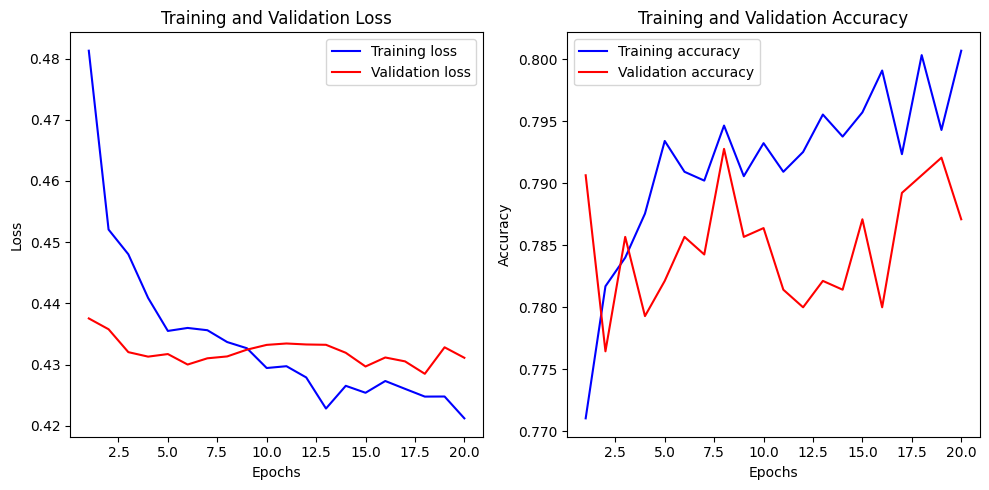

In [18]:
# Plotting training and validation loss across epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy across epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Model Accuracy (confusion matrix)

45/45 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.47      0.55       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



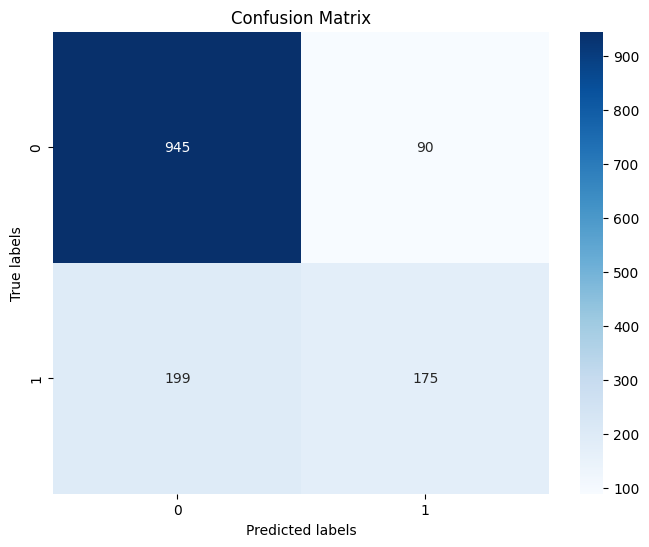

In [39]:
# y_pred = best_model.predict(Xtest)

y_pred2 = best_model2.predict(Xtest)
y_pred2 = y_pred2.flatten()
y_pred2.round(2)
y_pred2 = np.where(y_pred2 >= 0.5, 1, 0)

from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(Ytest, y_pred2))
conf_matrix = confusion_matrix(Ytest, y_pred2)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calculating the AUC score

In [ ]:
from sklearn.metrics import roc_auc_score
# Predicting probabilities for test set
y_probabilities = best_model.predict_proba(Xtest)[:, 1]  # Probability of class 1

# Calculating AUC score
auc_score = roc_auc_score(Ytest, y_probabilities)
print("AUC Score:", auc_score)

141/141 [==============================] - 0s 2ms/step
AUC Score: 0.8412369186497872
